#### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Classification on imbalanced data

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/imbalanced_data"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to classify a highly imbalanced dataset in which the number of examples in one class greatly outnumbers the examples in another. You will work with the [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) dataset hosted on Kaggle. The aim is to detect a mere 492 fraudulent transactions from 284,807 transactions in total. You will use [Keras](https://www.tensorflow.org/guide/keras/overview) to define the model and [class weights](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model) to help the model learn from the imbalanced data. .

This tutorial contains complete code to:

* Load a CSV file using Pandas.
* Create train, validation, and test sets.
* Define and train a model using Keras (including setting class weights).
* Evaluate the model using various metrics (including precision and recall).
* Try common techniques for dealing with imbalanced data like:
    * Class weighting 
    * Oversampling


## Setup

In [2]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Data processing and exploration

### Download the Kaggle Credit Card Fraud data set

Pandas is a Python library with many helpful utilities for loading and working with structured data. It can be used to download CSVs into a Pandas [DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html#pandas.DataFrame).

Note: This dataset has been collected and analysed during a research collaboration of Worldline and the [Machine Learning Group](http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available [here](https://www.researchgate.net/project/Fraud-detection-5) and the page of the [DefeatFraud](https://mlg.ulb.ac.be/wordpress/portfolio_page/defeatfraud-assessment-and-validation-of-deep-feature-engineering-and-learning-solutions-for-fraud-detection/) project

In [4]:
file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
raw_df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V26', 'V27', 'V28', 'Amount', 'Class']].describe()

,Time,V1,V2,V3,V4,V5,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### Examine the class label imbalance

Let's look at the dataset imbalance:

In [6]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



This shows the small fraction of positive samples.

### Clean, split and normalize the data

The raw data has a few issues. First the `Time` and `Amount` columns are too variable to use directly. Drop the `Time` column (since it's not clear what it means) and take the log of the `Amount` column to reduce its range.

In [7]:
cleaned_df = raw_df.copy()

# You don't want the `Time` column.
cleaned_df.pop('Time')

# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001 # 0 => 0.1¢
cleaned_df['Log Amount'] = np.log(cleaned_df.pop('Amount')+eps)

Split the dataset into train, validation, and test sets. The validation set is used during the model fitting to evaluate the loss and any metrics, however the model is not fit with this data. The test set is completely unused during the training phase and is only used at the end to evaluate how well the model generalizes to new data. This is especially important with imbalanced datasets where [overfitting](https://developers.google.com/machine-learning/crash-course/generalization/peril-of-overfitting) is a significant concern from the lack of training data.

In [8]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

Normalize the input features using the sklearn StandardScaler.
This will set the mean to 0 and standard deviation to 1.

Note: The `StandardScaler` is only fit using the `train_features` to be sure the model is not peeking at the validation or test sets. 

In [9]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


Caution: If you want to deploy a model, it's critical that you preserve the preprocessing calculations. The easiest way to implement them as layers, and attach them to your model before export.


### Look at the data distribution

Next compare the distributions of the positive and negative examples over a few features. Good questions to ask yourself at this point are:

* Do these distributions make sense? 
    * Yes. You've normalized the input and these are mostly concentrated in the `+/- 2` range.
* Can you see the difference between the distributions?
    * Yes the positive examples contain a much higher rate of extreme values.

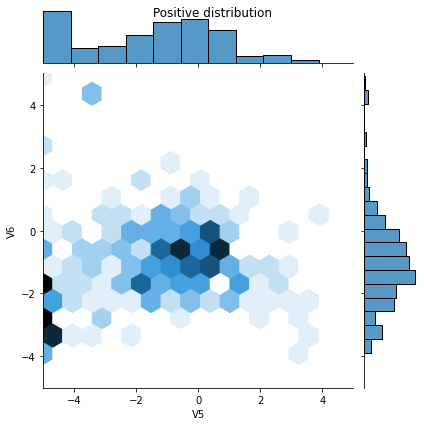

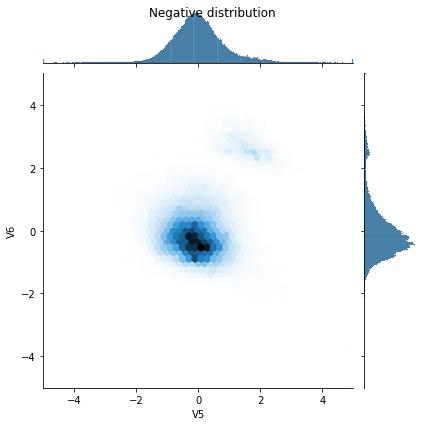

In [10]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(x=pos_df['V5'], y=pos_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(x=neg_df['V5'], y=neg_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

## Define the model and metrics

Define a function that creates a simple neural network with a densly connected hidden layer, a [dropout](https://developers.google.com/machine-learning/glossary/#dropout_regularization) layer to reduce overfitting, and an output sigmoid layer that returns the probability of a transaction being fraudulent: 

In [11]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

### Understanding useful metrics

Notice that there are a few metrics defined above that can be computed by the model that will be helpful when evaluating the performance.



*   **False** negatives and **false** positives are samples that were **incorrectly** classified
*   **True** negatives and **true** positives are samples that were **correctly** classified
*   **Accuracy** is the percentage of examples correctly classified
>   $\frac{\text{true samples}}{\text{total samples}}$
*   **Precision** is the percentage of **predicted** positives that were correctly classified
>   $\frac{\text{true positives}}{\text{true positives + false positives}}$
*   **Recall** is the percentage of **actual** positives that were correctly classified
>   $\frac{\text{true positives}}{\text{true positives + false negatives}}$
*   **AUC** refers to the Area Under the Curve of a Receiver Operating Characteristic curve (ROC-AUC). This metric is equal to the probability that a classifier will rank a random positive sample higher than a random negative sample.
*   **AUPRC** refers to Area Under the Curve of the Precision-Recall Curve. This metric computes precision-recall pairs for different probability thresholds. 

Note: Accuracy is not a helpful metric for this task. You can have 99.8%+ accuracy on this task by predicting False all the time.  

Read more:
*  [True vs. False and Positive vs. Negative](https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative)
*  [Accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy)
*   [Precision and Recall](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)
*   [ROC-AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [Relationship between Precision-Recall and ROC Curves](https://www.biostat.wisc.edu/~page/rocpr.pdf)

## Baseline model

### Build the model

Now create and train your model using the function that was defined earlier. Notice that the model is fit using a larger than default batch size of 2048, this is important to ensure that each batch has a decent chance of containing a few positive samples. If the batch size was too small, they would likely have no fraudulent transactions to learn from.


Note: this model will not handle the class imbalance well. You will improve it later in this tutorial.

In [12]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [13]:
model = make_model()
model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense (Dense)               (None, 16)                480       


 dropout (Dropout)           (None, 16)                0         


 dense_1 (Dense)             (None, 1)                 17        


Total params: 497


Trainable params: 497


Non-trainable params: 0


_________________________________________________________________


Test run the model:

In [14]:
model.predict(train_features[:10])

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 344ms/step


array([[0.6088169 ],
       [0.4941456 ],
       [0.6518074 ],
       [0.6477403 ],
       [0.3832439 ],
       [0.4007728 ],
       [0.32497266],
       [0.3713796 ],
       [0.42784396],
       [0.2801294 ]], dtype=float32)

### Optional: Set the correct initial bias.

These initial guesses are not great. You know the dataset is imbalanced. Set the output layer's bias to reflect that (See: [A Recipe for Training Neural Networks: "init well"](http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines)). This can help with initial convergence.

With the default bias initialization the loss should be about `math.log(2) = 0.69314` 

In [15]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.6775


The correct bias to set can be derived from:

$$ p_0 = pos/(pos + neg) = 1/(1+e^{-b_0}) $$
$$ b_0 = -log_e(1/p_0 - 1) $$
$$ b_0 = log_e(pos/neg)$$

In [16]:
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

Set that as the initial bias, and the model will give much more reasonable initial guesses. 

It should be near: `pos/total = 0.0018`

In [17]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 40ms/step


array([[0.00102003],
       [0.00334534],
       [0.00060373],
       [0.00167802],
       [0.0011223 ],
       [0.0013187 ],
       [0.00594859],
       [0.00176013],
       [0.0008566 ],
       [0.5312835 ]], dtype=float32)

With this initialization the initial loss should be approximately:

$$-p_0log(p_0)-(1-p_0)log(1-p_0) = 0.01317$$

In [18]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0209


This initial loss is about 50 times less than if would have been with naive initialization.

This way the model doesn't need to spend the first few epochs just learning that positive examples are unlikely. This also makes it easier to read plots of the loss during training.

### Checkpoint the initial weights

To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, and load them into each model before training:

In [19]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

### Confirm that the bias fix helps

Before moving on, confirm quick that the careful bias initialization actually helped.

Train the model for 20 epochs, with and without this careful initialization, and compare the losses: 

In [20]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [21]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [22]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

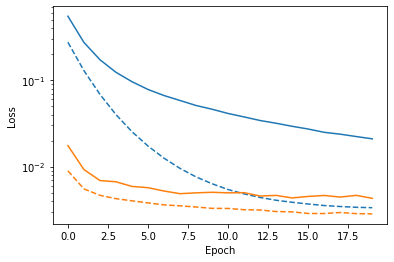

In [23]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

The above figure makes it clear: In terms of validation loss, on this problem, this careful initialization gives a clear advantage. 

### Train the model

In [24]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100


 1/90 [..............................] - ETA: 2:07 - loss: 0.0117 - tp: 58.0000 - fp: 15.0000 - tn: 47528.0000 - fn: 16.0000 - accuracy: 0.9993 - precision: 0.7945 - recall: 0.7838 - auc: 0.9384 - prc: 0.7592

12/90 [===>..........................] - ETA: 0s - loss: 0.0246 - tp: 58.0000 - fp: 61.0000 - tn: 69971.0000 - fn: 55.0000 - accuracy: 0.9983 - precision: 0.4874 - recall: 0.5133 - auc: 0.7955 - prc: 0.3978  

23/90 [======>.......................] - ETA: 0s - loss: 0.0235 - tp: 58.0000 - fp: 92.0000 - tn: 92425.0000 - fn: 98.0000 - accuracy: 0.9979 - precision: 0.3867 - recall: 0.3718 - auc: 0.7227 - prc: 0.2660

34/90 [==========>...................] - ETA: 0s - loss: 0.0224 - tp: 58.0000 - fp: 104.0000 - tn: 114900.0000 - fn: 139.0000 - accuracy: 0.9979 - precision: 0.3580 - recall: 0.2944 - auc: 0.6786 - prc: 0.2011

45/90 [==============>...............] - ETA: 0s - loss: 0.0214 - tp: 58.0000 - fp: 119.0000 - tn: 137373.0000 - fn: 179.0000 - accuracy: 0.9978 - precision: 0.3277 - recall: 0.2447 - auc: 0.6597 - prc: 0.1662

56/90 [=================>............] - ETA: 0s - loss: 0.0197 - tp: 58.0000 - fp: 131.0000 - tn: 159859.0000 - fn: 209.0000 - accuracy: 0.9979 - precision: 0.3069 - recall: 0.2172 - auc: 0.6568 - prc: 0.1480

67/90 [=====================>........] - ETA: 0s - loss: 0.0188 - tp: 58.0000 - fp: 137.0000 - tn: 182343.0000 - fn: 247.0000 - accuracy: 0.9979 - precision: 0.2974 - recall: 0.1902 - auc: 0.6517 - prc: 0.1314

78/90 [=========================>....] - ETA: 0s - loss: 0.0182 - tp: 59.0000 - fp: 143.0000 - tn: 204824.0000 - fn: 287.0000 - accuracy: 0.9979 - precision: 0.2921 - recall: 0.1705 - auc: 0.6543 - prc: 0.1179

90/90 [==============================] - ETA: 0s - loss: 0.0179 - tp: 62.0000 - fp: 150.0000 - tn: 227299.0000 - fn: 334.0000 - accuracy: 0.9979 - precision: 0.2925 - recall: 0.1566 - auc: 0.6586 - prc: 0.1123

90/90 [==============================] - 3s 14ms/step - loss: 0.0179 - tp: 62.0000 - fp: 150.0000 - tn: 227299.0000 - fn: 334.0000 - accuracy: 0.9979 - precision: 0.2925 - recall: 0.1566 - auc: 0.6586 - prc: 0.1123 - val_loss: 0.0092 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 45496.0000 - val_fn: 73.0000 - val_accuracy: 0.9984 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7654 - val_prc: 0.3283


Epoch 2/100


 1/90 [..............................] - ETA: 0s - loss: 0.0057 - tp: 1.0000 - fp: 1.0000 - tn: 2044.0000 - fn: 2.0000 - accuracy: 0.9985 - precision: 0.5000 - recall: 0.3333 - auc: 0.9992 - prc: 0.4515

12/90 [===>..........................] - ETA: 0s - loss: 0.0146 - tp: 6.0000 - fp: 9.0000 - tn: 24513.0000 - fn: 48.0000 - accuracy: 0.9977 - precision: 0.4000 - recall: 0.1111 - auc: 0.7039 - prc: 0.1302

24/90 [=======>......................] - ETA: 0s - loss: 0.0126 - tp: 13.0000 - fp: 16.0000 - tn: 49043.0000 - fn: 80.0000 - accuracy: 0.9980 - precision: 0.4483 - recall: 0.1398 - auc: 0.7198 - prc: 0.1694

35/90 [==========>...................] - ETA: 0s - loss: 0.0122 - tp: 23.0000 - fp: 23.0000 - tn: 71521.0000 - fn: 113.0000 - accuracy: 0.9981 - precision: 0.5000 - recall: 0.1691 - auc: 0.7381 - prc: 0.1917

46/90 [==============>...............] - ETA: 0s - loss: 0.0113 - tp: 29.0000 - fp: 28.0000 - tn: 94007.0000 - fn: 144.0000 - accuracy: 0.9982 - precision: 0.5088 - recall: 0.1676 - auc: 0.7604 - prc: 0.2103

57/90 [==================>...........] - ETA: 0s - loss: 0.0107 - tp: 41.0000 - fp: 34.0000 - tn: 116492.0000 - fn: 169.0000 - accuracy: 0.9983 - precision: 0.5467 - recall: 0.1952 - auc: 0.7725 - prc: 0.2351

68/90 [=====================>........] - ETA: 0s - loss: 0.0103 - tp: 49.0000 - fp: 43.0000 - tn: 138976.0000 - fn: 196.0000 - accuracy: 0.9983 - precision: 0.5326 - recall: 0.2000 - auc: 0.7833 - prc: 0.2341

80/90 [=========================>....] - ETA: 0s - loss: 0.0098 - tp: 67.0000 - fp: 46.0000 - tn: 163503.0000 - fn: 224.0000 - accuracy: 0.9984 - precision: 0.5929 - recall: 0.2302 - auc: 0.7995 - prc: 0.2937

90/90 [==============================] - 1s 6ms/step - loss: 0.0095 - tp: 77.0000 - fp: 51.0000 - tn: 181902.0000 - fn: 246.0000 - accuracy: 0.9984 - precision: 0.6016 - recall: 0.2384 - auc: 0.8065 - prc: 0.3097 - val_loss: 0.0056 - val_tp: 26.0000 - val_fp: 8.0000 - val_tn: 45488.0000 - val_fn: 47.0000 - val_accuracy: 0.9988 - val_precision: 0.7647 - val_recall: 0.3562 - val_auc: 0.9107 - val_prc: 0.6655


Epoch 3/100


 1/90 [..............................] - ETA: 0s - loss: 0.0084 - tp: 2.0000 - fp: 1.0000 - tn: 2043.0000 - fn: 2.0000 - accuracy: 0.9985 - precision: 0.6667 - recall: 0.5000 - auc: 0.8705 - prc: 0.4834

12/90 [===>..........................] - ETA: 0s - loss: 0.0079 - tp: 12.0000 - fp: 4.0000 - tn: 24533.0000 - fn: 27.0000 - accuracy: 0.9987 - precision: 0.7500 - recall: 0.3077 - auc: 0.8394 - prc: 0.4102

23/90 [======>.......................] - ETA: 0s - loss: 0.0084 - tp: 26.0000 - fp: 7.0000 - tn: 47014.0000 - fn: 57.0000 - accuracy: 0.9986 - precision: 0.7879 - recall: 0.3133 - auc: 0.8238 - prc: 0.4190

34/90 [==========>...................] - ETA: 0s - loss: 0.0076 - tp: 46.0000 - fp: 9.0000 - tn: 69498.0000 - fn: 79.0000 - accuracy: 0.9987 - precision: 0.8364 - recall: 0.3680 - auc: 0.8619 - prc: 0.5043

46/90 [==============>...............] - ETA: 0s - loss: 0.0075 - tp: 62.0000 - fp: 17.0000 - tn: 94024.0000 - fn: 105.0000 - accuracy: 0.9987 - precision: 0.7848 - recall: 0.3713 - auc: 0.8655 - prc: 0.4857

57/90 [==================>...........] - ETA: 0s - loss: 0.0075 - tp: 77.0000 - fp: 24.0000 - tn: 116509.0000 - fn: 126.0000 - accuracy: 0.9987 - precision: 0.7624 - recall: 0.3793 - auc: 0.8637 - prc: 0.4790

69/90 [======================>.......] - ETA: 0s - loss: 0.0075 - tp: 104.0000 - fp: 28.0000 - tn: 141029.0000 - fn: 151.0000 - accuracy: 0.9987 - precision: 0.7879 - recall: 0.4078 - auc: 0.8630 - prc: 0.5001

80/90 [=========================>....] - ETA: 0s - loss: 0.0072 - tp: 121.0000 - fp: 32.0000 - tn: 163520.0000 - fn: 167.0000 - accuracy: 0.9988 - precision: 0.7908 - recall: 0.4201 - auc: 0.8663 - prc: 0.5141

90/90 [==============================] - 1s 6ms/step - loss: 0.0070 - tp: 136.0000 - fp: 33.0000 - tn: 181920.0000 - fn: 187.0000 - accuracy: 0.9988 - precision: 0.8047 - recall: 0.4211 - auc: 0.8727 - prc: 0.5329 - val_loss: 0.0047 - val_tp: 37.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 36.0000 - val_accuracy: 0.9990 - val_precision: 0.8043 - val_recall: 0.5068 - val_auc: 0.9244 - val_prc: 0.6576


Epoch 4/100


 1/90 [..............................] - ETA: 0s - loss: 0.0048 - tp: 3.0000 - fp: 1.0000 - tn: 2042.0000 - fn: 2.0000 - accuracy: 0.9985 - precision: 0.7500 - recall: 0.6000 - auc: 0.9997 - prc: 0.8937

12/90 [===>..........................] - ETA: 0s - loss: 0.0063 - tp: 23.0000 - fp: 4.0000 - tn: 24527.0000 - fn: 22.0000 - accuracy: 0.9989 - precision: 0.8519 - recall: 0.5111 - auc: 0.8970 - prc: 0.6169

24/90 [=======>......................] - ETA: 0s - loss: 0.0057 - tp: 41.0000 - fp: 4.0000 - tn: 49065.0000 - fn: 42.0000 - accuracy: 0.9991 - precision: 0.9111 - recall: 0.4940 - auc: 0.8946 - prc: 0.6310

35/90 [==========>...................] - ETA: 0s - loss: 0.0055 - tp: 64.0000 - fp: 8.0000 - tn: 71549.0000 - fn: 59.0000 - accuracy: 0.9991 - precision: 0.8889 - recall: 0.5203 - auc: 0.8997 - prc: 0.6557

46/90 [==============>...............] - ETA: 0s - loss: 0.0055 - tp: 84.0000 - fp: 14.0000 - tn: 94036.0000 - fn: 74.0000 - accuracy: 0.9991 - precision: 0.8571 - recall: 0.5316 - auc: 0.8960 - prc: 0.6409

57/90 [==================>...........] - ETA: 0s - loss: 0.0058 - tp: 101.0000 - fp: 17.0000 - tn: 116521.0000 - fn: 97.0000 - accuracy: 0.9990 - precision: 0.8559 - recall: 0.5101 - auc: 0.8911 - prc: 0.6289

68/90 [=====================>........] - ETA: 0s - loss: 0.0060 - tp: 119.0000 - fp: 19.0000 - tn: 139004.0000 - fn: 122.0000 - accuracy: 0.9990 - precision: 0.8623 - recall: 0.4938 - auc: 0.8808 - prc: 0.6116

79/90 [=========================>....] - ETA: 0s - loss: 0.0061 - tp: 139.0000 - fp: 20.0000 - tn: 161486.0000 - fn: 147.0000 - accuracy: 0.9990 - precision: 0.8742 - recall: 0.4860 - auc: 0.8816 - prc: 0.6179

90/90 [==============================] - ETA: 0s - loss: 0.0061 - tp: 157.0000 - fp: 25.0000 - tn: 181928.0000 - fn: 166.0000 - accuracy: 0.9990 - precision: 0.8626 - recall: 0.4861 - auc: 0.8871 - prc: 0.6036

90/90 [==============================] - 1s 6ms/step - loss: 0.0061 - tp: 157.0000 - fp: 25.0000 - tn: 181928.0000 - fn: 166.0000 - accuracy: 0.9990 - precision: 0.8626 - recall: 0.4861 - auc: 0.8871 - prc: 0.6036 - val_loss: 0.0043 - val_tp: 42.0000 - val_fp: 10.0000 - val_tn: 45486.0000 - val_fn: 31.0000 - val_accuracy: 0.9991 - val_precision: 0.8077 - val_recall: 0.5753 - val_auc: 0.9244 - val_prc: 0.6553


Epoch 5/100


 1/90 [..............................] - ETA: 0s - loss: 0.0044 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.7500 - auc: 0.8732 - prc: 0.7517

12/90 [===>..........................] - ETA: 0s - loss: 0.0060 - tp: 17.0000 - fp: 5.0000 - tn: 24534.0000 - fn: 20.0000 - accuracy: 0.9990 - precision: 0.7727 - recall: 0.4595 - auc: 0.8622 - prc: 0.5312 

23/90 [======>.......................] - ETA: 0s - loss: 0.0056 - tp: 35.0000 - fp: 10.0000 - tn: 47022.0000 - fn: 37.0000 - accuracy: 0.9990 - precision: 0.7778 - recall: 0.4861 - auc: 0.8727 - prc: 0.5858

35/90 [==========>...................] - ETA: 0s - loss: 0.0059 - tp: 61.0000 - fp: 13.0000 - tn: 71547.0000 - fn: 59.0000 - accuracy: 0.9990 - precision: 0.8243 - recall: 0.5083 - auc: 0.8769 - prc: 0.6004

47/90 [==============>...............] - ETA: 0s - loss: 0.0059 - tp: 86.0000 - fp: 15.0000 - tn: 96077.0000 - fn: 78.0000 - accuracy: 0.9990 - precision: 0.8515 - recall: 0.5244 - auc: 0.8850 - prc: 0.6218

58/90 [==================>...........] - ETA: 0s - loss: 0.0058 - tp: 105.0000 - fp: 17.0000 - tn: 118566.0000 - fn: 96.0000 - accuracy: 0.9990 - precision: 0.8607 - recall: 0.5224 - auc: 0.8884 - prc: 0.6250

70/90 [======================>.......] - ETA: 0s - loss: 0.0060 - tp: 128.0000 - fp: 19.0000 - tn: 143090.0000 - fn: 123.0000 - accuracy: 0.9990 - precision: 0.8707 - recall: 0.5100 - auc: 0.8842 - prc: 0.6184

81/90 [==========================>...] - ETA: 0s - loss: 0.0059 - tp: 148.0000 - fp: 22.0000 - tn: 165575.0000 - fn: 143.0000 - accuracy: 0.9990 - precision: 0.8706 - recall: 0.5086 - auc: 0.8896 - prc: 0.6277

90/90 [==============================] - 1s 6ms/step - loss: 0.0058 - tp: 172.0000 - fp: 25.0000 - tn: 181928.0000 - fn: 151.0000 - accuracy: 0.9990 - precision: 0.8731 - recall: 0.5325 - auc: 0.8942 - prc: 0.6344 - val_loss: 0.0041 - val_tp: 45.0000 - val_fp: 10.0000 - val_tn: 45486.0000 - val_fn: 28.0000 - val_accuracy: 0.9992 - val_precision: 0.8182 - val_recall: 0.6164 - val_auc: 0.9312 - val_prc: 0.6639


Epoch 6/100


 1/90 [..............................] - ETA: 0s - loss: 0.0099 - tp: 4.0000 - fp: 0.0000e+00 - tn: 2041.0000 - fn: 3.0000 - accuracy: 0.9985 - precision: 1.0000 - recall: 0.5714 - auc: 0.8548 - prc: 0.6091

12/90 [===>..........................] - ETA: 0s - loss: 0.0048 - tp: 25.0000 - fp: 2.0000 - tn: 24526.0000 - fn: 23.0000 - accuracy: 0.9990 - precision: 0.9259 - recall: 0.5208 - auc: 0.9255 - prc: 0.7540 

24/90 [=======>......................] - ETA: 0s - loss: 0.0056 - tp: 39.0000 - fp: 6.0000 - tn: 49063.0000 - fn: 44.0000 - accuracy: 0.9990 - precision: 0.8667 - recall: 0.4699 - auc: 0.8895 - prc: 0.6236

36/90 [===========>..................] - ETA: 0s - loss: 0.0056 - tp: 61.0000 - fp: 9.0000 - tn: 73595.0000 - fn: 63.0000 - accuracy: 0.9990 - precision: 0.8714 - recall: 0.4919 - auc: 0.8809 - prc: 0.6188

48/90 [===============>..............] - ETA: 0s - loss: 0.0058 - tp: 79.0000 - fp: 12.0000 - tn: 98128.0000 - fn: 85.0000 - accuracy: 0.9990 - precision: 0.8681 - recall: 0.4817 - auc: 0.8790 - prc: 0.5963

60/90 [===================>..........] - ETA: 0s - loss: 0.0057 - tp: 110.0000 - fp: 14.0000 - tn: 122650.0000 - fn: 106.0000 - accuracy: 0.9990 - precision: 0.8871 - recall: 0.5093 - auc: 0.8869 - prc: 0.6260

71/90 [======================>.......] - ETA: 0s - loss: 0.0055 - tp: 132.0000 - fp: 18.0000 - tn: 145139.0000 - fn: 119.0000 - accuracy: 0.9991 - precision: 0.8800 - recall: 0.5259 - auc: 0.8946 - prc: 0.6379

82/90 [==========================>...] - ETA: 0s - loss: 0.0055 - tp: 158.0000 - fp: 19.0000 - tn: 167620.0000 - fn: 139.0000 - accuracy: 0.9991 - precision: 0.8927 - recall: 0.5320 - auc: 0.8955 - prc: 0.6469

90/90 [==============================] - 1s 6ms/step - loss: 0.0055 - tp: 172.0000 - fp: 22.0000 - tn: 181931.0000 - fn: 151.0000 - accuracy: 0.9991 - precision: 0.8866 - recall: 0.5325 - auc: 0.8976 - prc: 0.6494 - val_loss: 0.0039 - val_tp: 52.0000 - val_fp: 10.0000 - val_tn: 45486.0000 - val_fn: 21.0000 - val_accuracy: 0.9993 - val_precision: 0.8387 - val_recall: 0.7123 - val_auc: 0.9380 - val_prc: 0.6824


Epoch 7/100


 1/90 [..............................] - ETA: 0s - loss: 0.0013 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2047.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 1.0000 - prc: 1.0000

13/90 [===>..........................] - ETA: 0s - loss: 0.0053 - tp: 41.0000 - fp: 5.0000 - tn: 26560.0000 - fn: 18.0000 - accuracy: 0.9991 - precision: 0.8913 - recall: 0.6949 - auc: 0.9477 - prc: 0.7494             

25/90 [=======>......................] - ETA: 0s - loss: 0.0058 - tp: 73.0000 - fp: 9.0000 - tn: 51080.0000 - fn: 38.0000 - accuracy: 0.9991 - precision: 0.8902 - recall: 0.6577 - auc: 0.9083 - prc: 0.7081

37/90 [===========>..................] - ETA: 0s - loss: 0.0057 - tp: 94.0000 - fp: 11.0000 - tn: 75611.0000 - fn: 60.0000 - accuracy: 0.9991 - precision: 0.8952 - recall: 0.6104 - auc: 0.8977 - prc: 0.6835

49/90 [===============>..............] - ETA: 0s - loss: 0.0059 - tp: 113.0000 - fp: 16.0000 - tn: 100138.0000 - fn: 85.0000 - accuracy: 0.9990 - precision: 0.8760 - recall: 0.5707 - auc: 0.8921 - prc: 0.6498

60/90 [===================>..........] - ETA: 0s - loss: 0.0060 - tp: 128.0000 - fp: 22.0000 - tn: 122628.0000 - fn: 102.0000 - accuracy: 0.9990 - precision: 0.8533 - recall: 0.5565 - auc: 0.8917 - prc: 0.6273

72/90 [=======================>......] - ETA: 0s - loss: 0.0060 - tp: 147.0000 - fp: 25.0000 - tn: 147165.0000 - fn: 119.0000 - accuracy: 0.9990 - precision: 0.8547 - recall: 0.5526 - auc: 0.8873 - prc: 0.6190

84/90 [===========================>..] - ETA: 0s - loss: 0.0058 - tp: 171.0000 - fp: 27.0000 - tn: 171698.0000 - fn: 136.0000 - accuracy: 0.9991 - precision: 0.8636 - recall: 0.5570 - auc: 0.8924 - prc: 0.6286

90/90 [==============================] - 1s 6ms/step - loss: 0.0057 - tp: 180.0000 - fp: 28.0000 - tn: 181925.0000 - fn: 143.0000 - accuracy: 0.9991 - precision: 0.8654 - recall: 0.5573 - auc: 0.8946 - prc: 0.6345 - val_loss: 0.0037 - val_tp: 52.0000 - val_fp: 10.0000 - val_tn: 45486.0000 - val_fn: 21.0000 - val_accuracy: 0.9993 - val_precision: 0.8387 - val_recall: 0.7123 - val_auc: 0.9448 - val_prc: 0.6873


Epoch 8/100


 1/90 [..............................] - ETA: 0s - loss: 0.0031 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.5000 - auc: 1.0000 - prc: 1.0000

12/90 [===>..........................] - ETA: 0s - loss: 0.0072 - tp: 30.0000 - fp: 5.0000 - tn: 24515.0000 - fn: 26.0000 - accuracy: 0.9987 - precision: 0.8571 - recall: 0.5357 - auc: 0.9004 - prc: 0.6593 

24/90 [=======>......................] - ETA: 0s - loss: 0.0062 - tp: 53.0000 - fp: 6.0000 - tn: 49045.0000 - fn: 48.0000 - accuracy: 0.9989 - precision: 0.8983 - recall: 0.5248 - auc: 0.8896 - prc: 0.6713

36/90 [===========>..................] - ETA: 0s - loss: 0.0055 - tp: 75.0000 - fp: 9.0000 - tn: 73582.0000 - fn: 62.0000 - accuracy: 0.9990 - precision: 0.8929 - recall: 0.5474 - auc: 0.8964 - prc: 0.6843

47/90 [==============>...............] - ETA: 0s - loss: 0.0055 - tp: 97.0000 - fp: 15.0000 - tn: 96069.0000 - fn: 75.0000 - accuracy: 0.9991 - precision: 0.8661 - recall: 0.5640 - auc: 0.8939 - prc: 0.6462

59/90 [==================>...........] - ETA: 0s - loss: 0.0053 - tp: 118.0000 - fp: 20.0000 - tn: 120606.0000 - fn: 88.0000 - accuracy: 0.9991 - precision: 0.8551 - recall: 0.5728 - auc: 0.8966 - prc: 0.6410

71/90 [======================>.......] - ETA: 0s - loss: 0.0055 - tp: 148.0000 - fp: 22.0000 - tn: 145122.0000 - fn: 116.0000 - accuracy: 0.9991 - precision: 0.8706 - recall: 0.5606 - auc: 0.9001 - prc: 0.6424

82/90 [==========================>...] - ETA: 0s - loss: 0.0054 - tp: 169.0000 - fp: 23.0000 - tn: 167609.0000 - fn: 135.0000 - accuracy: 0.9991 - precision: 0.8802 - recall: 0.5559 - auc: 0.9016 - prc: 0.6553

90/90 [==============================] - 1s 6ms/step - loss: 0.0053 - tp: 181.0000 - fp: 26.0000 - tn: 181927.0000 - fn: 142.0000 - accuracy: 0.9991 - precision: 0.8744 - recall: 0.5604 - auc: 0.9027 - prc: 0.6565 - val_loss: 0.0036 - val_tp: 52.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 21.0000 - val_accuracy: 0.9993 - val_precision: 0.8525 - val_recall: 0.7123 - val_auc: 0.9448 - val_prc: 0.6884


Epoch 9/100


 1/90 [..............................] - ETA: 0s - loss: 7.5539e-04 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2047.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

12/90 [===>..........................] - ETA: 0s - loss: 0.0058 - tp: 27.0000 - fp: 3.0000 - tn: 24526.0000 - fn: 20.0000 - accuracy: 0.9991 - precision: 0.9000 - recall: 0.5745 - auc: 0.8812 - prc: 0.6270         

24/90 [=======>......................] - ETA: 0s - loss: 0.0055 - tp: 54.0000 - fp: 8.0000 - tn: 49052.0000 - fn: 38.0000 - accuracy: 0.9991 - precision: 0.8710 - recall: 0.5870 - auc: 0.8788 - prc: 0.6513

36/90 [===========>..................] - ETA: 0s - loss: 0.0049 - tp: 78.0000 - fp: 10.0000 - tn: 73586.0000 - fn: 54.0000 - accuracy: 0.9991 - precision: 0.8864 - recall: 0.5909 - auc: 0.8925 - prc: 0.6901

48/90 [===============>..............] - ETA: 0s - loss: 0.0054 - tp: 101.0000 - fp: 14.0000 - tn: 98111.0000 - fn: 78.0000 - accuracy: 0.9991 - precision: 0.8783 - recall: 0.5642 - auc: 0.8812 - prc: 0.6570

60/90 [===================>..........] - ETA: 0s - loss: 0.0053 - tp: 120.0000 - fp: 18.0000 - tn: 122641.0000 - fn: 101.0000 - accuracy: 0.9990 - precision: 0.8696 - recall: 0.5430 - auc: 0.8900 - prc: 0.6616

72/90 [=======================>......] - ETA: 0s - loss: 0.0052 - tp: 144.0000 - fp: 22.0000 - tn: 147170.0000 - fn: 120.0000 - accuracy: 0.9990 - precision: 0.8675 - recall: 0.5455 - auc: 0.8945 - prc: 0.6698

84/90 [===========================>..] - ETA: 0s - loss: 0.0051 - tp: 171.0000 - fp: 29.0000 - tn: 171700.0000 - fn: 132.0000 - accuracy: 0.9991 - precision: 0.8550 - recall: 0.5644 - auc: 0.9013 - prc: 0.6717

90/90 [==============================] - 1s 6ms/step - loss: 0.0053 - tp: 180.0000 - fp: 31.0000 - tn: 181922.0000 - fn: 143.0000 - accuracy: 0.9990 - precision: 0.8531 - recall: 0.5573 - auc: 0.8980 - prc: 0.6595 - val_loss: 0.0035 - val_tp: 53.0000 - val_fp: 10.0000 - val_tn: 45486.0000 - val_fn: 20.0000 - val_accuracy: 0.9993 - val_precision: 0.8413 - val_recall: 0.7260 - val_auc: 0.9449 - val_prc: 0.7112


Epoch 10/100


 1/90 [..............................] - ETA: 0s - loss: 7.5394e-04 - tp: 4.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

12/90 [===>..........................] - ETA: 0s - loss: 0.0056 - tp: 21.0000 - fp: 7.0000 - tn: 24531.0000 - fn: 17.0000 - accuracy: 0.9990 - precision: 0.7500 - recall: 0.5526 - auc: 0.9329 - prc: 0.5833         

23/90 [======>.......................] - ETA: 0s - loss: 0.0046 - tp: 49.0000 - fp: 10.0000 - tn: 47015.0000 - fn: 30.0000 - accuracy: 0.9992 - precision: 0.8305 - recall: 0.6203 - auc: 0.9422 - prc: 0.7058

34/90 [==========>...................] - ETA: 0s - loss: 0.0043 - tp: 73.0000 - fp: 10.0000 - tn: 69502.0000 - fn: 47.0000 - accuracy: 0.9992 - precision: 0.8795 - recall: 0.6083 - auc: 0.9367 - prc: 0.7315

45/90 [==============>...............] - ETA: 0s - loss: 0.0044 - tp: 94.0000 - fp: 13.0000 - tn: 91989.0000 - fn: 64.0000 - accuracy: 0.9992 - precision: 0.8785 - recall: 0.5949 - auc: 0.9263 - prc: 0.7135

56/90 [=================>............] - ETA: 0s - loss: 0.0047 - tp: 117.0000 - fp: 22.0000 - tn: 114466.0000 - fn: 83.0000 - accuracy: 0.9991 - precision: 0.8417 - recall: 0.5850 - auc: 0.9266 - prc: 0.6903

68/90 [=====================>........] - ETA: 0s - loss: 0.0047 - tp: 144.0000 - fp: 23.0000 - tn: 138995.0000 - fn: 102.0000 - accuracy: 0.9991 - precision: 0.8623 - recall: 0.5854 - auc: 0.9177 - prc: 0.6902

80/90 [=========================>....] - ETA: 0s - loss: 0.0049 - tp: 171.0000 - fp: 27.0000 - tn: 163521.0000 - fn: 121.0000 - accuracy: 0.9991 - precision: 0.8636 - recall: 0.5856 - auc: 0.9116 - prc: 0.6785

90/90 [==============================] - 1s 6ms/step - loss: 0.0049 - tp: 189.0000 - fp: 32.0000 - tn: 181921.0000 - fn: 134.0000 - accuracy: 0.9991 - precision: 0.8552 - recall: 0.5851 - auc: 0.9123 - prc: 0.6817 - val_loss: 0.0034 - val_tp: 53.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 20.0000 - val_accuracy: 0.9994 - val_precision: 0.8548 - val_recall: 0.7260 - val_auc: 0.9448 - val_prc: 0.7094


Epoch 11/100


 1/90 [..............................] - ETA: 0s - loss: 6.6949e-04 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2047.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

13/90 [===>..........................] - ETA: 0s - loss: 0.0046 - tp: 22.0000 - fp: 3.0000 - tn: 26577.0000 - fn: 22.0000 - accuracy: 0.9991 - precision: 0.8800 - recall: 0.5000 - auc: 0.9192 - prc: 0.6842         

25/90 [=======>......................] - ETA: 0s - loss: 0.0045 - tp: 53.0000 - fp: 6.0000 - tn: 51100.0000 - fn: 41.0000 - accuracy: 0.9991 - precision: 0.8983 - recall: 0.5638 - auc: 0.9191 - prc: 0.7346

37/90 [===========>..................] - ETA: 0s - loss: 0.0043 - tp: 76.0000 - fp: 10.0000 - tn: 75631.0000 - fn: 59.0000 - accuracy: 0.9991 - precision: 0.8837 - recall: 0.5630 - auc: 0.9285 - prc: 0.7319

49/90 [===============>..............] - ETA: 0s - loss: 0.0044 - tp: 101.0000 - fp: 13.0000 - tn: 100161.0000 - fn: 77.0000 - accuracy: 0.9991 - precision: 0.8860 - recall: 0.5674 - auc: 0.9202 - prc: 0.7261

61/90 [===================>..........] - ETA: 0s - loss: 0.0044 - tp: 127.0000 - fp: 16.0000 - tn: 124690.0000 - fn: 95.0000 - accuracy: 0.9991 - precision: 0.8881 - recall: 0.5721 - auc: 0.9133 - prc: 0.7293

73/90 [=======================>......] - ETA: 0s - loss: 0.0047 - tp: 155.0000 - fp: 22.0000 - tn: 149211.0000 - fn: 116.0000 - accuracy: 0.9991 - precision: 0.8757 - recall: 0.5720 - auc: 0.9140 - prc: 0.7141

85/90 [===========================>..] - ETA: 0s - loss: 0.0048 - tp: 182.0000 - fp: 31.0000 - tn: 173737.0000 - fn: 130.0000 - accuracy: 0.9991 - precision: 0.8545 - recall: 0.5833 - auc: 0.9203 - prc: 0.6903

90/90 [==============================] - 1s 6ms/step - loss: 0.0048 - tp: 189.0000 - fp: 32.0000 - tn: 181921.0000 - fn: 134.0000 - accuracy: 0.9991 - precision: 0.8552 - recall: 0.5851 - auc: 0.9215 - prc: 0.6940 - val_loss: 0.0034 - val_tp: 54.0000 - val_fp: 10.0000 - val_tn: 45486.0000 - val_fn: 19.0000 - val_accuracy: 0.9994 - val_precision: 0.8438 - val_recall: 0.7397 - val_auc: 0.9448 - val_prc: 0.7151


Epoch 12/100


 1/90 [..............................] - ETA: 0s - loss: 0.0076 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.5000 - auc: 0.7468 - prc: 0.5026

12/90 [===>..........................] - ETA: 0s - loss: 0.0049 - tp: 28.0000 - fp: 1.0000 - tn: 24525.0000 - fn: 22.0000 - accuracy: 0.9991 - precision: 0.9655 - recall: 0.5600 - auc: 0.9087 - prc: 0.7288 

24/90 [=======>......................] - ETA: 0s - loss: 0.0047 - tp: 54.0000 - fp: 8.0000 - tn: 49052.0000 - fn: 38.0000 - accuracy: 0.9991 - precision: 0.8710 - recall: 0.5870 - auc: 0.9284 - prc: 0.7091

36/90 [===========>..................] - ETA: 0s - loss: 0.0051 - tp: 73.0000 - fp: 14.0000 - tn: 73584.0000 - fn: 57.0000 - accuracy: 0.9990 - precision: 0.8391 - recall: 0.5615 - auc: 0.9142 - prc: 0.6694

48/90 [===============>..............] - ETA: 0s - loss: 0.0051 - tp: 96.0000 - fp: 18.0000 - tn: 98114.0000 - fn: 76.0000 - accuracy: 0.9990 - precision: 0.8421 - recall: 0.5581 - auc: 0.9058 - prc: 0.6571

59/90 [==================>...........] - ETA: 0s - loss: 0.0051 - tp: 123.0000 - fp: 20.0000 - tn: 120595.0000 - fn: 94.0000 - accuracy: 0.9991 - precision: 0.8601 - recall: 0.5668 - auc: 0.9113 - prc: 0.6656

71/90 [======================>.......] - ETA: 0s - loss: 0.0051 - tp: 149.0000 - fp: 22.0000 - tn: 145123.0000 - fn: 114.0000 - accuracy: 0.9991 - precision: 0.8713 - recall: 0.5665 - auc: 0.9076 - prc: 0.6712

83/90 [==========================>...] - ETA: 0s - loss: 0.0052 - tp: 172.0000 - fp: 29.0000 - tn: 169651.0000 - fn: 132.0000 - accuracy: 0.9991 - precision: 0.8557 - recall: 0.5658 - auc: 0.9051 - prc: 0.6580

90/90 [==============================] - 1s 6ms/step - loss: 0.0050 - tp: 183.0000 - fp: 31.0000 - tn: 181922.0000 - fn: 140.0000 - accuracy: 0.9991 - precision: 0.8551 - recall: 0.5666 - auc: 0.9091 - prc: 0.6663 - val_loss: 0.0032 - val_tp: 52.0000 - val_fp: 8.0000 - val_tn: 45488.0000 - val_fn: 21.0000 - val_accuracy: 0.9994 - val_precision: 0.8667 - val_recall: 0.7123 - val_auc: 0.9448 - val_prc: 0.7642


Epoch 13/100


 1/90 [..............................] - ETA: 0s - loss: 0.0040 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2047.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4958 - prc: 4.7262e-04

13/90 [===>..........................] - ETA: 0s - loss: 0.0047 - tp: 28.0000 - fp: 3.0000 - tn: 26574.0000 - fn: 19.0000 - accuracy: 0.9992 - precision: 0.9032 - recall: 0.5957 - auc: 0.8927 - prc: 0.7433                 

24/90 [=======>......................] - ETA: 0s - loss: 0.0050 - tp: 51.0000 - fp: 9.0000 - tn: 49056.0000 - fn: 36.0000 - accuracy: 0.9991 - precision: 0.8500 - recall: 0.5862 - auc: 0.9069 - prc: 0.6797

35/90 [==========>...................] - ETA: 0s - loss: 0.0044 - tp: 76.0000 - fp: 15.0000 - tn: 71542.0000 - fn: 47.0000 - accuracy: 0.9991 - precision: 0.8352 - recall: 0.6179 - auc: 0.9259 - prc: 0.7026

47/90 [==============>...............] - ETA: 0s - loss: 0.0047 - tp: 104.0000 - fp: 18.0000 - tn: 96067.0000 - fn: 67.0000 - accuracy: 0.9991 - precision: 0.8525 - recall: 0.6082 - auc: 0.9317 - prc: 0.6924

59/90 [==================>...........] - ETA: 0s - loss: 0.0048 - tp: 130.0000 - fp: 23.0000 - tn: 120592.0000 - fn: 87.0000 - accuracy: 0.9991 - precision: 0.8497 - recall: 0.5991 - auc: 0.9276 - prc: 0.6836

71/90 [======================>.......] - ETA: 0s - loss: 0.0047 - tp: 162.0000 - fp: 27.0000 - tn: 145117.0000 - fn: 102.0000 - accuracy: 0.9991 - precision: 0.8571 - recall: 0.6136 - auc: 0.9289 - prc: 0.6986

83/90 [==========================>...] - ETA: 0s - loss: 0.0047 - tp: 179.0000 - fp: 30.0000 - tn: 169648.0000 - fn: 127.0000 - accuracy: 0.9991 - precision: 0.8565 - recall: 0.5850 - auc: 0.9271 - prc: 0.6906

90/90 [==============================] - 1s 6ms/step - loss: 0.0047 - tp: 187.0000 - fp: 31.0000 - tn: 181922.0000 - fn: 136.0000 - accuracy: 0.9991 - precision: 0.8578 - recall: 0.5789 - auc: 0.9278 - prc: 0.6926 - val_loss: 0.0032 - val_tp: 54.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 19.0000 - val_accuracy: 0.9994 - val_precision: 0.8571 - val_recall: 0.7397 - val_auc: 0.9449 - val_prc: 0.7562


Epoch 14/100


 1/90 [..............................] - ETA: 0s - loss: 0.0080 - tp: 4.0000 - fp: 0.0000e+00 - tn: 2041.0000 - fn: 3.0000 - accuracy: 0.9985 - precision: 1.0000 - recall: 0.5714 - auc: 0.8562 - prc: 0.7179

13/90 [===>..........................] - ETA: 0s - loss: 0.0064 - tp: 36.0000 - fp: 4.0000 - tn: 26553.0000 - fn: 31.0000 - accuracy: 0.9987 - precision: 0.9000 - recall: 0.5373 - auc: 0.9019 - prc: 0.7094 

24/90 [=======>......................] - ETA: 0s - loss: 0.0054 - tp: 58.0000 - fp: 5.0000 - tn: 49042.0000 - fn: 47.0000 - accuracy: 0.9989 - precision: 0.9206 - recall: 0.5524 - auc: 0.8942 - prc: 0.7159

36/90 [===========>..................] - ETA: 0s - loss: 0.0050 - tp: 83.0000 - fp: 9.0000 - tn: 73577.0000 - fn: 59.0000 - accuracy: 0.9991 - precision: 0.9022 - recall: 0.5845 - auc: 0.8898 - prc: 0.6960

47/90 [==============>...............] - ETA: 0s - loss: 0.0050 - tp: 103.0000 - fp: 10.0000 - tn: 96062.0000 - fn: 81.0000 - accuracy: 0.9991 - precision: 0.9115 - recall: 0.5598 - auc: 0.8929 - prc: 0.6980

59/90 [==================>...........] - ETA: 0s - loss: 0.0049 - tp: 124.0000 - fp: 17.0000 - tn: 120596.0000 - fn: 95.0000 - accuracy: 0.9991 - precision: 0.8794 - recall: 0.5662 - auc: 0.8961 - prc: 0.6805

71/90 [======================>.......] - ETA: 0s - loss: 0.0048 - tp: 147.0000 - fp: 25.0000 - tn: 145131.0000 - fn: 105.0000 - accuracy: 0.9991 - precision: 0.8547 - recall: 0.5833 - auc: 0.9036 - prc: 0.6723

83/90 [==========================>...] - ETA: 0s - loss: 0.0045 - tp: 183.0000 - fp: 29.0000 - tn: 169653.0000 - fn: 119.0000 - accuracy: 0.9991 - precision: 0.8632 - recall: 0.6060 - auc: 0.9162 - prc: 0.7051

90/90 [==============================] - 1s 6ms/step - loss: 0.0044 - tp: 198.0000 - fp: 30.0000 - tn: 181923.0000 - fn: 125.0000 - accuracy: 0.9991 - precision: 0.8684 - recall: 0.6130 - auc: 0.9170 - prc: 0.7135 - val_loss: 0.0031 - val_tp: 52.0000 - val_fp: 8.0000 - val_tn: 45488.0000 - val_fn: 21.0000 - val_accuracy: 0.9994 - val_precision: 0.8667 - val_recall: 0.7123 - val_auc: 0.9449 - val_prc: 0.7759


Epoch 15/100


 1/90 [..............................] - ETA: 0s - loss: 0.0013 - tp: 2.0000 - fp: 1.0000 - tn: 2045.0000 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.6667 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

12/90 [===>..........................] - ETA: 0s - loss: 0.0037 - tp: 26.0000 - fp: 6.0000 - tn: 24528.0000 - fn: 16.0000 - accuracy: 0.9991 - precision: 0.8125 - recall: 0.6190 - auc: 0.9755 - prc: 0.7536 

23/90 [======>.......................] - ETA: 0s - loss: 0.0040 - tp: 37.0000 - fp: 8.0000 - tn: 47025.0000 - fn: 34.0000 - accuracy: 0.9991 - precision: 0.8222 - recall: 0.5211 - auc: 0.9358 - prc: 0.6967

35/90 [==========>...................] - ETA: 0s - loss: 0.0038 - tp: 68.0000 - fp: 10.0000 - tn: 71550.0000 - fn: 52.0000 - accuracy: 0.9991 - precision: 0.8718 - recall: 0.5667 - auc: 0.9409 - prc: 0.7522

47/90 [==============>...............] - ETA: 0s - loss: 0.0040 - tp: 92.0000 - fp: 13.0000 - tn: 96076.0000 - fn: 75.0000 - accuracy: 0.9991 - precision: 0.8762 - recall: 0.5509 - auc: 0.9333 - prc: 0.7394

59/90 [==================>...........] - ETA: 0s - loss: 0.0045 - tp: 122.0000 - fp: 14.0000 - tn: 120596.0000 - fn: 100.0000 - accuracy: 0.9991 - precision: 0.8971 - recall: 0.5495 - auc: 0.9134 - prc: 0.7116

71/90 [======================>.......] - ETA: 0s - loss: 0.0044 - tp: 148.0000 - fp: 20.0000 - tn: 145126.0000 - fn: 114.0000 - accuracy: 0.9991 - precision: 0.8810 - recall: 0.5649 - auc: 0.9208 - prc: 0.7189

83/90 [==========================>...] - ETA: 0s - loss: 0.0043 - tp: 179.0000 - fp: 26.0000 - tn: 169655.0000 - fn: 124.0000 - accuracy: 0.9991 - precision: 0.8732 - recall: 0.5908 - auc: 0.9231 - prc: 0.7219

90/90 [==============================] - 1s 6ms/step - loss: 0.0043 - tp: 192.0000 - fp: 27.0000 - tn: 181926.0000 - fn: 131.0000 - accuracy: 0.9991 - precision: 0.8767 - recall: 0.5944 - auc: 0.9216 - prc: 0.7232 - val_loss: 0.0031 - val_tp: 56.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 17.0000 - val_accuracy: 0.9994 - val_precision: 0.8615 - val_recall: 0.7671 - val_auc: 0.9448 - val_prc: 0.7478


Epoch 16/100


 1/90 [..............................] - ETA: 0s - loss: 0.0022 - tp: 1.0000 - fp: 1.0000 - tn: 2046.0000 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.5000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

12/90 [===>..........................] - ETA: 0s - loss: 0.0057 - tp: 18.0000 - fp: 5.0000 - tn: 24535.0000 - fn: 18.0000 - accuracy: 0.9991 - precision: 0.7826 - recall: 0.5000 - auc: 0.8179 - prc: 0.4900 

24/90 [=======>......................] - ETA: 0s - loss: 0.0052 - tp: 52.0000 - fp: 11.0000 - tn: 49052.0000 - fn: 37.0000 - accuracy: 0.9990 - precision: 0.8254 - recall: 0.5843 - auc: 0.9147 - prc: 0.6502

36/90 [===========>..................] - ETA: 0s - loss: 0.0052 - tp: 77.0000 - fp: 13.0000 - tn: 73578.0000 - fn: 60.0000 - accuracy: 0.9990 - precision: 0.8556 - recall: 0.5620 - auc: 0.9222 - prc: 0.6703

47/90 [==============>...............] - ETA: 0s - loss: 0.0051 - tp: 105.0000 - fp: 18.0000 - tn: 96055.0000 - fn: 78.0000 - accuracy: 0.9990 - precision: 0.8537 - recall: 0.5738 - auc: 0.9224 - prc: 0.6838

58/90 [==================>...........] - ETA: 0s - loss: 0.0048 - tp: 133.0000 - fp: 21.0000 - tn: 118542.0000 - fn: 88.0000 - accuracy: 0.9991 - precision: 0.8636 - recall: 0.6018 - auc: 0.9221 - prc: 0.6976

69/90 [======================>.......] - ETA: 0s - loss: 0.0048 - tp: 158.0000 - fp: 24.0000 - tn: 141029.0000 - fn: 101.0000 - accuracy: 0.9991 - precision: 0.8681 - recall: 0.6100 - auc: 0.9199 - prc: 0.6986

80/90 [=========================>....] - ETA: 0s - loss: 0.0047 - tp: 179.0000 - fp: 27.0000 - tn: 163517.0000 - fn: 117.0000 - accuracy: 0.9991 - precision: 0.8689 - recall: 0.6047 - auc: 0.9196 - prc: 0.6935

90/90 [==============================] - 1s 6ms/step - loss: 0.0046 - tp: 192.0000 - fp: 28.0000 - tn: 181925.0000 - fn: 131.0000 - accuracy: 0.9991 - precision: 0.8727 - recall: 0.5944 - auc: 0.9200 - prc: 0.6946 - val_loss: 0.0030 - val_tp: 56.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 17.0000 - val_accuracy: 0.9994 - val_precision: 0.8615 - val_recall: 0.7671 - val_auc: 0.9448 - val_prc: 0.7806


Epoch 17/100


 1/90 [..............................] - ETA: 0s - loss: 0.0055 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.5000 - auc: 0.8740 - prc: 0.6799

12/90 [===>..........................] - ETA: 0s - loss: 0.0048 - tp: 23.0000 - fp: 5.0000 - tn: 24527.0000 - fn: 21.0000 - accuracy: 0.9989 - precision: 0.8214 - recall: 0.5227 - auc: 0.8967 - prc: 0.7067 

24/90 [=======>......................] - ETA: 0s - loss: 0.0051 - tp: 46.0000 - fp: 8.0000 - tn: 49056.0000 - fn: 42.0000 - accuracy: 0.9990 - precision: 0.8519 - recall: 0.5227 - auc: 0.8852 - prc: 0.6746

36/90 [===========>..................] - ETA: 0s - loss: 0.0051 - tp: 79.0000 - fp: 9.0000 - tn: 73574.0000 - fn: 66.0000 - accuracy: 0.9990 - precision: 0.8977 - recall: 0.5448 - auc: 0.9023 - prc: 0.7178

48/90 [===============>..............] - ETA: 0s - loss: 0.0051 - tp: 108.0000 - fp: 17.0000 - tn: 98099.0000 - fn: 80.0000 - accuracy: 0.9990 - precision: 0.8640 - recall: 0.5745 - auc: 0.9085 - prc: 0.6860

60/90 [===================>..........] - ETA: 0s - loss: 0.0047 - tp: 136.0000 - fp: 21.0000 - tn: 122631.0000 - fn: 92.0000 - accuracy: 0.9991 - precision: 0.8662 - recall: 0.5965 - auc: 0.9178 - prc: 0.7062

72/90 [=======================>......] - ETA: 0s - loss: 0.0045 - tp: 167.0000 - fp: 23.0000 - tn: 147157.0000 - fn: 109.0000 - accuracy: 0.9991 - precision: 0.8789 - recall: 0.6051 - auc: 0.9247 - prc: 0.7183

84/90 [===========================>..] - ETA: 0s - loss: 0.0044 - tp: 186.0000 - fp: 23.0000 - tn: 171700.0000 - fn: 123.0000 - accuracy: 0.9992 - precision: 0.8900 - recall: 0.6019 - auc: 0.9213 - prc: 0.7181

90/90 [==============================] - 1s 6ms/step - loss: 0.0043 - tp: 196.0000 - fp: 25.0000 - tn: 181928.0000 - fn: 127.0000 - accuracy: 0.9992 - precision: 0.8869 - recall: 0.6068 - auc: 0.9231 - prc: 0.7186 - val_loss: 0.0030 - val_tp: 56.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 17.0000 - val_accuracy: 0.9994 - val_precision: 0.8615 - val_recall: 0.7671 - val_auc: 0.9449 - val_prc: 0.7846


Epoch 18/100


 1/90 [..............................] - ETA: 0s - loss: 5.2467e-04 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

12/90 [===>..........................] - ETA: 0s - loss: 0.0041 - tp: 22.0000 - fp: 5.0000 - tn: 24532.0000 - fn: 17.0000 - accuracy: 0.9991 - precision: 0.8148 - recall: 0.5641 - auc: 0.9221 - prc: 0.6917         

24/90 [=======>......................] - ETA: 0s - loss: 0.0037 - tp: 42.0000 - fp: 8.0000 - tn: 49072.0000 - fn: 30.0000 - accuracy: 0.9992 - precision: 0.8400 - recall: 0.5833 - auc: 0.9296 - prc: 0.7045

36/90 [===========>..................] - ETA: 0s - loss: 0.0039 - tp: 67.0000 - fp: 13.0000 - tn: 73603.0000 - fn: 45.0000 - accuracy: 0.9992 - precision: 0.8375 - recall: 0.5982 - auc: 0.9321 - prc: 0.6781

47/90 [==============>...............] - ETA: 0s - loss: 0.0045 - tp: 95.0000 - fp: 15.0000 - tn: 96078.0000 - fn: 68.0000 - accuracy: 0.9991 - precision: 0.8636 - recall: 0.5828 - auc: 0.9100 - prc: 0.6698

58/90 [==================>...........] - ETA: 0s - loss: 0.0048 - tp: 119.0000 - fp: 19.0000 - tn: 118556.0000 - fn: 90.0000 - accuracy: 0.9991 - precision: 0.8623 - recall: 0.5694 - auc: 0.9079 - prc: 0.6562

69/90 [======================>.......] - ETA: 0s - loss: 0.0046 - tp: 157.0000 - fp: 20.0000 - tn: 141033.0000 - fn: 102.0000 - accuracy: 0.9991 - precision: 0.8870 - recall: 0.6062 - auc: 0.9160 - prc: 0.6961

80/90 [=========================>....] - ETA: 0s - loss: 0.0046 - tp: 171.0000 - fp: 23.0000 - tn: 163524.0000 - fn: 122.0000 - accuracy: 0.9991 - precision: 0.8814 - recall: 0.5836 - auc: 0.9119 - prc: 0.6814

90/90 [==============================] - 1s 6ms/step - loss: 0.0046 - tp: 189.0000 - fp: 25.0000 - tn: 181928.0000 - fn: 134.0000 - accuracy: 0.9991 - precision: 0.8832 - recall: 0.5851 - auc: 0.9107 - prc: 0.6852 - val_loss: 0.0030 - val_tp: 56.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 17.0000 - val_accuracy: 0.9994 - val_precision: 0.8615 - val_recall: 0.7671 - val_auc: 0.9448 - val_prc: 0.7923


Epoch 19/100


 1/90 [..............................] - ETA: 0s - loss: 0.0049 - tp: 5.0000 - fp: 0.0000e+00 - tn: 2041.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.7143 - auc: 0.9281 - prc: 0.8592

12/90 [===>..........................] - ETA: 0s - loss: 0.0031 - tp: 35.0000 - fp: 4.0000 - tn: 24525.0000 - fn: 12.0000 - accuracy: 0.9993 - precision: 0.8974 - recall: 0.7447 - auc: 0.9676 - prc: 0.8428 

24/90 [=======>......................] - ETA: 0s - loss: 0.0039 - tp: 59.0000 - fp: 11.0000 - tn: 49056.0000 - fn: 26.0000 - accuracy: 0.9992 - precision: 0.8429 - recall: 0.6941 - auc: 0.9404 - prc: 0.7552

36/90 [===========>..................] - ETA: 0s - loss: 0.0044 - tp: 85.0000 - fp: 15.0000 - tn: 73579.0000 - fn: 49.0000 - accuracy: 0.9991 - precision: 0.8500 - recall: 0.6343 - auc: 0.9357 - prc: 0.7208

47/90 [==============>...............] - ETA: 0s - loss: 0.0043 - tp: 110.0000 - fp: 18.0000 - tn: 96067.0000 - fn: 61.0000 - accuracy: 0.9992 - precision: 0.8594 - recall: 0.6433 - auc: 0.9348 - prc: 0.7215

59/90 [==================>...........] - ETA: 0s - loss: 0.0046 - tp: 136.0000 - fp: 22.0000 - tn: 120590.0000 - fn: 84.0000 - accuracy: 0.9991 - precision: 0.8608 - recall: 0.6182 - auc: 0.9286 - prc: 0.7005

70/90 [======================>.......] - ETA: 0s - loss: 0.0045 - tp: 157.0000 - fp: 26.0000 - tn: 143078.0000 - fn: 99.0000 - accuracy: 0.9991 - precision: 0.8579 - recall: 0.6133 - auc: 0.9268 - prc: 0.7024

81/90 [==========================>...] - ETA: 0s - loss: 0.0045 - tp: 178.0000 - fp: 29.0000 - tn: 165565.0000 - fn: 116.0000 - accuracy: 0.9991 - precision: 0.8599 - recall: 0.6054 - auc: 0.9276 - prc: 0.6925

90/90 [==============================] - 1s 6ms/step - loss: 0.0045 - tp: 195.0000 - fp: 31.0000 - tn: 181922.0000 - fn: 128.0000 - accuracy: 0.9991 - precision: 0.8628 - recall: 0.6037 - auc: 0.9247 - prc: 0.6924 - val_loss: 0.0029 - val_tp: 56.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 17.0000 - val_accuracy: 0.9994 - val_precision: 0.8615 - val_recall: 0.7671 - val_auc: 0.9448 - val_prc: 0.7919


Epoch 20/100


 1/90 [..............................] - ETA: 0s - loss: 0.0022 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.7500 - auc: 0.9999 - prc: 0.9442

12/90 [===>..........................] - ETA: 0s - loss: 0.0063 - tp: 32.0000 - fp: 5.0000 - tn: 24519.0000 - fn: 20.0000 - accuracy: 0.9990 - precision: 0.8649 - recall: 0.6154 - auc: 0.8833 - prc: 0.6367 

23/90 [======>.......................] - ETA: 0s - loss: 0.0047 - tp: 52.0000 - fp: 6.0000 - tn: 47013.0000 - fn: 33.0000 - accuracy: 0.9992 - precision: 0.8966 - recall: 0.6118 - auc: 0.9047 - prc: 0.6904

34/90 [==========>...................] - ETA: 0s - loss: 0.0049 - tp: 80.0000 - fp: 11.0000 - tn: 69492.0000 - fn: 49.0000 - accuracy: 0.9991 - precision: 0.8791 - recall: 0.6202 - auc: 0.9136 - prc: 0.6730

46/90 [==============>...............] - ETA: 0s - loss: 0.0045 - tp: 113.0000 - fp: 14.0000 - tn: 94014.0000 - fn: 67.0000 - accuracy: 0.9991 - precision: 0.8898 - recall: 0.6278 - auc: 0.9324 - prc: 0.7253

57/90 [==================>...........] - ETA: 0s - loss: 0.0045 - tp: 133.0000 - fp: 18.0000 - tn: 116500.0000 - fn: 85.0000 - accuracy: 0.9991 - precision: 0.8808 - recall: 0.6101 - auc: 0.9302 - prc: 0.7200

68/90 [=====================>........] - ETA: 0s - loss: 0.0044 - tp: 149.0000 - fp: 25.0000 - tn: 138995.0000 - fn: 95.0000 - accuracy: 0.9991 - precision: 0.8563 - recall: 0.6107 - auc: 0.9293 - prc: 0.6998

79/90 [=========================>....] - ETA: 0s - loss: 0.0044 - tp: 168.0000 - fp: 28.0000 - tn: 161486.0000 - fn: 110.0000 - accuracy: 0.9991 - precision: 0.8571 - recall: 0.6043 - auc: 0.9270 - prc: 0.6879

90/90 [==============================] - 1s 6ms/step - loss: 0.0043 - tp: 202.0000 - fp: 29.0000 - tn: 181924.0000 - fn: 121.0000 - accuracy: 0.9992 - precision: 0.8745 - recall: 0.6254 - auc: 0.9262 - prc: 0.7067 - val_loss: 0.0028 - val_tp: 56.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 17.0000 - val_accuracy: 0.9994 - val_precision: 0.8615 - val_recall: 0.7671 - val_auc: 0.9449 - val_prc: 0.7965


Epoch 21/100


 1/90 [..............................] - ETA: 0s - loss: 0.0082 - tp: 5.0000 - fp: 0.0000e+00 - tn: 2041.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.7143 - auc: 0.8554 - prc: 0.7175

13/90 [===>..........................] - ETA: 0s - loss: 0.0051 - tp: 24.0000 - fp: 5.0000 - tn: 26569.0000 - fn: 26.0000 - accuracy: 0.9988 - precision: 0.8276 - recall: 0.4800 - auc: 0.9089 - prc: 0.6772 

24/90 [=======>......................] - ETA: 0s - loss: 0.0042 - tp: 39.0000 - fp: 7.0000 - tn: 49066.0000 - fn: 40.0000 - accuracy: 0.9990 - precision: 0.8478 - recall: 0.4937 - auc: 0.9231 - prc: 0.6971

36/90 [===========>..................] - ETA: 0s - loss: 0.0040 - tp: 58.0000 - fp: 12.0000 - tn: 73602.0000 - fn: 56.0000 - accuracy: 0.9991 - precision: 0.8286 - recall: 0.5088 - auc: 0.9200 - prc: 0.6899

48/90 [===============>..............] - ETA: 0s - loss: 0.0045 - tp: 84.0000 - fp: 18.0000 - tn: 98126.0000 - fn: 76.0000 - accuracy: 0.9990 - precision: 0.8235 - recall: 0.5250 - auc: 0.9240 - prc: 0.6649

60/90 [===================>..........] - ETA: 0s - loss: 0.0045 - tp: 110.0000 - fp: 23.0000 - tn: 122653.0000 - fn: 94.0000 - accuracy: 0.9990 - precision: 0.8271 - recall: 0.5392 - auc: 0.9279 - prc: 0.6667

72/90 [=======================>......] - ETA: 0s - loss: 0.0045 - tp: 135.0000 - fp: 24.0000 - tn: 147184.0000 - fn: 113.0000 - accuracy: 0.9991 - precision: 0.8491 - recall: 0.5444 - auc: 0.9223 - prc: 0.6718

83/90 [==========================>...] - ETA: 0s - loss: 0.0046 - tp: 170.0000 - fp: 27.0000 - tn: 169652.0000 - fn: 135.0000 - accuracy: 0.9990 - precision: 0.8629 - recall: 0.5574 - auc: 0.9269 - prc: 0.6888

90/90 [==============================] - 1s 6ms/step - loss: 0.0045 - tp: 184.0000 - fp: 29.0000 - tn: 181924.0000 - fn: 139.0000 - accuracy: 0.9991 - precision: 0.8638 - recall: 0.5697 - auc: 0.9294 - prc: 0.6954 - val_loss: 0.0029 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9449 - val_prc: 0.7957


Epoch 22/100


 1/90 [..............................] - ETA: 0s - loss: 5.3131e-04 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

12/90 [===>..........................] - ETA: 0s - loss: 0.0029 - tp: 22.0000 - fp: 3.0000 - tn: 24537.0000 - fn: 14.0000 - accuracy: 0.9993 - precision: 0.8800 - recall: 0.6111 - auc: 0.9297 - prc: 0.7805         

24/90 [=======>......................] - ETA: 0s - loss: 0.0038 - tp: 48.0000 - fp: 6.0000 - tn: 49065.0000 - fn: 33.0000 - accuracy: 0.9992 - precision: 0.8889 - recall: 0.5926 - auc: 0.9063 - prc: 0.7279

36/90 [===========>..................] - ETA: 0s - loss: 0.0047 - tp: 79.0000 - fp: 13.0000 - tn: 73582.0000 - fn: 54.0000 - accuracy: 0.9991 - precision: 0.8587 - recall: 0.5940 - auc: 0.9087 - prc: 0.6879

48/90 [===============>..............] - ETA: 0s - loss: 0.0046 - tp: 108.0000 - fp: 17.0000 - tn: 98110.0000 - fn: 69.0000 - accuracy: 0.9991 - precision: 0.8640 - recall: 0.6102 - auc: 0.9085 - prc: 0.6847

60/90 [===================>..........] - ETA: 0s - loss: 0.0044 - tp: 140.0000 - fp: 20.0000 - tn: 122637.0000 - fn: 83.0000 - accuracy: 0.9992 - precision: 0.8750 - recall: 0.6278 - auc: 0.9138 - prc: 0.7107

72/90 [=======================>......] - ETA: 0s - loss: 0.0043 - tp: 168.0000 - fp: 24.0000 - tn: 147169.0000 - fn: 95.0000 - accuracy: 0.9992 - precision: 0.8750 - recall: 0.6388 - auc: 0.9115 - prc: 0.7198

84/90 [===========================>..] - ETA: 0s - loss: 0.0041 - tp: 194.0000 - fp: 25.0000 - tn: 171701.0000 - fn: 112.0000 - accuracy: 0.9992 - precision: 0.8858 - recall: 0.6340 - auc: 0.9157 - prc: 0.7305

90/90 [==============================] - 1s 6ms/step - loss: 0.0042 - tp: 205.0000 - fp: 28.0000 - tn: 181925.0000 - fn: 118.0000 - accuracy: 0.9992 - precision: 0.8798 - recall: 0.6347 - auc: 0.9170 - prc: 0.7232 - val_loss: 0.0029 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9449 - val_prc: 0.7826


Epoch 23/100


 1/90 [..............................] - ETA: 0s - loss: 0.0066 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2042.0000 - fn: 3.0000 - accuracy: 0.9985 - precision: 1.0000 - recall: 0.5000 - auc: 0.9159 - prc: 0.8049

13/90 [===>..........................] - ETA: 0s - loss: 0.0037 - tp: 36.0000 - fp: 3.0000 - tn: 26566.0000 - fn: 19.0000 - accuracy: 0.9992 - precision: 0.9231 - recall: 0.6545 - auc: 0.9447 - prc: 0.8006 

25/90 [=======>......................] - ETA: 0s - loss: 0.0035 - tp: 56.0000 - fp: 8.0000 - tn: 51106.0000 - fn: 30.0000 - accuracy: 0.9993 - precision: 0.8750 - recall: 0.6512 - auc: 0.9468 - prc: 0.7452

37/90 [===========>..................] - ETA: 0s - loss: 0.0043 - tp: 78.0000 - fp: 12.0000 - tn: 75639.0000 - fn: 47.0000 - accuracy: 0.9992 - precision: 0.8667 - recall: 0.6240 - auc: 0.9190 - prc: 0.6746

49/90 [===============>..............] - ETA: 0s - loss: 0.0039 - tp: 102.0000 - fp: 13.0000 - tn: 100180.0000 - fn: 57.0000 - accuracy: 0.9993 - precision: 0.8870 - recall: 0.6415 - auc: 0.9204 - prc: 0.6971

61/90 [===================>..........] - ETA: 0s - loss: 0.0043 - tp: 130.0000 - fp: 19.0000 - tn: 124696.0000 - fn: 83.0000 - accuracy: 0.9992 - precision: 0.8725 - recall: 0.6103 - auc: 0.9168 - prc: 0.6924

72/90 [=======================>......] - ETA: 0s - loss: 0.0044 - tp: 164.0000 - fp: 25.0000 - tn: 147166.0000 - fn: 101.0000 - accuracy: 0.9991 - precision: 0.8677 - recall: 0.6189 - auc: 0.9160 - prc: 0.7012

84/90 [===========================>..] - ETA: 0s - loss: 0.0043 - tp: 191.0000 - fp: 29.0000 - tn: 171699.0000 - fn: 113.0000 - accuracy: 0.9992 - precision: 0.8682 - recall: 0.6283 - auc: 0.9167 - prc: 0.6988

90/90 [==============================] - 1s 6ms/step - loss: 0.0044 - tp: 201.0000 - fp: 31.0000 - tn: 181922.0000 - fn: 122.0000 - accuracy: 0.9992 - precision: 0.8664 - recall: 0.6223 - auc: 0.9185 - prc: 0.6926 - val_loss: 0.0028 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9449 - val_prc: 0.7982


Epoch 24/100


 1/90 [..............................] - ETA: 0s - loss: 0.0046 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.6667 - auc: 0.8314 - prc: 0.6683

13/90 [===>..........................] - ETA: 0s - loss: 0.0049 - tp: 23.0000 - fp: 8.0000 - tn: 26573.0000 - fn: 20.0000 - accuracy: 0.9989 - precision: 0.7419 - recall: 0.5349 - auc: 0.9059 - prc: 0.6472 

25/90 [=======>......................] - ETA: 0s - loss: 0.0044 - tp: 47.0000 - fp: 10.0000 - tn: 51108.0000 - fn: 35.0000 - accuracy: 0.9991 - precision: 0.8246 - recall: 0.5732 - auc: 0.9137 - prc: 0.6945

37/90 [===========>..................] - ETA: 0s - loss: 0.0049 - tp: 77.0000 - fp: 15.0000 - tn: 75625.0000 - fn: 59.0000 - accuracy: 0.9990 - precision: 0.8370 - recall: 0.5662 - auc: 0.9145 - prc: 0.6789

48/90 [===============>..............] - ETA: 0s - loss: 0.0046 - tp: 106.0000 - fp: 16.0000 - tn: 98110.0000 - fn: 72.0000 - accuracy: 0.9991 - precision: 0.8689 - recall: 0.5955 - auc: 0.9149 - prc: 0.7015

59/90 [==================>...........] - ETA: 0s - loss: 0.0045 - tp: 134.0000 - fp: 19.0000 - tn: 120590.0000 - fn: 89.0000 - accuracy: 0.9991 - precision: 0.8758 - recall: 0.6009 - auc: 0.9162 - prc: 0.7153

71/90 [======================>.......] - ETA: 0s - loss: 0.0043 - tp: 160.0000 - fp: 23.0000 - tn: 145120.0000 - fn: 105.0000 - accuracy: 0.9991 - precision: 0.8743 - recall: 0.6038 - auc: 0.9237 - prc: 0.7235

83/90 [==========================>...] - ETA: 0s - loss: 0.0042 - tp: 181.0000 - fp: 27.0000 - tn: 169657.0000 - fn: 119.0000 - accuracy: 0.9991 - precision: 0.8702 - recall: 0.6033 - auc: 0.9225 - prc: 0.7177

90/90 [==============================] - 1s 6ms/step - loss: 0.0043 - tp: 196.0000 - fp: 29.0000 - tn: 181924.0000 - fn: 127.0000 - accuracy: 0.9991 - precision: 0.8711 - recall: 0.6068 - auc: 0.9217 - prc: 0.7141 - val_loss: 0.0028 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9449 - val_prc: 0.7979


Epoch 25/100


 1/90 [..............................] - ETA: 0s - loss: 0.0014 - tp: 1.0000 - fp: 1.0000 - tn: 2046.0000 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.5000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

13/90 [===>..........................] - ETA: 0s - loss: 0.0041 - tp: 25.0000 - fp: 2.0000 - tn: 26576.0000 - fn: 21.0000 - accuracy: 0.9991 - precision: 0.9259 - recall: 0.5435 - auc: 0.9339 - prc: 0.7270 

25/90 [=======>......................] - ETA: 0s - loss: 0.0046 - tp: 53.0000 - fp: 4.0000 - tn: 51099.0000 - fn: 44.0000 - accuracy: 0.9991 - precision: 0.9298 - recall: 0.5464 - auc: 0.9268 - prc: 0.7234

37/90 [===========>..................] - ETA: 0s - loss: 0.0042 - tp: 87.0000 - fp: 8.0000 - tn: 75625.0000 - fn: 56.0000 - accuracy: 0.9992 - precision: 0.9158 - recall: 0.6084 - auc: 0.9362 - prc: 0.7492

49/90 [===============>..............] - ETA: 0s - loss: 0.0041 - tp: 124.0000 - fp: 12.0000 - tn: 100149.0000 - fn: 67.0000 - accuracy: 0.9992 - precision: 0.9118 - recall: 0.6492 - auc: 0.9442 - prc: 0.7677

60/90 [===================>..........] - ETA: 0s - loss: 0.0043 - tp: 138.0000 - fp: 21.0000 - tn: 122642.0000 - fn: 79.0000 - accuracy: 0.9992 - precision: 0.8679 - recall: 0.6359 - auc: 0.9438 - prc: 0.7216

72/90 [=======================>......] - ETA: 0s - loss: 0.0043 - tp: 161.0000 - fp: 25.0000 - tn: 147173.0000 - fn: 97.0000 - accuracy: 0.9992 - precision: 0.8656 - recall: 0.6240 - auc: 0.9390 - prc: 0.7208

84/90 [===========================>..] - ETA: 0s - loss: 0.0044 - tp: 189.0000 - fp: 28.0000 - tn: 171698.0000 - fn: 117.0000 - accuracy: 0.9992 - precision: 0.8710 - recall: 0.6176 - auc: 0.9304 - prc: 0.7112

90/90 [==============================] - 1s 6ms/step - loss: 0.0044 - tp: 199.0000 - fp: 32.0000 - tn: 181921.0000 - fn: 124.0000 - accuracy: 0.9991 - precision: 0.8615 - recall: 0.6161 - auc: 0.9278 - prc: 0.7046 - val_loss: 0.0027 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9449 - val_prc: 0.8015


Epoch 26/100


 1/90 [..............................] - ETA: 0s - loss: 6.3993e-04 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

13/90 [===>..........................] - ETA: 0s - loss: 0.0025 - tp: 29.0000 - fp: 4.0000 - tn: 26580.0000 - fn: 11.0000 - accuracy: 0.9994 - precision: 0.8788 - recall: 0.7250 - auc: 0.9620 - prc: 0.8370         

25/90 [=======>......................] - ETA: 0s - loss: 0.0028 - tp: 55.0000 - fp: 5.0000 - tn: 51115.0000 - fn: 25.0000 - accuracy: 0.9994 - precision: 0.9167 - recall: 0.6875 - auc: 0.9494 - prc: 0.8164

37/90 [===========>..................] - ETA: 0s - loss: 0.0035 - tp: 74.0000 - fp: 9.0000 - tn: 75645.0000 - fn: 48.0000 - accuracy: 0.9992 - precision: 0.8916 - recall: 0.6066 - auc: 0.9377 - prc: 0.7332

49/90 [===============>..............] - ETA: 0s - loss: 0.0038 - tp: 105.0000 - fp: 17.0000 - tn: 100163.0000 - fn: 67.0000 - accuracy: 0.9992 - precision: 0.8607 - recall: 0.6105 - auc: 0.9381 - prc: 0.7296

61/90 [===================>..........] - ETA: 0s - loss: 0.0042 - tp: 135.0000 - fp: 21.0000 - tn: 124682.0000 - fn: 90.0000 - accuracy: 0.9991 - precision: 0.8654 - recall: 0.6000 - auc: 0.9347 - prc: 0.7141

73/90 [=======================>......] - ETA: 0s - loss: 0.0042 - tp: 159.0000 - fp: 23.0000 - tn: 149214.0000 - fn: 108.0000 - accuracy: 0.9991 - precision: 0.8736 - recall: 0.5955 - auc: 0.9317 - prc: 0.7149

84/90 [===========================>..] - ETA: 0s - loss: 0.0043 - tp: 181.0000 - fp: 27.0000 - tn: 171699.0000 - fn: 125.0000 - accuracy: 0.9991 - precision: 0.8702 - recall: 0.5915 - auc: 0.9238 - prc: 0.7040

90/90 [==============================] - 1s 6ms/step - loss: 0.0043 - tp: 191.0000 - fp: 30.0000 - tn: 181923.0000 - fn: 132.0000 - accuracy: 0.9991 - precision: 0.8643 - recall: 0.5913 - auc: 0.9232 - prc: 0.6977 - val_loss: 0.0027 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9449 - val_prc: 0.8049


Epoch 27/100


 1/90 [..............................] - ETA: 0s - loss: 0.0097 - tp: 3.0000 - fp: 1.0000 - tn: 2041.0000 - fn: 3.0000 - accuracy: 0.9980 - precision: 0.7500 - recall: 0.5000 - auc: 0.8315 - prc: 0.5555

13/90 [===>..........................] - ETA: 0s - loss: 0.0044 - tp: 26.0000 - fp: 4.0000 - tn: 26576.0000 - fn: 18.0000 - accuracy: 0.9992 - precision: 0.8667 - recall: 0.5909 - auc: 0.8963 - prc: 0.6751

24/90 [=======>......................] - ETA: 0s - loss: 0.0035 - tp: 57.0000 - fp: 9.0000 - tn: 49061.0000 - fn: 25.0000 - accuracy: 0.9993 - precision: 0.8636 - recall: 0.6951 - auc: 0.9381 - prc: 0.7526

36/90 [===========>..................] - ETA: 0s - loss: 0.0034 - tp: 85.0000 - fp: 13.0000 - tn: 73591.0000 - fn: 39.0000 - accuracy: 0.9993 - precision: 0.8673 - recall: 0.6855 - auc: 0.9387 - prc: 0.7481

48/90 [===============>..............] - ETA: 0s - loss: 0.0037 - tp: 107.0000 - fp: 15.0000 - tn: 98120.0000 - fn: 62.0000 - accuracy: 0.9992 - precision: 0.8770 - recall: 0.6331 - auc: 0.9311 - prc: 0.7402

59/90 [==================>...........] - ETA: 0s - loss: 0.0042 - tp: 134.0000 - fp: 21.0000 - tn: 120599.0000 - fn: 78.0000 - accuracy: 0.9992 - precision: 0.8645 - recall: 0.6321 - auc: 0.9213 - prc: 0.7104

71/90 [======================>.......] - ETA: 0s - loss: 0.0045 - tp: 164.0000 - fp: 29.0000 - tn: 145112.0000 - fn: 103.0000 - accuracy: 0.9991 - precision: 0.8497 - recall: 0.6142 - auc: 0.9204 - prc: 0.6936

83/90 [==========================>...] - ETA: 0s - loss: 0.0044 - tp: 183.0000 - fp: 29.0000 - tn: 169652.0000 - fn: 120.0000 - accuracy: 0.9991 - precision: 0.8632 - recall: 0.6040 - auc: 0.9182 - prc: 0.6909

90/90 [==============================] - 1s 6ms/step - loss: 0.0044 - tp: 196.0000 - fp: 31.0000 - tn: 181922.0000 - fn: 127.0000 - accuracy: 0.9991 - precision: 0.8634 - recall: 0.6068 - auc: 0.9170 - prc: 0.6967 - val_loss: 0.0026 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9449 - val_prc: 0.8081


Epoch 28/100


 1/90 [..............................] - ETA: 0s - loss: 0.0058 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.5000 - auc: 0.8740 - prc: 0.6800

13/90 [===>..........................] - ETA: 0s - loss: 0.0032 - tp: 31.0000 - fp: 3.0000 - tn: 26576.0000 - fn: 14.0000 - accuracy: 0.9994 - precision: 0.9118 - recall: 0.6889 - auc: 0.9327 - prc: 0.7862 

25/90 [=======>......................] - ETA: 0s - loss: 0.0039 - tp: 52.0000 - fp: 7.0000 - tn: 51111.0000 - fn: 30.0000 - accuracy: 0.9993 - precision: 0.8814 - recall: 0.6341 - auc: 0.9197 - prc: 0.7133

37/90 [===========>..................] - ETA: 0s - loss: 0.0041 - tp: 90.0000 - fp: 12.0000 - tn: 75623.0000 - fn: 51.0000 - accuracy: 0.9992 - precision: 0.8824 - recall: 0.6383 - auc: 0.9282 - prc: 0.7426

49/90 [===============>..............] - ETA: 0s - loss: 0.0045 - tp: 117.0000 - fp: 19.0000 - tn: 100145.0000 - fn: 71.0000 - accuracy: 0.9991 - precision: 0.8603 - recall: 0.6223 - auc: 0.9192 - prc: 0.6956

60/90 [===================>..........] - ETA: 0s - loss: 0.0043 - tp: 138.0000 - fp: 22.0000 - tn: 122639.0000 - fn: 81.0000 - accuracy: 0.9992 - precision: 0.8625 - recall: 0.6301 - auc: 0.9145 - prc: 0.6921

72/90 [=======================>......] - ETA: 0s - loss: 0.0042 - tp: 159.0000 - fp: 26.0000 - tn: 147176.0000 - fn: 95.0000 - accuracy: 0.9992 - precision: 0.8595 - recall: 0.6260 - auc: 0.9203 - prc: 0.6983

83/90 [==========================>...] - ETA: 0s - loss: 0.0041 - tp: 185.0000 - fp: 30.0000 - tn: 169655.0000 - fn: 114.0000 - accuracy: 0.9992 - precision: 0.8605 - recall: 0.6187 - auc: 0.9255 - prc: 0.7109

90/90 [==============================] - 1s 6ms/step - loss: 0.0042 - tp: 198.0000 - fp: 30.0000 - tn: 181923.0000 - fn: 125.0000 - accuracy: 0.9991 - precision: 0.8684 - recall: 0.6130 - auc: 0.9247 - prc: 0.7149 - val_loss: 0.0026 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9448 - val_prc: 0.8068


Epoch 29/100


 1/90 [..............................] - ETA: 0s - loss: 0.0040 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7482 - prc: 0.5014

13/90 [===>..........................] - ETA: 0s - loss: 0.0055 - tp: 20.0000 - fp: 9.0000 - tn: 26571.0000 - fn: 24.0000 - accuracy: 0.9988 - precision: 0.6897 - recall: 0.4545 - auc: 0.8737 - prc: 0.5464             

25/90 [=======>......................] - ETA: 0s - loss: 0.0054 - tp: 52.0000 - fp: 13.0000 - tn: 51089.0000 - fn: 46.0000 - accuracy: 0.9988 - precision: 0.8000 - recall: 0.5306 - auc: 0.8967 - prc: 0.6229

37/90 [===========>..................] - ETA: 0s - loss: 0.0048 - tp: 71.0000 - fp: 16.0000 - tn: 75626.0000 - fn: 63.0000 - accuracy: 0.9990 - precision: 0.8161 - recall: 0.5299 - auc: 0.8981 - prc: 0.6400

49/90 [===============>..............] - ETA: 0s - loss: 0.0044 - tp: 95.0000 - fp: 17.0000 - tn: 100163.0000 - fn: 77.0000 - accuracy: 0.9991 - precision: 0.8482 - recall: 0.5523 - auc: 0.9059 - prc: 0.6683

61/90 [===================>..........] - ETA: 0s - loss: 0.0042 - tp: 126.0000 - fp: 21.0000 - tn: 124691.0000 - fn: 90.0000 - accuracy: 0.9991 - precision: 0.8571 - recall: 0.5833 - auc: 0.9157 - prc: 0.6944

73/90 [=======================>......] - ETA: 0s - loss: 0.0042 - tp: 157.0000 - fp: 24.0000 - tn: 149216.0000 - fn: 107.0000 - accuracy: 0.9991 - precision: 0.8674 - recall: 0.5947 - auc: 0.9157 - prc: 0.7038

85/90 [===========================>..] - ETA: 0s - loss: 0.0043 - tp: 187.0000 - fp: 29.0000 - tn: 173738.0000 - fn: 126.0000 - accuracy: 0.9991 - precision: 0.8657 - recall: 0.5974 - auc: 0.9112 - prc: 0.7018

90/90 [==============================] - 1s 6ms/step - loss: 0.0042 - tp: 194.0000 - fp: 30.0000 - tn: 181923.0000 - fn: 129.0000 - accuracy: 0.9991 - precision: 0.8661 - recall: 0.6006 - auc: 0.9123 - prc: 0.7028 - val_loss: 0.0026 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9449 - val_prc: 0.8058


Epoch 30/100


 1/90 [..............................] - ETA: 0s - loss: 0.0032 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.5000 - auc: 0.7474 - prc: 0.5014

12/90 [===>..........................] - ETA: 0s - loss: 0.0039 - tp: 28.0000 - fp: 7.0000 - tn: 24525.0000 - fn: 16.0000 - accuracy: 0.9991 - precision: 0.8000 - recall: 0.6364 - auc: 0.9425 - prc: 0.7261 

23/90 [======>.......................] - ETA: 0s - loss: 0.0042 - tp: 50.0000 - fp: 11.0000 - tn: 47010.0000 - fn: 33.0000 - accuracy: 0.9991 - precision: 0.8197 - recall: 0.6024 - auc: 0.9208 - prc: 0.6988

34/90 [==========>...................] - ETA: 0s - loss: 0.0043 - tp: 83.0000 - fp: 17.0000 - tn: 69480.0000 - fn: 52.0000 - accuracy: 0.9990 - precision: 0.8300 - recall: 0.6148 - auc: 0.9326 - prc: 0.7202

46/90 [==============>...............] - ETA: 0s - loss: 0.0040 - tp: 108.0000 - fp: 22.0000 - tn: 94014.0000 - fn: 64.0000 - accuracy: 0.9991 - precision: 0.8308 - recall: 0.6279 - auc: 0.9382 - prc: 0.7184

57/90 [==================>...........] - ETA: 0s - loss: 0.0043 - tp: 127.0000 - fp: 23.0000 - tn: 116502.0000 - fn: 84.0000 - accuracy: 0.9991 - precision: 0.8467 - recall: 0.6019 - auc: 0.9186 - prc: 0.7006

68/90 [=====================>........] - ETA: 0s - loss: 0.0042 - tp: 149.0000 - fp: 26.0000 - tn: 138993.0000 - fn: 96.0000 - accuracy: 0.9991 - precision: 0.8514 - recall: 0.6082 - auc: 0.9216 - prc: 0.7017

79/90 [=========================>....] - ETA: 0s - loss: 0.0041 - tp: 170.0000 - fp: 27.0000 - tn: 161481.0000 - fn: 114.0000 - accuracy: 0.9991 - precision: 0.8629 - recall: 0.5986 - auc: 0.9235 - prc: 0.7135

90/90 [==============================] - ETA: 0s - loss: 0.0041 - tp: 195.0000 - fp: 28.0000 - tn: 181925.0000 - fn: 128.0000 - accuracy: 0.9991 - precision: 0.8744 - recall: 0.6037 - auc: 0.9217 - prc: 0.7177

90/90 [==============================] - 1s 6ms/step - loss: 0.0041 - tp: 195.0000 - fp: 28.0000 - tn: 181925.0000 - fn: 128.0000 - accuracy: 0.9991 - precision: 0.8744 - recall: 0.6037 - auc: 0.9217 - prc: 0.7177 - val_loss: 0.0026 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9449 - val_prc: 0.8049


Epoch 31/100


 1/90 [..............................] - ETA: 0s - loss: 0.0054 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 3.0000 - accuracy: 0.9985 - precision: 1.0000 - recall: 0.4000 - auc: 0.8993 - prc: 0.7574

12/90 [===>..........................] - ETA: 0s - loss: 0.0037 - tp: 23.0000 - fp: 5.0000 - tn: 24531.0000 - fn: 17.0000 - accuracy: 0.9991 - precision: 0.8214 - recall: 0.5750 - auc: 0.9239 - prc: 0.7172 

23/90 [======>.......................] - ETA: 0s - loss: 0.0038 - tp: 40.0000 - fp: 9.0000 - tn: 47025.0000 - fn: 30.0000 - accuracy: 0.9992 - precision: 0.8163 - recall: 0.5714 - auc: 0.9275 - prc: 0.6805

35/90 [==========>...................] - ETA: 0s - loss: 0.0041 - tp: 68.0000 - fp: 10.0000 - tn: 71552.0000 - fn: 50.0000 - accuracy: 0.9992 - precision: 0.8718 - recall: 0.5763 - auc: 0.9226 - prc: 0.7045

46/90 [==============>...............] - ETA: 0s - loss: 0.0040 - tp: 92.0000 - fp: 11.0000 - tn: 94039.0000 - fn: 66.0000 - accuracy: 0.9992 - precision: 0.8932 - recall: 0.5823 - auc: 0.9230 - prc: 0.7235

57/90 [==================>...........] - ETA: 0s - loss: 0.0042 - tp: 118.0000 - fp: 18.0000 - tn: 116515.0000 - fn: 85.0000 - accuracy: 0.9991 - precision: 0.8676 - recall: 0.5813 - auc: 0.9276 - prc: 0.7111

68/90 [=====================>........] - ETA: 0s - loss: 0.0043 - tp: 144.0000 - fp: 22.0000 - tn: 138996.0000 - fn: 102.0000 - accuracy: 0.9991 - precision: 0.8675 - recall: 0.5854 - auc: 0.9238 - prc: 0.7077

80/90 [=========================>....] - ETA: 0s - loss: 0.0044 - tp: 174.0000 - fp: 26.0000 - tn: 163519.0000 - fn: 121.0000 - accuracy: 0.9991 - precision: 0.8700 - recall: 0.5898 - auc: 0.9210 - prc: 0.7046

90/90 [==============================] - 1s 6ms/step - loss: 0.0043 - tp: 193.0000 - fp: 29.0000 - tn: 181924.0000 - fn: 130.0000 - accuracy: 0.9991 - precision: 0.8694 - recall: 0.5975 - auc: 0.9200 - prc: 0.7029 - val_loss: 0.0026 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9449 - val_prc: 0.8092


Epoch 32/100


 1/90 [..............................] - ETA: 0s - loss: 0.0043 - tp: 4.0000 - fp: 1.0000 - tn: 2043.0000 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.8000 - recall: 1.0000 - auc: 0.9996 - prc: 0.7056

12/90 [===>..........................] - ETA: 0s - loss: 0.0049 - tp: 32.0000 - fp: 5.0000 - tn: 24523.0000 - fn: 16.0000 - accuracy: 0.9991 - precision: 0.8649 - recall: 0.6667 - auc: 0.9157 - prc: 0.6496 

24/90 [=======>......................] - ETA: 0s - loss: 0.0050 - tp: 52.0000 - fp: 9.0000 - tn: 49051.0000 - fn: 40.0000 - accuracy: 0.9990 - precision: 0.8525 - recall: 0.5652 - auc: 0.9119 - prc: 0.6291

36/90 [===========>..................] - ETA: 0s - loss: 0.0042 - tp: 95.0000 - fp: 10.0000 - tn: 73570.0000 - fn: 53.0000 - accuracy: 0.9991 - precision: 0.9048 - recall: 0.6419 - auc: 0.9282 - prc: 0.7317

47/90 [==============>...............] - ETA: 0s - loss: 0.0045 - tp: 116.0000 - fp: 12.0000 - tn: 96050.0000 - fn: 78.0000 - accuracy: 0.9991 - precision: 0.9062 - recall: 0.5979 - auc: 0.9243 - prc: 0.7268

59/90 [==================>...........] - ETA: 0s - loss: 0.0043 - tp: 138.0000 - fp: 14.0000 - tn: 120587.0000 - fn: 93.0000 - accuracy: 0.9991 - precision: 0.9079 - recall: 0.5974 - auc: 0.9298 - prc: 0.7315

70/90 [======================>.......] - ETA: 0s - loss: 0.0042 - tp: 158.0000 - fp: 18.0000 - tn: 143074.0000 - fn: 110.0000 - accuracy: 0.9991 - precision: 0.8977 - recall: 0.5896 - auc: 0.9300 - prc: 0.7304

81/90 [==========================>...] - ETA: 0s - loss: 0.0042 - tp: 174.0000 - fp: 23.0000 - tn: 165568.0000 - fn: 123.0000 - accuracy: 0.9991 - precision: 0.8832 - recall: 0.5859 - auc: 0.9317 - prc: 0.7161

90/90 [==============================] - 1s 6ms/step - loss: 0.0041 - tp: 195.0000 - fp: 25.0000 - tn: 181928.0000 - fn: 128.0000 - accuracy: 0.9992 - precision: 0.8864 - recall: 0.6037 - auc: 0.9310 - prc: 0.7208 - val_loss: 0.0026 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9448 - val_prc: 0.8128


Epoch 33/100


 1/90 [..............................] - ETA: 0s - loss: 5.4881e-04 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2048.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - prc: 0.0000e+00

12/90 [===>..........................] - ETA: 0s - loss: 0.0033 - tp: 18.0000 - fp: 2.0000 - tn: 24540.0000 - fn: 16.0000 - accuracy: 0.9993 - precision: 0.9000 - recall: 0.5294 - auc: 0.9105 - prc: 0.6945                             

23/90 [======>.......................] - ETA: 0s - loss: 0.0040 - tp: 47.0000 - fp: 8.0000 - tn: 47014.0000 - fn: 35.0000 - accuracy: 0.9991 - precision: 0.8545 - recall: 0.5732 - auc: 0.9320 - prc: 0.7125

34/90 [==========>...................] - ETA: 0s - loss: 0.0043 - tp: 71.0000 - fp: 14.0000 - tn: 69496.0000 - fn: 51.0000 - accuracy: 0.9991 - precision: 0.8353 - recall: 0.5820 - auc: 0.9170 - prc: 0.6936

45/90 [==============>...............] - ETA: 0s - loss: 0.0041 - tp: 102.0000 - fp: 16.0000 - tn: 91979.0000 - fn: 63.0000 - accuracy: 0.9991 - precision: 0.8644 - recall: 0.6182 - auc: 0.9264 - prc: 0.7225

57/90 [==================>...........] - ETA: 0s - loss: 0.0041 - tp: 124.0000 - fp: 17.0000 - tn: 116516.0000 - fn: 79.0000 - accuracy: 0.9992 - precision: 0.8794 - recall: 0.6108 - auc: 0.9251 - prc: 0.7168

68/90 [=====================>........] - ETA: 0s - loss: 0.0040 - tp: 159.0000 - fp: 19.0000 - tn: 138995.0000 - fn: 91.0000 - accuracy: 0.9992 - precision: 0.8933 - recall: 0.6360 - auc: 0.9271 - prc: 0.7370

79/90 [=========================>....] - ETA: 0s - loss: 0.0040 - tp: 177.0000 - fp: 23.0000 - tn: 161486.0000 - fn: 106.0000 - accuracy: 0.9992 - precision: 0.8850 - recall: 0.6254 - auc: 0.9266 - prc: 0.7217

90/90 [==============================] - ETA: 0s - loss: 0.0041 - tp: 199.0000 - fp: 25.0000 - tn: 181928.0000 - fn: 124.0000 - accuracy: 0.9992 - precision: 0.8884 - recall: 0.6161 - auc: 0.9217 - prc: 0.7202

90/90 [==============================] - 1s 6ms/step - loss: 0.0041 - tp: 199.0000 - fp: 25.0000 - tn: 181928.0000 - fn: 124.0000 - accuracy: 0.9992 - precision: 0.8884 - recall: 0.6161 - auc: 0.9217 - prc: 0.7202 - val_loss: 0.0026 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9449 - val_prc: 0.8134


Epoch 34/100


 1/90 [..............................] - ETA: 0s - loss: 0.0028 - tp: 2.0000 - fp: 1.0000 - tn: 2045.0000 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.6667 - recall: 1.0000 - auc: 0.9998 - prc: 0.7973

13/90 [===>..........................] - ETA: 0s - loss: 0.0036 - tp: 32.0000 - fp: 5.0000 - tn: 26572.0000 - fn: 15.0000 - accuracy: 0.9992 - precision: 0.8649 - recall: 0.6809 - auc: 0.9351 - prc: 0.7446 

24/90 [=======>......................] - ETA: 0s - loss: 0.0035 - tp: 52.0000 - fp: 7.0000 - tn: 49065.0000 - fn: 28.0000 - accuracy: 0.9993 - precision: 0.8814 - recall: 0.6500 - auc: 0.9366 - prc: 0.7584

36/90 [===========>..................] - ETA: 0s - loss: 0.0036 - tp: 83.0000 - fp: 13.0000 - tn: 73588.0000 - fn: 44.0000 - accuracy: 0.9992 - precision: 0.8646 - recall: 0.6535 - auc: 0.9401 - prc: 0.7584

48/90 [===============>..............] - ETA: 0s - loss: 0.0036 - tp: 117.0000 - fp: 17.0000 - tn: 98110.0000 - fn: 60.0000 - accuracy: 0.9992 - precision: 0.8731 - recall: 0.6610 - auc: 0.9342 - prc: 0.7671

59/90 [==================>...........] - ETA: 0s - loss: 0.0038 - tp: 141.0000 - fp: 21.0000 - tn: 120596.0000 - fn: 74.0000 - accuracy: 0.9992 - precision: 0.8704 - recall: 0.6558 - auc: 0.9341 - prc: 0.7497

70/90 [======================>.......] - ETA: 0s - loss: 0.0037 - tp: 164.0000 - fp: 25.0000 - tn: 143086.0000 - fn: 85.0000 - accuracy: 0.9992 - precision: 0.8677 - recall: 0.6586 - auc: 0.9389 - prc: 0.7495

82/90 [==========================>...] - ETA: 0s - loss: 0.0036 - tp: 193.0000 - fp: 26.0000 - tn: 167621.0000 - fn: 96.0000 - accuracy: 0.9993 - precision: 0.8813 - recall: 0.6678 - auc: 0.9352 - prc: 0.7533

90/90 [==============================] - 1s 6ms/step - loss: 0.0038 - tp: 210.0000 - fp: 28.0000 - tn: 181925.0000 - fn: 113.0000 - accuracy: 0.9992 - precision: 0.8824 - recall: 0.6502 - auc: 0.9341 - prc: 0.7453 - val_loss: 0.0026 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9448 - val_prc: 0.8131


Epoch 35/100


 1/90 [..............................] - ETA: 0s - loss: 0.0023 - tp: 1.0000 - fp: 1.0000 - tn: 2046.0000 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.5000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

13/90 [===>..........................] - ETA: 0s - loss: 0.0030 - tp: 33.0000 - fp: 4.0000 - tn: 26573.0000 - fn: 14.0000 - accuracy: 0.9993 - precision: 0.8919 - recall: 0.7021 - auc: 0.9889 - prc: 0.8283 

24/90 [=======>......................] - ETA: 0s - loss: 0.0036 - tp: 51.0000 - fp: 10.0000 - tn: 49058.0000 - fn: 33.0000 - accuracy: 0.9991 - precision: 0.8361 - recall: 0.6071 - auc: 0.9636 - prc: 0.7490

35/90 [==========>...................] - ETA: 0s - loss: 0.0035 - tp: 72.0000 - fp: 13.0000 - tn: 71551.0000 - fn: 44.0000 - accuracy: 0.9992 - precision: 0.8471 - recall: 0.6207 - auc: 0.9475 - prc: 0.7508

47/90 [==============>...............] - ETA: 0s - loss: 0.0035 - tp: 103.0000 - fp: 16.0000 - tn: 96075.0000 - fn: 62.0000 - accuracy: 0.9992 - precision: 0.8655 - recall: 0.6242 - auc: 0.9538 - prc: 0.7661

59/90 [==================>...........] - ETA: 0s - loss: 0.0037 - tp: 134.0000 - fp: 23.0000 - tn: 120598.0000 - fn: 77.0000 - accuracy: 0.9992 - precision: 0.8535 - recall: 0.6351 - auc: 0.9471 - prc: 0.7495

70/90 [======================>.......] - ETA: 0s - loss: 0.0039 - tp: 158.0000 - fp: 25.0000 - tn: 143084.0000 - fn: 93.0000 - accuracy: 0.9992 - precision: 0.8634 - recall: 0.6295 - auc: 0.9334 - prc: 0.7312

82/90 [==========================>...] - ETA: 0s - loss: 0.0041 - tp: 190.0000 - fp: 29.0000 - tn: 167603.0000 - fn: 114.0000 - accuracy: 0.9991 - precision: 0.8676 - recall: 0.6250 - auc: 0.9317 - prc: 0.7281

90/90 [==============================] - 1s 6ms/step - loss: 0.0041 - tp: 200.0000 - fp: 34.0000 - tn: 181919.0000 - fn: 123.0000 - accuracy: 0.9991 - precision: 0.8547 - recall: 0.6192 - auc: 0.9310 - prc: 0.7165 - val_loss: 0.0025 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9449 - val_prc: 0.8199


Epoch 36/100


 1/90 [..............................] - ETA: 0s - loss: 0.0046 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 4.0000 - accuracy: 0.9980 - precision: 1.0000 - recall: 0.2000 - auc: 0.9985 - prc: 0.8474

12/90 [===>..........................] - ETA: 0s - loss: 0.0039 - tp: 26.0000 - fp: 2.0000 - tn: 24527.0000 - fn: 21.0000 - accuracy: 0.9991 - precision: 0.9286 - recall: 0.5532 - auc: 0.9354 - prc: 0.7571 

24/90 [=======>......................] - ETA: 0s - loss: 0.0041 - tp: 57.0000 - fp: 5.0000 - tn: 49046.0000 - fn: 44.0000 - accuracy: 0.9990 - precision: 0.9194 - recall: 0.5644 - auc: 0.9348 - prc: 0.7639

36/90 [===========>..................] - ETA: 0s - loss: 0.0043 - tp: 84.0000 - fp: 11.0000 - tn: 73571.0000 - fn: 62.0000 - accuracy: 0.9990 - precision: 0.8842 - recall: 0.5753 - auc: 0.9340 - prc: 0.7233

48/90 [===============>..............] - ETA: 0s - loss: 0.0044 - tp: 103.0000 - fp: 18.0000 - tn: 98102.0000 - fn: 81.0000 - accuracy: 0.9990 - precision: 0.8512 - recall: 0.5598 - auc: 0.9283 - prc: 0.6970

59/90 [==================>...........] - ETA: 0s - loss: 0.0043 - tp: 126.0000 - fp: 22.0000 - tn: 120588.0000 - fn: 96.0000 - accuracy: 0.9990 - precision: 0.8514 - recall: 0.5676 - auc: 0.9314 - prc: 0.7013

71/90 [======================>.......] - ETA: 0s - loss: 0.0042 - tp: 157.0000 - fp: 26.0000 - tn: 145113.0000 - fn: 112.0000 - accuracy: 0.9991 - precision: 0.8579 - recall: 0.5836 - auc: 0.9359 - prc: 0.7208

83/90 [==========================>...] - ETA: 0s - loss: 0.0042 - tp: 176.0000 - fp: 30.0000 - tn: 169652.0000 - fn: 126.0000 - accuracy: 0.9991 - precision: 0.8544 - recall: 0.5828 - auc: 0.9279 - prc: 0.7059

90/90 [==============================] - 1s 6ms/step - loss: 0.0042 - tp: 184.0000 - fp: 30.0000 - tn: 181923.0000 - fn: 139.0000 - accuracy: 0.9991 - precision: 0.8598 - recall: 0.5697 - auc: 0.9278 - prc: 0.7054 - val_loss: 0.0026 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9449 - val_prc: 0.8162


Epoch 37/100


 1/90 [..............................] - ETA: 0s - loss: 0.0036 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.7500 - auc: 0.8742 - prc: 0.7519

12/90 [===>..........................] - ETA: 0s - loss: 0.0036 - tp: 29.0000 - fp: 4.0000 - tn: 24531.0000 - fn: 12.0000 - accuracy: 0.9993 - precision: 0.8788 - recall: 0.7073 - auc: 0.9382 - prc: 0.7639 

23/90 [======>.......................] - ETA: 0s - loss: 0.0029 - tp: 58.0000 - fp: 4.0000 - tn: 47021.0000 - fn: 21.0000 - accuracy: 0.9995 - precision: 0.9355 - recall: 0.7342 - auc: 0.9487 - prc: 0.8192

35/90 [==========>...................] - ETA: 0s - loss: 0.0029 - tp: 86.0000 - fp: 5.0000 - tn: 71555.0000 - fn: 34.0000 - accuracy: 0.9995 - precision: 0.9451 - recall: 0.7167 - auc: 0.9452 - prc: 0.8225

46/90 [==============>...............] - ETA: 0s - loss: 0.0036 - tp: 117.0000 - fp: 11.0000 - tn: 94024.0000 - fn: 56.0000 - accuracy: 0.9993 - precision: 0.9141 - recall: 0.6763 - auc: 0.9356 - prc: 0.7717

58/90 [==================>...........] - ETA: 0s - loss: 0.0034 - tp: 148.0000 - fp: 12.0000 - tn: 118554.0000 - fn: 70.0000 - accuracy: 0.9993 - precision: 0.9250 - recall: 0.6789 - auc: 0.9397 - prc: 0.7958

69/90 [======================>.......] - ETA: 0s - loss: 0.0034 - tp: 171.0000 - fp: 18.0000 - tn: 141041.0000 - fn: 82.0000 - accuracy: 0.9993 - precision: 0.9048 - recall: 0.6759 - auc: 0.9400 - prc: 0.7836

80/90 [=========================>....] - ETA: 0s - loss: 0.0038 - tp: 187.0000 - fp: 22.0000 - tn: 163528.0000 - fn: 103.0000 - accuracy: 0.9992 - precision: 0.8947 - recall: 0.6448 - auc: 0.9268 - prc: 0.7549

90/90 [==============================] - 1s 6ms/step - loss: 0.0038 - tp: 208.0000 - fp: 27.0000 - tn: 181926.0000 - fn: 115.0000 - accuracy: 0.9992 - precision: 0.8851 - recall: 0.6440 - auc: 0.9264 - prc: 0.7460 - val_loss: 0.0026 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9449 - val_prc: 0.8162


Epoch 38/100


 1/90 [..............................] - ETA: 0s - loss: 0.0058 - tp: 1.0000 - fp: 1.0000 - tn: 2045.0000 - fn: 1.0000 - accuracy: 0.9990 - precision: 0.5000 - recall: 0.5000 - auc: 0.7482 - prc: 0.1549

13/90 [===>..........................] - ETA: 0s - loss: 0.0034 - tp: 26.0000 - fp: 6.0000 - tn: 26583.0000 - fn: 9.0000 - accuracy: 0.9994 - precision: 0.8125 - recall: 0.7429 - auc: 0.9135 - prc: 0.6843

25/90 [=======>......................] - ETA: 0s - loss: 0.0039 - tp: 50.0000 - fp: 10.0000 - tn: 51111.0000 - fn: 29.0000 - accuracy: 0.9992 - precision: 0.8333 - recall: 0.6329 - auc: 0.9168 - prc: 0.6760

36/90 [===========>..................] - ETA: 0s - loss: 0.0039 - tp: 79.0000 - fp: 14.0000 - tn: 73593.0000 - fn: 42.0000 - accuracy: 0.9992 - precision: 0.8495 - recall: 0.6529 - auc: 0.9248 - prc: 0.7042

47/90 [==============>...............] - ETA: 0s - loss: 0.0039 - tp: 105.0000 - fp: 17.0000 - tn: 96078.0000 - fn: 56.0000 - accuracy: 0.9992 - precision: 0.8607 - recall: 0.6522 - auc: 0.9277 - prc: 0.7222

58/90 [==================>...........] - ETA: 0s - loss: 0.0041 - tp: 135.0000 - fp: 23.0000 - tn: 118553.0000 - fn: 73.0000 - accuracy: 0.9992 - precision: 0.8544 - recall: 0.6490 - auc: 0.9198 - prc: 0.7222

69/90 [======================>.......] - ETA: 0s - loss: 0.0043 - tp: 158.0000 - fp: 23.0000 - tn: 141035.0000 - fn: 96.0000 - accuracy: 0.9992 - precision: 0.8729 - recall: 0.6220 - auc: 0.9144 - prc: 0.7085

80/90 [=========================>....] - ETA: 0s - loss: 0.0043 - tp: 179.0000 - fp: 30.0000 - tn: 163522.0000 - fn: 109.0000 - accuracy: 0.9992 - precision: 0.8565 - recall: 0.6215 - auc: 0.9209 - prc: 0.7020

90/90 [==============================] - 1s 6ms/step - loss: 0.0043 - tp: 201.0000 - fp: 33.0000 - tn: 181920.0000 - fn: 122.0000 - accuracy: 0.9991 - precision: 0.8590 - recall: 0.6223 - auc: 0.9263 - prc: 0.7016 - val_loss: 0.0025 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9449 - val_prc: 0.8199


Epoch 39/100


 1/90 [..............................] - ETA: 0s - loss: 7.2982e-04 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

12/90 [===>..........................] - ETA: 0s - loss: 0.0046 - tp: 26.0000 - fp: 5.0000 - tn: 24529.0000 - fn: 16.0000 - accuracy: 0.9991 - precision: 0.8387 - recall: 0.6190 - auc: 0.9278 - prc: 0.6619         

24/90 [=======>......................] - ETA: 0s - loss: 0.0034 - tp: 44.0000 - fp: 7.0000 - tn: 49075.0000 - fn: 26.0000 - accuracy: 0.9993 - precision: 0.8627 - recall: 0.6286 - auc: 0.9351 - prc: 0.7170

35/90 [==========>...................] - ETA: 0s - loss: 0.0038 - tp: 71.0000 - fp: 12.0000 - tn: 71555.0000 - fn: 42.0000 - accuracy: 0.9992 - precision: 0.8554 - recall: 0.6283 - auc: 0.9329 - prc: 0.7055

47/90 [==============>...............] - ETA: 0s - loss: 0.0037 - tp: 104.0000 - fp: 14.0000 - tn: 96080.0000 - fn: 58.0000 - accuracy: 0.9993 - precision: 0.8814 - recall: 0.6420 - auc: 0.9376 - prc: 0.7469

59/90 [==================>...........] - ETA: 0s - loss: 0.0037 - tp: 130.0000 - fp: 16.0000 - tn: 120611.0000 - fn: 75.0000 - accuracy: 0.9992 - precision: 0.8904 - recall: 0.6341 - auc: 0.9334 - prc: 0.7435

70/90 [======================>.......] - ETA: 0s - loss: 0.0036 - tp: 165.0000 - fp: 18.0000 - tn: 143089.0000 - fn: 88.0000 - accuracy: 0.9993 - precision: 0.9016 - recall: 0.6522 - auc: 0.9440 - prc: 0.7720

81/90 [==========================>...] - ETA: 0s - loss: 0.0039 - tp: 192.0000 - fp: 25.0000 - tn: 165564.0000 - fn: 107.0000 - accuracy: 0.9992 - precision: 0.8848 - recall: 0.6421 - auc: 0.9340 - prc: 0.7438

90/90 [==============================] - 1s 6ms/step - loss: 0.0040 - tp: 204.0000 - fp: 28.0000 - tn: 181925.0000 - fn: 119.0000 - accuracy: 0.9992 - precision: 0.8793 - recall: 0.6316 - auc: 0.9311 - prc: 0.7300 - val_loss: 0.0026 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9449 - val_prc: 0.8207


Epoch 40/100


 1/90 [..............................] - ETA: 0s - loss: 0.0035 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.5000 - auc: 0.7482 - prc: 0.5014

12/90 [===>..........................] - ETA: 0s - loss: 0.0033 - tp: 23.0000 - fp: 3.0000 - tn: 24534.0000 - fn: 16.0000 - accuracy: 0.9992 - precision: 0.8846 - recall: 0.5897 - auc: 0.9095 - prc: 0.7633 

24/90 [=======>......................] - ETA: 0s - loss: 0.0043 - tp: 48.0000 - fp: 9.0000 - tn: 49060.0000 - fn: 35.0000 - accuracy: 0.9991 - precision: 0.8421 - recall: 0.5783 - auc: 0.8906 - prc: 0.7141

35/90 [==========>...................] - ETA: 0s - loss: 0.0044 - tp: 72.0000 - fp: 11.0000 - tn: 71544.0000 - fn: 53.0000 - accuracy: 0.9991 - precision: 0.8675 - recall: 0.5760 - auc: 0.9110 - prc: 0.7161

47/90 [==============>...............] - ETA: 0s - loss: 0.0042 - tp: 96.0000 - fp: 18.0000 - tn: 96075.0000 - fn: 67.0000 - accuracy: 0.9991 - precision: 0.8421 - recall: 0.5890 - auc: 0.9163 - prc: 0.7081

59/90 [==================>...........] - ETA: 0s - loss: 0.0039 - tp: 123.0000 - fp: 19.0000 - tn: 120611.0000 - fn: 79.0000 - accuracy: 0.9992 - precision: 0.8662 - recall: 0.6089 - auc: 0.9224 - prc: 0.7229

70/90 [======================>.......] - ETA: 0s - loss: 0.0039 - tp: 158.0000 - fp: 21.0000 - tn: 143085.0000 - fn: 96.0000 - accuracy: 0.9992 - precision: 0.8827 - recall: 0.6220 - auc: 0.9264 - prc: 0.7425

81/90 [==========================>...] - ETA: 0s - loss: 0.0039 - tp: 178.0000 - fp: 24.0000 - tn: 165577.0000 - fn: 109.0000 - accuracy: 0.9992 - precision: 0.8812 - recall: 0.6202 - auc: 0.9243 - prc: 0.7372

90/90 [==============================] - 1s 6ms/step - loss: 0.0038 - tp: 202.0000 - fp: 24.0000 - tn: 181929.0000 - fn: 121.0000 - accuracy: 0.9992 - precision: 0.8938 - recall: 0.6254 - auc: 0.9296 - prc: 0.7514 - val_loss: 0.0025 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9449 - val_prc: 0.8199


Epoch 41/100


 1/90 [..............................] - ETA: 0s - loss: 0.0019 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.7500 - auc: 0.9999 - prc: 0.9442

13/90 [===>..........................] - ETA: 0s - loss: 0.0033 - tp: 24.0000 - fp: 4.0000 - tn: 26584.0000 - fn: 12.0000 - accuracy: 0.9994 - precision: 0.8571 - recall: 0.6667 - auc: 0.9293 - prc: 0.6867 

25/90 [=======>......................] - ETA: 0s - loss: 0.0037 - tp: 52.0000 - fp: 8.0000 - tn: 51115.0000 - fn: 25.0000 - accuracy: 0.9994 - precision: 0.8667 - recall: 0.6753 - auc: 0.9340 - prc: 0.6980

37/90 [===========>..................] - ETA: 0s - loss: 0.0038 - tp: 80.0000 - fp: 10.0000 - tn: 75642.0000 - fn: 44.0000 - accuracy: 0.9993 - precision: 0.8889 - recall: 0.6452 - auc: 0.9345 - prc: 0.7219

49/90 [===============>..............] - ETA: 0s - loss: 0.0037 - tp: 103.0000 - fp: 13.0000 - tn: 100180.0000 - fn: 56.0000 - accuracy: 0.9993 - precision: 0.8879 - recall: 0.6478 - auc: 0.9329 - prc: 0.7128

61/90 [===================>..........] - ETA: 0s - loss: 0.0038 - tp: 139.0000 - fp: 18.0000 - tn: 124697.0000 - fn: 74.0000 - accuracy: 0.9993 - precision: 0.8854 - recall: 0.6526 - auc: 0.9356 - prc: 0.7356

73/90 [=======================>......] - ETA: 0s - loss: 0.0038 - tp: 170.0000 - fp: 20.0000 - tn: 149220.0000 - fn: 94.0000 - accuracy: 0.9992 - precision: 0.8947 - recall: 0.6439 - auc: 0.9347 - prc: 0.7451

85/90 [===========================>..] - ETA: 0s - loss: 0.0039 - tp: 194.0000 - fp: 28.0000 - tn: 173744.0000 - fn: 114.0000 - accuracy: 0.9992 - precision: 0.8739 - recall: 0.6299 - auc: 0.9374 - prc: 0.7443

90/90 [==============================] - 1s 6ms/step - loss: 0.0039 - tp: 202.0000 - fp: 28.0000 - tn: 181925.0000 - fn: 121.0000 - accuracy: 0.9992 - precision: 0.8783 - recall: 0.6254 - auc: 0.9372 - prc: 0.7448 - val_loss: 0.0025 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9449 - val_prc: 0.8200


Epoch 42/100


 1/90 [..............................] - ETA: 0s - loss: 5.0484e-04 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

13/90 [===>..........................] - ETA: 0s - loss: 0.0032 - tp: 28.0000 - fp: 2.0000 - tn: 26577.0000 - fn: 17.0000 - accuracy: 0.9993 - precision: 0.9333 - recall: 0.6222 - auc: 0.9437 - prc: 0.7927         

24/90 [=======>......................] - ETA: 0s - loss: 0.0045 - tp: 61.0000 - fp: 10.0000 - tn: 49042.0000 - fn: 39.0000 - accuracy: 0.9990 - precision: 0.8592 - recall: 0.6100 - auc: 0.9341 - prc: 0.7449

36/90 [===========>..................] - ETA: 0s - loss: 0.0041 - tp: 88.0000 - fp: 13.0000 - tn: 73576.0000 - fn: 51.0000 - accuracy: 0.9991 - precision: 0.8713 - recall: 0.6331 - auc: 0.9380 - prc: 0.7505

48/90 [===============>..............] - ETA: 0s - loss: 0.0041 - tp: 114.0000 - fp: 17.0000 - tn: 98108.0000 - fn: 65.0000 - accuracy: 0.9992 - precision: 0.8702 - recall: 0.6369 - auc: 0.9405 - prc: 0.7574

59/90 [==================>...........] - ETA: 0s - loss: 0.0040 - tp: 133.0000 - fp: 21.0000 - tn: 120600.0000 - fn: 78.0000 - accuracy: 0.9992 - precision: 0.8636 - recall: 0.6303 - auc: 0.9399 - prc: 0.7523

71/90 [======================>.......] - ETA: 0s - loss: 0.0039 - tp: 164.0000 - fp: 26.0000 - tn: 145127.0000 - fn: 91.0000 - accuracy: 0.9992 - precision: 0.8632 - recall: 0.6431 - auc: 0.9404 - prc: 0.7548

83/90 [==========================>...] - ETA: 0s - loss: 0.0042 - tp: 186.0000 - fp: 28.0000 - tn: 169651.0000 - fn: 119.0000 - accuracy: 0.9991 - precision: 0.8692 - recall: 0.6098 - auc: 0.9335 - prc: 0.7347

90/90 [==============================] - 1s 6ms/step - loss: 0.0041 - tp: 197.0000 - fp: 30.0000 - tn: 181923.0000 - fn: 126.0000 - accuracy: 0.9991 - precision: 0.8678 - recall: 0.6099 - auc: 0.9325 - prc: 0.7317 - val_loss: 0.0025 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9449 - val_prc: 0.8260


Epoch 43/100


 1/90 [..............................] - ETA: 0s - loss: 0.0034 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.5000 - auc: 0.7484 - prc: 0.5015

12/90 [===>..........................] - ETA: 0s - loss: 0.0037 - tp: 29.0000 - fp: 5.0000 - tn: 24527.0000 - fn: 15.0000 - accuracy: 0.9992 - precision: 0.8529 - recall: 0.6591 - auc: 0.9197 - prc: 0.7720 

24/90 [=======>......................] - ETA: 0s - loss: 0.0034 - tp: 47.0000 - fp: 12.0000 - tn: 49064.0000 - fn: 29.0000 - accuracy: 0.9992 - precision: 0.7966 - recall: 0.6184 - auc: 0.9268 - prc: 0.7358

35/90 [==========>...................] - ETA: 0s - loss: 0.0035 - tp: 65.0000 - fp: 17.0000 - tn: 71554.0000 - fn: 44.0000 - accuracy: 0.9991 - precision: 0.7927 - recall: 0.5963 - auc: 0.9303 - prc: 0.7145

46/90 [==============>...............] - ETA: 0s - loss: 0.0034 - tp: 96.0000 - fp: 18.0000 - tn: 94035.0000 - fn: 59.0000 - accuracy: 0.9992 - precision: 0.8421 - recall: 0.6194 - auc: 0.9412 - prc: 0.7575

58/90 [==================>...........] - ETA: 0s - loss: 0.0036 - tp: 132.0000 - fp: 21.0000 - tn: 118555.0000 - fn: 76.0000 - accuracy: 0.9992 - precision: 0.8627 - recall: 0.6346 - auc: 0.9294 - prc: 0.7520

70/90 [======================>.......] - ETA: 0s - loss: 0.0039 - tp: 162.0000 - fp: 24.0000 - tn: 143079.0000 - fn: 95.0000 - accuracy: 0.9992 - precision: 0.8710 - recall: 0.6304 - auc: 0.9252 - prc: 0.7430

82/90 [==========================>...] - ETA: 0s - loss: 0.0037 - tp: 186.0000 - fp: 25.0000 - tn: 167615.0000 - fn: 110.0000 - accuracy: 0.9992 - precision: 0.8815 - recall: 0.6284 - auc: 0.9282 - prc: 0.7533

90/90 [==============================] - 1s 6ms/step - loss: 0.0037 - tp: 204.0000 - fp: 26.0000 - tn: 181927.0000 - fn: 119.0000 - accuracy: 0.9992 - precision: 0.8870 - recall: 0.6316 - auc: 0.9280 - prc: 0.7542 - val_loss: 0.0025 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9449 - val_prc: 0.8231


Epoch 44/100


 1/90 [..............................] - ETA: 0s - loss: 0.0017 - tp: 2.0000 - fp: 1.0000 - tn: 2044.0000 - fn: 1.0000 - accuracy: 0.9990 - precision: 0.6667 - recall: 0.6667 - auc: 0.9998 - prc: 0.9041

13/90 [===>..........................] - ETA: 0s - loss: 0.0035 - tp: 21.0000 - fp: 7.0000 - tn: 26580.0000 - fn: 16.0000 - accuracy: 0.9991 - precision: 0.7500 - recall: 0.5676 - auc: 0.9043 - prc: 0.6899

25/90 [=======>......................] - ETA: 0s - loss: 0.0042 - tp: 40.0000 - fp: 15.0000 - tn: 51113.0000 - fn: 32.0000 - accuracy: 0.9991 - precision: 0.7273 - recall: 0.5556 - auc: 0.8877 - prc: 0.6076

37/90 [===========>..................] - ETA: 0s - loss: 0.0046 - tp: 69.0000 - fp: 19.0000 - tn: 75636.0000 - fn: 52.0000 - accuracy: 0.9991 - precision: 0.7841 - recall: 0.5702 - auc: 0.8914 - prc: 0.6336

49/90 [===============>..............] - ETA: 0s - loss: 0.0044 - tp: 100.0000 - fp: 21.0000 - tn: 100160.0000 - fn: 71.0000 - accuracy: 0.9991 - precision: 0.8264 - recall: 0.5848 - auc: 0.9113 - prc: 0.6872

61/90 [===================>..........] - ETA: 0s - loss: 0.0045 - tp: 126.0000 - fp: 25.0000 - tn: 124684.0000 - fn: 93.0000 - accuracy: 0.9991 - precision: 0.8344 - recall: 0.5753 - auc: 0.9213 - prc: 0.6867

73/90 [=======================>......] - ETA: 0s - loss: 0.0044 - tp: 152.0000 - fp: 30.0000 - tn: 149215.0000 - fn: 107.0000 - accuracy: 0.9991 - precision: 0.8352 - recall: 0.5869 - auc: 0.9198 - prc: 0.6830

85/90 [===========================>..] - ETA: 0s - loss: 0.0045 - tp: 178.0000 - fp: 35.0000 - tn: 173738.0000 - fn: 129.0000 - accuracy: 0.9991 - precision: 0.8357 - recall: 0.5798 - auc: 0.9224 - prc: 0.6873

90/90 [==============================] - 1s 6ms/step - loss: 0.0044 - tp: 189.0000 - fp: 36.0000 - tn: 181917.0000 - fn: 134.0000 - accuracy: 0.9991 - precision: 0.8400 - recall: 0.5851 - auc: 0.9231 - prc: 0.6901 - val_loss: 0.0025 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9449 - val_prc: 0.8268


Epoch 45/100


 1/90 [..............................] - ETA: 0s - loss: 0.0011 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.6667 - auc: 1.0000 - prc: 1.0000

13/90 [===>..........................] - ETA: 0s - loss: 0.0045 - tp: 39.0000 - fp: 5.0000 - tn: 26565.0000 - fn: 15.0000 - accuracy: 0.9992 - precision: 0.8864 - recall: 0.7222 - auc: 0.9250 - prc: 0.7041 

25/90 [=======>......................] - ETA: 0s - loss: 0.0045 - tp: 67.0000 - fp: 9.0000 - tn: 51092.0000 - fn: 32.0000 - accuracy: 0.9992 - precision: 0.8816 - recall: 0.6768 - auc: 0.9284 - prc: 0.7049

37/90 [===========>..................] - ETA: 0s - loss: 0.0042 - tp: 86.0000 - fp: 10.0000 - tn: 75631.0000 - fn: 49.0000 - accuracy: 0.9992 - precision: 0.8958 - recall: 0.6370 - auc: 0.9250 - prc: 0.7048

49/90 [===============>..............] - ETA: 0s - loss: 0.0044 - tp: 117.0000 - fp: 12.0000 - tn: 100155.0000 - fn: 68.0000 - accuracy: 0.9992 - precision: 0.9070 - recall: 0.6324 - auc: 0.9233 - prc: 0.7041

61/90 [===================>..........] - ETA: 0s - loss: 0.0041 - tp: 139.0000 - fp: 14.0000 - tn: 124696.0000 - fn: 79.0000 - accuracy: 0.9993 - precision: 0.9085 - recall: 0.6376 - auc: 0.9233 - prc: 0.7127

73/90 [=======================>......] - ETA: 0s - loss: 0.0041 - tp: 170.0000 - fp: 18.0000 - tn: 149219.0000 - fn: 97.0000 - accuracy: 0.9992 - precision: 0.9043 - recall: 0.6367 - auc: 0.9242 - prc: 0.7178

85/90 [===========================>..] - ETA: 0s - loss: 0.0040 - tp: 197.0000 - fp: 20.0000 - tn: 173748.0000 - fn: 115.0000 - accuracy: 0.9992 - precision: 0.9078 - recall: 0.6314 - auc: 0.9318 - prc: 0.7259

90/90 [==============================] - 0s 6ms/step - loss: 0.0040 - tp: 204.0000 - fp: 22.0000 - tn: 181931.0000 - fn: 119.0000 - accuracy: 0.9992 - precision: 0.9027 - recall: 0.6316 - auc: 0.9325 - prc: 0.7257 - val_loss: 0.0024 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9449 - val_prc: 0.8315


Epoch 46/100


 1/90 [..............................] - ETA: 0s - loss: 0.0049 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.5000 - auc: 0.8738 - prc: 0.7518

13/90 [===>..........................] - ETA: 0s - loss: 0.0027 - tp: 36.0000 - fp: 3.0000 - tn: 26572.0000 - fn: 13.0000 - accuracy: 0.9994 - precision: 0.9231 - recall: 0.7347 - auc: 0.9587 - prc: 0.8573 

25/90 [=======>......................] - ETA: 0s - loss: 0.0037 - tp: 63.0000 - fp: 8.0000 - tn: 51100.0000 - fn: 29.0000 - accuracy: 0.9993 - precision: 0.8873 - recall: 0.6848 - auc: 0.9285 - prc: 0.7596

37/90 [===========>..................] - ETA: 0s - loss: 0.0037 - tp: 93.0000 - fp: 14.0000 - tn: 75623.0000 - fn: 46.0000 - accuracy: 0.9992 - precision: 0.8692 - recall: 0.6691 - auc: 0.9344 - prc: 0.7657

49/90 [===============>..............] - ETA: 0s - loss: 0.0037 - tp: 114.0000 - fp: 16.0000 - tn: 100161.0000 - fn: 61.0000 - accuracy: 0.9992 - precision: 0.8769 - recall: 0.6514 - auc: 0.9277 - prc: 0.7507

61/90 [===================>..........] - ETA: 0s - loss: 0.0036 - tp: 140.0000 - fp: 20.0000 - tn: 124692.0000 - fn: 76.0000 - accuracy: 0.9992 - precision: 0.8750 - recall: 0.6481 - auc: 0.9343 - prc: 0.7580

73/90 [=======================>......] - ETA: 0s - loss: 0.0037 - tp: 166.0000 - fp: 23.0000 - tn: 149219.0000 - fn: 96.0000 - accuracy: 0.9992 - precision: 0.8783 - recall: 0.6336 - auc: 0.9342 - prc: 0.7572

85/90 [===========================>..] - ETA: 0s - loss: 0.0039 - tp: 192.0000 - fp: 28.0000 - tn: 173740.0000 - fn: 120.0000 - accuracy: 0.9991 - precision: 0.8727 - recall: 0.6154 - auc: 0.9350 - prc: 0.7528

90/90 [==============================] - 1s 6ms/step - loss: 0.0039 - tp: 198.0000 - fp: 31.0000 - tn: 181922.0000 - fn: 125.0000 - accuracy: 0.9991 - precision: 0.8646 - recall: 0.6130 - auc: 0.9357 - prc: 0.7480 - val_loss: 0.0024 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9449 - val_prc: 0.8322


Epoch 47/100


 1/90 [..............................] - ETA: 0s - loss: 0.0071 - tp: 2.0000 - fp: 2.0000 - tn: 2042.0000 - fn: 2.0000 - accuracy: 0.9980 - precision: 0.5000 - recall: 0.5000 - auc: 0.9980 - prc: 0.4685

13/90 [===>..........................] - ETA: 0s - loss: 0.0032 - tp: 32.0000 - fp: 4.0000 - tn: 26573.0000 - fn: 15.0000 - accuracy: 0.9993 - precision: 0.8889 - recall: 0.6809 - auc: 0.9778 - prc: 0.7780

25/90 [=======>......................] - ETA: 0s - loss: 0.0042 - tp: 60.0000 - fp: 10.0000 - tn: 51095.0000 - fn: 35.0000 - accuracy: 0.9991 - precision: 0.8571 - recall: 0.6316 - auc: 0.9303 - prc: 0.7051

37/90 [===========>..................] - ETA: 0s - loss: 0.0041 - tp: 86.0000 - fp: 13.0000 - tn: 75626.0000 - fn: 51.0000 - accuracy: 0.9992 - precision: 0.8687 - recall: 0.6277 - auc: 0.9185 - prc: 0.7097

49/90 [===============>..............] - ETA: 0s - loss: 0.0040 - tp: 114.0000 - fp: 17.0000 - tn: 100155.0000 - fn: 66.0000 - accuracy: 0.9992 - precision: 0.8702 - recall: 0.6333 - auc: 0.9156 - prc: 0.7144

61/90 [===================>..........] - ETA: 0s - loss: 0.0040 - tp: 142.0000 - fp: 20.0000 - tn: 124684.0000 - fn: 82.0000 - accuracy: 0.9992 - precision: 0.8765 - recall: 0.6339 - auc: 0.9186 - prc: 0.7204

73/90 [=======================>......] - ETA: 0s - loss: 0.0040 - tp: 162.0000 - fp: 22.0000 - tn: 149217.0000 - fn: 103.0000 - accuracy: 0.9992 - precision: 0.8804 - recall: 0.6113 - auc: 0.9197 - prc: 0.7205

85/90 [===========================>..] - ETA: 0s - loss: 0.0039 - tp: 197.0000 - fp: 29.0000 - tn: 173739.0000 - fn: 115.0000 - accuracy: 0.9992 - precision: 0.8717 - recall: 0.6314 - auc: 0.9253 - prc: 0.7359

90/90 [==============================] - 1s 6ms/step - loss: 0.0038 - tp: 205.0000 - fp: 30.0000 - tn: 181923.0000 - fn: 118.0000 - accuracy: 0.9992 - precision: 0.8723 - recall: 0.6347 - auc: 0.9263 - prc: 0.7404 - val_loss: 0.0025 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9449 - val_prc: 0.8269


Epoch 48/100


 1/90 [..............................] - ETA: 0s - loss: 0.0037 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.5000 - auc: 0.7477 - prc: 0.5014

13/90 [===>..........................] - ETA: 0s - loss: 0.0036 - tp: 26.0000 - fp: 5.0000 - tn: 26580.0000 - fn: 13.0000 - accuracy: 0.9993 - precision: 0.8387 - recall: 0.6667 - auc: 0.9094 - prc: 0.7027 

24/90 [=======>......................] - ETA: 0s - loss: 0.0038 - tp: 54.0000 - fp: 7.0000 - tn: 49064.0000 - fn: 27.0000 - accuracy: 0.9993 - precision: 0.8852 - recall: 0.6667 - auc: 0.9188 - prc: 0.7090

35/90 [==========>...................] - ETA: 0s - loss: 0.0032 - tp: 79.0000 - fp: 13.0000 - tn: 71555.0000 - fn: 33.0000 - accuracy: 0.9994 - precision: 0.8587 - recall: 0.7054 - auc: 0.9367 - prc: 0.7505

47/90 [==============>...............] - ETA: 0s - loss: 0.0037 - tp: 116.0000 - fp: 15.0000 - tn: 96072.0000 - fn: 53.0000 - accuracy: 0.9993 - precision: 0.8855 - recall: 0.6864 - auc: 0.9222 - prc: 0.7400

59/90 [==================>...........] - ETA: 0s - loss: 0.0038 - tp: 148.0000 - fp: 18.0000 - tn: 120598.0000 - fn: 68.0000 - accuracy: 0.9993 - precision: 0.8916 - recall: 0.6852 - auc: 0.9251 - prc: 0.7488

71/90 [======================>.......] - ETA: 0s - loss: 0.0038 - tp: 174.0000 - fp: 20.0000 - tn: 145128.0000 - fn: 86.0000 - accuracy: 0.9993 - precision: 0.8969 - recall: 0.6692 - auc: 0.9300 - prc: 0.7523

83/90 [==========================>...] - ETA: 0s - loss: 0.0036 - tp: 205.0000 - fp: 21.0000 - tn: 169660.0000 - fn: 98.0000 - accuracy: 0.9993 - precision: 0.9071 - recall: 0.6766 - auc: 0.9365 - prc: 0.7618

90/90 [==============================] - 1s 6ms/step - loss: 0.0036 - tp: 217.0000 - fp: 21.0000 - tn: 181932.0000 - fn: 106.0000 - accuracy: 0.9993 - precision: 0.9118 - recall: 0.6718 - auc: 0.9357 - prc: 0.7610 - val_loss: 0.0024 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9449 - val_prc: 0.8306


Epoch 49/100


 1/90 [..............................] - ETA: 0s - loss: 5.2727e-04 - tp: 5.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

12/90 [===>..........................] - ETA: 0s - loss: 0.0033 - tp: 36.0000 - fp: 3.0000 - tn: 24522.0000 - fn: 15.0000 - accuracy: 0.9993 - precision: 0.9231 - recall: 0.7059 - auc: 0.9601 - prc: 0.7885         

23/90 [======>.......................] - ETA: 0s - loss: 0.0031 - tp: 60.0000 - fp: 5.0000 - tn: 47011.0000 - fn: 28.0000 - accuracy: 0.9993 - precision: 0.9231 - recall: 0.6818 - auc: 0.9539 - prc: 0.7996

34/90 [==========>...................] - ETA: 0s - loss: 0.0036 - tp: 89.0000 - fp: 10.0000 - tn: 69489.0000 - fn: 44.0000 - accuracy: 0.9992 - precision: 0.8990 - recall: 0.6692 - auc: 0.9391 - prc: 0.7736

45/90 [==============>...............] - ETA: 0s - loss: 0.0035 - tp: 116.0000 - fp: 12.0000 - tn: 91974.0000 - fn: 58.0000 - accuracy: 0.9992 - precision: 0.9062 - recall: 0.6667 - auc: 0.9389 - prc: 0.7801

57/90 [==================>...........] - ETA: 0s - loss: 0.0038 - tp: 143.0000 - fp: 15.0000 - tn: 116498.0000 - fn: 80.0000 - accuracy: 0.9992 - precision: 0.9051 - recall: 0.6413 - auc: 0.9363 - prc: 0.7644

68/90 [=====================>........] - ETA: 0s - loss: 0.0036 - tp: 159.0000 - fp: 18.0000 - tn: 138996.0000 - fn: 91.0000 - accuracy: 0.9992 - precision: 0.8983 - recall: 0.6360 - auc: 0.9371 - prc: 0.7619

79/90 [=========================>....] - ETA: 0s - loss: 0.0035 - tp: 186.0000 - fp: 21.0000 - tn: 161483.0000 - fn: 102.0000 - accuracy: 0.9992 - precision: 0.8986 - recall: 0.6458 - auc: 0.9401 - prc: 0.7654

90/90 [==============================] - ETA: 0s - loss: 0.0036 - tp: 211.0000 - fp: 25.0000 - tn: 181928.0000 - fn: 112.0000 - accuracy: 0.9992 - precision: 0.8941 - recall: 0.6533 - auc: 0.9356 - prc: 0.7632

90/90 [==============================] - 1s 6ms/step - loss: 0.0036 - tp: 211.0000 - fp: 25.0000 - tn: 181928.0000 - fn: 112.0000 - accuracy: 0.9992 - precision: 0.8941 - recall: 0.6533 - auc: 0.9356 - prc: 0.7632 - val_loss: 0.0025 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9449 - val_prc: 0.8247


Epoch 50/100


 1/90 [..............................] - ETA: 0s - loss: 0.0045 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.6667 - auc: 0.8316 - prc: 0.6683

13/90 [===>..........................] - ETA: 0s - loss: 0.0047 - tp: 35.0000 - fp: 4.0000 - tn: 26567.0000 - fn: 18.0000 - accuracy: 0.9992 - precision: 0.8974 - recall: 0.6604 - auc: 0.9233 - prc: 0.7050 

24/90 [=======>......................] - ETA: 0s - loss: 0.0051 - tp: 72.0000 - fp: 10.0000 - tn: 49034.0000 - fn: 36.0000 - accuracy: 0.9991 - precision: 0.8780 - recall: 0.6667 - auc: 0.9387 - prc: 0.7179

36/90 [===========>..................] - ETA: 0s - loss: 0.0049 - tp: 92.0000 - fp: 16.0000 - tn: 73566.0000 - fn: 54.0000 - accuracy: 0.9991 - precision: 0.8519 - recall: 0.6301 - auc: 0.9304 - prc: 0.6918

48/90 [===============>..............] - ETA: 0s - loss: 0.0046 - tp: 112.0000 - fp: 21.0000 - tn: 98100.0000 - fn: 71.0000 - accuracy: 0.9991 - precision: 0.8421 - recall: 0.6120 - auc: 0.9361 - prc: 0.6889

60/90 [===================>..........] - ETA: 0s - loss: 0.0044 - tp: 134.0000 - fp: 21.0000 - tn: 122639.0000 - fn: 86.0000 - accuracy: 0.9991 - precision: 0.8645 - recall: 0.6091 - auc: 0.9307 - prc: 0.6940

72/90 [=======================>......] - ETA: 0s - loss: 0.0042 - tp: 159.0000 - fp: 23.0000 - tn: 147173.0000 - fn: 101.0000 - accuracy: 0.9992 - precision: 0.8736 - recall: 0.6115 - auc: 0.9297 - prc: 0.7057

83/90 [==========================>...] - ETA: 0s - loss: 0.0042 - tp: 180.0000 - fp: 27.0000 - tn: 169659.0000 - fn: 118.0000 - accuracy: 0.9991 - precision: 0.8696 - recall: 0.6040 - auc: 0.9285 - prc: 0.7047

90/90 [==============================] - 1s 6ms/step - loss: 0.0040 - tp: 205.0000 - fp: 29.0000 - tn: 181924.0000 - fn: 118.0000 - accuracy: 0.9992 - precision: 0.8761 - recall: 0.6347 - auc: 0.9340 - prc: 0.7286 - val_loss: 0.0024 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9449 - val_prc: 0.8288


Epoch 51/100


 1/90 [..............................] - ETA: 0s - loss: 0.0022 - tp: 3.0000 - fp: 1.0000 - tn: 2044.0000 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.7500 - recall: 1.0000 - auc: 0.9997 - prc: 0.7690

13/90 [===>..........................] - ETA: 0s - loss: 0.0030 - tp: 29.0000 - fp: 4.0000 - tn: 26575.0000 - fn: 16.0000 - accuracy: 0.9992 - precision: 0.8788 - recall: 0.6444 - auc: 0.9661 - prc: 0.7977 

25/90 [=======>......................] - ETA: 0s - loss: 0.0044 - tp: 54.0000 - fp: 9.0000 - tn: 51092.0000 - fn: 45.0000 - accuracy: 0.9989 - precision: 0.8571 - recall: 0.5455 - auc: 0.9385 - prc: 0.7313

37/90 [===========>..................] - ETA: 0s - loss: 0.0041 - tp: 83.0000 - fp: 12.0000 - tn: 75622.0000 - fn: 59.0000 - accuracy: 0.9991 - precision: 0.8737 - recall: 0.5845 - auc: 0.9322 - prc: 0.7380

48/90 [===============>..............] - ETA: 0s - loss: 0.0040 - tp: 110.0000 - fp: 14.0000 - tn: 98107.0000 - fn: 73.0000 - accuracy: 0.9991 - precision: 0.8871 - recall: 0.6011 - auc: 0.9253 - prc: 0.7418

59/90 [==================>...........] - ETA: 0s - loss: 0.0039 - tp: 135.0000 - fp: 16.0000 - tn: 120596.0000 - fn: 85.0000 - accuracy: 0.9992 - precision: 0.8940 - recall: 0.6136 - auc: 0.9241 - prc: 0.7478

70/90 [======================>.......] - ETA: 0s - loss: 0.0040 - tp: 163.0000 - fp: 20.0000 - tn: 143081.0000 - fn: 96.0000 - accuracy: 0.9992 - precision: 0.8907 - recall: 0.6293 - auc: 0.9258 - prc: 0.7446

82/90 [==========================>...] - ETA: 0s - loss: 0.0039 - tp: 188.0000 - fp: 24.0000 - tn: 167611.0000 - fn: 113.0000 - accuracy: 0.9992 - precision: 0.8868 - recall: 0.6246 - auc: 0.9277 - prc: 0.7395

90/90 [==============================] - 1s 6ms/step - loss: 0.0039 - tp: 203.0000 - fp: 27.0000 - tn: 181926.0000 - fn: 120.0000 - accuracy: 0.9992 - precision: 0.8826 - recall: 0.6285 - auc: 0.9279 - prc: 0.7410 - val_loss: 0.0025 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9449 - val_prc: 0.8276


Epoch 52/100


 1/90 [..............................] - ETA: 0s - loss: 9.9477e-04 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

13/90 [===>..........................] - ETA: 0s - loss: 0.0030 - tp: 32.0000 - fp: 4.0000 - tn: 26573.0000 - fn: 15.0000 - accuracy: 0.9993 - precision: 0.8889 - recall: 0.6809 - auc: 0.9675 - prc: 0.8096         

25/90 [=======>......................] - ETA: 0s - loss: 0.0033 - tp: 62.0000 - fp: 10.0000 - tn: 51101.0000 - fn: 27.0000 - accuracy: 0.9993 - precision: 0.8611 - recall: 0.6966 - auc: 0.9601 - prc: 0.7769

36/90 [===========>..................] - ETA: 0s - loss: 0.0038 - tp: 83.0000 - fp: 12.0000 - tn: 73583.0000 - fn: 50.0000 - accuracy: 0.9992 - precision: 0.8737 - recall: 0.6241 - auc: 0.9504 - prc: 0.7494

48/90 [===============>..............] - ETA: 0s - loss: 0.0038 - tp: 99.0000 - fp: 14.0000 - tn: 98127.0000 - fn: 64.0000 - accuracy: 0.9992 - precision: 0.8761 - recall: 0.6074 - auc: 0.9378 - prc: 0.7319

59/90 [==================>...........] - ETA: 0s - loss: 0.0041 - tp: 133.0000 - fp: 21.0000 - tn: 120594.0000 - fn: 84.0000 - accuracy: 0.9991 - precision: 0.8636 - recall: 0.6129 - auc: 0.9369 - prc: 0.7163

70/90 [======================>.......] - ETA: 0s - loss: 0.0042 - tp: 162.0000 - fp: 24.0000 - tn: 143073.0000 - fn: 101.0000 - accuracy: 0.9991 - precision: 0.8710 - recall: 0.6160 - auc: 0.9326 - prc: 0.7243

81/90 [==========================>...] - ETA: 0s - loss: 0.0040 - tp: 183.0000 - fp: 24.0000 - tn: 165568.0000 - fn: 113.0000 - accuracy: 0.9992 - precision: 0.8841 - recall: 0.6182 - auc: 0.9333 - prc: 0.7329

90/90 [==============================] - 1s 6ms/step - loss: 0.0040 - tp: 201.0000 - fp: 28.0000 - tn: 181925.0000 - fn: 122.0000 - accuracy: 0.9992 - precision: 0.8777 - recall: 0.6223 - auc: 0.9342 - prc: 0.7278 - val_loss: 0.0024 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9449 - val_prc: 0.8306


Epoch 53/100


 1/90 [..............................] - ETA: 0s - loss: 0.0051 - tp: 1.0000 - fp: 1.0000 - tn: 2044.0000 - fn: 2.0000 - accuracy: 0.9985 - precision: 0.5000 - recall: 0.3333 - auc: 0.8319 - prc: 0.5332

13/90 [===>..........................] - ETA: 0s - loss: 0.0034 - tp: 38.0000 - fp: 3.0000 - tn: 26562.0000 - fn: 21.0000 - accuracy: 0.9991 - precision: 0.9268 - recall: 0.6441 - auc: 0.9570 - prc: 0.8424

25/90 [=======>......................] - ETA: 0s - loss: 0.0034 - tp: 68.0000 - fp: 8.0000 - tn: 51089.0000 - fn: 35.0000 - accuracy: 0.9992 - precision: 0.8947 - recall: 0.6602 - auc: 0.9459 - prc: 0.8140

37/90 [===========>..................] - ETA: 0s - loss: 0.0036 - tp: 96.0000 - fp: 14.0000 - tn: 75617.0000 - fn: 49.0000 - accuracy: 0.9992 - precision: 0.8727 - recall: 0.6621 - auc: 0.9510 - prc: 0.7751

49/90 [===============>..............] - ETA: 0s - loss: 0.0037 - tp: 118.0000 - fp: 19.0000 - tn: 100151.0000 - fn: 64.0000 - accuracy: 0.9992 - precision: 0.8613 - recall: 0.6484 - auc: 0.9470 - prc: 0.7517

60/90 [===================>..........] - ETA: 0s - loss: 0.0038 - tp: 136.0000 - fp: 21.0000 - tn: 122645.0000 - fn: 78.0000 - accuracy: 0.9992 - precision: 0.8662 - recall: 0.6355 - auc: 0.9384 - prc: 0.7403

72/90 [=======================>......] - ETA: 0s - loss: 0.0038 - tp: 167.0000 - fp: 25.0000 - tn: 147168.0000 - fn: 96.0000 - accuracy: 0.9992 - precision: 0.8698 - recall: 0.6350 - auc: 0.9364 - prc: 0.7396

84/90 [===========================>..] - ETA: 0s - loss: 0.0039 - tp: 190.0000 - fp: 29.0000 - tn: 171698.0000 - fn: 115.0000 - accuracy: 0.9992 - precision: 0.8676 - recall: 0.6230 - auc: 0.9352 - prc: 0.7318

90/90 [==============================] - 1s 6ms/step - loss: 0.0039 - tp: 201.0000 - fp: 29.0000 - tn: 181924.0000 - fn: 122.0000 - accuracy: 0.9992 - precision: 0.8739 - recall: 0.6223 - auc: 0.9325 - prc: 0.7294 - val_loss: 0.0024 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9449 - val_prc: 0.8342


Epoch 54/100


 1/90 [..............................] - ETA: 0s - loss: 9.7548e-04 - tp: 6.0000 - fp: 0.0000e+00 - tn: 2042.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

13/90 [===>..........................] - ETA: 0s - loss: 0.0034 - tp: 33.0000 - fp: 3.0000 - tn: 26574.0000 - fn: 14.0000 - accuracy: 0.9994 - precision: 0.9167 - recall: 0.7021 - auc: 0.9675 - prc: 0.7839         

25/90 [=======>......................] - ETA: 0s - loss: 0.0037 - tp: 57.0000 - fp: 8.0000 - tn: 51104.0000 - fn: 31.0000 - accuracy: 0.9992 - precision: 0.8769 - recall: 0.6477 - auc: 0.9537 - prc: 0.7483

36/90 [===========>..................] - ETA: 0s - loss: 0.0038 - tp: 83.0000 - fp: 15.0000 - tn: 73585.0000 - fn: 45.0000 - accuracy: 0.9992 - precision: 0.8469 - recall: 0.6484 - auc: 0.9562 - prc: 0.7417

48/90 [===============>..............] - ETA: 0s - loss: 0.0039 - tp: 109.0000 - fp: 17.0000 - tn: 98112.0000 - fn: 66.0000 - accuracy: 0.9992 - precision: 0.8651 - recall: 0.6229 - auc: 0.9391 - prc: 0.7337

60/90 [===================>..........] - ETA: 0s - loss: 0.0038 - tp: 133.0000 - fp: 18.0000 - tn: 122648.0000 - fn: 81.0000 - accuracy: 0.9992 - precision: 0.8808 - recall: 0.6215 - auc: 0.9360 - prc: 0.7378

71/90 [======================>.......] - ETA: 0s - loss: 0.0037 - tp: 161.0000 - fp: 20.0000 - tn: 145134.0000 - fn: 93.0000 - accuracy: 0.9992 - precision: 0.8895 - recall: 0.6339 - auc: 0.9401 - prc: 0.7449

82/90 [==========================>...] - ETA: 0s - loss: 0.0036 - tp: 184.0000 - fp: 23.0000 - tn: 167623.0000 - fn: 106.0000 - accuracy: 0.9992 - precision: 0.8889 - recall: 0.6345 - auc: 0.9440 - prc: 0.7438

90/90 [==============================] - 1s 6ms/step - loss: 0.0040 - tp: 201.0000 - fp: 29.0000 - tn: 181924.0000 - fn: 122.0000 - accuracy: 0.9992 - precision: 0.8739 - recall: 0.6223 - auc: 0.9372 - prc: 0.7202 - val_loss: 0.0024 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9449 - val_prc: 0.8329


Epoch 55/100


 1/90 [..............................] - ETA: 0s - loss: 0.0110 - tp: 3.0000 - fp: 1.0000 - tn: 2040.0000 - fn: 4.0000 - accuracy: 0.9976 - precision: 0.7500 - recall: 0.4286 - auc: 0.9274 - prc: 0.5351

12/90 [===>..........................] - ETA: 0s - loss: 0.0046 - tp: 29.0000 - fp: 5.0000 - tn: 24520.0000 - fn: 22.0000 - accuracy: 0.9989 - precision: 0.8529 - recall: 0.5686 - auc: 0.9207 - prc: 0.7262

23/90 [======>.......................] - ETA: 0s - loss: 0.0037 - tp: 51.0000 - fp: 8.0000 - tn: 47013.0000 - fn: 32.0000 - accuracy: 0.9992 - precision: 0.8644 - recall: 0.6145 - auc: 0.9390 - prc: 0.7421

35/90 [==========>...................] - ETA: 0s - loss: 0.0036 - tp: 78.0000 - fp: 12.0000 - tn: 71544.0000 - fn: 46.0000 - accuracy: 0.9992 - precision: 0.8667 - recall: 0.6290 - auc: 0.9509 - prc: 0.7564

47/90 [==============>...............] - ETA: 0s - loss: 0.0036 - tp: 106.0000 - fp: 17.0000 - tn: 96067.0000 - fn: 66.0000 - accuracy: 0.9991 - precision: 0.8618 - recall: 0.6163 - auc: 0.9528 - prc: 0.7587

59/90 [==================>...........] - ETA: 0s - loss: 0.0035 - tp: 127.0000 - fp: 20.0000 - tn: 120601.0000 - fn: 84.0000 - accuracy: 0.9991 - precision: 0.8639 - recall: 0.6019 - auc: 0.9543 - prc: 0.7643

70/90 [======================>.......] - ETA: 0s - loss: 0.0036 - tp: 144.0000 - fp: 23.0000 - tn: 143094.0000 - fn: 99.0000 - accuracy: 0.9991 - precision: 0.8623 - recall: 0.5926 - auc: 0.9457 - prc: 0.7485

81/90 [==========================>...] - ETA: 0s - loss: 0.0037 - tp: 168.0000 - fp: 28.0000 - tn: 165576.0000 - fn: 116.0000 - accuracy: 0.9991 - precision: 0.8571 - recall: 0.5915 - auc: 0.9411 - prc: 0.7412

90/90 [==============================] - 1s 6ms/step - loss: 0.0037 - tp: 196.0000 - fp: 29.0000 - tn: 181924.0000 - fn: 127.0000 - accuracy: 0.9991 - precision: 0.8711 - recall: 0.6068 - auc: 0.9372 - prc: 0.7500 - val_loss: 0.0024 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9449 - val_prc: 0.8337


Epoch 56/100


 1/90 [..............................] - ETA: 0s - loss: 0.0021 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.5000 - auc: 0.9995 - prc: 0.7123

13/90 [===>..........................] - ETA: 0s - loss: 0.0030 - tp: 33.0000 - fp: 2.0000 - tn: 26573.0000 - fn: 16.0000 - accuracy: 0.9993 - precision: 0.9429 - recall: 0.6735 - auc: 0.9484 - prc: 0.8354 

24/90 [=======>......................] - ETA: 0s - loss: 0.0038 - tp: 62.0000 - fp: 4.0000 - tn: 49051.0000 - fn: 35.0000 - accuracy: 0.9992 - precision: 0.9394 - recall: 0.6392 - auc: 0.9321 - prc: 0.7734

36/90 [===========>..................] - ETA: 0s - loss: 0.0041 - tp: 88.0000 - fp: 12.0000 - tn: 73576.0000 - fn: 52.0000 - accuracy: 0.9991 - precision: 0.8800 - recall: 0.6286 - auc: 0.9276 - prc: 0.7462

48/90 [===============>..............] - ETA: 0s - loss: 0.0041 - tp: 124.0000 - fp: 16.0000 - tn: 98096.0000 - fn: 68.0000 - accuracy: 0.9991 - precision: 0.8857 - recall: 0.6458 - auc: 0.9288 - prc: 0.7544

60/90 [===================>..........] - ETA: 0s - loss: 0.0041 - tp: 148.0000 - fp: 21.0000 - tn: 122626.0000 - fn: 85.0000 - accuracy: 0.9991 - precision: 0.8757 - recall: 0.6352 - auc: 0.9282 - prc: 0.7364

72/90 [=======================>......] - ETA: 0s - loss: 0.0040 - tp: 171.0000 - fp: 25.0000 - tn: 147163.0000 - fn: 97.0000 - accuracy: 0.9992 - precision: 0.8724 - recall: 0.6381 - auc: 0.9281 - prc: 0.7280

83/90 [==========================>...] - ETA: 0s - loss: 0.0040 - tp: 196.0000 - fp: 34.0000 - tn: 169646.0000 - fn: 108.0000 - accuracy: 0.9992 - precision: 0.8522 - recall: 0.6447 - auc: 0.9283 - prc: 0.7272

90/90 [==============================] - 1s 6ms/step - loss: 0.0041 - tp: 205.0000 - fp: 35.0000 - tn: 181918.0000 - fn: 118.0000 - accuracy: 0.9992 - precision: 0.8542 - recall: 0.6347 - auc: 0.9231 - prc: 0.7172 - val_loss: 0.0024 - val_tp: 55.0000 - val_fp: 7.0000 - val_tn: 45489.0000 - val_fn: 18.0000 - val_accuracy: 0.9995 - val_precision: 0.8871 - val_recall: 0.7534 - val_auc: 0.9449 - val_prc: 0.8335


Epoch 57/100


 1/90 [..............................] - ETA: 0s - loss: 0.0014 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.5000 - auc: 1.0000 - prc: 1.0000

12/90 [===>..........................] - ETA: 0s - loss: 0.0033 - tp: 25.0000 - fp: 1.0000 - tn: 24536.0000 - fn: 14.0000 - accuracy: 0.9994 - precision: 0.9615 - recall: 0.6410 - auc: 0.9348 - prc: 0.7660 

23/90 [======>.......................] - ETA: 0s - loss: 0.0036 - tp: 41.0000 - fp: 4.0000 - tn: 47026.0000 - fn: 33.0000 - accuracy: 0.9992 - precision: 0.9111 - recall: 0.5541 - auc: 0.9383 - prc: 0.7300

34/90 [==========>...................] - ETA: 0s - loss: 0.0038 - tp: 67.0000 - fp: 10.0000 - tn: 69502.0000 - fn: 53.0000 - accuracy: 0.9991 - precision: 0.8701 - recall: 0.5583 - auc: 0.9449 - prc: 0.7384

46/90 [==============>...............] - ETA: 0s - loss: 0.0037 - tp: 93.0000 - fp: 16.0000 - tn: 94032.0000 - fn: 67.0000 - accuracy: 0.9991 - precision: 0.8532 - recall: 0.5813 - auc: 0.9460 - prc: 0.7340

58/90 [==================>...........] - ETA: 0s - loss: 0.0041 - tp: 126.0000 - fp: 21.0000 - tn: 118547.0000 - fn: 90.0000 - accuracy: 0.9991 - precision: 0.8571 - recall: 0.5833 - auc: 0.9319 - prc: 0.7206

69/90 [======================>.......] - ETA: 0s - loss: 0.0040 - tp: 152.0000 - fp: 24.0000 - tn: 141033.0000 - fn: 103.0000 - accuracy: 0.9991 - precision: 0.8636 - recall: 0.5961 - auc: 0.9383 - prc: 0.7288

81/90 [==========================>...] - ETA: 0s - loss: 0.0039 - tp: 183.0000 - fp: 25.0000 - tn: 165561.0000 - fn: 119.0000 - accuracy: 0.9991 - precision: 0.8798 - recall: 0.6060 - auc: 0.9395 - prc: 0.7458

90/90 [==============================] - 1s 6ms/step - loss: 0.0040 - tp: 195.0000 - fp: 29.0000 - tn: 181924.0000 - fn: 128.0000 - accuracy: 0.9991 - precision: 0.8705 - recall: 0.6037 - auc: 0.9341 - prc: 0.7320 - val_loss: 0.0024 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9449 - val_prc: 0.8340


Epoch 58/100


 1/90 [..............................] - ETA: 0s - loss: 0.0012 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.6667 - auc: 1.0000 - prc: 1.0000

12/90 [===>..........................] - ETA: 0s - loss: 0.0051 - tp: 33.0000 - fp: 6.0000 - tn: 24514.0000 - fn: 23.0000 - accuracy: 0.9988 - precision: 0.8462 - recall: 0.5893 - auc: 0.9185 - prc: 0.6982 

24/90 [=======>......................] - ETA: 0s - loss: 0.0046 - tp: 60.0000 - fp: 8.0000 - tn: 49042.0000 - fn: 42.0000 - accuracy: 0.9990 - precision: 0.8824 - recall: 0.5882 - auc: 0.9205 - prc: 0.7107

35/90 [==========>...................] - ETA: 0s - loss: 0.0043 - tp: 77.0000 - fp: 9.0000 - tn: 71537.0000 - fn: 57.0000 - accuracy: 0.9991 - precision: 0.8953 - recall: 0.5746 - auc: 0.9130 - prc: 0.7031

47/90 [==============>...............] - ETA: 0s - loss: 0.0040 - tp: 100.0000 - fp: 12.0000 - tn: 96073.0000 - fn: 71.0000 - accuracy: 0.9991 - precision: 0.8929 - recall: 0.5848 - auc: 0.9259 - prc: 0.7187

59/90 [==================>...........] - ETA: 0s - loss: 0.0039 - tp: 128.0000 - fp: 18.0000 - tn: 120603.0000 - fn: 83.0000 - accuracy: 0.9992 - precision: 0.8767 - recall: 0.6066 - auc: 0.9303 - prc: 0.7255

71/90 [======================>.......] - ETA: 0s - loss: 0.0040 - tp: 154.0000 - fp: 22.0000 - tn: 145130.0000 - fn: 102.0000 - accuracy: 0.9991 - precision: 0.8750 - recall: 0.6016 - auc: 0.9306 - prc: 0.7187

82/90 [==========================>...] - ETA: 0s - loss: 0.0039 - tp: 184.0000 - fp: 25.0000 - tn: 167611.0000 - fn: 116.0000 - accuracy: 0.9992 - precision: 0.8804 - recall: 0.6133 - auc: 0.9324 - prc: 0.7335

90/90 [==============================] - 1s 6ms/step - loss: 0.0040 - tp: 197.0000 - fp: 28.0000 - tn: 181925.0000 - fn: 126.0000 - accuracy: 0.9992 - precision: 0.8756 - recall: 0.6099 - auc: 0.9294 - prc: 0.7280 - val_loss: 0.0024 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9449 - val_prc: 0.8317


Epoch 59/100


 1/90 [..............................] - ETA: 0s - loss: 0.0037 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.3333 - auc: 0.9984 - prc: 0.7378

13/90 [===>..........................] - ETA: 0s - loss: 0.0043 - tp: 27.0000 - fp: 3.0000 - tn: 26572.0000 - fn: 22.0000 - accuracy: 0.9991 - precision: 0.9000 - recall: 0.5510 - auc: 0.9173 - prc: 0.6970 

25/90 [=======>......................] - ETA: 0s - loss: 0.0044 - tp: 63.0000 - fp: 9.0000 - tn: 51090.0000 - fn: 38.0000 - accuracy: 0.9991 - precision: 0.8750 - recall: 0.6238 - auc: 0.9247 - prc: 0.7079

37/90 [===========>..................] - ETA: 0s - loss: 0.0040 - tp: 87.0000 - fp: 12.0000 - tn: 75625.0000 - fn: 52.0000 - accuracy: 0.9992 - precision: 0.8788 - recall: 0.6259 - auc: 0.9270 - prc: 0.7261

48/90 [===============>..............] - ETA: 0s - loss: 0.0041 - tp: 106.0000 - fp: 16.0000 - tn: 98115.0000 - fn: 67.0000 - accuracy: 0.9992 - precision: 0.8689 - recall: 0.6127 - auc: 0.9209 - prc: 0.7061

60/90 [===================>..........] - ETA: 0s - loss: 0.0040 - tp: 133.0000 - fp: 20.0000 - tn: 122647.0000 - fn: 80.0000 - accuracy: 0.9992 - precision: 0.8693 - recall: 0.6244 - auc: 0.9285 - prc: 0.7090

72/90 [=======================>......] - ETA: 0s - loss: 0.0041 - tp: 166.0000 - fp: 25.0000 - tn: 147166.0000 - fn: 99.0000 - accuracy: 0.9992 - precision: 0.8691 - recall: 0.6264 - auc: 0.9329 - prc: 0.7123

83/90 [==========================>...] - ETA: 0s - loss: 0.0039 - tp: 192.0000 - fp: 26.0000 - tn: 169657.0000 - fn: 109.0000 - accuracy: 0.9992 - precision: 0.8807 - recall: 0.6379 - auc: 0.9342 - prc: 0.7259

90/90 [==============================] - 1s 6ms/step - loss: 0.0038 - tp: 206.0000 - fp: 26.0000 - tn: 181927.0000 - fn: 117.0000 - accuracy: 0.9992 - precision: 0.8879 - recall: 0.6378 - auc: 0.9340 - prc: 0.7334 - val_loss: 0.0024 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9517 - val_prc: 0.8415


Epoch 60/100


 1/90 [..............................] - ETA: 0s - loss: 0.0020 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 1.0000 - prc: 1.0000

12/90 [===>..........................] - ETA: 0s - loss: 0.0041 - tp: 33.0000 - fp: 5.0000 - tn: 24520.0000 - fn: 18.0000 - accuracy: 0.9991 - precision: 0.8684 - recall: 0.6471 - auc: 0.9402 - prc: 0.7645             

23/90 [======>.......................] - ETA: 0s - loss: 0.0043 - tp: 49.0000 - fp: 9.0000 - tn: 47007.0000 - fn: 39.0000 - accuracy: 0.9990 - precision: 0.8448 - recall: 0.5568 - auc: 0.9308 - prc: 0.7095

35/90 [==========>...................] - ETA: 0s - loss: 0.0040 - tp: 80.0000 - fp: 15.0000 - tn: 71530.0000 - fn: 55.0000 - accuracy: 0.9990 - precision: 0.8421 - recall: 0.5926 - auc: 0.9398 - prc: 0.7393

47/90 [==============>...............] - ETA: 0s - loss: 0.0040 - tp: 113.0000 - fp: 21.0000 - tn: 96051.0000 - fn: 71.0000 - accuracy: 0.9990 - precision: 0.8433 - recall: 0.6141 - auc: 0.9393 - prc: 0.7556

59/90 [==================>...........] - ETA: 0s - loss: 0.0040 - tp: 134.0000 - fp: 25.0000 - tn: 120587.0000 - fn: 86.0000 - accuracy: 0.9991 - precision: 0.8428 - recall: 0.6091 - auc: 0.9400 - prc: 0.7420

71/90 [======================>.......] - ETA: 0s - loss: 0.0039 - tp: 157.0000 - fp: 27.0000 - tn: 145122.0000 - fn: 102.0000 - accuracy: 0.9991 - precision: 0.8533 - recall: 0.6062 - auc: 0.9373 - prc: 0.7491

83/90 [==========================>...] - ETA: 0s - loss: 0.0038 - tp: 182.0000 - fp: 29.0000 - tn: 169653.0000 - fn: 120.0000 - accuracy: 0.9991 - precision: 0.8626 - recall: 0.6026 - auc: 0.9362 - prc: 0.7496

90/90 [==============================] - 1s 6ms/step - loss: 0.0038 - tp: 194.0000 - fp: 30.0000 - tn: 181923.0000 - fn: 129.0000 - accuracy: 0.9991 - precision: 0.8661 - recall: 0.6006 - auc: 0.9325 - prc: 0.7462 - val_loss: 0.0024 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9449 - val_prc: 0.8330


Epoch 61/100


 1/90 [..............................] - ETA: 0s - loss: 0.0037 - tp: 5.0000 - fp: 0.0000e+00 - tn: 2041.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.7143 - auc: 0.9275 - prc: 0.8589

12/90 [===>..........................] - ETA: 0s - loss: 0.0036 - tp: 27.0000 - fp: 1.0000 - tn: 24533.0000 - fn: 15.0000 - accuracy: 0.9993 - precision: 0.9643 - recall: 0.6429 - auc: 0.9156 - prc: 0.7572 

24/90 [=======>......................] - ETA: 0s - loss: 0.0041 - tp: 53.0000 - fp: 5.0000 - tn: 49061.0000 - fn: 33.0000 - accuracy: 0.9992 - precision: 0.9138 - recall: 0.6163 - auc: 0.9116 - prc: 0.7131

36/90 [===========>..................] - ETA: 0s - loss: 0.0037 - tp: 83.0000 - fp: 8.0000 - tn: 73590.0000 - fn: 47.0000 - accuracy: 0.9993 - precision: 0.9121 - recall: 0.6385 - auc: 0.9298 - prc: 0.7536

48/90 [===============>..............] - ETA: 0s - loss: 0.0040 - tp: 109.0000 - fp: 14.0000 - tn: 98116.0000 - fn: 65.0000 - accuracy: 0.9992 - precision: 0.8862 - recall: 0.6264 - auc: 0.9243 - prc: 0.7391

59/90 [==================>...........] - ETA: 0s - loss: 0.0043 - tp: 133.0000 - fp: 18.0000 - tn: 120589.0000 - fn: 92.0000 - accuracy: 0.9991 - precision: 0.8808 - recall: 0.5911 - auc: 0.9279 - prc: 0.7338

70/90 [======================>.......] - ETA: 0s - loss: 0.0040 - tp: 160.0000 - fp: 23.0000 - tn: 143078.0000 - fn: 99.0000 - accuracy: 0.9991 - precision: 0.8743 - recall: 0.6178 - auc: 0.9315 - prc: 0.7435

81/90 [==========================>...] - ETA: 0s - loss: 0.0041 - tp: 184.0000 - fp: 29.0000 - tn: 165561.0000 - fn: 114.0000 - accuracy: 0.9991 - precision: 0.8638 - recall: 0.6174 - auc: 0.9286 - prc: 0.7307

90/90 [==============================] - 1s 6ms/step - loss: 0.0039 - tp: 204.0000 - fp: 31.0000 - tn: 181922.0000 - fn: 119.0000 - accuracy: 0.9992 - precision: 0.8681 - recall: 0.6316 - auc: 0.9341 - prc: 0.7380 - val_loss: 0.0024 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9449 - val_prc: 0.8344


Epoch 62/100


 1/90 [..............................] - ETA: 0s - loss: 4.7639e-04 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

13/90 [===>..........................] - ETA: 0s - loss: 0.0032 - tp: 29.0000 - fp: 1.0000 - tn: 26579.0000 - fn: 15.0000 - accuracy: 0.9994 - precision: 0.9667 - recall: 0.6591 - auc: 0.9197 - prc: 0.7784         

25/90 [=======>......................] - ETA: 0s - loss: 0.0037 - tp: 55.0000 - fp: 4.0000 - tn: 51109.0000 - fn: 32.0000 - accuracy: 0.9993 - precision: 0.9322 - recall: 0.6322 - auc: 0.9243 - prc: 0.7364

37/90 [===========>..................] - ETA: 0s - loss: 0.0033 - tp: 80.0000 - fp: 6.0000 - tn: 75647.0000 - fn: 43.0000 - accuracy: 0.9994 - precision: 0.9302 - recall: 0.6504 - auc: 0.9300 - prc: 0.7506

48/90 [===============>..............] - ETA: 0s - loss: 0.0032 - tp: 107.0000 - fp: 9.0000 - tn: 98134.0000 - fn: 54.0000 - accuracy: 0.9994 - precision: 0.9224 - recall: 0.6646 - auc: 0.9402 - prc: 0.7594

59/90 [==================>...........] - ETA: 0s - loss: 0.0034 - tp: 135.0000 - fp: 15.0000 - tn: 120613.0000 - fn: 69.0000 - accuracy: 0.9993 - precision: 0.9000 - recall: 0.6618 - auc: 0.9453 - prc: 0.7600

70/90 [======================>.......] - ETA: 0s - loss: 0.0035 - tp: 157.0000 - fp: 21.0000 - tn: 143098.0000 - fn: 84.0000 - accuracy: 0.9993 - precision: 0.8820 - recall: 0.6515 - auc: 0.9432 - prc: 0.7329

81/90 [==========================>...] - ETA: 0s - loss: 0.0036 - tp: 186.0000 - fp: 23.0000 - tn: 165577.0000 - fn: 102.0000 - accuracy: 0.9992 - precision: 0.8900 - recall: 0.6458 - auc: 0.9436 - prc: 0.7454

90/90 [==============================] - 1s 6ms/step - loss: 0.0038 - tp: 204.0000 - fp: 25.0000 - tn: 181928.0000 - fn: 119.0000 - accuracy: 0.9992 - precision: 0.8908 - recall: 0.6316 - auc: 0.9403 - prc: 0.7393 - val_loss: 0.0024 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9449 - val_prc: 0.8384


Epoch 63/100


 1/90 [..............................] - ETA: 0s - loss: 0.0050 - tp: 4.0000 - fp: 0.0000e+00 - tn: 2042.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.6667 - auc: 0.9158 - prc: 0.7839

13/90 [===>..........................] - ETA: 0s - loss: 0.0033 - tp: 28.0000 - fp: 2.0000 - tn: 26576.0000 - fn: 18.0000 - accuracy: 0.9992 - precision: 0.9333 - recall: 0.6087 - auc: 0.9448 - prc: 0.7913 

25/90 [=======>......................] - ETA: 0s - loss: 0.0033 - tp: 64.0000 - fp: 5.0000 - tn: 51098.0000 - fn: 33.0000 - accuracy: 0.9993 - precision: 0.9275 - recall: 0.6598 - auc: 0.9528 - prc: 0.8176

36/90 [===========>..................] - ETA: 0s - loss: 0.0034 - tp: 89.0000 - fp: 7.0000 - tn: 73583.0000 - fn: 49.0000 - accuracy: 0.9992 - precision: 0.9271 - recall: 0.6449 - auc: 0.9485 - prc: 0.8111

48/90 [===============>..............] - ETA: 0s - loss: 0.0034 - tp: 116.0000 - fp: 10.0000 - tn: 98112.0000 - fn: 66.0000 - accuracy: 0.9992 - precision: 0.9206 - recall: 0.6374 - auc: 0.9497 - prc: 0.7999

60/90 [===================>..........] - ETA: 0s - loss: 0.0036 - tp: 140.0000 - fp: 16.0000 - tn: 122644.0000 - fn: 80.0000 - accuracy: 0.9992 - precision: 0.8974 - recall: 0.6364 - auc: 0.9423 - prc: 0.7711

72/90 [=======================>......] - ETA: 0s - loss: 0.0038 - tp: 170.0000 - fp: 22.0000 - tn: 147161.0000 - fn: 103.0000 - accuracy: 0.9992 - precision: 0.8854 - recall: 0.6227 - auc: 0.9387 - prc: 0.7638

84/90 [===========================>..] - ETA: 0s - loss: 0.0037 - tp: 196.0000 - fp: 24.0000 - tn: 171697.0000 - fn: 115.0000 - accuracy: 0.9992 - precision: 0.8909 - recall: 0.6302 - auc: 0.9380 - prc: 0.7673

90/90 [==============================] - 1s 6ms/step - loss: 0.0037 - tp: 204.0000 - fp: 27.0000 - tn: 181926.0000 - fn: 119.0000 - accuracy: 0.9992 - precision: 0.8831 - recall: 0.6316 - auc: 0.9372 - prc: 0.7546 - val_loss: 0.0025 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9517 - val_prc: 0.8325


Epoch 64/100


 1/90 [..............................] - ETA: 0s - loss: 0.0078 - tp: 3.0000 - fp: 2.0000 - tn: 2040.0000 - fn: 3.0000 - accuracy: 0.9976 - precision: 0.6000 - recall: 0.5000 - auc: 0.9978 - prc: 0.6791

12/90 [===>..........................] - ETA: 0s - loss: 0.0048 - tp: 37.0000 - fp: 8.0000 - tn: 24511.0000 - fn: 20.0000 - accuracy: 0.9989 - precision: 0.8222 - recall: 0.6491 - auc: 0.9112 - prc: 0.7245

23/90 [======>.......................] - ETA: 0s - loss: 0.0040 - tp: 66.0000 - fp: 11.0000 - tn: 46992.0000 - fn: 35.0000 - accuracy: 0.9990 - precision: 0.8571 - recall: 0.6535 - auc: 0.9348 - prc: 0.7739

35/90 [==========>...................] - ETA: 0s - loss: 0.0040 - tp: 88.0000 - fp: 16.0000 - tn: 71528.0000 - fn: 48.0000 - accuracy: 0.9991 - precision: 0.8462 - recall: 0.6471 - auc: 0.9330 - prc: 0.7359

47/90 [==============>...............] - ETA: 0s - loss: 0.0040 - tp: 115.0000 - fp: 18.0000 - tn: 96058.0000 - fn: 65.0000 - accuracy: 0.9991 - precision: 0.8647 - recall: 0.6389 - auc: 0.9241 - prc: 0.7333

59/90 [==================>...........] - ETA: 0s - loss: 0.0039 - tp: 145.0000 - fp: 20.0000 - tn: 120588.0000 - fn: 79.0000 - accuracy: 0.9992 - precision: 0.8788 - recall: 0.6473 - auc: 0.9232 - prc: 0.7399

71/90 [======================>.......] - ETA: 0s - loss: 0.0038 - tp: 172.0000 - fp: 31.0000 - tn: 145115.0000 - fn: 90.0000 - accuracy: 0.9992 - precision: 0.8473 - recall: 0.6565 - auc: 0.9285 - prc: 0.7475

83/90 [==========================>...] - ETA: 0s - loss: 0.0040 - tp: 194.0000 - fp: 37.0000 - tn: 169645.0000 - fn: 108.0000 - accuracy: 0.9991 - precision: 0.8398 - recall: 0.6424 - auc: 0.9213 - prc: 0.7273

90/90 [==============================] - 1s 6ms/step - loss: 0.0039 - tp: 208.0000 - fp: 37.0000 - tn: 181916.0000 - fn: 115.0000 - accuracy: 0.9992 - precision: 0.8490 - recall: 0.6440 - auc: 0.9248 - prc: 0.7373 - val_loss: 0.0024 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9449 - val_prc: 0.8350


Epoch 65/100


 1/90 [..............................] - ETA: 0s - loss: 0.0026 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.5000 - auc: 0.9996 - prc: 0.7500

12/90 [===>..........................] - ETA: 0s - loss: 0.0032 - tp: 26.0000 - fp: 2.0000 - tn: 24535.0000 - fn: 13.0000 - accuracy: 0.9994 - precision: 0.9286 - recall: 0.6667 - auc: 0.9352 - prc: 0.7763 

24/90 [=======>......................] - ETA: 0s - loss: 0.0040 - tp: 53.0000 - fp: 5.0000 - tn: 49058.0000 - fn: 36.0000 - accuracy: 0.9992 - precision: 0.9138 - recall: 0.5955 - auc: 0.9260 - prc: 0.7126

36/90 [===========>..................] - ETA: 0s - loss: 0.0042 - tp: 77.0000 - fp: 10.0000 - tn: 73583.0000 - fn: 58.0000 - accuracy: 0.9991 - precision: 0.8851 - recall: 0.5704 - auc: 0.9250 - prc: 0.7080

48/90 [===============>..............] - ETA: 0s - loss: 0.0038 - tp: 106.0000 - fp: 11.0000 - tn: 98113.0000 - fn: 74.0000 - accuracy: 0.9991 - precision: 0.9060 - recall: 0.5889 - auc: 0.9325 - prc: 0.7418

59/90 [==================>...........] - ETA: 0s - loss: 0.0035 - tp: 129.0000 - fp: 15.0000 - tn: 120605.0000 - fn: 83.0000 - accuracy: 0.9992 - precision: 0.8958 - recall: 0.6085 - auc: 0.9402 - prc: 0.7581

71/90 [======================>.......] - ETA: 0s - loss: 0.0039 - tp: 156.0000 - fp: 22.0000 - tn: 145126.0000 - fn: 104.0000 - accuracy: 0.9991 - precision: 0.8764 - recall: 0.6000 - auc: 0.9337 - prc: 0.7312

83/90 [==========================>...] - ETA: 0s - loss: 0.0037 - tp: 184.0000 - fp: 24.0000 - tn: 169663.0000 - fn: 113.0000 - accuracy: 0.9992 - precision: 0.8846 - recall: 0.6195 - auc: 0.9402 - prc: 0.7491

90/90 [==============================] - 1s 6ms/step - loss: 0.0037 - tp: 199.0000 - fp: 24.0000 - tn: 181929.0000 - fn: 124.0000 - accuracy: 0.9992 - precision: 0.8924 - recall: 0.6161 - auc: 0.9388 - prc: 0.7484 - val_loss: 0.0024 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9449 - val_prc: 0.8350


Epoch 66/100


 1/90 [..............................] - ETA: 0s - loss: 0.0097 - tp: 1.0000 - fp: 1.0000 - tn: 2044.0000 - fn: 2.0000 - accuracy: 0.9985 - precision: 0.5000 - recall: 0.3333 - auc: 0.6640 - prc: 0.1689

12/90 [===>..........................] - ETA: 0s - loss: 0.0067 - tp: 31.0000 - fp: 9.0000 - tn: 24516.0000 - fn: 20.0000 - accuracy: 0.9988 - precision: 0.7750 - recall: 0.6078 - auc: 0.9006 - prc: 0.5781

24/90 [=======>......................] - ETA: 0s - loss: 0.0054 - tp: 57.0000 - fp: 13.0000 - tn: 49046.0000 - fn: 36.0000 - accuracy: 0.9990 - precision: 0.8143 - recall: 0.6129 - auc: 0.9181 - prc: 0.6248

36/90 [===========>..................] - ETA: 0s - loss: 0.0048 - tp: 86.0000 - fp: 16.0000 - tn: 73577.0000 - fn: 49.0000 - accuracy: 0.9991 - precision: 0.8431 - recall: 0.6370 - auc: 0.9173 - prc: 0.6524

48/90 [===============>..............] - ETA: 0s - loss: 0.0044 - tp: 106.0000 - fp: 20.0000 - tn: 98112.0000 - fn: 66.0000 - accuracy: 0.9991 - precision: 0.8413 - recall: 0.6163 - auc: 0.9320 - prc: 0.6734

59/90 [==================>...........] - ETA: 0s - loss: 0.0043 - tp: 129.0000 - fp: 20.0000 - tn: 120601.0000 - fn: 82.0000 - accuracy: 0.9992 - precision: 0.8658 - recall: 0.6114 - auc: 0.9278 - prc: 0.6780

71/90 [======================>.......] - ETA: 0s - loss: 0.0040 - tp: 155.0000 - fp: 21.0000 - tn: 145134.0000 - fn: 98.0000 - accuracy: 0.9992 - precision: 0.8807 - recall: 0.6126 - auc: 0.9338 - prc: 0.7093

83/90 [==========================>...] - ETA: 0s - loss: 0.0038 - tp: 193.0000 - fp: 22.0000 - tn: 169664.0000 - fn: 105.0000 - accuracy: 0.9993 - precision: 0.8977 - recall: 0.6477 - auc: 0.9370 - prc: 0.7361

90/90 [==============================] - 1s 6ms/step - loss: 0.0037 - tp: 214.0000 - fp: 23.0000 - tn: 181930.0000 - fn: 109.0000 - accuracy: 0.9993 - precision: 0.9030 - recall: 0.6625 - auc: 0.9403 - prc: 0.7531 - val_loss: 0.0024 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9517 - val_prc: 0.8392


Epoch 67/100


 1/90 [..............................] - ETA: 0s - loss: 0.0035 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2047.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4946 - prc: 4.6928e-04

13/90 [===>..........................] - ETA: 0s - loss: 0.0052 - tp: 30.0000 - fp: 10.0000 - tn: 26564.0000 - fn: 20.0000 - accuracy: 0.9989 - precision: 0.7500 - recall: 0.6000 - auc: 0.8986 - prc: 0.6357                

25/90 [=======>......................] - ETA: 0s - loss: 0.0049 - tp: 59.0000 - fp: 12.0000 - tn: 51089.0000 - fn: 40.0000 - accuracy: 0.9990 - precision: 0.8310 - recall: 0.5960 - auc: 0.9129 - prc: 0.6983

36/90 [===========>..................] - ETA: 0s - loss: 0.0049 - tp: 86.0000 - fp: 15.0000 - tn: 73565.0000 - fn: 62.0000 - accuracy: 0.9990 - precision: 0.8515 - recall: 0.5811 - auc: 0.9110 - prc: 0.7088

48/90 [===============>..............] - ETA: 0s - loss: 0.0046 - tp: 107.0000 - fp: 21.0000 - tn: 98099.0000 - fn: 77.0000 - accuracy: 0.9990 - precision: 0.8359 - recall: 0.5815 - auc: 0.9119 - prc: 0.6937

60/90 [===================>..........] - ETA: 0s - loss: 0.0042 - tp: 125.0000 - fp: 23.0000 - tn: 122643.0000 - fn: 89.0000 - accuracy: 0.9991 - precision: 0.8446 - recall: 0.5841 - auc: 0.9218 - prc: 0.7063

72/90 [=======================>......] - ETA: 0s - loss: 0.0039 - tp: 157.0000 - fp: 28.0000 - tn: 147170.0000 - fn: 101.0000 - accuracy: 0.9991 - precision: 0.8486 - recall: 0.6085 - auc: 0.9312 - prc: 0.7302

84/90 [===========================>..] - ETA: 0s - loss: 0.0038 - tp: 192.0000 - fp: 31.0000 - tn: 171696.0000 - fn: 113.0000 - accuracy: 0.9992 - precision: 0.8610 - recall: 0.6295 - auc: 0.9335 - prc: 0.7420

90/90 [==============================] - 1s 6ms/step - loss: 0.0037 - tp: 205.0000 - fp: 33.0000 - tn: 181920.0000 - fn: 118.0000 - accuracy: 0.9992 - precision: 0.8613 - recall: 0.6347 - auc: 0.9372 - prc: 0.7505 - val_loss: 0.0024 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9517 - val_prc: 0.8314


Epoch 68/100


 1/90 [..............................] - ETA: 0s - loss: 8.5369e-04 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.6667 - auc: 1.0000 - prc: 1.0000

12/90 [===>..........................] - ETA: 0s - loss: 0.0024 - tp: 28.0000 - fp: 2.0000 - tn: 24535.0000 - fn: 11.0000 - accuracy: 0.9995 - precision: 0.9333 - recall: 0.7179 - auc: 0.9736 - prc: 0.8567     

24/90 [=======>......................] - ETA: 0s - loss: 0.0024 - tp: 54.0000 - fp: 2.0000 - tn: 49073.0000 - fn: 23.0000 - accuracy: 0.9995 - precision: 0.9643 - recall: 0.7013 - auc: 0.9603 - prc: 0.8415

36/90 [===========>..................] - ETA: 0s - loss: 0.0028 - tp: 84.0000 - fp: 7.0000 - tn: 73600.0000 - fn: 37.0000 - accuracy: 0.9994 - precision: 0.9231 - recall: 0.6942 - auc: 0.9580 - prc: 0.8104

48/90 [===============>..............] - ETA: 0s - loss: 0.0034 - tp: 120.0000 - fp: 10.0000 - tn: 98118.0000 - fn: 56.0000 - accuracy: 0.9993 - precision: 0.9231 - recall: 0.6818 - auc: 0.9481 - prc: 0.7855

60/90 [===================>..........] - ETA: 0s - loss: 0.0034 - tp: 147.0000 - fp: 14.0000 - tn: 122651.0000 - fn: 68.0000 - accuracy: 0.9993 - precision: 0.9130 - recall: 0.6837 - auc: 0.9434 - prc: 0.7714

72/90 [=======================>......] - ETA: 0s - loss: 0.0036 - tp: 169.0000 - fp: 20.0000 - tn: 147185.0000 - fn: 82.0000 - accuracy: 0.9993 - precision: 0.8942 - recall: 0.6733 - auc: 0.9414 - prc: 0.7508

84/90 [===========================>..] - ETA: 0s - loss: 0.0036 - tp: 197.0000 - fp: 24.0000 - tn: 171707.0000 - fn: 104.0000 - accuracy: 0.9993 - precision: 0.8914 - recall: 0.6545 - auc: 0.9443 - prc: 0.7532

90/90 [==============================] - 1s 6ms/step - loss: 0.0037 - tp: 213.0000 - fp: 28.0000 - tn: 181925.0000 - fn: 110.0000 - accuracy: 0.9992 - precision: 0.8838 - recall: 0.6594 - auc: 0.9465 - prc: 0.7519 - val_loss: 0.0024 - val_tp: 55.0000 - val_fp: 6.0000 - val_tn: 45490.0000 - val_fn: 18.0000 - val_accuracy: 0.9995 - val_precision: 0.9016 - val_recall: 0.7534 - val_auc: 0.9517 - val_prc: 0.8420


Epoch 69/100


 1/90 [..............................] - ETA: 0s - loss: 4.8368e-04 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

13/90 [===>..........................] - ETA: 0s - loss: 0.0048 - tp: 27.0000 - fp: 6.0000 - tn: 26569.0000 - fn: 22.0000 - accuracy: 0.9989 - precision: 0.8182 - recall: 0.5510 - auc: 0.9477 - prc: 0.6896         

25/90 [=======>......................] - ETA: 0s - loss: 0.0042 - tp: 49.0000 - fp: 11.0000 - tn: 51103.0000 - fn: 37.0000 - accuracy: 0.9991 - precision: 0.8167 - recall: 0.5698 - auc: 0.9348 - prc: 0.6930

37/90 [===========>..................] - ETA: 0s - loss: 0.0042 - tp: 73.0000 - fp: 15.0000 - tn: 75631.0000 - fn: 57.0000 - accuracy: 0.9990 - precision: 0.8295 - recall: 0.5615 - auc: 0.9373 - prc: 0.7002

48/90 [===============>..............] - ETA: 0s - loss: 0.0044 - tp: 109.0000 - fp: 18.0000 - tn: 98102.0000 - fn: 75.0000 - accuracy: 0.9991 - precision: 0.8583 - recall: 0.5924 - auc: 0.9309 - prc: 0.7104

59/90 [==================>...........] - ETA: 0s - loss: 0.0044 - tp: 134.0000 - fp: 21.0000 - tn: 120583.0000 - fn: 94.0000 - accuracy: 0.9990 - precision: 0.8645 - recall: 0.5877 - auc: 0.9331 - prc: 0.7134

71/90 [======================>.......] - ETA: 0s - loss: 0.0042 - tp: 157.0000 - fp: 25.0000 - tn: 145119.0000 - fn: 107.0000 - accuracy: 0.9991 - precision: 0.8626 - recall: 0.5947 - auc: 0.9346 - prc: 0.7183

83/90 [==========================>...] - ETA: 0s - loss: 0.0040 - tp: 186.0000 - fp: 29.0000 - tn: 169648.0000 - fn: 121.0000 - accuracy: 0.9991 - precision: 0.8651 - recall: 0.6059 - auc: 0.9387 - prc: 0.7345

90/90 [==============================] - 1s 6ms/step - loss: 0.0039 - tp: 198.0000 - fp: 30.0000 - tn: 181923.0000 - fn: 125.0000 - accuracy: 0.9991 - precision: 0.8684 - recall: 0.6130 - auc: 0.9386 - prc: 0.7377 - val_loss: 0.0023 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9517 - val_prc: 0.8423


Epoch 70/100


 1/90 [..............................] - ETA: 0s - loss: 0.0065 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.5000 - auc: 0.8735 - prc: 0.5909

12/90 [===>..........................] - ETA: 0s - loss: 0.0044 - tp: 30.0000 - fp: 2.0000 - tn: 24528.0000 - fn: 16.0000 - accuracy: 0.9993 - precision: 0.9375 - recall: 0.6522 - auc: 0.8901 - prc: 0.6957 

23/90 [======>.......................] - ETA: 0s - loss: 0.0043 - tp: 61.0000 - fp: 5.0000 - tn: 47008.0000 - fn: 30.0000 - accuracy: 0.9993 - precision: 0.9242 - recall: 0.6703 - auc: 0.8945 - prc: 0.7213

35/90 [==========>...................] - ETA: 0s - loss: 0.0041 - tp: 92.0000 - fp: 9.0000 - tn: 71530.0000 - fn: 49.0000 - accuracy: 0.9992 - precision: 0.9109 - recall: 0.6525 - auc: 0.9138 - prc: 0.7521

47/90 [==============>...............] - ETA: 0s - loss: 0.0039 - tp: 118.0000 - fp: 16.0000 - tn: 96058.0000 - fn: 64.0000 - accuracy: 0.9992 - precision: 0.8806 - recall: 0.6484 - auc: 0.9221 - prc: 0.7556

59/90 [==================>...........] - ETA: 0s - loss: 0.0037 - tp: 141.0000 - fp: 20.0000 - tn: 120588.0000 - fn: 83.0000 - accuracy: 0.9991 - precision: 0.8758 - recall: 0.6295 - auc: 0.9366 - prc: 0.7676

70/90 [======================>.......] - ETA: 0s - loss: 0.0038 - tp: 163.0000 - fp: 22.0000 - tn: 143071.0000 - fn: 104.0000 - accuracy: 0.9991 - precision: 0.8811 - recall: 0.6105 - auc: 0.9409 - prc: 0.7589

81/90 [==========================>...] - ETA: 0s - loss: 0.0038 - tp: 185.0000 - fp: 27.0000 - tn: 165564.0000 - fn: 112.0000 - accuracy: 0.9992 - precision: 0.8726 - recall: 0.6229 - auc: 0.9435 - prc: 0.7562

90/90 [==============================] - 1s 6ms/step - loss: 0.0036 - tp: 205.0000 - fp: 29.0000 - tn: 181924.0000 - fn: 118.0000 - accuracy: 0.9992 - precision: 0.8761 - recall: 0.6347 - auc: 0.9449 - prc: 0.7606 - val_loss: 0.0023 - val_tp: 57.0000 - val_fp: 6.0000 - val_tn: 45490.0000 - val_fn: 16.0000 - val_accuracy: 0.9995 - val_precision: 0.9048 - val_recall: 0.7808 - val_auc: 0.9517 - val_prc: 0.8433


Epoch 71/100


 1/90 [..............................] - ETA: 0s - loss: 5.8440e-04 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

13/90 [===>..........................] - ETA: 0s - loss: 0.0027 - tp: 30.0000 - fp: 3.0000 - tn: 26577.0000 - fn: 14.0000 - accuracy: 0.9994 - precision: 0.9091 - recall: 0.6818 - auc: 0.9425 - prc: 0.8194         

25/90 [=======>......................] - ETA: 0s - loss: 0.0039 - tp: 57.0000 - fp: 6.0000 - tn: 51100.0000 - fn: 37.0000 - accuracy: 0.9992 - precision: 0.9048 - recall: 0.6064 - auc: 0.9244 - prc: 0.7398

37/90 [===========>..................] - ETA: 0s - loss: 0.0038 - tp: 76.0000 - fp: 11.0000 - tn: 75633.0000 - fn: 56.0000 - accuracy: 0.9991 - precision: 0.8736 - recall: 0.5758 - auc: 0.9307 - prc: 0.7230

49/90 [===============>..............] - ETA: 0s - loss: 0.0038 - tp: 96.0000 - fp: 12.0000 - tn: 100170.0000 - fn: 74.0000 - accuracy: 0.9991 - precision: 0.8889 - recall: 0.5647 - auc: 0.9195 - prc: 0.7188

60/90 [===================>..........] - ETA: 0s - loss: 0.0040 - tp: 120.0000 - fp: 14.0000 - tn: 122650.0000 - fn: 96.0000 - accuracy: 0.9991 - precision: 0.8955 - recall: 0.5556 - auc: 0.9178 - prc: 0.7174

71/90 [======================>.......] - ETA: 0s - loss: 0.0039 - tp: 148.0000 - fp: 18.0000 - tn: 145133.0000 - fn: 109.0000 - accuracy: 0.9991 - precision: 0.8916 - recall: 0.5759 - auc: 0.9250 - prc: 0.7355

83/90 [==========================>...] - ETA: 0s - loss: 0.0037 - tp: 182.0000 - fp: 22.0000 - tn: 169662.0000 - fn: 118.0000 - accuracy: 0.9992 - precision: 0.8922 - recall: 0.6067 - auc: 0.9307 - prc: 0.7515

90/90 [==============================] - 1s 6ms/step - loss: 0.0037 - tp: 196.0000 - fp: 24.0000 - tn: 181929.0000 - fn: 127.0000 - accuracy: 0.9992 - precision: 0.8909 - recall: 0.6068 - auc: 0.9340 - prc: 0.7519 - val_loss: 0.0024 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9518 - val_prc: 0.8424


Epoch 72/100


 1/90 [..............................] - ETA: 0s - loss: 4.4708e-04 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2048.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - prc: 0.0000e+00

12/90 [===>..........................] - ETA: 0s - loss: 0.0032 - tp: 39.0000 - fp: 3.0000 - tn: 24521.0000 - fn: 13.0000 - accuracy: 0.9993 - precision: 0.9286 - recall: 0.7500 - auc: 0.9513 - prc: 0.8520                             

23/90 [======>.......................] - ETA: 0s - loss: 0.0039 - tp: 61.0000 - fp: 8.0000 - tn: 47005.0000 - fn: 30.0000 - accuracy: 0.9992 - precision: 0.8841 - recall: 0.6703 - auc: 0.9332 - prc: 0.7498

35/90 [==========>...................] - ETA: 0s - loss: 0.0037 - tp: 85.0000 - fp: 12.0000 - tn: 71539.0000 - fn: 44.0000 - accuracy: 0.9992 - precision: 0.8763 - recall: 0.6589 - auc: 0.9293 - prc: 0.7378

47/90 [==============>...............] - ETA: 0s - loss: 0.0040 - tp: 124.0000 - fp: 21.0000 - tn: 96052.0000 - fn: 59.0000 - accuracy: 0.9992 - precision: 0.8552 - recall: 0.6776 - auc: 0.9335 - prc: 0.7353

58/90 [==================>...........] - ETA: 0s - loss: 0.0035 - tp: 149.0000 - fp: 22.0000 - tn: 118547.0000 - fn: 66.0000 - accuracy: 0.9993 - precision: 0.8713 - recall: 0.6930 - auc: 0.9410 - prc: 0.7555

70/90 [======================>.......] - ETA: 0s - loss: 0.0036 - tp: 181.0000 - fp: 23.0000 - tn: 143075.0000 - fn: 81.0000 - accuracy: 0.9993 - precision: 0.8873 - recall: 0.6908 - auc: 0.9400 - prc: 0.7655

82/90 [==========================>...] - ETA: 0s - loss: 0.0035 - tp: 208.0000 - fp: 26.0000 - tn: 167604.0000 - fn: 98.0000 - accuracy: 0.9993 - precision: 0.8889 - recall: 0.6797 - auc: 0.9404 - prc: 0.7649

90/90 [==============================] - 1s 6ms/step - loss: 0.0035 - tp: 219.0000 - fp: 28.0000 - tn: 181925.0000 - fn: 104.0000 - accuracy: 0.9993 - precision: 0.8866 - recall: 0.6780 - auc: 0.9373 - prc: 0.7570 - val_loss: 0.0023 - val_tp: 57.0000 - val_fp: 6.0000 - val_tn: 45490.0000 - val_fn: 16.0000 - val_accuracy: 0.9995 - val_precision: 0.9048 - val_recall: 0.7808 - val_auc: 0.9517 - val_prc: 0.8435


Epoch 73/100


 1/90 [..............................] - ETA: 0s - loss: 0.0032 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.3333 - auc: 1.0000 - prc: 1.0000

12/90 [===>..........................] - ETA: 0s - loss: 0.0042 - tp: 25.0000 - fp: 1.0000 - tn: 24530.0000 - fn: 20.0000 - accuracy: 0.9991 - precision: 0.9615 - recall: 0.5556 - auc: 0.9100 - prc: 0.7369 

23/90 [======>.......................] - ETA: 0s - loss: 0.0035 - tp: 42.0000 - fp: 5.0000 - tn: 47026.0000 - fn: 31.0000 - accuracy: 0.9992 - precision: 0.8936 - recall: 0.5753 - auc: 0.9238 - prc: 0.7528

34/90 [==========>...................] - ETA: 0s - loss: 0.0034 - tp: 71.0000 - fp: 7.0000 - tn: 69512.0000 - fn: 42.0000 - accuracy: 0.9993 - precision: 0.9103 - recall: 0.6283 - auc: 0.9327 - prc: 0.7625

45/90 [==============>...............] - ETA: 0s - loss: 0.0035 - tp: 99.0000 - fp: 10.0000 - tn: 91997.0000 - fn: 54.0000 - accuracy: 0.9993 - precision: 0.9083 - recall: 0.6471 - auc: 0.9370 - prc: 0.7679

57/90 [==================>...........] - ETA: 0s - loss: 0.0035 - tp: 128.0000 - fp: 17.0000 - tn: 116522.0000 - fn: 69.0000 - accuracy: 0.9993 - precision: 0.8828 - recall: 0.6497 - auc: 0.9407 - prc: 0.7588

69/90 [======================>.......] - ETA: 0s - loss: 0.0036 - tp: 154.0000 - fp: 21.0000 - tn: 141053.0000 - fn: 84.0000 - accuracy: 0.9993 - precision: 0.8800 - recall: 0.6471 - auc: 0.9382 - prc: 0.7545

81/90 [==========================>...] - ETA: 0s - loss: 0.0037 - tp: 193.0000 - fp: 25.0000 - tn: 165569.0000 - fn: 101.0000 - accuracy: 0.9992 - precision: 0.8853 - recall: 0.6565 - auc: 0.9430 - prc: 0.7643

90/90 [==============================] - 1s 6ms/step - loss: 0.0037 - tp: 212.0000 - fp: 31.0000 - tn: 181922.0000 - fn: 111.0000 - accuracy: 0.9992 - precision: 0.8724 - recall: 0.6563 - auc: 0.9418 - prc: 0.7575 - val_loss: 0.0023 - val_tp: 57.0000 - val_fp: 6.0000 - val_tn: 45490.0000 - val_fn: 16.0000 - val_accuracy: 0.9995 - val_precision: 0.9048 - val_recall: 0.7808 - val_auc: 0.9517 - val_prc: 0.8434


Epoch 74/100


 1/90 [..............................] - ETA: 0s - loss: 0.0051 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7477 - prc: 0.0578

12/90 [===>..........................] - ETA: 0s - loss: 0.0034 - tp: 20.0000 - fp: 0.0000e+00 - tn: 24539.0000 - fn: 17.0000 - accuracy: 0.9993 - precision: 1.0000 - recall: 0.5405 - auc: 0.9180 - prc: 0.7629         

23/90 [======>.......................] - ETA: 0s - loss: 0.0033 - tp: 44.0000 - fp: 3.0000 - tn: 47027.0000 - fn: 30.0000 - accuracy: 0.9993 - precision: 0.9362 - recall: 0.5946 - auc: 0.9383 - prc: 0.7572    

35/90 [==========>...................] - ETA: 0s - loss: 0.0034 - tp: 66.0000 - fp: 7.0000 - tn: 71562.0000 - fn: 45.0000 - accuracy: 0.9993 - precision: 0.9041 - recall: 0.5946 - auc: 0.9405 - prc: 0.7367

46/90 [==============>...............] - ETA: 0s - loss: 0.0033 - tp: 108.0000 - fp: 8.0000 - tn: 94039.0000 - fn: 53.0000 - accuracy: 0.9994 - precision: 0.9310 - recall: 0.6708 - auc: 0.9433 - prc: 0.7878

57/90 [==================>...........] - ETA: 0s - loss: 0.0034 - tp: 132.0000 - fp: 11.0000 - tn: 116527.0000 - fn: 66.0000 - accuracy: 0.9993 - precision: 0.9231 - recall: 0.6667 - auc: 0.9385 - prc: 0.7724

68/90 [=====================>........] - ETA: 0s - loss: 0.0036 - tp: 149.0000 - fp: 17.0000 - tn: 139008.0000 - fn: 90.0000 - accuracy: 0.9992 - precision: 0.8976 - recall: 0.6234 - auc: 0.9363 - prc: 0.7570

80/90 [=========================>....] - ETA: 0s - loss: 0.0036 - tp: 177.0000 - fp: 21.0000 - tn: 163538.0000 - fn: 104.0000 - accuracy: 0.9992 - precision: 0.8939 - recall: 0.6299 - auc: 0.9386 - prc: 0.7581

90/90 [==============================] - 1s 6ms/step - loss: 0.0037 - tp: 201.0000 - fp: 24.0000 - tn: 181929.0000 - fn: 122.0000 - accuracy: 0.9992 - precision: 0.8933 - recall: 0.6223 - auc: 0.9402 - prc: 0.7614 - val_loss: 0.0024 - val_tp: 57.0000 - val_fp: 6.0000 - val_tn: 45490.0000 - val_fn: 16.0000 - val_accuracy: 0.9995 - val_precision: 0.9048 - val_recall: 0.7808 - val_auc: 0.9518 - val_prc: 0.8406


Epoch 75/100


 1/90 [..............................] - ETA: 0s - loss: 0.0020 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.6667 - auc: 0.9998 - prc: 0.9041

13/90 [===>..........................] - ETA: 0s - loss: 0.0024 - tp: 20.0000 - fp: 1.0000 - tn: 26589.0000 - fn: 14.0000 - accuracy: 0.9994 - precision: 0.9524 - recall: 0.5882 - auc: 0.9405 - prc: 0.8022 

25/90 [=======>......................] - ETA: 0s - loss: 0.0025 - tp: 49.0000 - fp: 2.0000 - tn: 51124.0000 - fn: 25.0000 - accuracy: 0.9995 - precision: 0.9608 - recall: 0.6622 - auc: 0.9452 - prc: 0.8150

37/90 [===========>..................] - ETA: 0s - loss: 0.0033 - tp: 76.0000 - fp: 11.0000 - tn: 75643.0000 - fn: 46.0000 - accuracy: 0.9992 - precision: 0.8736 - recall: 0.6230 - auc: 0.9375 - prc: 0.7538

49/90 [===============>..............] - ETA: 0s - loss: 0.0034 - tp: 110.0000 - fp: 12.0000 - tn: 100167.0000 - fn: 63.0000 - accuracy: 0.9993 - precision: 0.9016 - recall: 0.6358 - auc: 0.9297 - prc: 0.7635

61/90 [===================>..........] - ETA: 0s - loss: 0.0036 - tp: 140.0000 - fp: 17.0000 - tn: 124689.0000 - fn: 82.0000 - accuracy: 0.9992 - precision: 0.8917 - recall: 0.6306 - auc: 0.9337 - prc: 0.7575

73/90 [=======================>......] - ETA: 0s - loss: 0.0035 - tp: 165.0000 - fp: 22.0000 - tn: 149225.0000 - fn: 92.0000 - accuracy: 0.9992 - precision: 0.8824 - recall: 0.6420 - auc: 0.9348 - prc: 0.7580

85/90 [===========================>..] - ETA: 0s - loss: 0.0036 - tp: 200.0000 - fp: 28.0000 - tn: 173743.0000 - fn: 109.0000 - accuracy: 0.9992 - precision: 0.8772 - recall: 0.6472 - auc: 0.9343 - prc: 0.7496

90/90 [==============================] - 0s 6ms/step - loss: 0.0036 - tp: 210.0000 - fp: 30.0000 - tn: 181923.0000 - fn: 113.0000 - accuracy: 0.9992 - precision: 0.8750 - recall: 0.6502 - auc: 0.9356 - prc: 0.7504 - val_loss: 0.0023 - val_tp: 57.0000 - val_fp: 6.0000 - val_tn: 45490.0000 - val_fn: 16.0000 - val_accuracy: 0.9995 - val_precision: 0.9048 - val_recall: 0.7808 - val_auc: 0.9517 - val_prc: 0.8416


Epoch 76/100


 1/90 [..............................] - ETA: 0s - loss: 0.0028 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.6000 - auc: 0.9999 - prc: 0.9635

13/90 [===>..........................] - ETA: 0s - loss: 0.0041 - tp: 40.0000 - fp: 4.0000 - tn: 26559.0000 - fn: 21.0000 - accuracy: 0.9991 - precision: 0.9091 - recall: 0.6557 - auc: 0.9665 - prc: 0.8270 

25/90 [=======>......................] - ETA: 0s - loss: 0.0040 - tp: 62.0000 - fp: 7.0000 - tn: 51096.0000 - fn: 35.0000 - accuracy: 0.9992 - precision: 0.8986 - recall: 0.6392 - auc: 0.9423 - prc: 0.7568

37/90 [===========>..................] - ETA: 0s - loss: 0.0041 - tp: 82.0000 - fp: 16.0000 - tn: 75626.0000 - fn: 52.0000 - accuracy: 0.9991 - precision: 0.8367 - recall: 0.6119 - auc: 0.9429 - prc: 0.7026

49/90 [===============>..............] - ETA: 0s - loss: 0.0039 - tp: 111.0000 - fp: 18.0000 - tn: 100158.0000 - fn: 65.0000 - accuracy: 0.9992 - precision: 0.8605 - recall: 0.6307 - auc: 0.9478 - prc: 0.7208

61/90 [===================>..........] - ETA: 0s - loss: 0.0034 - tp: 138.0000 - fp: 19.0000 - tn: 124697.0000 - fn: 74.0000 - accuracy: 0.9993 - precision: 0.8790 - recall: 0.6509 - auc: 0.9566 - prc: 0.7570

73/90 [=======================>......] - ETA: 0s - loss: 0.0034 - tp: 169.0000 - fp: 22.0000 - tn: 149219.0000 - fn: 94.0000 - accuracy: 0.9992 - precision: 0.8848 - recall: 0.6426 - auc: 0.9611 - prc: 0.7769

85/90 [===========================>..] - ETA: 0s - loss: 0.0035 - tp: 194.0000 - fp: 28.0000 - tn: 173747.0000 - fn: 111.0000 - accuracy: 0.9992 - precision: 0.8739 - recall: 0.6361 - auc: 0.9581 - prc: 0.7674

90/90 [==============================] - 1s 6ms/step - loss: 0.0035 - tp: 206.0000 - fp: 30.0000 - tn: 181923.0000 - fn: 117.0000 - accuracy: 0.9992 - precision: 0.8729 - recall: 0.6378 - auc: 0.9573 - prc: 0.7699 - val_loss: 0.0024 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9517 - val_prc: 0.8415


Epoch 77/100


 1/90 [..............................] - ETA: 0s - loss: 0.0032 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.6667 - auc: 0.8315 - prc: 0.6683

12/90 [===>..........................] - ETA: 0s - loss: 0.0037 - tp: 27.0000 - fp: 4.0000 - tn: 24532.0000 - fn: 13.0000 - accuracy: 0.9993 - precision: 0.8710 - recall: 0.6750 - auc: 0.9491 - prc: 0.7571 

24/90 [=======>......................] - ETA: 0s - loss: 0.0038 - tp: 56.0000 - fp: 8.0000 - tn: 49060.0000 - fn: 28.0000 - accuracy: 0.9993 - precision: 0.8750 - recall: 0.6667 - auc: 0.9395 - prc: 0.7516

36/90 [===========>..................] - ETA: 0s - loss: 0.0039 - tp: 93.0000 - fp: 11.0000 - tn: 73578.0000 - fn: 46.0000 - accuracy: 0.9992 - precision: 0.8942 - recall: 0.6691 - auc: 0.9379 - prc: 0.7497

48/90 [===============>..............] - ETA: 0s - loss: 0.0035 - tp: 119.0000 - fp: 14.0000 - tn: 98115.0000 - fn: 56.0000 - accuracy: 0.9993 - precision: 0.8947 - recall: 0.6800 - auc: 0.9420 - prc: 0.7710

60/90 [===================>..........] - ETA: 0s - loss: 0.0034 - tp: 148.0000 - fp: 16.0000 - tn: 122647.0000 - fn: 69.0000 - accuracy: 0.9993 - precision: 0.9024 - recall: 0.6820 - auc: 0.9439 - prc: 0.7799

72/90 [=======================>......] - ETA: 0s - loss: 0.0037 - tp: 177.0000 - fp: 22.0000 - tn: 147166.0000 - fn: 91.0000 - accuracy: 0.9992 - precision: 0.8894 - recall: 0.6604 - auc: 0.9375 - prc: 0.7569

84/90 [===========================>..] - ETA: 0s - loss: 0.0036 - tp: 208.0000 - fp: 26.0000 - tn: 171697.0000 - fn: 101.0000 - accuracy: 0.9993 - precision: 0.8889 - recall: 0.6731 - auc: 0.9393 - prc: 0.7617

90/90 [==============================] - 1s 6ms/step - loss: 0.0035 - tp: 216.0000 - fp: 26.0000 - tn: 181927.0000 - fn: 107.0000 - accuracy: 0.9993 - precision: 0.8926 - recall: 0.6687 - auc: 0.9388 - prc: 0.7629 - val_loss: 0.0023 - val_tp: 55.0000 - val_fp: 6.0000 - val_tn: 45490.0000 - val_fn: 18.0000 - val_accuracy: 0.9995 - val_precision: 0.9016 - val_recall: 0.7534 - val_auc: 0.9517 - val_prc: 0.8398


Epoch 78/100


 1/90 [..............................] - ETA: 0s - loss: 0.0025 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9989 - prc: 0.6238

13/90 [===>..........................] - ETA: 0s - loss: 0.0037 - tp: 31.0000 - fp: 4.0000 - tn: 26570.0000 - fn: 19.0000 - accuracy: 0.9991 - precision: 0.8857 - recall: 0.6200 - auc: 0.9493 - prc: 0.7582             

25/90 [=======>......................] - ETA: 0s - loss: 0.0040 - tp: 55.0000 - fp: 8.0000 - tn: 51098.0000 - fn: 39.0000 - accuracy: 0.9991 - precision: 0.8730 - recall: 0.5851 - auc: 0.9353 - prc: 0.7476

37/90 [===========>..................] - ETA: 0s - loss: 0.0040 - tp: 88.0000 - fp: 11.0000 - tn: 75622.0000 - fn: 55.0000 - accuracy: 0.9991 - precision: 0.8889 - recall: 0.6154 - auc: 0.9327 - prc: 0.7601

48/90 [===============>..............] - ETA: 0s - loss: 0.0040 - tp: 115.0000 - fp: 13.0000 - tn: 98108.0000 - fn: 68.0000 - accuracy: 0.9992 - precision: 0.8984 - recall: 0.6284 - auc: 0.9335 - prc: 0.7573

59/90 [==================>...........] - ETA: 0s - loss: 0.0039 - tp: 139.0000 - fp: 18.0000 - tn: 120597.0000 - fn: 78.0000 - accuracy: 0.9992 - precision: 0.8854 - recall: 0.6406 - auc: 0.9346 - prc: 0.7542

71/90 [======================>.......] - ETA: 0s - loss: 0.0039 - tp: 164.0000 - fp: 23.0000 - tn: 145125.0000 - fn: 96.0000 - accuracy: 0.9992 - precision: 0.8770 - recall: 0.6308 - auc: 0.9337 - prc: 0.7500

82/90 [==========================>...] - ETA: 0s - loss: 0.0037 - tp: 188.0000 - fp: 26.0000 - tn: 167612.0000 - fn: 110.0000 - accuracy: 0.9992 - precision: 0.8785 - recall: 0.6309 - auc: 0.9404 - prc: 0.7573

90/90 [==============================] - 1s 6ms/step - loss: 0.0038 - tp: 202.0000 - fp: 29.0000 - tn: 181924.0000 - fn: 121.0000 - accuracy: 0.9992 - precision: 0.8745 - recall: 0.6254 - auc: 0.9403 - prc: 0.7551 - val_loss: 0.0023 - val_tp: 57.0000 - val_fp: 6.0000 - val_tn: 45490.0000 - val_fn: 16.0000 - val_accuracy: 0.9995 - val_precision: 0.9048 - val_recall: 0.7808 - val_auc: 0.9518 - val_prc: 0.8426


Epoch 79/100


 1/90 [..............................] - ETA: 0s - loss: 0.0037 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.6667 - auc: 0.8315 - prc: 0.6683

12/90 [===>..........................] - ETA: 0s - loss: 0.0038 - tp: 26.0000 - fp: 4.0000 - tn: 24533.0000 - fn: 13.0000 - accuracy: 0.9993 - precision: 0.8667 - recall: 0.6667 - auc: 0.9091 - prc: 0.7177 

24/90 [=======>......................] - ETA: 0s - loss: 0.0033 - tp: 56.0000 - fp: 7.0000 - tn: 49064.0000 - fn: 25.0000 - accuracy: 0.9993 - precision: 0.8889 - recall: 0.6914 - auc: 0.9374 - prc: 0.7774

35/90 [==========>...................] - ETA: 0s - loss: 0.0033 - tp: 80.0000 - fp: 10.0000 - tn: 71553.0000 - fn: 37.0000 - accuracy: 0.9993 - precision: 0.8889 - recall: 0.6838 - auc: 0.9349 - prc: 0.7540

46/90 [==============>...............] - ETA: 0s - loss: 0.0032 - tp: 103.0000 - fp: 11.0000 - tn: 94041.0000 - fn: 53.0000 - accuracy: 0.9993 - precision: 0.9035 - recall: 0.6603 - auc: 0.9350 - prc: 0.7721

57/90 [==================>...........] - ETA: 0s - loss: 0.0032 - tp: 135.0000 - fp: 13.0000 - tn: 116519.0000 - fn: 69.0000 - accuracy: 0.9993 - precision: 0.9122 - recall: 0.6618 - auc: 0.9428 - prc: 0.7891

68/90 [=====================>........] - ETA: 0s - loss: 0.0033 - tp: 159.0000 - fp: 15.0000 - tn: 139005.0000 - fn: 85.0000 - accuracy: 0.9993 - precision: 0.9138 - recall: 0.6516 - auc: 0.9438 - prc: 0.7931

79/90 [=========================>....] - ETA: 0s - loss: 0.0031 - tp: 188.0000 - fp: 18.0000 - tn: 161491.0000 - fn: 95.0000 - accuracy: 0.9993 - precision: 0.9126 - recall: 0.6643 - auc: 0.9498 - prc: 0.8031

90/90 [==============================] - ETA: 0s - loss: 0.0034 - tp: 213.0000 - fp: 25.0000 - tn: 181928.0000 - fn: 110.0000 - accuracy: 0.9993 - precision: 0.8950 - recall: 0.6594 - auc: 0.9450 - prc: 0.7702

90/90 [==============================] - 1s 6ms/step - loss: 0.0034 - tp: 213.0000 - fp: 25.0000 - tn: 181928.0000 - fn: 110.0000 - accuracy: 0.9993 - precision: 0.8950 - recall: 0.6594 - auc: 0.9450 - prc: 0.7702 - val_loss: 0.0023 - val_tp: 57.0000 - val_fp: 6.0000 - val_tn: 45490.0000 - val_fn: 16.0000 - val_accuracy: 0.9995 - val_precision: 0.9048 - val_recall: 0.7808 - val_auc: 0.9517 - val_prc: 0.8427


Epoch 80/100


 1/90 [..............................] - ETA: 0s - loss: 5.8019e-04 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

12/90 [===>..........................] - ETA: 0s - loss: 0.0033 - tp: 28.0000 - fp: 5.0000 - tn: 24530.0000 - fn: 13.0000 - accuracy: 0.9993 - precision: 0.8485 - recall: 0.6829 - auc: 0.9503 - prc: 0.7589         

24/90 [=======>......................] - ETA: 0s - loss: 0.0032 - tp: 51.0000 - fp: 8.0000 - tn: 49065.0000 - fn: 28.0000 - accuracy: 0.9993 - precision: 0.8644 - recall: 0.6456 - auc: 0.9545 - prc: 0.7577

36/90 [===========>..................] - ETA: 0s - loss: 0.0036 - tp: 83.0000 - fp: 10.0000 - tn: 73588.0000 - fn: 47.0000 - accuracy: 0.9992 - precision: 0.8925 - recall: 0.6385 - auc: 0.9335 - prc: 0.7524

48/90 [===============>..............] - ETA: 0s - loss: 0.0039 - tp: 106.0000 - fp: 14.0000 - tn: 98118.0000 - fn: 66.0000 - accuracy: 0.9992 - precision: 0.8833 - recall: 0.6163 - auc: 0.9349 - prc: 0.7226

59/90 [==================>...........] - ETA: 0s - loss: 0.0038 - tp: 134.0000 - fp: 18.0000 - tn: 120600.0000 - fn: 80.0000 - accuracy: 0.9992 - precision: 0.8816 - recall: 0.6262 - auc: 0.9428 - prc: 0.7289

71/90 [======================>.......] - ETA: 0s - loss: 0.0037 - tp: 167.0000 - fp: 22.0000 - tn: 145126.0000 - fn: 93.0000 - accuracy: 0.9992 - precision: 0.8836 - recall: 0.6423 - auc: 0.9451 - prc: 0.7387

83/90 [==========================>...] - ETA: 0s - loss: 0.0037 - tp: 193.0000 - fp: 25.0000 - tn: 169657.0000 - fn: 109.0000 - accuracy: 0.9992 - precision: 0.8853 - recall: 0.6391 - auc: 0.9427 - prc: 0.7322

90/90 [==============================] - 1s 6ms/step - loss: 0.0037 - tp: 204.0000 - fp: 26.0000 - tn: 181927.0000 - fn: 119.0000 - accuracy: 0.9992 - precision: 0.8870 - recall: 0.6316 - auc: 0.9417 - prc: 0.7328 - val_loss: 0.0023 - val_tp: 57.0000 - val_fp: 6.0000 - val_tn: 45490.0000 - val_fn: 16.0000 - val_accuracy: 0.9995 - val_precision: 0.9048 - val_recall: 0.7808 - val_auc: 0.9518 - val_prc: 0.8401


Epoch 81/100


 1/90 [..............................] - ETA: 0s - loss: 0.0051 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.6000 - auc: 0.8988 - prc: 0.7572

13/90 [===>..........................] - ETA: 0s - loss: 0.0037 - tp: 31.0000 - fp: 5.0000 - tn: 26569.0000 - fn: 19.0000 - accuracy: 0.9991 - precision: 0.8611 - recall: 0.6200 - auc: 0.9590 - prc: 0.7566 

24/90 [=======>......................] - ETA: 0s - loss: 0.0037 - tp: 62.0000 - fp: 8.0000 - tn: 49044.0000 - fn: 38.0000 - accuracy: 0.9991 - precision: 0.8857 - recall: 0.6200 - auc: 0.9590 - prc: 0.7837

36/90 [===========>..................] - ETA: 0s - loss: 0.0039 - tp: 91.0000 - fp: 12.0000 - tn: 73569.0000 - fn: 56.0000 - accuracy: 0.9991 - precision: 0.8835 - recall: 0.6190 - auc: 0.9480 - prc: 0.7693

48/90 [===============>..............] - ETA: 0s - loss: 0.0041 - tp: 118.0000 - fp: 19.0000 - tn: 98092.0000 - fn: 75.0000 - accuracy: 0.9990 - precision: 0.8613 - recall: 0.6114 - auc: 0.9419 - prc: 0.7535

60/90 [===================>..........] - ETA: 0s - loss: 0.0037 - tp: 139.0000 - fp: 22.0000 - tn: 122636.0000 - fn: 83.0000 - accuracy: 0.9991 - precision: 0.8634 - recall: 0.6261 - auc: 0.9404 - prc: 0.7571

72/90 [=======================>......] - ETA: 0s - loss: 0.0036 - tp: 162.0000 - fp: 24.0000 - tn: 147174.0000 - fn: 96.0000 - accuracy: 0.9992 - precision: 0.8710 - recall: 0.6279 - auc: 0.9331 - prc: 0.7502

84/90 [===========================>..] - ETA: 0s - loss: 0.0036 - tp: 187.0000 - fp: 26.0000 - tn: 171709.0000 - fn: 110.0000 - accuracy: 0.9992 - precision: 0.8779 - recall: 0.6296 - auc: 0.9367 - prc: 0.7498

90/90 [==============================] - 1s 6ms/step - loss: 0.0035 - tp: 205.0000 - fp: 26.0000 - tn: 181927.0000 - fn: 118.0000 - accuracy: 0.9992 - precision: 0.8874 - recall: 0.6347 - auc: 0.9402 - prc: 0.7628 - val_loss: 0.0023 - val_tp: 56.0000 - val_fp: 6.0000 - val_tn: 45490.0000 - val_fn: 17.0000 - val_accuracy: 0.9995 - val_precision: 0.9032 - val_recall: 0.7671 - val_auc: 0.9517 - val_prc: 0.8406


Epoch 82/100


 1/90 [..............................] - ETA: 0s - loss: 8.7743e-04 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

13/90 [===>..........................] - ETA: 0s - loss: 0.0032 - tp: 27.0000 - fp: 2.0000 - tn: 26579.0000 - fn: 16.0000 - accuracy: 0.9993 - precision: 0.9310 - recall: 0.6279 - auc: 0.9410 - prc: 0.8108         

24/90 [=======>......................] - ETA: 0s - loss: 0.0036 - tp: 55.0000 - fp: 7.0000 - tn: 49059.0000 - fn: 31.0000 - accuracy: 0.9992 - precision: 0.8871 - recall: 0.6395 - auc: 0.9352 - prc: 0.7817

36/90 [===========>..................] - ETA: 0s - loss: 0.0037 - tp: 81.0000 - fp: 10.0000 - tn: 73588.0000 - fn: 49.0000 - accuracy: 0.9992 - precision: 0.8901 - recall: 0.6231 - auc: 0.9376 - prc: 0.7645

47/90 [==============>...............] - ETA: 0s - loss: 0.0036 - tp: 101.0000 - fp: 13.0000 - tn: 96080.0000 - fn: 62.0000 - accuracy: 0.9992 - precision: 0.8860 - recall: 0.6196 - auc: 0.9377 - prc: 0.7637

58/90 [==================>...........] - ETA: 0s - loss: 0.0035 - tp: 133.0000 - fp: 13.0000 - tn: 118562.0000 - fn: 76.0000 - accuracy: 0.9993 - precision: 0.9110 - recall: 0.6364 - auc: 0.9393 - prc: 0.7793

70/90 [======================>.......] - ETA: 0s - loss: 0.0034 - tp: 165.0000 - fp: 17.0000 - tn: 143087.0000 - fn: 91.0000 - accuracy: 0.9992 - precision: 0.9066 - recall: 0.6445 - auc: 0.9424 - prc: 0.7810

82/90 [==========================>...] - ETA: 0s - loss: 0.0037 - tp: 186.0000 - fp: 21.0000 - tn: 167618.0000 - fn: 111.0000 - accuracy: 0.9992 - precision: 0.8986 - recall: 0.6263 - auc: 0.9367 - prc: 0.7555

Restoring model weights from the end of the best epoch: 72.


90/90 [==============================] - 1s 6ms/step - loss: 0.0037 - tp: 205.0000 - fp: 26.0000 - tn: 181927.0000 - fn: 118.0000 - accuracy: 0.9992 - precision: 0.8874 - recall: 0.6347 - auc: 0.9386 - prc: 0.7444 - val_loss: 0.0023 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 45487.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8657 - val_recall: 0.7945 - val_auc: 0.9517 - val_prc: 0.8395


Epoch 82: early stopping


### Check training history

In this section, you will produce plots of your model's accuracy and loss on the training and validation set. These are useful to check for overfitting, which you can learn more about in the [Overfit and underfit](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit) tutorial.

Additionally, you can produce these plots for any of the metrics you created above. False negatives are included as an example.

In [25]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

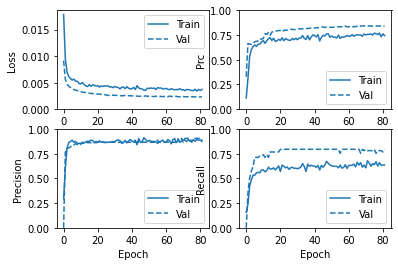

In [26]:
plot_metrics(baseline_history)

Note: That the validation curve generally performs better than the training curve. This is mainly caused by the fact that the dropout layer is not active when evaluating the model.

### Evaluate metrics

You can use a [confusion matrix](https://developers.google.com/machine-learning/glossary/#confusion_matrix) to summarize the actual vs. predicted labels, where the X axis is the predicted label and the Y axis is the actual label:

In [27]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

 1/90 [..............................] - ETA: 3s

52/90 [================>.............] - ETA: 0s

90/90 [==============================] - 0s 1ms/step


 1/28 [>.............................] - ETA: 0s

28/28 [==============================] - 0s 1ms/step


In [28]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

Evaluate your model on the test dataset and display the results for the metrics you created above:

loss :  0.002767325611785054
tp :  78.0
fp :  9.0
tn :  56857.0
fn :  18.0
accuracy :  0.9995260238647461
precision :  0.8965517282485962
recall :  0.8125
auc :  0.9475902915000916
prc :  0.847183108329773



Legitimate Transactions Detected (True Negatives):  56857
Legitimate Transactions Incorrectly Detected (False Positives):  9
Fraudulent Transactions Missed (False Negatives):  18
Fraudulent Transactions Detected (True Positives):  78
Total Fraudulent Transactions:  96


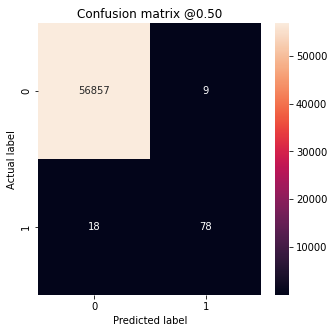

In [29]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

If the model had predicted everything perfectly, this would be a [diagonal matrix](https://en.wikipedia.org/wiki/Diagonal_matrix) where values off the main diagonal, indicating incorrect predictions, would be zero. In this case the matrix shows that you have relatively few false positives, meaning that there were relatively few legitimate transactions that were incorrectly flagged. However, you would likely want to have even fewer false negatives despite the cost of increasing the number of false positives. This trade off may be preferable because false negatives would allow fraudulent transactions to go through, whereas false positives may cause an email to be sent to a customer to ask them to verify their card activity.

### Plot the ROC

Now plot the [ROC](https://developers.google.com/machine-learning/glossary#ROC). This plot is useful because it shows, at a glance, the range of performance the model can reach just by tuning the output threshold.

In [30]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

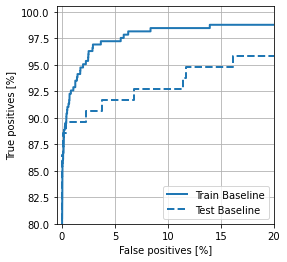

In [31]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

### Plot the AUPRC

Now plot the [AUPRC](https://developers.google.com/machine-learning/glossary?hl=en#PR_AUC). Area under the interpolated precision-recall curve, obtained by plotting (recall, precision) points for different values of the classification threshold. Depending on how it's calculated, PR AUC may be equivalent to the average precision of the model.


In [32]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

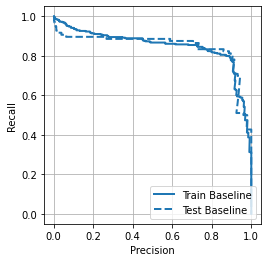

In [33]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

It looks like the precision is relatively high, but the recall and the area under the ROC curve (AUC) aren't as high as you might like. Classifiers often face challenges when trying to maximize both precision and recall, which is especially true when working with imbalanced datasets. It is important to consider the costs of different types of errors in the context of the problem you care about. In this example, a false negative (a fraudulent transaction is missed) may have a financial cost, while a false positive (a transaction is incorrectly flagged as fraudulent) may decrease user happiness.

## Class weights

### Calculate class weights

The goal is to identify fraudulent transactions, but you don't have very many of those positive samples to work with, so you would want to have the classifier heavily weight the few examples that are available. You can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.

In [34]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


### Train a model with class weights

Now try re-training and evaluating the model with class weights to see how that affects the predictions.

Note: Using `class_weights` changes the range of the loss. This may affect the stability of the training depending on the optimizer. Optimizers whose step size is dependent on the magnitude of the gradient, like `tf.keras.optimizers.SGD`, may fail. The optimizer used here, `tf.keras.optimizers.Adam`, is unaffected by the scaling change. Also note that because of the weighting, the total losses are not comparable between the two models.

In [35]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight) 

Epoch 1/100


 1/90 [..............................] - ETA: 2:26 - loss: 8.8530 - tp: 78.0000 - fp: 12.0000 - tn: 58897.0000 - fn: 23.0000 - accuracy: 0.9994 - precision: 0.8667 - recall: 0.7723 - auc: 0.9249 - prc: 0.7725

12/90 [===>..........................] - ETA: 0s - loss: 4.8163 - tp: 78.0000 - fp: 62.0000 - tn: 81343.0000 - fn: 55.0000 - accuracy: 0.9986 - precision: 0.5571 - recall: 0.5865 - auc: 0.8342 - prc: 0.4549  

23/90 [======>.......................] - ETA: 0s - loss: 4.1025 - tp: 78.0000 - fp: 109.0000 - tn: 103794.0000 - fn: 85.0000 - accuracy: 0.9981 - precision: 0.4171 - recall: 0.4785 - auc: 0.7761 - prc: 0.2972

34/90 [==========>...................] - ETA: 0s - loss: 4.4216 - tp: 79.0000 - fp: 162.0000 - tn: 126221.0000 - fn: 132.0000 - accuracy: 0.9977 - precision: 0.3278 - recall: 0.3744 - auc: 0.7255 - prc: 0.1935

45/90 [==============>...............] - ETA: 0s - loss: 3.8857 - tp: 80.0000 - fp: 215.0000 - tn: 148668.0000 - fn: 159.0000 - accuracy: 0.9975 - precision: 0.2712 - recall: 0.3347 - auc: 0.7148 - prc: 0.1528

56/90 [=================>............] - ETA: 0s - loss: 3.9993 - tp: 84.0000 - fp: 286.0000 - tn: 171068.0000 - fn: 212.0000 - accuracy: 0.9971 - precision: 0.2270 - recall: 0.2838 - auc: 0.7006 - prc: 0.1137

67/90 [=====================>........] - ETA: 0s - loss: 3.7182 - tp: 89.0000 - fp: 356.0000 - tn: 193488.0000 - fn: 245.0000 - accuracy: 0.9969 - precision: 0.2000 - recall: 0.2665 - auc: 0.7036 - prc: 0.1000

78/90 [=========================>....] - ETA: 0s - loss: 3.4872 - tp: 101.0000 - fp: 446.0000 - tn: 215883.0000 - fn: 276.0000 - accuracy: 0.9967 - precision: 0.1846 - recall: 0.2679 - auc: 0.7096 - prc: 0.0966

90/90 [==============================] - ETA: 0s - loss: 3.3363 - tp: 112.0000 - fp: 540.0000 - tn: 238279.0000 - fn: 307.0000 - accuracy: 0.9965 - precision: 0.1718 - recall: 0.2673 - auc: 0.7141 - prc: 0.0899

90/90 [==============================] - 3s 14ms/step - loss: 3.3363 - tp: 112.0000 - fp: 540.0000 - tn: 238279.0000 - fn: 307.0000 - accuracy: 0.9965 - precision: 0.1718 - recall: 0.2673 - auc: 0.7141 - prc: 0.0899 - val_loss: 0.0121 - val_tp: 23.0000 - val_fp: 71.0000 - val_tn: 45425.0000 - val_fn: 50.0000 - val_accuracy: 0.9973 - val_precision: 0.2447 - val_recall: 0.3151 - val_auc: 0.8876 - val_prc: 0.2189


Epoch 2/100


 1/90 [..............................] - ETA: 0s - loss: 2.6717 - tp: 2.0000 - fp: 5.0000 - tn: 2038.0000 - fn: 3.0000 - accuracy: 0.9961 - precision: 0.2857 - recall: 0.4000 - auc: 0.7491 - prc: 0.1225

12/90 [===>..........................] - ETA: 0s - loss: 2.3655 - tp: 19.0000 - fp: 120.0000 - tn: 24395.0000 - fn: 42.0000 - accuracy: 0.9934 - precision: 0.1367 - recall: 0.3115 - auc: 0.8226 - prc: 0.1150

23/90 [======>.......................] - ETA: 0s - loss: 1.7948 - tp: 30.0000 - fp: 240.0000 - tn: 46775.0000 - fn: 59.0000 - accuracy: 0.9937 - precision: 0.1111 - recall: 0.3371 - auc: 0.7936 - prc: 0.0911

35/90 [==========>...................] - ETA: 0s - loss: 1.6229 - tp: 39.0000 - fp: 368.0000 - tn: 71186.0000 - fn: 87.0000 - accuracy: 0.9937 - precision: 0.0958 - recall: 0.3095 - auc: 0.8100 - prc: 0.0781

47/90 [==============>...............] - ETA: 0s - loss: 1.5094 - tp: 66.0000 - fp: 492.0000 - tn: 95588.0000 - fn: 110.0000 - accuracy: 0.9937 - precision: 0.1183 - recall: 0.3750 - auc: 0.8314 - prc: 0.1025

58/90 [==================>...........] - ETA: 0s - loss: 1.3709 - tp: 86.0000 - fp: 623.0000 - tn: 117948.0000 - fn: 127.0000 - accuracy: 0.9937 - precision: 0.1213 - recall: 0.4038 - auc: 0.8466 - prc: 0.1240

70/90 [======================>.......] - ETA: 0s - loss: 1.2638 - tp: 110.0000 - fp: 766.0000 - tn: 142339.0000 - fn: 145.0000 - accuracy: 0.9936 - precision: 0.1256 - recall: 0.4314 - auc: 0.8598 - prc: 0.1449

81/90 [==========================>...] - ETA: 0s - loss: 1.2630 - tp: 131.0000 - fp: 919.0000 - tn: 164670.0000 - fn: 168.0000 - accuracy: 0.9934 - precision: 0.1248 - recall: 0.4381 - auc: 0.8560 - prc: 0.1480

90/90 [==============================] - 1s 6ms/step - loss: 1.2405 - tp: 141.0000 - fp: 1034.0000 - tn: 180919.0000 - fn: 182.0000 - accuracy: 0.9933 - precision: 0.1200 - recall: 0.4365 - auc: 0.8562 - prc: 0.1437 - val_loss: 0.0157 - val_tp: 48.0000 - val_fp: 124.0000 - val_tn: 45372.0000 - val_fn: 25.0000 - val_accuracy: 0.9967 - val_precision: 0.2791 - val_recall: 0.6575 - val_auc: 0.9392 - val_prc: 0.4586


Epoch 3/100


 1/90 [..............................] - ETA: 0s - loss: 1.5700 - tp: 1.0000 - fp: 14.0000 - tn: 2030.0000 - fn: 3.0000 - accuracy: 0.9917 - precision: 0.0667 - recall: 0.2500 - auc: 0.7628 - prc: 0.1065

12/90 [===>..........................] - ETA: 0s - loss: 0.8172 - tp: 21.0000 - fp: 190.0000 - tn: 24346.0000 - fn: 19.0000 - accuracy: 0.9915 - precision: 0.0995 - recall: 0.5250 - auc: 0.8775 - prc: 0.1879

24/90 [=======>......................] - ETA: 0s - loss: 0.6621 - tp: 38.0000 - fp: 366.0000 - tn: 48720.0000 - fn: 28.0000 - accuracy: 0.9920 - precision: 0.0941 - recall: 0.5758 - auc: 0.8761 - prc: 0.1781

35/90 [==========>...................] - ETA: 0s - loss: 0.7358 - tp: 63.0000 - fp: 545.0000 - tn: 71031.0000 - fn: 41.0000 - accuracy: 0.9918 - precision: 0.1036 - recall: 0.6058 - auc: 0.8772 - prc: 0.1723

46/90 [==============>...............] - ETA: 0s - loss: 0.7714 - tp: 94.0000 - fp: 711.0000 - tn: 93346.0000 - fn: 57.0000 - accuracy: 0.9918 - precision: 0.1168 - recall: 0.6225 - auc: 0.8837 - prc: 0.1927

58/90 [==================>...........] - ETA: 0s - loss: 0.8003 - tp: 126.0000 - fp: 928.0000 - tn: 117656.0000 - fn: 74.0000 - accuracy: 0.9916 - precision: 0.1195 - recall: 0.6300 - auc: 0.8891 - prc: 0.1858

70/90 [======================>.......] - ETA: 0s - loss: 0.8451 - tp: 155.0000 - fp: 1125.0000 - tn: 141987.0000 - fn: 93.0000 - accuracy: 0.9915 - precision: 0.1211 - recall: 0.6250 - auc: 0.8803 - prc: 0.1899

81/90 [==========================>...] - ETA: 0s - loss: 0.8473 - tp: 180.0000 - fp: 1331.0000 - tn: 164264.0000 - fn: 113.0000 - accuracy: 0.9913 - precision: 0.1191 - recall: 0.6143 - auc: 0.8866 - prc: 0.1911

90/90 [==============================] - 1s 6ms/step - loss: 0.8540 - tp: 198.0000 - fp: 1492.0000 - tn: 180461.0000 - fn: 125.0000 - accuracy: 0.9911 - precision: 0.1172 - recall: 0.6130 - auc: 0.8861 - prc: 0.1848 - val_loss: 0.0216 - val_tp: 59.0000 - val_fp: 184.0000 - val_tn: 45312.0000 - val_fn: 14.0000 - val_accuracy: 0.9957 - val_precision: 0.2428 - val_recall: 0.8082 - val_auc: 0.9582 - val_prc: 0.5453


Epoch 4/100


 1/90 [..............................] - ETA: 0s - loss: 0.4131 - tp: 3.0000 - fp: 24.0000 - tn: 2020.0000 - fn: 1.0000 - accuracy: 0.9878 - precision: 0.1111 - recall: 0.7500 - auc: 0.9857 - prc: 0.2205

12/90 [===>..........................] - ETA: 0s - loss: 0.8246 - tp: 33.0000 - fp: 257.0000 - tn: 24272.0000 - fn: 14.0000 - accuracy: 0.9890 - precision: 0.1138 - recall: 0.7021 - auc: 0.9016 - prc: 0.2483

23/90 [======>.......................] - ETA: 0s - loss: 0.5790 - tp: 53.0000 - fp: 515.0000 - tn: 46516.0000 - fn: 20.0000 - accuracy: 0.9886 - precision: 0.0933 - recall: 0.7260 - auc: 0.9109 - prc: 0.2478

35/90 [==========>...................] - ETA: 0s - loss: 0.6472 - tp: 80.0000 - fp: 793.0000 - tn: 70770.0000 - fn: 37.0000 - accuracy: 0.9884 - precision: 0.0916 - recall: 0.6838 - auc: 0.9046 - prc: 0.2221

46/90 [==============>...............] - ETA: 0s - loss: 0.6108 - tp: 103.0000 - fp: 1042.0000 - tn: 93015.0000 - fn: 48.0000 - accuracy: 0.9884 - precision: 0.0900 - recall: 0.6821 - auc: 0.9114 - prc: 0.2115

58/90 [==================>...........] - ETA: 0s - loss: 0.6191 - tp: 138.0000 - fp: 1341.0000 - tn: 117245.0000 - fn: 60.0000 - accuracy: 0.9882 - precision: 0.0933 - recall: 0.6970 - auc: 0.9089 - prc: 0.2256

69/90 [======================>.......] - ETA: 0s - loss: 0.6809 - tp: 168.0000 - fp: 1603.0000 - tn: 139464.0000 - fn: 77.0000 - accuracy: 0.9881 - precision: 0.0949 - recall: 0.6857 - auc: 0.9002 - prc: 0.2233

80/90 [=========================>....] - ETA: 0s - loss: 0.6991 - tp: 198.0000 - fp: 1917.0000 - tn: 161631.0000 - fn: 94.0000 - accuracy: 0.9877 - precision: 0.0936 - recall: 0.6781 - auc: 0.9011 - prc: 0.2261

90/90 [==============================] - 1s 6ms/step - loss: 0.6551 - tp: 225.0000 - fp: 2166.0000 - tn: 179787.0000 - fn: 98.0000 - accuracy: 0.9876 - precision: 0.0941 - recall: 0.6966 - auc: 0.9086 - prc: 0.2311 - val_loss: 0.0281 - val_tp: 62.0000 - val_fp: 235.0000 - val_tn: 45261.0000 - val_fn: 11.0000 - val_accuracy: 0.9946 - val_precision: 0.2088 - val_recall: 0.8493 - val_auc: 0.9627 - val_prc: 0.5504


Epoch 5/100


 1/90 [..............................] - ETA: 0s - loss: 0.0316 - tp: 1.0000 - fp: 27.0000 - tn: 2020.0000 - fn: 0.0000e+00 - accuracy: 0.9868 - precision: 0.0357 - recall: 1.0000 - auc: 0.9978 - prc: 0.0945

12/90 [===>..........................] - ETA: 0s - loss: 0.4785 - tp: 28.0000 - fp: 350.0000 - tn: 24188.0000 - fn: 10.0000 - accuracy: 0.9854 - precision: 0.0741 - recall: 0.7368 - auc: 0.9293 - prc: 0.2261

23/90 [======>.......................] - ETA: 0s - loss: 0.6014 - tp: 55.0000 - fp: 665.0000 - tn: 46360.0000 - fn: 24.0000 - accuracy: 0.9854 - precision: 0.0764 - recall: 0.6962 - auc: 0.9129 - prc: 0.1939

34/90 [==========>...................] - ETA: 0s - loss: 0.5168 - tp: 85.0000 - fp: 992.0000 - tn: 68522.0000 - fn: 33.0000 - accuracy: 0.9853 - precision: 0.0789 - recall: 0.7203 - auc: 0.9327 - prc: 0.2103

45/90 [==============>...............] - ETA: 0s - loss: 0.4970 - tp: 117.0000 - fp: 1355.0000 - tn: 90647.0000 - fn: 41.0000 - accuracy: 0.9849 - precision: 0.0795 - recall: 0.7405 - auc: 0.9339 - prc: 0.2193

56/90 [=================>............] - ETA: 0s - loss: 0.4781 - tp: 145.0000 - fp: 1743.0000 - tn: 112752.0000 - fn: 48.0000 - accuracy: 0.9844 - precision: 0.0768 - recall: 0.7513 - auc: 0.9332 - prc: 0.2136

67/90 [=====================>........] - ETA: 0s - loss: 0.4921 - tp: 177.0000 - fp: 2147.0000 - tn: 134835.0000 - fn: 57.0000 - accuracy: 0.9839 - precision: 0.0762 - recall: 0.7564 - auc: 0.9282 - prc: 0.2170

78/90 [=========================>....] - ETA: 0s - loss: 0.4917 - tp: 212.0000 - fp: 2571.0000 - tn: 156894.0000 - fn: 67.0000 - accuracy: 0.9835 - precision: 0.0762 - recall: 0.7599 - auc: 0.9300 - prc: 0.2186

89/90 [============================>.] - ETA: 0s - loss: 0.5006 - tp: 247.0000 - fp: 2986.0000 - tn: 178963.0000 - fn: 76.0000 - accuracy: 0.9832 - precision: 0.0764 - recall: 0.7647 - auc: 0.9274 - prc: 0.2182

90/90 [==============================] - 1s 6ms/step - loss: 0.5006 - tp: 247.0000 - fp: 2986.0000 - tn: 178967.0000 - fn: 76.0000 - accuracy: 0.9832 - precision: 0.0764 - recall: 0.7647 - auc: 0.9274 - prc: 0.2182 - val_loss: 0.0367 - val_tp: 64.0000 - val_fp: 356.0000 - val_tn: 45140.0000 - val_fn: 9.0000 - val_accuracy: 0.9920 - val_precision: 0.1524 - val_recall: 0.8767 - val_auc: 0.9676 - val_prc: 0.5536


Epoch 6/100


 1/90 [..............................] - ETA: 0s - loss: 0.9662 - tp: 1.0000 - fp: 39.0000 - tn: 2007.0000 - fn: 1.0000 - accuracy: 0.9805 - precision: 0.0250 - recall: 0.5000 - auc: 0.6197 - prc: 0.0838

12/90 [===>..........................] - ETA: 0s - loss: 0.3177 - tp: 34.0000 - fp: 484.0000 - tn: 24053.0000 - fn: 5.0000 - accuracy: 0.9801 - precision: 0.0656 - recall: 0.8718 - auc: 0.9514 - prc: 0.2428

23/90 [======>.......................] - ETA: 0s - loss: 0.4181 - tp: 62.0000 - fp: 936.0000 - tn: 46090.0000 - fn: 16.0000 - accuracy: 0.9798 - precision: 0.0621 - recall: 0.7949 - auc: 0.9427 - prc: 0.2058

34/90 [==========>...................] - ETA: 0s - loss: 0.4446 - tp: 102.0000 - fp: 1406.0000 - tn: 68098.0000 - fn: 26.0000 - accuracy: 0.9794 - precision: 0.0676 - recall: 0.7969 - auc: 0.9367 - prc: 0.2161

46/90 [==============>...............] - ETA: 0s - loss: 0.4344 - tp: 134.0000 - fp: 1884.0000 - tn: 92156.0000 - fn: 34.0000 - accuracy: 0.9796 - precision: 0.0664 - recall: 0.7976 - auc: 0.9361 - prc: 0.2065

57/90 [==================>...........] - ETA: 0s - loss: 0.4704 - tp: 170.0000 - fp: 2366.0000 - tn: 114155.0000 - fn: 45.0000 - accuracy: 0.9793 - precision: 0.0670 - recall: 0.7907 - auc: 0.9314 - prc: 0.2131

68/90 [=====================>........] - ETA: 0s - loss: 0.5486 - tp: 201.0000 - fp: 2868.0000 - tn: 136133.0000 - fn: 62.0000 - accuracy: 0.9790 - precision: 0.0655 - recall: 0.7643 - auc: 0.9196 - prc: 0.2062

79/90 [=========================>....] - ETA: 0s - loss: 0.5066 - tp: 224.0000 - fp: 3363.0000 - tn: 158138.0000 - fn: 67.0000 - accuracy: 0.9788 - precision: 0.0624 - recall: 0.7698 - auc: 0.9240 - prc: 0.2007

90/90 [==============================] - ETA: 0s - loss: 0.4861 - tp: 250.0000 - fp: 3848.0000 - tn: 178105.0000 - fn: 73.0000 - accuracy: 0.9785 - precision: 0.0610 - recall: 0.7740 - auc: 0.9276 - prc: 0.1976

90/90 [==============================] - 1s 6ms/step - loss: 0.4861 - tp: 250.0000 - fp: 3848.0000 - tn: 178105.0000 - fn: 73.0000 - accuracy: 0.9785 - precision: 0.0610 - recall: 0.7740 - auc: 0.9276 - prc: 0.1976 - val_loss: 0.0454 - val_tp: 64.0000 - val_fp: 507.0000 - val_tn: 44989.0000 - val_fn: 9.0000 - val_accuracy: 0.9887 - val_precision: 0.1121 - val_recall: 0.8767 - val_auc: 0.9736 - val_prc: 0.5522


Epoch 7/100


 1/90 [..............................] - ETA: 0s - loss: 0.5128 - tp: 1.0000 - fp: 48.0000 - tn: 1998.0000 - fn: 1.0000 - accuracy: 0.9761 - precision: 0.0204 - recall: 0.5000 - auc: 0.9163 - prc: 0.0736

12/90 [===>..........................] - ETA: 0s - loss: 0.3780 - tp: 39.0000 - fp: 588.0000 - tn: 23941.0000 - fn: 8.0000 - accuracy: 0.9757 - precision: 0.0622 - recall: 0.8298 - auc: 0.9558 - prc: 0.1966

23/90 [======>.......................] - ETA: 0s - loss: 0.4419 - tp: 64.0000 - fp: 1153.0000 - tn: 45869.0000 - fn: 18.0000 - accuracy: 0.9751 - precision: 0.0526 - recall: 0.7805 - auc: 0.9291 - prc: 0.1679

34/90 [==========>...................] - ETA: 0s - loss: 0.3836 - tp: 92.0000 - fp: 1724.0000 - tn: 67793.0000 - fn: 23.0000 - accuracy: 0.9749 - precision: 0.0507 - recall: 0.8000 - auc: 0.9336 - prc: 0.1700

45/90 [==============>...............] - ETA: 0s - loss: 0.3834 - tp: 129.0000 - fp: 2255.0000 - tn: 89747.0000 - fn: 29.0000 - accuracy: 0.9752 - precision: 0.0541 - recall: 0.8165 - auc: 0.9351 - prc: 0.1938

56/90 [=================>............] - ETA: 0s - loss: 0.3603 - tp: 171.0000 - fp: 2800.0000 - tn: 111684.0000 - fn: 33.0000 - accuracy: 0.9753 - precision: 0.0576 - recall: 0.8382 - auc: 0.9425 - prc: 0.1998

67/90 [=====================>........] - ETA: 0s - loss: 0.3801 - tp: 199.0000 - fp: 3408.0000 - tn: 133568.0000 - fn: 41.0000 - accuracy: 0.9749 - precision: 0.0552 - recall: 0.8292 - auc: 0.9396 - prc: 0.1943

78/90 [=========================>....] - ETA: 0s - loss: 0.3902 - tp: 228.0000 - fp: 3967.0000 - tn: 155498.0000 - fn: 51.0000 - accuracy: 0.9748 - precision: 0.0544 - recall: 0.8172 - auc: 0.9393 - prc: 0.1929

88/90 [============================>.] - ETA: 0s - loss: 0.4146 - tp: 258.0000 - fp: 4542.0000 - tn: 175362.0000 - fn: 62.0000 - accuracy: 0.9745 - precision: 0.0538 - recall: 0.8062 - auc: 0.9353 - prc: 0.1958

90/90 [==============================] - 1s 6ms/step - loss: 0.4173 - tp: 260.0000 - fp: 4601.0000 - tn: 177352.0000 - fn: 63.0000 - accuracy: 0.9744 - precision: 0.0535 - recall: 0.8050 - auc: 0.9349 - prc: 0.1939 - val_loss: 0.0533 - val_tp: 65.0000 - val_fp: 622.0000 - val_tn: 44874.0000 - val_fn: 8.0000 - val_accuracy: 0.9862 - val_precision: 0.0946 - val_recall: 0.8904 - val_auc: 0.9757 - val_prc: 0.5307


Epoch 8/100


 1/90 [..............................] - ETA: 0s - loss: 0.0548 - tp: 3.0000 - fp: 51.0000 - tn: 1994.0000 - fn: 0.0000e+00 - accuracy: 0.9751 - precision: 0.0556 - recall: 1.0000 - auc: 0.9970 - prc: 0.2221

12/90 [===>..........................] - ETA: 0s - loss: 0.3938 - tp: 28.0000 - fp: 685.0000 - tn: 23855.0000 - fn: 8.0000 - accuracy: 0.9718 - precision: 0.0393 - recall: 0.7778 - auc: 0.9289 - prc: 0.1271 

23/90 [======>.......................] - ETA: 0s - loss: 0.3990 - tp: 60.0000 - fp: 1350.0000 - tn: 45680.0000 - fn: 14.0000 - accuracy: 0.9710 - precision: 0.0426 - recall: 0.8108 - auc: 0.9237 - prc: 0.1527

34/90 [==========>...................] - ETA: 0s - loss: 0.4789 - tp: 89.0000 - fp: 1964.0000 - tn: 67554.0000 - fn: 25.0000 - accuracy: 0.9714 - precision: 0.0434 - recall: 0.7807 - auc: 0.9095 - prc: 0.1533

45/90 [==============>...............] - ETA: 0s - loss: 0.4842 - tp: 134.0000 - fp: 2642.0000 - tn: 89352.0000 - fn: 32.0000 - accuracy: 0.9710 - precision: 0.0483 - recall: 0.8072 - auc: 0.9155 - prc: 0.1815

56/90 [=================>............] - ETA: 0s - loss: 0.5242 - tp: 166.0000 - fp: 3354.0000 - tn: 111125.0000 - fn: 43.0000 - accuracy: 0.9704 - precision: 0.0472 - recall: 0.7943 - auc: 0.9068 - prc: 0.1766

67/90 [=====================>........] - ETA: 0s - loss: 0.4990 - tp: 197.0000 - fp: 3977.0000 - tn: 132992.0000 - fn: 50.0000 - accuracy: 0.9707 - precision: 0.0472 - recall: 0.7976 - auc: 0.9131 - prc: 0.1769

78/90 [=========================>....] - ETA: 0s - loss: 0.4676 - tp: 231.0000 - fp: 4693.0000 - tn: 154764.0000 - fn: 56.0000 - accuracy: 0.9703 - precision: 0.0469 - recall: 0.8049 - auc: 0.9200 - prc: 0.1774

89/90 [============================>.] - ETA: 0s - loss: 0.4603 - tp: 258.0000 - fp: 5399.0000 - tn: 176550.0000 - fn: 65.0000 - accuracy: 0.9700 - precision: 0.0456 - recall: 0.7988 - auc: 0.9225 - prc: 0.1723

90/90 [==============================] - 1s 6ms/step - loss: 0.4603 - tp: 258.0000 - fp: 5399.0000 - tn: 176554.0000 - fn: 65.0000 - accuracy: 0.9700 - precision: 0.0456 - recall: 0.7988 - auc: 0.9225 - prc: 0.1723 - val_loss: 0.0617 - val_tp: 65.0000 - val_fp: 728.0000 - val_tn: 44768.0000 - val_fn: 8.0000 - val_accuracy: 0.9838 - val_precision: 0.0820 - val_recall: 0.8904 - val_auc: 0.9811 - val_prc: 0.5223


Epoch 9/100


 1/90 [..............................] - ETA: 0s - loss: 0.4797 - tp: 6.0000 - fp: 56.0000 - tn: 1985.0000 - fn: 1.0000 - accuracy: 0.9722 - precision: 0.0968 - recall: 0.8571 - auc: 0.9745 - prc: 0.4312

12/90 [===>..........................] - ETA: 0s - loss: 0.4010 - tp: 35.0000 - fp: 795.0000 - tn: 23736.0000 - fn: 10.0000 - accuracy: 0.9672 - precision: 0.0422 - recall: 0.7778 - auc: 0.9484 - prc: 0.1462

23/90 [======>.......................] - ETA: 0s - loss: 0.3421 - tp: 65.0000 - fp: 1524.0000 - tn: 45499.0000 - fn: 16.0000 - accuracy: 0.9673 - precision: 0.0409 - recall: 0.8025 - auc: 0.9578 - prc: 0.1417

35/90 [==========>...................] - ETA: 0s - loss: 0.3566 - tp: 100.0000 - fp: 2325.0000 - tn: 69229.0000 - fn: 26.0000 - accuracy: 0.9672 - precision: 0.0412 - recall: 0.7937 - auc: 0.9546 - prc: 0.1505

46/90 [==============>...............] - ETA: 0s - loss: 0.3629 - tp: 128.0000 - fp: 3116.0000 - tn: 90930.0000 - fn: 34.0000 - accuracy: 0.9666 - precision: 0.0395 - recall: 0.7901 - auc: 0.9507 - prc: 0.1510

57/90 [==================>...........] - ETA: 0s - loss: 0.3969 - tp: 152.0000 - fp: 3910.0000 - tn: 112630.0000 - fn: 44.0000 - accuracy: 0.9661 - precision: 0.0374 - recall: 0.7755 - auc: 0.9420 - prc: 0.1422

68/90 [=====================>........] - ETA: 0s - loss: 0.3780 - tp: 184.0000 - fp: 4680.0000 - tn: 134350.0000 - fn: 50.0000 - accuracy: 0.9660 - precision: 0.0378 - recall: 0.7863 - auc: 0.9459 - prc: 0.1476

80/90 [=========================>....] - ETA: 0s - loss: 0.3837 - tp: 223.0000 - fp: 5557.0000 - tn: 158002.0000 - fn: 58.0000 - accuracy: 0.9657 - precision: 0.0386 - recall: 0.7936 - auc: 0.9439 - prc: 0.1517

90/90 [==============================] - 1s 6ms/step - loss: 0.3903 - tp: 260.0000 - fp: 6230.0000 - tn: 175723.0000 - fn: 63.0000 - accuracy: 0.9655 - precision: 0.0401 - recall: 0.8050 - auc: 0.9424 - prc: 0.1609 - val_loss: 0.0720 - val_tp: 65.0000 - val_fp: 852.0000 - val_tn: 44644.0000 - val_fn: 8.0000 - val_accuracy: 0.9811 - val_precision: 0.0709 - val_recall: 0.8904 - val_auc: 0.9822 - val_prc: 0.5203


Epoch 10/100


 1/90 [..............................] - ETA: 0s - loss: 0.3945 - tp: 2.0000 - fp: 63.0000 - tn: 1982.0000 - fn: 1.0000 - accuracy: 0.9688 - precision: 0.0308 - recall: 0.6667 - auc: 0.9571 - prc: 0.0570

12/90 [===>..........................] - ETA: 0s - loss: 0.4106 - tp: 39.0000 - fp: 852.0000 - tn: 23676.0000 - fn: 9.0000 - accuracy: 0.9650 - precision: 0.0438 - recall: 0.8125 - auc: 0.9385 - prc: 0.1599

24/90 [=======>......................] - ETA: 0s - loss: 0.3767 - tp: 80.0000 - fp: 1722.0000 - tn: 47336.0000 - fn: 14.0000 - accuracy: 0.9647 - precision: 0.0444 - recall: 0.8511 - auc: 0.9359 - prc: 0.1810

35/90 [==========>...................] - ETA: 0s - loss: 0.4075 - tp: 109.0000 - fp: 2507.0000 - tn: 69040.0000 - fn: 24.0000 - accuracy: 0.9647 - precision: 0.0417 - recall: 0.8195 - auc: 0.9345 - prc: 0.1663

46/90 [==============>...............] - ETA: 0s - loss: 0.3849 - tp: 145.0000 - fp: 3334.0000 - tn: 90699.0000 - fn: 30.0000 - accuracy: 0.9643 - precision: 0.0417 - recall: 0.8286 - auc: 0.9382 - prc: 0.1685

57/90 [==================>...........] - ETA: 0s - loss: 0.3456 - tp: 170.0000 - fp: 4118.0000 - tn: 112416.0000 - fn: 32.0000 - accuracy: 0.9644 - precision: 0.0396 - recall: 0.8416 - auc: 0.9411 - prc: 0.1647

68/90 [=====================>........] - ETA: 0s - loss: 0.3629 - tp: 204.0000 - fp: 4977.0000 - tn: 134042.0000 - fn: 41.0000 - accuracy: 0.9640 - precision: 0.0394 - recall: 0.8327 - auc: 0.9389 - prc: 0.1660

79/90 [=========================>....] - ETA: 0s - loss: 0.3542 - tp: 239.0000 - fp: 5813.0000 - tn: 155694.0000 - fn: 46.0000 - accuracy: 0.9638 - precision: 0.0395 - recall: 0.8386 - auc: 0.9421 - prc: 0.1728

90/90 [==============================] - ETA: 0s - loss: 0.3662 - tp: 270.0000 - fp: 6567.0000 - tn: 175386.0000 - fn: 53.0000 - accuracy: 0.9637 - precision: 0.0395 - recall: 0.8359 - auc: 0.9400 - prc: 0.1673

90/90 [==============================] - 1s 6ms/step - loss: 0.3662 - tp: 270.0000 - fp: 6567.0000 - tn: 175386.0000 - fn: 53.0000 - accuracy: 0.9637 - precision: 0.0395 - recall: 0.8359 - auc: 0.9400 - prc: 0.1673 - val_loss: 0.0744 - val_tp: 65.0000 - val_fp: 870.0000 - val_tn: 44626.0000 - val_fn: 8.0000 - val_accuracy: 0.9807 - val_precision: 0.0695 - val_recall: 0.8904 - val_auc: 0.9828 - val_prc: 0.5165


Epoch 11/100


 1/90 [..............................] - ETA: 0s - loss: 0.0773 - tp: 2.0000 - fp: 77.0000 - tn: 1969.0000 - fn: 0.0000e+00 - accuracy: 0.9624 - precision: 0.0253 - recall: 1.0000 - auc: 0.9968 - prc: 0.1364

12/90 [===>..........................] - ETA: 0s - loss: 0.3092 - tp: 27.0000 - fp: 944.0000 - tn: 23599.0000 - fn: 6.0000 - accuracy: 0.9613 - precision: 0.0278 - recall: 0.8182 - auc: 0.9383 - prc: 0.1132 

23/90 [======>.......................] - ETA: 0s - loss: 0.4566 - tp: 60.0000 - fp: 1799.0000 - tn: 45230.0000 - fn: 15.0000 - accuracy: 0.9615 - precision: 0.0323 - recall: 0.8000 - auc: 0.9027 - prc: 0.1368

34/90 [==========>...................] - ETA: 0s - loss: 0.4714 - tp: 90.0000 - fp: 2668.0000 - tn: 66847.0000 - fn: 27.0000 - accuracy: 0.9613 - precision: 0.0326 - recall: 0.7692 - auc: 0.9134 - prc: 0.1330

45/90 [==============>...............] - ETA: 0s - loss: 0.4410 - tp: 129.0000 - fp: 3505.0000 - tn: 88494.0000 - fn: 32.0000 - accuracy: 0.9616 - precision: 0.0355 - recall: 0.8012 - auc: 0.9229 - prc: 0.1556

56/90 [=================>............] - ETA: 0s - loss: 0.4030 - tp: 163.0000 - fp: 4422.0000 - tn: 110067.0000 - fn: 36.0000 - accuracy: 0.9611 - precision: 0.0356 - recall: 0.8191 - auc: 0.9310 - prc: 0.1608

67/90 [=====================>........] - ETA: 0s - loss: 0.3878 - tp: 202.0000 - fp: 5272.0000 - tn: 131700.0000 - fn: 42.0000 - accuracy: 0.9613 - precision: 0.0369 - recall: 0.8279 - auc: 0.9357 - prc: 0.1661

78/90 [=========================>....] - ETA: 0s - loss: 0.3863 - tp: 237.0000 - fp: 6174.0000 - tn: 153285.0000 - fn: 48.0000 - accuracy: 0.9611 - precision: 0.0370 - recall: 0.8316 - auc: 0.9345 - prc: 0.1659

90/90 [==============================] - ETA: 0s - loss: 0.3496 - tp: 274.0000 - fp: 7039.0000 - tn: 174914.0000 - fn: 49.0000 - accuracy: 0.9611 - precision: 0.0375 - recall: 0.8483 - auc: 0.9415 - prc: 0.1715

90/90 [==============================] - 1s 6ms/step - loss: 0.3496 - tp: 274.0000 - fp: 7039.0000 - tn: 174914.0000 - fn: 49.0000 - accuracy: 0.9611 - precision: 0.0375 - recall: 0.8483 - auc: 0.9415 - prc: 0.1715 - val_loss: 0.0760 - val_tp: 65.0000 - val_fp: 881.0000 - val_tn: 44615.0000 - val_fn: 8.0000 - val_accuracy: 0.9805 - val_precision: 0.0687 - val_recall: 0.8904 - val_auc: 0.9830 - val_prc: 0.5239


Epoch 12/100


 1/90 [..............................] - ETA: 0s - loss: 0.1004 - tp: 7.0000 - fp: 84.0000 - tn: 1957.0000 - fn: 0.0000e+00 - accuracy: 0.9590 - precision: 0.0769 - recall: 1.0000 - auc: 0.9947 - prc: 0.2733

12/90 [===>..........................] - ETA: 0s - loss: 0.3497 - tp: 41.0000 - fp: 937.0000 - tn: 23593.0000 - fn: 5.0000 - accuracy: 0.9617 - precision: 0.0419 - recall: 0.8913 - auc: 0.9394 - prc: 0.1805 

24/90 [=======>......................] - ETA: 0s - loss: 0.3148 - tp: 77.0000 - fp: 1842.0000 - tn: 47223.0000 - fn: 10.0000 - accuracy: 0.9623 - precision: 0.0401 - recall: 0.8851 - auc: 0.9481 - prc: 0.1703

35/90 [==========>...................] - ETA: 0s - loss: 0.3245 - tp: 115.0000 - fp: 2722.0000 - tn: 68826.0000 - fn: 17.0000 - accuracy: 0.9618 - precision: 0.0405 - recall: 0.8712 - auc: 0.9479 - prc: 0.1766

46/90 [==============>...............] - ETA: 0s - loss: 0.3626 - tp: 150.0000 - fp: 3600.0000 - tn: 90430.0000 - fn: 28.0000 - accuracy: 0.9615 - precision: 0.0400 - recall: 0.8427 - auc: 0.9444 - prc: 0.1769

57/90 [==================>...........] - ETA: 0s - loss: 0.3863 - tp: 174.0000 - fp: 4481.0000 - tn: 112047.0000 - fn: 34.0000 - accuracy: 0.9613 - precision: 0.0374 - recall: 0.8365 - auc: 0.9311 - prc: 0.1711

68/90 [=====================>........] - ETA: 0s - loss: 0.3783 - tp: 201.0000 - fp: 5321.0000 - tn: 133702.0000 - fn: 40.0000 - accuracy: 0.9615 - precision: 0.0364 - recall: 0.8340 - auc: 0.9313 - prc: 0.1662

79/90 [=========================>....] - ETA: 0s - loss: 0.3806 - tp: 234.0000 - fp: 6183.0000 - tn: 155328.0000 - fn: 47.0000 - accuracy: 0.9615 - precision: 0.0365 - recall: 0.8327 - auc: 0.9315 - prc: 0.1672

90/90 [==============================] - ETA: 0s - loss: 0.4208 - tp: 264.0000 - fp: 6923.0000 - tn: 175030.0000 - fn: 59.0000 - accuracy: 0.9617 - precision: 0.0367 - recall: 0.8173 - auc: 0.9244 - prc: 0.1632

90/90 [==============================] - 1s 6ms/step - loss: 0.4208 - tp: 264.0000 - fp: 6923.0000 - tn: 175030.0000 - fn: 59.0000 - accuracy: 0.9617 - precision: 0.0367 - recall: 0.8173 - auc: 0.9244 - prc: 0.1632 - val_loss: 0.0788 - val_tp: 65.0000 - val_fp: 905.0000 - val_tn: 44591.0000 - val_fn: 8.0000 - val_accuracy: 0.9800 - val_precision: 0.0670 - val_recall: 0.8904 - val_auc: 0.9837 - val_prc: 0.5425


Epoch 13/100


 1/90 [..............................] - ETA: 0s - loss: 0.0685 - tp: 3.0000 - fp: 68.0000 - tn: 1977.0000 - fn: 0.0000e+00 - accuracy: 0.9668 - precision: 0.0423 - recall: 1.0000 - auc: 0.9969 - prc: 0.1877

12/90 [===>..........................] - ETA: 0s - loss: 0.1994 - tp: 36.0000 - fp: 931.0000 - tn: 23605.0000 - fn: 4.0000 - accuracy: 0.9620 - precision: 0.0372 - recall: 0.9000 - auc: 0.9768 - prc: 0.1834 

24/90 [=======>......................] - ETA: 0s - loss: 0.4845 - tp: 71.0000 - fp: 1874.0000 - tn: 47190.0000 - fn: 17.0000 - accuracy: 0.9615 - precision: 0.0365 - recall: 0.8068 - auc: 0.9106 - prc: 0.1520

35/90 [==========>...................] - ETA: 0s - loss: 0.4380 - tp: 106.0000 - fp: 2757.0000 - tn: 68793.0000 - fn: 24.0000 - accuracy: 0.9612 - precision: 0.0370 - recall: 0.8154 - auc: 0.9226 - prc: 0.1585

46/90 [==============>...............] - ETA: 0s - loss: 0.4109 - tp: 135.0000 - fp: 3673.0000 - tn: 90371.0000 - fn: 29.0000 - accuracy: 0.9607 - precision: 0.0355 - recall: 0.8232 - auc: 0.9250 - prc: 0.1588

57/90 [==================>...........] - ETA: 0s - loss: 0.3848 - tp: 175.0000 - fp: 4641.0000 - tn: 111887.0000 - fn: 33.0000 - accuracy: 0.9600 - precision: 0.0363 - recall: 0.8413 - auc: 0.9340 - prc: 0.1606

68/90 [=====================>........] - ETA: 0s - loss: 0.3847 - tp: 205.0000 - fp: 5540.0000 - tn: 133479.0000 - fn: 40.0000 - accuracy: 0.9599 - precision: 0.0357 - recall: 0.8367 - auc: 0.9341 - prc: 0.1555

80/90 [=========================>....] - ETA: 0s - loss: 0.3539 - tp: 247.0000 - fp: 6537.0000 - tn: 157014.0000 - fn: 42.0000 - accuracy: 0.9598 - precision: 0.0364 - recall: 0.8547 - auc: 0.9402 - prc: 0.1617

90/90 [==============================] - 1s 6ms/step - loss: 0.3524 - tp: 274.0000 - fp: 7253.0000 - tn: 174700.0000 - fn: 49.0000 - accuracy: 0.9599 - precision: 0.0364 - recall: 0.8483 - auc: 0.9415 - prc: 0.1615 - val_loss: 0.0842 - val_tp: 65.0000 - val_fp: 956.0000 - val_tn: 44540.0000 - val_fn: 8.0000 - val_accuracy: 0.9788 - val_precision: 0.0637 - val_recall: 0.8904 - val_auc: 0.9837 - val_prc: 0.5044


Epoch 14/100


 1/90 [..............................] - ETA: 0s - loss: 0.0796 - tp: 4.0000 - fp: 85.0000 - tn: 1959.0000 - fn: 0.0000e+00 - accuracy: 0.9585 - precision: 0.0449 - recall: 1.0000 - auc: 0.9971 - prc: 0.2500

12/90 [===>..........................] - ETA: 0s - loss: 0.4693 - tp: 33.0000 - fp: 969.0000 - tn: 23564.0000 - fn: 10.0000 - accuracy: 0.9602 - precision: 0.0329 - recall: 0.7674 - auc: 0.9193 - prc: 0.1513

23/90 [======>.......................] - ETA: 0s - loss: 0.3747 - tp: 75.0000 - fp: 1902.0000 - tn: 45112.0000 - fn: 15.0000 - accuracy: 0.9593 - precision: 0.0379 - recall: 0.8333 - auc: 0.9424 - prc: 0.1720

34/90 [==========>...................] - ETA: 0s - loss: 0.3218 - tp: 106.0000 - fp: 2867.0000 - tn: 66640.0000 - fn: 19.0000 - accuracy: 0.9586 - precision: 0.0357 - recall: 0.8480 - auc: 0.9524 - prc: 0.1660

45/90 [==============>...............] - ETA: 0s - loss: 0.2932 - tp: 137.0000 - fp: 3804.0000 - tn: 88197.0000 - fn: 22.0000 - accuracy: 0.9585 - precision: 0.0348 - recall: 0.8616 - auc: 0.9567 - prc: 0.1608

57/90 [==================>...........] - ETA: 0s - loss: 0.3035 - tp: 176.0000 - fp: 4790.0000 - tn: 111741.0000 - fn: 29.0000 - accuracy: 0.9587 - precision: 0.0354 - recall: 0.8585 - auc: 0.9551 - prc: 0.1636

68/90 [=====================>........] - ETA: 0s - loss: 0.2989 - tp: 198.0000 - fp: 5703.0000 - tn: 133329.0000 - fn: 34.0000 - accuracy: 0.9588 - precision: 0.0336 - recall: 0.8534 - auc: 0.9545 - prc: 0.1554

79/90 [=========================>....] - ETA: 0s - loss: 0.2937 - tp: 237.0000 - fp: 6655.0000 - tn: 154861.0000 - fn: 39.0000 - accuracy: 0.9586 - precision: 0.0344 - recall: 0.8587 - auc: 0.9570 - prc: 0.1616

90/90 [==============================] - 1s 6ms/step - loss: 0.3047 - tp: 278.0000 - fp: 7509.0000 - tn: 174444.0000 - fn: 45.0000 - accuracy: 0.9586 - precision: 0.0357 - recall: 0.8607 - auc: 0.9541 - prc: 0.1673 - val_loss: 0.0879 - val_tp: 65.0000 - val_fp: 990.0000 - val_tn: 44506.0000 - val_fn: 8.0000 - val_accuracy: 0.9781 - val_precision: 0.0616 - val_recall: 0.8904 - val_auc: 0.9840 - val_prc: 0.4995


Epoch 15/100


 1/90 [..............................] - ETA: 0s - loss: 0.0946 - tp: 1.0000 - fp: 86.0000 - tn: 1961.0000 - fn: 0.0000e+00 - accuracy: 0.9580 - precision: 0.0115 - recall: 1.0000 - auc: 0.9866 - prc: 0.0177

12/90 [===>..........................] - ETA: 0s - loss: 0.2444 - tp: 25.0000 - fp: 1095.0000 - tn: 23452.0000 - fn: 4.0000 - accuracy: 0.9553 - precision: 0.0223 - recall: 0.8621 - auc: 0.9545 - prc: 0.1144

23/90 [======>.......................] - ETA: 0s - loss: 0.2467 - tp: 55.0000 - fp: 2020.0000 - tn: 45021.0000 - fn: 8.0000 - accuracy: 0.9569 - precision: 0.0265 - recall: 0.8730 - auc: 0.9548 - prc: 0.1284

34/90 [==========>...................] - ETA: 0s - loss: 0.2761 - tp: 95.0000 - fp: 2962.0000 - tn: 66561.0000 - fn: 14.0000 - accuracy: 0.9573 - precision: 0.0311 - recall: 0.8716 - auc: 0.9523 - prc: 0.1493

45/90 [==============>...............] - ETA: 0s - loss: 0.2947 - tp: 125.0000 - fp: 3918.0000 - tn: 88098.0000 - fn: 19.0000 - accuracy: 0.9573 - precision: 0.0309 - recall: 0.8681 - auc: 0.9456 - prc: 0.1460

56/90 [=================>............] - ETA: 0s - loss: 0.3216 - tp: 161.0000 - fp: 4801.0000 - tn: 109698.0000 - fn: 28.0000 - accuracy: 0.9579 - precision: 0.0324 - recall: 0.8519 - auc: 0.9405 - prc: 0.1512

67/90 [=====================>........] - ETA: 0s - loss: 0.3048 - tp: 205.0000 - fp: 5762.0000 - tn: 131216.0000 - fn: 33.0000 - accuracy: 0.9578 - precision: 0.0344 - recall: 0.8613 - auc: 0.9488 - prc: 0.1609

78/90 [=========================>....] - ETA: 0s - loss: 0.2994 - tp: 245.0000 - fp: 6762.0000 - tn: 152700.0000 - fn: 37.0000 - accuracy: 0.9574 - precision: 0.0350 - recall: 0.8688 - auc: 0.9515 - prc: 0.1650

89/90 [============================>.] - ETA: 0s - loss: 0.2886 - tp: 283.0000 - fp: 7751.0000 - tn: 174198.0000 - fn: 40.0000 - accuracy: 0.9573 - precision: 0.0352 - recall: 0.8762 - auc: 0.9542 - prc: 0.1691

Restoring model weights from the end of the best epoch: 5.


90/90 [==============================] - 1s 6ms/step - loss: 0.2886 - tp: 283.0000 - fp: 7752.0000 - tn: 174201.0000 - fn: 40.0000 - accuracy: 0.9573 - precision: 0.0352 - recall: 0.8762 - auc: 0.9542 - prc: 0.1691 - val_loss: 0.0896 - val_tp: 66.0000 - val_fp: 1005.0000 - val_tn: 44491.0000 - val_fn: 7.0000 - val_accuracy: 0.9778 - val_precision: 0.0616 - val_recall: 0.9041 - val_auc: 0.9843 - val_prc: 0.4827


Epoch 15: early stopping


### Check training history

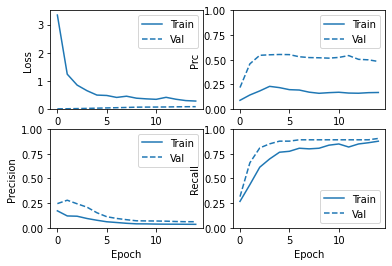

In [36]:
plot_metrics(weighted_history)

### Evaluate metrics

In [37]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

 1/90 [..............................] - ETA: 3s

49/90 [===============>..............] - ETA: 0s

90/90 [==============================] - 0s 1ms/step


 1/28 [>.............................] - ETA: 0s

28/28 [==============================] - 0s 1ms/step


loss :  0.0376315712928772
tp :  84.0
fp :  454.0
tn :  56412.0
fn :  12.0
accuracy :  0.9918190836906433
precision :  0.15613383054733276
recall :  0.875
auc :  0.9684351086616516
prc :  0.5385129451751709



Legitimate Transactions Detected (True Negatives):  56412
Legitimate Transactions Incorrectly Detected (False Positives):  454
Fraudulent Transactions Missed (False Negatives):  12
Fraudulent Transactions Detected (True Positives):  84
Total Fraudulent Transactions:  96


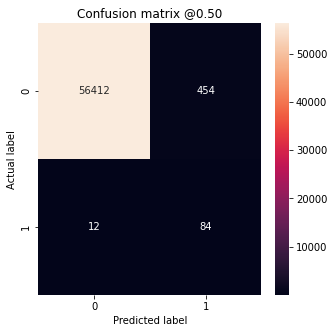

In [38]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

Here you can see that with class weights the accuracy and precision are lower because there are more false positives, but conversely the recall and AUC are higher because the model also found more true positives. Despite having lower accuracy, this model has higher recall (and identifies more fraudulent transactions). Of course, there is a cost to both types of error (you wouldn't want to bug users by flagging too many legitimate transactions as fraudulent, either). Carefully consider the trade-offs between these different types of errors for your application.

### Plot the ROC

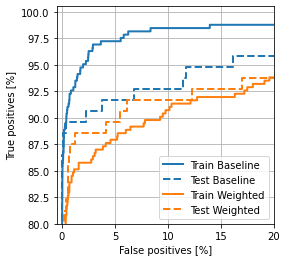

In [39]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

### Plot the AUPRC

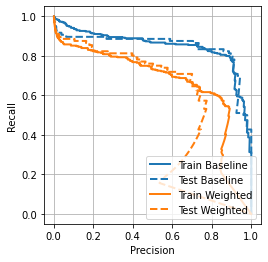

In [40]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

## Oversampling

### Oversample the minority class

A related approach would be to resample the dataset by oversampling the minority class.

In [41]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

#### Using NumPy

You can balance the dataset manually by choosing the right number of random 
indices from the positive examples:

In [42]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(181953, 29)

In [43]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(363906, 29)

#### Using `tf.data`

If you're using `tf.data` the easiest way to produce balanced examples is to start with a `positive` and a `negative` dataset, and merge them. See [the tf.data guide](../../guide/data.ipynb) for more examples.

In [44]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

Each dataset provides `(feature, label)` pairs:

In [45]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [-2.25920707 -0.0072081  -3.40638234  4.89298529  3.87783585 -3.25107162
 -2.14285219  0.28594133 -3.52636688 -3.65233852  5.         -5.
 -1.1397116  -5.          0.28999929 -1.26264317  0.74955735  1.1855264
 -0.84786706 -0.13985126  0.33724841 -0.06842706 -0.3580829  -0.65930289
  1.63937591  1.36920315  1.22563042  2.86007288 -1.4516158 ]

Label:  1


Merge the two together using `tf.data.Dataset.sample_from_datasets`:

In [46]:
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [47]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.498046875


To use this dataset, you'll need the number of steps per epoch.

The definition of "epoch" in this case is less clear. Say it's the number of batches required to see each negative example once:

In [48]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

278.0

### Train on the oversampled data

Now try training the model with the resampled data set instead of using class weights to see how these methods compare.

Note: Because the data was balanced by replicating the positive examples, the total dataset size is larger, and each epoch runs for more training steps. 

In [49]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/100


  1/278 [..............................] - ETA: 7:15 - loss: 2.4969 - tp: 328.0000 - fp: 917.0000 - tn: 56929.0000 - fn: 836.0000 - accuracy: 0.9703 - precision: 0.2635 - recall: 0.2818 - auc: 0.7163 - prc: 0.2015

  4/278 [..............................] - ETA: 4s - loss: 2.4276 - tp: 1051.0000 - fp: 2331.0000 - tn: 58565.0000 - fn: 3207.0000 - accuracy: 0.9150 - precision: 0.3108 - recall: 0.2468 - auc: 0.6765 - prc: 0.2418

  7/278 [..............................] - ETA: 4s - loss: 2.3298 - tp: 1821.0000 - fp: 3831.0000 - tn: 60239.0000 - fn: 5407.0000 - accuracy: 0.8704 - precision: 0.3222 - recall: 0.2519 - auc: 0.6627 - prc: 0.2770

 10/278 [>.............................] - ETA: 4s - loss: 2.2508 - tp: 2702.0000 - fp: 5253.0000 - tn: 61854.0000 - fn: 7633.0000 - accuracy: 0.8336 - precision: 0.3397 - recall: 0.2614 - auc: 0.6574 - prc: 0.3096

 13/278 [>.............................] - ETA: 4s - loss: 2.1705 - tp: 3689.0000 - fp: 6742.0000 - tn: 63450.0000 - fn: 9705.0000 - accuracy: 0.8032 - precision: 0.3537 - recall: 0.2754 - auc: 0.6534 - prc: 0.3396

 16/278 [>.............................] - ETA: 4s - loss: 2.0962 - tp: 4820.0000 - fp: 8235.0000 - tn: 64971.0000 - fn: 11704.0000 - accuracy: 0.7778 - precision: 0.3692 - recall: 0.2917 - auc: 0.6520 - prc: 0.3672

 19/278 [=>............................] - ETA: 4s - loss: 2.0262 - tp: 5973.0000 - fp: 9698.0000 - tn: 66518.0000 - fn: 13685.0000 - accuracy: 0.7561 - precision: 0.3811 - recall: 0.3038 - auc: 0.6506 - prc: 0.3924

 22/278 [=>............................] - ETA: 4s - loss: 1.9559 - tp: 7208.0000 - fp: 11187.0000 - tn: 68101.0000 - fn: 15522.0000 - accuracy: 0.7382 - precision: 0.3918 - recall: 0.3171 - auc: 0.6501 - prc: 0.4151

 25/278 [=>............................] - ETA: 4s - loss: 1.8920 - tp: 8549.0000 - fp: 12691.0000 - tn: 69662.0000 - fn: 17260.0000 - accuracy: 0.7231 - precision: 0.4025 - recall: 0.3312 - auc: 0.6499 - prc: 0.4351

 28/278 [==>...........................] - ETA: 4s - loss: 1.8282 - tp: 9940.0000 - fp: 14226.0000 - tn: 71269.0000 - fn: 18871.0000 - accuracy: 0.7105 - precision: 0.4113 - recall: 0.3450 - auc: 0.6502 - prc: 0.4533

 31/278 [==>...........................] - ETA: 4s - loss: 1.7713 - tp: 11427.0000 - fp: 15756.0000 - tn: 72851.0000 - fn: 20416.0000 - accuracy: 0.6997 - precision: 0.4204 - recall: 0.3589 - auc: 0.6508 - prc: 0.4717

 34/278 [==>...........................] - ETA: 4s - loss: 1.7181 - tp: 13024.0000 - fp: 17247.0000 - tn: 74440.0000 - fn: 21883.0000 - accuracy: 0.6909 - precision: 0.4302 - recall: 0.3731 - auc: 0.6520 - prc: 0.4891

 37/278 [==>...........................] - ETA: 4s - loss: 1.6683 - tp: 14692.0000 - fp: 18780.0000 - tn: 76014.0000 - fn: 23252.0000 - accuracy: 0.6833 - precision: 0.4389 - recall: 0.3872 - auc: 0.6535 - prc: 0.5059

 40/278 [===>..........................] - ETA: 4s - loss: 1.6185 - tp: 16514.0000 - fp: 20248.0000 - tn: 77591.0000 - fn: 24529.0000 - accuracy: 0.6776 - precision: 0.4492 - recall: 0.4024 - auc: 0.6564 - prc: 0.5243

 43/278 [===>..........................] - ETA: 4s - loss: 1.5745 - tp: 18328.0000 - fp: 21781.0000 - tn: 79202.0000 - fn: 25715.0000 - accuracy: 0.6725 - precision: 0.4570 - recall: 0.4161 - auc: 0.6586 - prc: 0.5383

 46/278 [===>..........................] - ETA: 4s - loss: 1.5312 - tp: 20250.0000 - fp: 23262.0000 - tn: 80767.0000 - fn: 26891.0000 - accuracy: 0.6682 - precision: 0.4654 - recall: 0.4296 - auc: 0.6617 - prc: 0.5538

 49/278 [====>.........................] - ETA: 4s - loss: 1.4911 - tp: 22251.0000 - fp: 24757.0000 - tn: 82364.0000 - fn: 27942.0000 - accuracy: 0.6650 - precision: 0.4733 - recall: 0.4433 - auc: 0.6648 - prc: 0.5675

 52/278 [====>.........................] - ETA: 4s - loss: 1.4540 - tp: 24300.0000 - fp: 26221.0000 - tn: 83990.0000 - fn: 28947.0000 - accuracy: 0.6625 - precision: 0.4810 - recall: 0.4564 - auc: 0.6679 - prc: 0.5810

 55/278 [====>.........................] - ETA: 4s - loss: 1.4181 - tp: 26478.0000 - fp: 27625.0000 - tn: 85611.0000 - fn: 29888.0000 - accuracy: 0.6609 - precision: 0.4894 - recall: 0.4698 - auc: 0.6718 - prc: 0.5948

 58/278 [=====>........................] - ETA: 3s - loss: 1.3850 - tp: 28680.0000 - fp: 29000.0000 - tn: 87283.0000 - fn: 30783.0000 - accuracy: 0.6598 - precision: 0.4972 - recall: 0.4823 - auc: 0.6754 - prc: 0.6070

 61/278 [=====>........................] - ETA: 3s - loss: 1.3541 - tp: 30865.0000 - fp: 30412.0000 - tn: 88968.0000 - fn: 31645.0000 - accuracy: 0.6588 - precision: 0.5037 - recall: 0.4938 - auc: 0.6787 - prc: 0.6181

 64/278 [=====>........................] - ETA: 3s - loss: 1.3249 - tp: 33122.0000 - fp: 31753.0000 - tn: 90661.0000 - fn: 32498.0000 - accuracy: 0.6583 - precision: 0.5106 - recall: 0.5048 - auc: 0.6822 - prc: 0.6288

 67/278 [======>.......................] - ETA: 3s - loss: 1.2969 - tp: 35387.0000 - fp: 33136.0000 - tn: 92346.0000 - fn: 33309.0000 - accuracy: 0.6578 - precision: 0.5164 - recall: 0.5151 - auc: 0.6856 - prc: 0.6388

 70/278 [======>.......................] - ETA: 3s - loss: 1.2712 - tp: 37658.0000 - fp: 34515.0000 - tn: 94037.0000 - fn: 34112.0000 - accuracy: 0.6574 - precision: 0.5218 - recall: 0.5247 - auc: 0.6888 - prc: 0.6481

 73/278 [======>.......................] - ETA: 3s - loss: 1.2469 - tp: 39902.0000 - fp: 35878.0000 - tn: 95807.0000 - fn: 34879.0000 - accuracy: 0.6573 - precision: 0.5266 - recall: 0.5336 - auc: 0.6917 - prc: 0.6565

 76/278 [=======>......................] - ETA: 3s - loss: 1.2233 - tp: 42243.0000 - fp: 37142.0000 - tn: 97609.0000 - fn: 35616.0000 - accuracy: 0.6578 - precision: 0.5321 - recall: 0.5426 - auc: 0.6951 - prc: 0.6652

 79/278 [=======>......................] - ETA: 3s - loss: 1.2008 - tp: 44615.0000 - fp: 38374.0000 - tn: 99407.0000 - fn: 36358.0000 - accuracy: 0.6584 - precision: 0.5376 - recall: 0.5510 - auc: 0.6985 - prc: 0.6736

 82/278 [=======>......................] - ETA: 3s - loss: 1.1800 - tp: 46951.0000 - fp: 39603.0000 - tn: 101234.0000 - fn: 37110.0000 - accuracy: 0.6589 - precision: 0.5424 - recall: 0.5585 - auc: 0.7015 - prc: 0.6812

 85/278 [========>.....................] - ETA: 3s - loss: 1.1602 - tp: 49286.0000 - fp: 40812.0000 - tn: 103127.0000 - fn: 37817.0000 - accuracy: 0.6597 - precision: 0.5470 - recall: 0.5658 - auc: 0.7045 - prc: 0.6882

 88/278 [========>.....................] - ETA: 3s - loss: 1.1409 - tp: 51698.0000 - fp: 42009.0000 - tn: 104981.0000 - fn: 38498.0000 - accuracy: 0.6606 - precision: 0.5517 - recall: 0.5732 - auc: 0.7077 - prc: 0.6953

 91/278 [========>.....................] - ETA: 3s - loss: 1.1225 - tp: 54046.0000 - fp: 43131.0000 - tn: 106960.0000 - fn: 39193.0000 - accuracy: 0.6617 - precision: 0.5562 - recall: 0.5797 - auc: 0.7106 - prc: 0.7017

 94/278 [=========>....................] - ETA: 3s - loss: 1.1054 - tp: 56451.0000 - fp: 44226.0000 - tn: 108916.0000 - fn: 39881.0000 - accuracy: 0.6629 - precision: 0.5607 - recall: 0.5860 - auc: 0.7136 - prc: 0.7079

 97/278 [=========>....................] - ETA: 3s - loss: 1.0893 - tp: 58847.0000 - fp: 45373.0000 - tn: 110866.0000 - fn: 40532.0000 - accuracy: 0.6639 - precision: 0.5646 - recall: 0.5921 - auc: 0.7163 - prc: 0.7135

100/278 [=========>....................] - ETA: 3s - loss: 1.0733 - tp: 61240.0000 - fp: 46474.0000 - tn: 112898.0000 - fn: 41150.0000 - accuracy: 0.6653 - precision: 0.5685 - recall: 0.5981 - auc: 0.7192 - prc: 0.7191

103/278 [==========>...................] - ETA: 3s - loss: 1.0577 - tp: 63695.0000 - fp: 47559.0000 - tn: 114889.0000 - fn: 41763.0000 - accuracy: 0.6666 - precision: 0.5725 - recall: 0.6040 - auc: 0.7221 - prc: 0.7246

106/278 [==========>...................] - ETA: 3s - loss: 1.0434 - tp: 66170.0000 - fp: 48616.0000 - tn: 116848.0000 - fn: 42416.0000 - accuracy: 0.6678 - precision: 0.5765 - recall: 0.6094 - auc: 0.7248 - prc: 0.7299

109/278 [==========>...................] - ETA: 3s - loss: 1.0291 - tp: 68675.0000 - fp: 49635.0000 - tn: 118878.0000 - fn: 43006.0000 - accuracy: 0.6694 - precision: 0.5805 - recall: 0.6149 - auc: 0.7278 - prc: 0.7351

112/278 [===========>..................] - ETA: 3s - loss: 1.0154 - tp: 71231.0000 - fp: 50562.0000 - tn: 120924.0000 - fn: 43621.0000 - accuracy: 0.6711 - precision: 0.5849 - recall: 0.6202 - auc: 0.7306 - prc: 0.7402

115/278 [===========>..................] - ETA: 2s - loss: 1.0024 - tp: 73709.0000 - fp: 51550.0000 - tn: 123036.0000 - fn: 44187.0000 - accuracy: 0.6727 - precision: 0.5885 - recall: 0.6252 - auc: 0.7332 - prc: 0.7447

118/278 [===========>..................] - ETA: 2s - loss: 0.9901 - tp: 76205.0000 - fp: 52520.0000 - tn: 125103.0000 - fn: 44798.0000 - accuracy: 0.6741 - precision: 0.5920 - recall: 0.6298 - auc: 0.7357 - prc: 0.7490

121/278 [============>.................] - ETA: 2s - loss: 0.9778 - tp: 78723.0000 - fp: 53428.0000 - tn: 127224.0000 - fn: 45395.0000 - accuracy: 0.6757 - precision: 0.5957 - recall: 0.6343 - auc: 0.7383 - prc: 0.7533

124/278 [============>.................] - ETA: 2s - loss: 0.9657 - tp: 81240.0000 - fp: 54355.0000 - tn: 129376.0000 - fn: 45943.0000 - accuracy: 0.6774 - precision: 0.5991 - recall: 0.6388 - auc: 0.7409 - prc: 0.7574

127/278 [============>.................] - ETA: 2s - loss: 0.9543 - tp: 83735.0000 - fp: 55234.0000 - tn: 131566.0000 - fn: 46523.0000 - accuracy: 0.6791 - precision: 0.6025 - recall: 0.6428 - auc: 0.7433 - prc: 0.7613

130/278 [=============>................] - ETA: 2s - loss: 0.9434 - tp: 86236.0000 - fp: 56097.0000 - tn: 133771.0000 - fn: 47098.0000 - accuracy: 0.6807 - precision: 0.6059 - recall: 0.6468 - auc: 0.7457 - prc: 0.7650

133/278 [=============>................] - ETA: 2s - loss: 0.9330 - tp: 88746.0000 - fp: 56972.0000 - tn: 135984.0000 - fn: 47644.0000 - accuracy: 0.6824 - precision: 0.6090 - recall: 0.6507 - auc: 0.7480 - prc: 0.7684

136/278 [=============>................] - ETA: 2s - loss: 0.9229 - tp: 91266.0000 - fp: 57766.0000 - tn: 138252.0000 - fn: 48206.0000 - accuracy: 0.6841 - precision: 0.6124 - recall: 0.6544 - auc: 0.7503 - prc: 0.7719

139/278 [==============>...............] - ETA: 2s - loss: 0.9129 - tp: 93768.0000 - fp: 58541.0000 - tn: 140552.0000 - fn: 48773.0000 - accuracy: 0.6859 - precision: 0.6156 - recall: 0.6578 - auc: 0.7526 - prc: 0.7752

142/278 [==============>...............] - ETA: 2s - loss: 0.9030 - tp: 96300.0000 - fp: 59353.0000 - tn: 142801.0000 - fn: 49324.0000 - accuracy: 0.6875 - precision: 0.6187 - recall: 0.6613 - auc: 0.7549 - prc: 0.7785

145/278 [==============>...............] - ETA: 2s - loss: 0.8937 - tp: 98810.0000 - fp: 60124.0000 - tn: 145099.0000 - fn: 49889.0000 - accuracy: 0.6892 - precision: 0.6217 - recall: 0.6645 - auc: 0.7570 - prc: 0.7816

148/278 [==============>...............] - ETA: 2s - loss: 0.8845 - tp: 101378.0000 - fp: 60878.0000 - tn: 147398.0000 - fn: 50412.0000 - accuracy: 0.6909 - precision: 0.6248 - recall: 0.6679 - auc: 0.7593 - prc: 0.7847

151/278 [===============>..............] - ETA: 2s - loss: 0.8754 - tp: 103960.0000 - fp: 61612.0000 - tn: 149708.0000 - fn: 50930.0000 - accuracy: 0.6927 - precision: 0.6279 - recall: 0.6712 - auc: 0.7615 - prc: 0.7878

154/278 [===============>..............] - ETA: 2s - loss: 0.8667 - tp: 106516.0000 - fp: 62341.0000 - tn: 152038.0000 - fn: 51459.0000 - accuracy: 0.6944 - precision: 0.6308 - recall: 0.6743 - auc: 0.7636 - prc: 0.7907

157/278 [===============>..............] - ETA: 2s - loss: 0.8583 - tp: 109077.0000 - fp: 63047.0000 - tn: 154384.0000 - fn: 51990.0000 - accuracy: 0.6961 - precision: 0.6337 - recall: 0.6772 - auc: 0.7657 - prc: 0.7935

160/278 [================>.............] - ETA: 2s - loss: 0.8501 - tp: 111627.0000 - fp: 63733.0000 - tn: 156784.0000 - fn: 52498.0000 - accuracy: 0.6978 - precision: 0.6366 - recall: 0.6801 - auc: 0.7678 - prc: 0.7962

163/278 [================>.............] - ETA: 2s - loss: 0.8419 - tp: 114231.0000 - fp: 64381.0000 - tn: 159152.0000 - fn: 53022.0000 - accuracy: 0.6996 - precision: 0.6395 - recall: 0.6830 - auc: 0.7699 - prc: 0.7989

166/278 [================>.............] - ETA: 2s - loss: 0.8342 - tp: 116815.0000 - fp: 65043.0000 - tn: 161539.0000 - fn: 53533.0000 - accuracy: 0.7013 - precision: 0.6423 - recall: 0.6857 - auc: 0.7718 - prc: 0.8015

169/278 [=================>............] - ETA: 2s - loss: 0.8266 - tp: 119374.0000 - fp: 65660.0000 - tn: 163999.0000 - fn: 54041.0000 - accuracy: 0.7030 - precision: 0.6451 - recall: 0.6884 - auc: 0.7737 - prc: 0.8039

172/278 [=================>............] - ETA: 1s - loss: 0.8191 - tp: 121970.0000 - fp: 66289.0000 - tn: 166441.0000 - fn: 54518.0000 - accuracy: 0.7048 - precision: 0.6479 - recall: 0.6911 - auc: 0.7757 - prc: 0.8064

175/278 [=================>............] - ETA: 1s - loss: 0.8119 - tp: 124598.0000 - fp: 66928.0000 - tn: 168818.0000 - fn: 55018.0000 - accuracy: 0.7064 - precision: 0.6506 - recall: 0.6937 - auc: 0.7777 - prc: 0.8088

178/278 [==================>...........] - ETA: 1s - loss: 0.8048 - tp: 127145.0000 - fp: 67552.0000 - tn: 171309.0000 - fn: 55500.0000 - accuracy: 0.7081 - precision: 0.6530 - recall: 0.6961 - auc: 0.7796 - prc: 0.8111

181/278 [==================>...........] - ETA: 1s - loss: 0.7979 - tp: 129710.0000 - fp: 68163.0000 - tn: 173763.0000 - fn: 56014.0000 - accuracy: 0.7096 - precision: 0.6555 - recall: 0.6984 - auc: 0.7814 - prc: 0.8132

184/278 [==================>...........] - ETA: 1s - loss: 0.7915 - tp: 132254.0000 - fp: 68777.0000 - tn: 176248.0000 - fn: 56515.0000 - accuracy: 0.7112 - precision: 0.6579 - recall: 0.7006 - auc: 0.7831 - prc: 0.8153

187/278 [===================>..........] - ETA: 1s - loss: 0.7850 - tp: 134868.0000 - fp: 69368.0000 - tn: 178678.0000 - fn: 57024.0000 - accuracy: 0.7127 - precision: 0.6604 - recall: 0.7028 - auc: 0.7848 - prc: 0.8174

190/278 [===================>..........] - ETA: 1s - loss: 0.7787 - tp: 137431.0000 - fp: 69919.0000 - tn: 181204.0000 - fn: 57528.0000 - accuracy: 0.7143 - precision: 0.6628 - recall: 0.7049 - auc: 0.7865 - prc: 0.8194

193/278 [===================>..........] - ETA: 1s - loss: 0.7724 - tp: 140016.0000 - fp: 70486.0000 - tn: 183716.0000 - fn: 58008.0000 - accuracy: 0.7159 - precision: 0.6652 - recall: 0.7071 - auc: 0.7883 - prc: 0.8215

196/278 [====================>.........] - ETA: 1s - loss: 0.7662 - tp: 142590.0000 - fp: 71015.0000 - tn: 186264.0000 - fn: 58501.0000 - accuracy: 0.7174 - precision: 0.6675 - recall: 0.7091 - auc: 0.7900 - prc: 0.8233

199/278 [====================>.........] - ETA: 1s - loss: 0.7601 - tp: 145307.0000 - fp: 71477.0000 - tn: 188763.0000 - fn: 58967.0000 - accuracy: 0.7192 - precision: 0.6703 - recall: 0.7113 - auc: 0.7918 - prc: 0.8254

202/278 [====================>.........] - ETA: 1s - loss: 0.7541 - tp: 147955.0000 - fp: 71990.0000 - tn: 191285.0000 - fn: 59428.0000 - accuracy: 0.7208 - precision: 0.6727 - recall: 0.7134 - auc: 0.7935 - prc: 0.8274

205/278 [=====================>........] - ETA: 1s - loss: 0.7483 - tp: 150536.0000 - fp: 72501.0000 - tn: 193892.0000 - fn: 59873.0000 - accuracy: 0.7224 - precision: 0.6749 - recall: 0.7154 - auc: 0.7952 - prc: 0.8292

208/278 [=====================>........] - ETA: 1s - loss: 0.7425 - tp: 153194.0000 - fp: 72960.0000 - tn: 196468.0000 - fn: 60324.0000 - accuracy: 0.7240 - precision: 0.6774 - recall: 0.7175 - auc: 0.7969 - prc: 0.8311

211/278 [=====================>........] - ETA: 1s - loss: 0.7371 - tp: 155722.0000 - fp: 73433.0000 - tn: 199140.0000 - fn: 60795.0000 - accuracy: 0.7256 - precision: 0.6795 - recall: 0.7192 - auc: 0.7985 - prc: 0.8327

214/278 [======================>.......] - ETA: 1s - loss: 0.7317 - tp: 158323.0000 - fp: 73909.0000 - tn: 201753.0000 - fn: 61249.0000 - accuracy: 0.7271 - precision: 0.6817 - recall: 0.7211 - auc: 0.8000 - prc: 0.8344

217/278 [======================>.......] - ETA: 1s - loss: 0.7264 - tp: 160938.0000 - fp: 74394.0000 - tn: 204361.0000 - fn: 61685.0000 - accuracy: 0.7286 - precision: 0.6839 - recall: 0.7229 - auc: 0.8016 - prc: 0.8360

220/278 [======================>.......] - ETA: 1s - loss: 0.7212 - tp: 163540.0000 - fp: 74826.0000 - tn: 207030.0000 - fn: 62126.0000 - accuracy: 0.7302 - precision: 0.6861 - recall: 0.7247 - auc: 0.8031 - prc: 0.8376

223/278 [=======================>......] - ETA: 1s - loss: 0.7162 - tp: 166117.0000 - fp: 75314.0000 - tn: 209695.0000 - fn: 62540.0000 - accuracy: 0.7316 - precision: 0.6881 - recall: 0.7265 - auc: 0.8047 - prc: 0.8392

226/278 [=======================>......] - ETA: 0s - loss: 0.7111 - tp: 168748.0000 - fp: 75741.0000 - tn: 212335.0000 - fn: 62986.0000 - accuracy: 0.7331 - precision: 0.6902 - recall: 0.7282 - auc: 0.8062 - prc: 0.8407

229/278 [=======================>......] - ETA: 0s - loss: 0.7062 - tp: 171378.0000 - fp: 76214.0000 - tn: 214922.0000 - fn: 63440.0000 - accuracy: 0.7345 - precision: 0.6922 - recall: 0.7298 - auc: 0.8076 - prc: 0.8423

232/278 [========================>.....] - ETA: 0s - loss: 0.7014 - tp: 173982.0000 - fp: 76646.0000 - tn: 217577.0000 - fn: 63893.0000 - accuracy: 0.7359 - precision: 0.6942 - recall: 0.7314 - auc: 0.8090 - prc: 0.8437

235/278 [========================>.....] - ETA: 0s - loss: 0.6967 - tp: 176552.0000 - fp: 77052.0000 - tn: 220305.0000 - fn: 64333.0000 - accuracy: 0.7373 - precision: 0.6962 - recall: 0.7329 - auc: 0.8105 - prc: 0.8452

238/278 [========================>.....] - ETA: 0s - loss: 0.6920 - tp: 179233.0000 - fp: 77463.0000 - tn: 222940.0000 - fn: 64750.0000 - accuracy: 0.7388 - precision: 0.6982 - recall: 0.7346 - auc: 0.8119 - prc: 0.8467

241/278 [=========================>....] - ETA: 0s - loss: 0.6875 - tp: 181886.0000 - fp: 77874.0000 - tn: 225587.0000 - fn: 65183.0000 - accuracy: 0.7401 - precision: 0.7002 - recall: 0.7362 - auc: 0.8133 - prc: 0.8481

244/278 [=========================>....] - ETA: 0s - loss: 0.6830 - tp: 184539.0000 - fp: 78256.0000 - tn: 228249.0000 - fn: 65630.0000 - accuracy: 0.7415 - precision: 0.7022 - recall: 0.7377 - auc: 0.8147 - prc: 0.8495

247/278 [=========================>....] - ETA: 0s - loss: 0.6784 - tp: 187227.0000 - fp: 78634.0000 - tn: 230893.0000 - fn: 66064.0000 - accuracy: 0.7429 - precision: 0.7042 - recall: 0.7392 - auc: 0.8161 - prc: 0.8509

250/278 [=========================>....] - ETA: 0s - loss: 0.6740 - tp: 189894.0000 - fp: 79024.0000 - tn: 233556.0000 - fn: 66488.0000 - accuracy: 0.7443 - precision: 0.7061 - recall: 0.7407 - auc: 0.8175 - prc: 0.8523

253/278 [==========================>...] - ETA: 0s - loss: 0.6697 - tp: 192555.0000 - fp: 79394.0000 - tn: 236242.0000 - fn: 66915.0000 - accuracy: 0.7456 - precision: 0.7081 - recall: 0.7421 - auc: 0.8189 - prc: 0.8537

256/278 [==========================>...] - ETA: 0s - loss: 0.6656 - tp: 195231.0000 - fp: 79787.0000 - tn: 238901.0000 - fn: 67331.0000 - accuracy: 0.7469 - precision: 0.7099 - recall: 0.7436 - auc: 0.8202 - prc: 0.8550

259/278 [==========================>...] - ETA: 0s - loss: 0.6615 - tp: 197862.0000 - fp: 80155.0000 - tn: 241625.0000 - fn: 67752.0000 - accuracy: 0.7482 - precision: 0.7117 - recall: 0.7449 - auc: 0.8215 - prc: 0.8562

262/278 [===========================>..] - ETA: 0s - loss: 0.6575 - tp: 200469.0000 - fp: 80507.0000 - tn: 244368.0000 - fn: 68194.0000 - accuracy: 0.7495 - precision: 0.7135 - recall: 0.7462 - auc: 0.8227 - prc: 0.8574

265/278 [===========================>..] - ETA: 0s - loss: 0.6535 - tp: 203065.0000 - fp: 80853.0000 - tn: 247149.0000 - fn: 68615.0000 - accuracy: 0.7508 - precision: 0.7152 - recall: 0.7474 - auc: 0.8240 - prc: 0.8586

268/278 [===========================>..] - ETA: 0s - loss: 0.6495 - tp: 205763.0000 - fp: 81154.0000 - tn: 249864.0000 - fn: 69045.0000 - accuracy: 0.7521 - precision: 0.7172 - recall: 0.7488 - auc: 0.8253 - prc: 0.8598

271/278 [============================>.] - ETA: 0s - loss: 0.6457 - tp: 208405.0000 - fp: 81509.0000 - tn: 252609.0000 - fn: 69447.0000 - accuracy: 0.7533 - precision: 0.7189 - recall: 0.7501 - auc: 0.8265 - prc: 0.8610

274/278 [============================>.] - ETA: 0s - loss: 0.6418 - tp: 211048.0000 - fp: 81871.0000 - tn: 255361.0000 - fn: 69834.0000 - accuracy: 0.7546 - precision: 0.7205 - recall: 0.7514 - auc: 0.8278 - prc: 0.8622

277/278 [============================>.] - ETA: 0s - loss: 0.6380 - tp: 213669.0000 - fp: 82176.0000 - tn: 258154.0000 - fn: 70259.0000 - accuracy: 0.7558 - precision: 0.7222 - recall: 0.7525 - auc: 0.8290 - prc: 0.8633

278/278 [==============================] - 8s 22ms/step - loss: 0.6368 - tp: 214568.0000 - fp: 82297.0000 - tn: 259040.0000 - fn: 70401.0000 - accuracy: 0.7562 - precision: 0.7228 - recall: 0.7530 - auc: 0.8294 - prc: 0.8637 - val_loss: 0.2618 - val_tp: 68.0000 - val_fp: 1550.0000 - val_tn: 43946.0000 - val_fn: 5.0000 - val_accuracy: 0.9659 - val_precision: 0.0420 - val_recall: 0.9315 - val_auc: 0.9874 - val_prc: 0.7153


Epoch 2/100


  1/278 [..............................] - ETA: 1s - loss: 0.2824 - tp: 886.0000 - fp: 111.0000 - tn: 926.0000 - fn: 125.0000 - accuracy: 0.8848 - precision: 0.8887 - recall: 0.8764 - auc: 0.9461 - prc: 0.9599

  5/278 [..............................] - ETA: 3s - loss: 0.2855 - tp: 4407.0000 - fp: 517.0000 - tn: 4645.0000 - fn: 671.0000 - accuracy: 0.8840 - precision: 0.8950 - recall: 0.8679 - auc: 0.9446 - prc: 0.9582

  8/278 [..............................] - ETA: 4s - loss: 0.2861 - tp: 7138.0000 - fp: 826.0000 - tn: 7348.0000 - fn: 1072.0000 - accuracy: 0.8842 - precision: 0.8963 - recall: 0.8694 - auc: 0.9442 - prc: 0.9586

 11/278 [>.............................] - ETA: 4s - loss: 0.2866 - tp: 9762.0000 - fp: 1137.0000 - tn: 10159.0000 - fn: 1470.0000 - accuracy: 0.8843 - precision: 0.8957 - recall: 0.8691 - auc: 0.9435 - prc: 0.9580

 14/278 [>.............................] - ETA: 4s - loss: 0.2850 - tp: 12439.0000 - fp: 1444.0000 - tn: 12921.0000 - fn: 1868.0000 - accuracy: 0.8845 - precision: 0.8960 - recall: 0.8694 - auc: 0.9440 - prc: 0.9584

 17/278 [>.............................] - ETA: 4s - loss: 0.2840 - tp: 15161.0000 - fp: 1740.0000 - tn: 15667.0000 - fn: 2248.0000 - accuracy: 0.8855 - precision: 0.8970 - recall: 0.8709 - auc: 0.9445 - prc: 0.9588

 20/278 [=>............................] - ETA: 4s - loss: 0.2845 - tp: 17845.0000 - fp: 2048.0000 - tn: 18404.0000 - fn: 2663.0000 - accuracy: 0.8850 - precision: 0.8970 - recall: 0.8701 - auc: 0.9444 - prc: 0.9587

 23/278 [=>............................] - ETA: 4s - loss: 0.2838 - tp: 20513.0000 - fp: 2360.0000 - tn: 21183.0000 - fn: 3048.0000 - accuracy: 0.8852 - precision: 0.8968 - recall: 0.8706 - auc: 0.9447 - prc: 0.9588

 26/278 [=>............................] - ETA: 4s - loss: 0.2832 - tp: 23193.0000 - fp: 2651.0000 - tn: 23949.0000 - fn: 3455.0000 - accuracy: 0.8853 - precision: 0.8974 - recall: 0.8703 - auc: 0.9449 - prc: 0.9590

 29/278 [==>...........................] - ETA: 4s - loss: 0.2823 - tp: 25868.0000 - fp: 2938.0000 - tn: 26753.0000 - fn: 3833.0000 - accuracy: 0.8860 - precision: 0.8980 - recall: 0.8709 - auc: 0.9453 - prc: 0.9592

 32/278 [==>...........................] - ETA: 4s - loss: 0.2817 - tp: 28576.0000 - fp: 3216.0000 - tn: 29493.0000 - fn: 4251.0000 - accuracy: 0.8861 - precision: 0.8988 - recall: 0.8705 - auc: 0.9454 - prc: 0.9593

 35/278 [==>...........................] - ETA: 4s - loss: 0.2804 - tp: 31267.0000 - fp: 3482.0000 - tn: 32289.0000 - fn: 4642.0000 - accuracy: 0.8867 - precision: 0.8998 - recall: 0.8707 - auc: 0.9459 - prc: 0.9597

 38/278 [===>..........................] - ETA: 4s - loss: 0.2802 - tp: 33985.0000 - fp: 3761.0000 - tn: 35058.0000 - fn: 5020.0000 - accuracy: 0.8872 - precision: 0.9004 - recall: 0.8713 - auc: 0.9461 - prc: 0.9598

 41/278 [===>..........................] - ETA: 4s - loss: 0.2803 - tp: 36732.0000 - fp: 4074.0000 - tn: 37763.0000 - fn: 5399.0000 - accuracy: 0.8872 - precision: 0.9002 - recall: 0.8719 - auc: 0.9460 - prc: 0.9598

 44/278 [===>..........................] - ETA: 4s - loss: 0.2794 - tp: 39465.0000 - fp: 4362.0000 - tn: 40509.0000 - fn: 5776.0000 - accuracy: 0.8875 - precision: 0.9005 - recall: 0.8723 - auc: 0.9463 - prc: 0.9601

 47/278 [====>.........................] - ETA: 4s - loss: 0.2785 - tp: 42215.0000 - fp: 4624.0000 - tn: 43278.0000 - fn: 6139.0000 - accuracy: 0.8882 - precision: 0.9013 - recall: 0.8730 - auc: 0.9467 - prc: 0.9604

 50/278 [====>.........................] - ETA: 4s - loss: 0.2776 - tp: 44906.0000 - fp: 4892.0000 - tn: 46087.0000 - fn: 6515.0000 - accuracy: 0.8886 - precision: 0.9018 - recall: 0.8733 - auc: 0.9471 - prc: 0.9606

 53/278 [====>.........................] - ETA: 4s - loss: 0.2772 - tp: 47592.0000 - fp: 5169.0000 - tn: 48895.0000 - fn: 6888.0000 - accuracy: 0.8889 - precision: 0.9020 - recall: 0.8736 - auc: 0.9473 - prc: 0.9608

 56/278 [=====>........................] - ETA: 4s - loss: 0.2764 - tp: 50340.0000 - fp: 5440.0000 - tn: 51660.0000 - fn: 7248.0000 - accuracy: 0.8894 - precision: 0.9025 - recall: 0.8741 - auc: 0.9476 - prc: 0.9610

 59/278 [=====>........................] - ETA: 4s - loss: 0.2757 - tp: 53076.0000 - fp: 5692.0000 - tn: 54454.0000 - fn: 7610.0000 - accuracy: 0.8899 - precision: 0.9031 - recall: 0.8746 - auc: 0.9479 - prc: 0.9612

 62/278 [=====>........................] - ETA: 3s - loss: 0.2753 - tp: 55800.0000 - fp: 5954.0000 - tn: 57248.0000 - fn: 7974.0000 - accuracy: 0.8903 - precision: 0.9036 - recall: 0.8750 - auc: 0.9481 - prc: 0.9613

 65/278 [======>.......................] - ETA: 3s - loss: 0.2746 - tp: 58482.0000 - fp: 6203.0000 - tn: 60097.0000 - fn: 8338.0000 - accuracy: 0.8908 - precision: 0.9041 - recall: 0.8752 - auc: 0.9484 - prc: 0.9615

 68/278 [======>.......................] - ETA: 3s - loss: 0.2738 - tp: 61203.0000 - fp: 6457.0000 - tn: 62902.0000 - fn: 8702.0000 - accuracy: 0.8911 - precision: 0.9046 - recall: 0.8755 - auc: 0.9487 - prc: 0.9617

 71/278 [======>.......................] - ETA: 3s - loss: 0.2732 - tp: 63867.0000 - fp: 6710.0000 - tn: 65773.0000 - fn: 9058.0000 - accuracy: 0.8916 - precision: 0.9049 - recall: 0.8758 - auc: 0.9489 - prc: 0.9618

 74/278 [======>.......................] - ETA: 3s - loss: 0.2722 - tp: 66633.0000 - fp: 6969.0000 - tn: 68541.0000 - fn: 9409.0000 - accuracy: 0.8919 - precision: 0.9053 - recall: 0.8763 - auc: 0.9493 - prc: 0.9621

 77/278 [=======>......................] - ETA: 3s - loss: 0.2716 - tp: 69359.0000 - fp: 7228.0000 - tn: 71337.0000 - fn: 9772.0000 - accuracy: 0.8922 - precision: 0.9056 - recall: 0.8765 - auc: 0.9495 - prc: 0.9622

 80/278 [=======>......................] - ETA: 3s - loss: 0.2707 - tp: 71981.0000 - fp: 7486.0000 - tn: 74262.0000 - fn: 10111.0000 - accuracy: 0.8926 - precision: 0.9058 - recall: 0.8768 - auc: 0.9499 - prc: 0.9624

 83/278 [=======>......................] - ETA: 3s - loss: 0.2701 - tp: 74653.0000 - fp: 7740.0000 - tn: 77146.0000 - fn: 10445.0000 - accuracy: 0.8930 - precision: 0.9061 - recall: 0.8773 - auc: 0.9501 - prc: 0.9625

 86/278 [========>.....................] - ETA: 3s - loss: 0.2691 - tp: 77384.0000 - fp: 7987.0000 - tn: 79972.0000 - fn: 10785.0000 - accuracy: 0.8934 - precision: 0.9064 - recall: 0.8777 - auc: 0.9505 - prc: 0.9628

 89/278 [========>.....................] - ETA: 3s - loss: 0.2687 - tp: 80121.0000 - fp: 8220.0000 - tn: 82791.0000 - fn: 11140.0000 - accuracy: 0.8938 - precision: 0.9070 - recall: 0.8779 - auc: 0.9506 - prc: 0.9629

 92/278 [========>.....................] - ETA: 3s - loss: 0.2680 - tp: 82768.0000 - fp: 8446.0000 - tn: 85704.0000 - fn: 11498.0000 - accuracy: 0.8941 - precision: 0.9074 - recall: 0.8780 - auc: 0.9508 - prc: 0.9630

 95/278 [=========>....................] - ETA: 3s - loss: 0.2672 - tp: 85488.0000 - fp: 8655.0000 - tn: 88584.0000 - fn: 11833.0000 - accuracy: 0.8947 - precision: 0.9081 - recall: 0.8784 - auc: 0.9511 - prc: 0.9632

 98/278 [=========>....................] - ETA: 3s - loss: 0.2664 - tp: 88214.0000 - fp: 8893.0000 - tn: 91415.0000 - fn: 12182.0000 - accuracy: 0.8950 - precision: 0.9084 - recall: 0.8787 - auc: 0.9514 - prc: 0.9634

101/278 [=========>....................] - ETA: 3s - loss: 0.2656 - tp: 90942.0000 - fp: 9129.0000 - tn: 94243.0000 - fn: 12534.0000 - accuracy: 0.8953 - precision: 0.9088 - recall: 0.8789 - auc: 0.9517 - prc: 0.9636

104/278 [==========>...................] - ETA: 3s - loss: 0.2650 - tp: 93658.0000 - fp: 9367.0000 - tn: 97063.0000 - fn: 12904.0000 - accuracy: 0.8954 - precision: 0.9091 - recall: 0.8789 - auc: 0.9519 - prc: 0.9638

107/278 [==========>...................] - ETA: 3s - loss: 0.2645 - tp: 96355.0000 - fp: 9637.0000 - tn: 99888.0000 - fn: 13256.0000 - accuracy: 0.8955 - precision: 0.9091 - recall: 0.8791 - auc: 0.9521 - prc: 0.9639

110/278 [==========>...................] - ETA: 3s - loss: 0.2639 - tp: 99081.0000 - fp: 9899.0000 - tn: 102738.0000 - fn: 13562.0000 - accuracy: 0.8959 - precision: 0.9092 - recall: 0.8796 - auc: 0.9524 - prc: 0.9640

113/278 [===========>..................] - ETA: 3s - loss: 0.2630 - tp: 101897.0000 - fp: 10114.0000 - tn: 105518.0000 - fn: 13895.0000 - accuracy: 0.8963 - precision: 0.9097 - recall: 0.8800 - auc: 0.9527 - prc: 0.9643

116/278 [===========>..................] - ETA: 3s - loss: 0.2623 - tp: 104630.0000 - fp: 10342.0000 - tn: 108354.0000 - fn: 14242.0000 - accuracy: 0.8965 - precision: 0.9100 - recall: 0.8802 - auc: 0.9530 - prc: 0.9645

119/278 [===========>..................] - ETA: 2s - loss: 0.2614 - tp: 107402.0000 - fp: 10552.0000 - tn: 111210.0000 - fn: 14548.0000 - accuracy: 0.8970 - precision: 0.9105 - recall: 0.8807 - auc: 0.9534 - prc: 0.9647

122/278 [============>.................] - ETA: 2s - loss: 0.2609 - tp: 110070.0000 - fp: 10786.0000 - tn: 114090.0000 - fn: 14910.0000 - accuracy: 0.8972 - precision: 0.9108 - recall: 0.8807 - auc: 0.9535 - prc: 0.9648

125/278 [============>.................] - ETA: 2s - loss: 0.2602 - tp: 112814.0000 - fp: 10996.0000 - tn: 116960.0000 - fn: 15230.0000 - accuracy: 0.8976 - precision: 0.9112 - recall: 0.8811 - auc: 0.9538 - prc: 0.9650

128/278 [============>.................] - ETA: 2s - loss: 0.2596 - tp: 115606.0000 - fp: 11207.0000 - tn: 119757.0000 - fn: 15574.0000 - accuracy: 0.8978 - precision: 0.9116 - recall: 0.8813 - auc: 0.9539 - prc: 0.9651

131/278 [=============>................] - ETA: 2s - loss: 0.2591 - tp: 118355.0000 - fp: 11414.0000 - tn: 122591.0000 - fn: 15928.0000 - accuracy: 0.8981 - precision: 0.9120 - recall: 0.8814 - auc: 0.9541 - prc: 0.9653

134/278 [=============>................] - ETA: 2s - loss: 0.2586 - tp: 121131.0000 - fp: 11635.0000 - tn: 125363.0000 - fn: 16303.0000 - accuracy: 0.8982 - precision: 0.9124 - recall: 0.8814 - auc: 0.9543 - prc: 0.9654

137/278 [=============>................] - ETA: 2s - loss: 0.2579 - tp: 123856.0000 - fp: 11840.0000 - tn: 128254.0000 - fn: 16626.0000 - accuracy: 0.8985 - precision: 0.9127 - recall: 0.8817 - auc: 0.9545 - prc: 0.9656

140/278 [==============>...............] - ETA: 2s - loss: 0.2571 - tp: 126653.0000 - fp: 12049.0000 - tn: 131071.0000 - fn: 16947.0000 - accuracy: 0.8989 - precision: 0.9131 - recall: 0.8820 - auc: 0.9548 - prc: 0.9658

143/278 [==============>...............] - ETA: 2s - loss: 0.2564 - tp: 129434.0000 - fp: 12241.0000 - tn: 133902.0000 - fn: 17287.0000 - accuracy: 0.8992 - precision: 0.9136 - recall: 0.8822 - auc: 0.9550 - prc: 0.9660

146/278 [==============>...............] - ETA: 2s - loss: 0.2558 - tp: 132170.0000 - fp: 12458.0000 - tn: 136736.0000 - fn: 17644.0000 - accuracy: 0.8993 - precision: 0.9139 - recall: 0.8822 - auc: 0.9552 - prc: 0.9661

149/278 [===============>..............] - ETA: 2s - loss: 0.2551 - tp: 134952.0000 - fp: 12637.0000 - tn: 139589.0000 - fn: 17974.0000 - accuracy: 0.8997 - precision: 0.9144 - recall: 0.8825 - auc: 0.9555 - prc: 0.9663

152/278 [===============>..............] - ETA: 2s - loss: 0.2546 - tp: 137664.0000 - fp: 12836.0000 - tn: 142500.0000 - fn: 18296.0000 - accuracy: 0.9000 - precision: 0.9147 - recall: 0.8827 - auc: 0.9556 - prc: 0.9664

155/278 [===============>..............] - ETA: 2s - loss: 0.2541 - tp: 140432.0000 - fp: 13042.0000 - tn: 145346.0000 - fn: 18620.0000 - accuracy: 0.9003 - precision: 0.9150 - recall: 0.8829 - auc: 0.9559 - prc: 0.9665

158/278 [================>.............] - ETA: 2s - loss: 0.2537 - tp: 143154.0000 - fp: 13271.0000 - tn: 148191.0000 - fn: 18968.0000 - accuracy: 0.9004 - precision: 0.9152 - recall: 0.8830 - auc: 0.9560 - prc: 0.9666

161/278 [================>.............] - ETA: 2s - loss: 0.2531 - tp: 145936.0000 - fp: 13491.0000 - tn: 151011.0000 - fn: 19290.0000 - accuracy: 0.9006 - precision: 0.9154 - recall: 0.8833 - auc: 0.9562 - prc: 0.9668

164/278 [================>.............] - ETA: 2s - loss: 0.2525 - tp: 148707.0000 - fp: 13678.0000 - tn: 153870.0000 - fn: 19617.0000 - accuracy: 0.9009 - precision: 0.9158 - recall: 0.8835 - auc: 0.9564 - prc: 0.9669

167/278 [=================>............] - ETA: 2s - loss: 0.2518 - tp: 151458.0000 - fp: 13874.0000 - tn: 156761.0000 - fn: 19923.0000 - accuracy: 0.9012 - precision: 0.9161 - recall: 0.8838 - auc: 0.9567 - prc: 0.9671

170/278 [=================>............] - ETA: 2s - loss: 0.2513 - tp: 154193.0000 - fp: 14100.0000 - tn: 159626.0000 - fn: 20241.0000 - accuracy: 0.9014 - precision: 0.9162 - recall: 0.8840 - auc: 0.9569 - prc: 0.9672

173/278 [=================>............] - ETA: 1s - loss: 0.2508 - tp: 156914.0000 - fp: 14292.0000 - tn: 162527.0000 - fn: 20571.0000 - accuracy: 0.9016 - precision: 0.9165 - recall: 0.8841 - auc: 0.9570 - prc: 0.9673

176/278 [=================>............] - ETA: 1s - loss: 0.2502 - tp: 159605.0000 - fp: 14495.0000 - tn: 165451.0000 - fn: 20897.0000 - accuracy: 0.9018 - precision: 0.9167 - recall: 0.8842 - auc: 0.9572 - prc: 0.9674

179/278 [==================>...........] - ETA: 1s - loss: 0.2498 - tp: 162344.0000 - fp: 14707.0000 - tn: 168316.0000 - fn: 21225.0000 - accuracy: 0.9020 - precision: 0.9169 - recall: 0.8844 - auc: 0.9574 - prc: 0.9675

182/278 [==================>...........] - ETA: 1s - loss: 0.2493 - tp: 165075.0000 - fp: 14897.0000 - tn: 171227.0000 - fn: 21537.0000 - accuracy: 0.9023 - precision: 0.9172 - recall: 0.8846 - auc: 0.9575 - prc: 0.9676

185/278 [==================>...........] - ETA: 1s - loss: 0.2488 - tp: 167793.0000 - fp: 15087.0000 - tn: 174112.0000 - fn: 21888.0000 - accuracy: 0.9024 - precision: 0.9175 - recall: 0.8846 - auc: 0.9577 - prc: 0.9677

188/278 [===================>..........] - ETA: 1s - loss: 0.2483 - tp: 170548.0000 - fp: 15284.0000 - tn: 176997.0000 - fn: 22195.0000 - accuracy: 0.9027 - precision: 0.9178 - recall: 0.8848 - auc: 0.9579 - prc: 0.9679

191/278 [===================>..........] - ETA: 1s - loss: 0.2477 - tp: 173250.0000 - fp: 15490.0000 - tn: 179909.0000 - fn: 22519.0000 - accuracy: 0.9028 - precision: 0.9179 - recall: 0.8850 - auc: 0.9581 - prc: 0.9679

194/278 [===================>..........] - ETA: 1s - loss: 0.2473 - tp: 175999.0000 - fp: 15695.0000 - tn: 182777.0000 - fn: 22841.0000 - accuracy: 0.9030 - precision: 0.9181 - recall: 0.8851 - auc: 0.9582 - prc: 0.9680

197/278 [====================>.........] - ETA: 1s - loss: 0.2468 - tp: 178706.0000 - fp: 15869.0000 - tn: 185717.0000 - fn: 23164.0000 - accuracy: 0.9033 - precision: 0.9184 - recall: 0.8853 - auc: 0.9584 - prc: 0.9681

200/278 [====================>.........] - ETA: 1s - loss: 0.2462 - tp: 181445.0000 - fp: 16035.0000 - tn: 188651.0000 - fn: 23469.0000 - accuracy: 0.9036 - precision: 0.9188 - recall: 0.8855 - auc: 0.9586 - prc: 0.9683

203/278 [====================>.........] - ETA: 1s - loss: 0.2457 - tp: 184186.0000 - fp: 16219.0000 - tn: 191535.0000 - fn: 23804.0000 - accuracy: 0.9037 - precision: 0.9191 - recall: 0.8856 - auc: 0.9587 - prc: 0.9684

206/278 [=====================>........] - ETA: 1s - loss: 0.2452 - tp: 186960.0000 - fp: 16408.0000 - tn: 194397.0000 - fn: 24123.0000 - accuracy: 0.9039 - precision: 0.9193 - recall: 0.8857 - auc: 0.9589 - prc: 0.9685

209/278 [=====================>........] - ETA: 1s - loss: 0.2447 - tp: 189589.0000 - fp: 16568.0000 - tn: 197455.0000 - fn: 24420.0000 - accuracy: 0.9042 - precision: 0.9196 - recall: 0.8859 - auc: 0.9591 - prc: 0.9686

212/278 [=====================>........] - ETA: 1s - loss: 0.2443 - tp: 192348.0000 - fp: 16759.0000 - tn: 200345.0000 - fn: 24724.0000 - accuracy: 0.9045 - precision: 0.9199 - recall: 0.8861 - auc: 0.9593 - prc: 0.9687

215/278 [======================>.......] - ETA: 1s - loss: 0.2437 - tp: 195078.0000 - fp: 16939.0000 - tn: 203258.0000 - fn: 25045.0000 - accuracy: 0.9047 - precision: 0.9201 - recall: 0.8862 - auc: 0.9594 - prc: 0.9688

218/278 [======================>.......] - ETA: 1s - loss: 0.2434 - tp: 197889.0000 - fp: 17127.0000 - tn: 206076.0000 - fn: 25372.0000 - accuracy: 0.9048 - precision: 0.9203 - recall: 0.8864 - auc: 0.9596 - prc: 0.9689

221/278 [======================>.......] - ETA: 1s - loss: 0.2429 - tp: 200698.0000 - fp: 17301.0000 - tn: 208930.0000 - fn: 25679.0000 - accuracy: 0.9050 - precision: 0.9206 - recall: 0.8866 - auc: 0.9597 - prc: 0.9690

224/278 [=======================>......] - ETA: 1s - loss: 0.2425 - tp: 203518.0000 - fp: 17480.0000 - tn: 211791.0000 - fn: 25963.0000 - accuracy: 0.9053 - precision: 0.9209 - recall: 0.8869 - auc: 0.9599 - prc: 0.9691

227/278 [=======================>......] - ETA: 0s - loss: 0.2419 - tp: 206329.0000 - fp: 17649.0000 - tn: 214655.0000 - fn: 26263.0000 - accuracy: 0.9055 - precision: 0.9212 - recall: 0.8871 - auc: 0.9601 - prc: 0.9693

230/278 [=======================>......] - ETA: 0s - loss: 0.2413 - tp: 209095.0000 - fp: 17799.0000 - tn: 217569.0000 - fn: 26577.0000 - accuracy: 0.9058 - precision: 0.9216 - recall: 0.8872 - auc: 0.9603 - prc: 0.9694

233/278 [========================>.....] - ETA: 0s - loss: 0.2407 - tp: 211888.0000 - fp: 17963.0000 - tn: 220459.0000 - fn: 26874.0000 - accuracy: 0.9060 - precision: 0.9218 - recall: 0.8874 - auc: 0.9605 - prc: 0.9695

236/278 [========================>.....] - ETA: 0s - loss: 0.2401 - tp: 214667.0000 - fp: 18119.0000 - tn: 223361.0000 - fn: 27181.0000 - accuracy: 0.9063 - precision: 0.9222 - recall: 0.8876 - auc: 0.9607 - prc: 0.9697

239/278 [========================>.....] - ETA: 0s - loss: 0.2397 - tp: 217500.0000 - fp: 18300.0000 - tn: 226183.0000 - fn: 27489.0000 - accuracy: 0.9065 - precision: 0.9224 - recall: 0.8878 - auc: 0.9608 - prc: 0.9698

242/278 [=========================>....] - ETA: 0s - loss: 0.2392 - tp: 220277.0000 - fp: 18465.0000 - tn: 229107.0000 - fn: 27767.0000 - accuracy: 0.9067 - precision: 0.9227 - recall: 0.8881 - auc: 0.9610 - prc: 0.9699

245/278 [=========================>....] - ETA: 0s - loss: 0.2388 - tp: 223069.0000 - fp: 18629.0000 - tn: 231991.0000 - fn: 28071.0000 - accuracy: 0.9069 - precision: 0.9229 - recall: 0.8882 - auc: 0.9611 - prc: 0.9700

248/278 [=========================>....] - ETA: 0s - loss: 0.2383 - tp: 225853.0000 - fp: 18793.0000 - tn: 234875.0000 - fn: 28383.0000 - accuracy: 0.9071 - precision: 0.9232 - recall: 0.8884 - auc: 0.9613 - prc: 0.9701

251/278 [==========================>...] - ETA: 0s - loss: 0.2379 - tp: 228561.0000 - fp: 18959.0000 - tn: 237832.0000 - fn: 28696.0000 - accuracy: 0.9073 - precision: 0.9234 - recall: 0.8885 - auc: 0.9614 - prc: 0.9702

254/278 [==========================>...] - ETA: 0s - loss: 0.2375 - tp: 231380.0000 - fp: 19123.0000 - tn: 240702.0000 - fn: 28987.0000 - accuracy: 0.9075 - precision: 0.9237 - recall: 0.8887 - auc: 0.9616 - prc: 0.9703

257/278 [==========================>...] - ETA: 0s - loss: 0.2371 - tp: 234171.0000 - fp: 19287.0000 - tn: 243594.0000 - fn: 29284.0000 - accuracy: 0.9077 - precision: 0.9239 - recall: 0.8888 - auc: 0.9617 - prc: 0.9704

260/278 [===========================>..] - ETA: 0s - loss: 0.2366 - tp: 236989.0000 - fp: 19445.0000 - tn: 246486.0000 - fn: 29560.0000 - accuracy: 0.9080 - precision: 0.9242 - recall: 0.8891 - auc: 0.9619 - prc: 0.9705

263/278 [===========================>..] - ETA: 0s - loss: 0.2361 - tp: 239786.0000 - fp: 19584.0000 - tn: 249382.0000 - fn: 29872.0000 - accuracy: 0.9082 - precision: 0.9245 - recall: 0.8892 - auc: 0.9620 - prc: 0.9706

266/278 [===========================>..] - ETA: 0s - loss: 0.2357 - tp: 242629.0000 - fp: 19749.0000 - tn: 252208.0000 - fn: 30182.0000 - accuracy: 0.9083 - precision: 0.9247 - recall: 0.8894 - auc: 0.9622 - prc: 0.9707

269/278 [============================>.] - ETA: 0s - loss: 0.2353 - tp: 245483.0000 - fp: 19906.0000 - tn: 255064.0000 - fn: 30459.0000 - accuracy: 0.9086 - precision: 0.9250 - recall: 0.8896 - auc: 0.9623 - prc: 0.9709

272/278 [============================>.] - ETA: 0s - loss: 0.2347 - tp: 248274.0000 - fp: 20073.0000 - tn: 257958.0000 - fn: 30751.0000 - accuracy: 0.9088 - precision: 0.9252 - recall: 0.8898 - auc: 0.9625 - prc: 0.9710

275/278 [============================>.] - ETA: 0s - loss: 0.2343 - tp: 251017.0000 - fp: 20251.0000 - tn: 260875.0000 - fn: 31057.0000 - accuracy: 0.9089 - precision: 0.9253 - recall: 0.8899 - auc: 0.9626 - prc: 0.9711

278/278 [==============================] - ETA: 0s - loss: 0.2339 - tp: 253726.0000 - fp: 20423.0000 - tn: 263865.0000 - fn: 31330.0000 - accuracy: 0.9091 - precision: 0.9255 - recall: 0.8901 - auc: 0.9628 - prc: 0.9711

278/278 [==============================] - 5s 19ms/step - loss: 0.2339 - tp: 253726.0000 - fp: 20423.0000 - tn: 263865.0000 - fn: 31330.0000 - accuracy: 0.9091 - precision: 0.9255 - recall: 0.8901 - auc: 0.9628 - prc: 0.9711 - val_loss: 0.1346 - val_tp: 67.0000 - val_fp: 1014.0000 - val_tn: 44482.0000 - val_fn: 6.0000 - val_accuracy: 0.9776 - val_precision: 0.0620 - val_recall: 0.9178 - val_auc: 0.9945 - val_prc: 0.7481


Epoch 3/100


  1/278 [..............................] - ETA: 1s - loss: 0.1789 - tp: 964.0000 - fp: 41.0000 - tn: 948.0000 - fn: 95.0000 - accuracy: 0.9336 - precision: 0.9592 - recall: 0.9103 - auc: 0.9767 - prc: 0.9832

  5/278 [..............................] - ETA: 3s - loss: 0.1886 - tp: 4648.0000 - fp: 244.0000 - tn: 4873.0000 - fn: 475.0000 - accuracy: 0.9298 - precision: 0.9501 - recall: 0.9073 - auc: 0.9759 - prc: 0.9809

  8/278 [..............................] - ETA: 4s - loss: 0.1883 - tp: 7416.0000 - fp: 405.0000 - tn: 7792.0000 - fn: 771.0000 - accuracy: 0.9282 - precision: 0.9482 - recall: 0.9058 - auc: 0.9760 - prc: 0.9808

 11/278 [>.............................] - ETA: 4s - loss: 0.1919 - tp: 10115.0000 - fp: 585.0000 - tn: 10775.0000 - fn: 1053.0000 - accuracy: 0.9273 - precision: 0.9453 - recall: 0.9057 - auc: 0.9753 - prc: 0.9799

 14/278 [>.............................] - ETA: 4s - loss: 0.1939 - tp: 12802.0000 - fp: 750.0000 - tn: 13768.0000 - fn: 1352.0000 - accuracy: 0.9267 - precision: 0.9447 - recall: 0.9045 - auc: 0.9749 - prc: 0.9793

 17/278 [>.............................] - ETA: 4s - loss: 0.1929 - tp: 15585.0000 - fp: 895.0000 - tn: 16702.0000 - fn: 1634.0000 - accuracy: 0.9274 - precision: 0.9457 - recall: 0.9051 - auc: 0.9750 - prc: 0.9796

 20/278 [=>............................] - ETA: 4s - loss: 0.1919 - tp: 18358.0000 - fp: 1054.0000 - tn: 19631.0000 - fn: 1917.0000 - accuracy: 0.9275 - precision: 0.9457 - recall: 0.9055 - auc: 0.9754 - prc: 0.9799

 23/278 [=>............................] - ETA: 4s - loss: 0.1919 - tp: 21173.0000 - fp: 1206.0000 - tn: 22502.0000 - fn: 2223.0000 - accuracy: 0.9272 - precision: 0.9461 - recall: 0.9050 - auc: 0.9754 - prc: 0.9800

 26/278 [=>............................] - ETA: 4s - loss: 0.1912 - tp: 24010.0000 - fp: 1348.0000 - tn: 25363.0000 - fn: 2527.0000 - accuracy: 0.9272 - precision: 0.9468 - recall: 0.9048 - auc: 0.9755 - prc: 0.9802

 29/278 [==>...........................] - ETA: 4s - loss: 0.1903 - tp: 26864.0000 - fp: 1499.0000 - tn: 28203.0000 - fn: 2826.0000 - accuracy: 0.9272 - precision: 0.9471 - recall: 0.9048 - auc: 0.9757 - prc: 0.9805

 32/278 [==>...........................] - ETA: 4s - loss: 0.1907 - tp: 29617.0000 - fp: 1653.0000 - tn: 31150.0000 - fn: 3116.0000 - accuracy: 0.9272 - precision: 0.9471 - recall: 0.9048 - auc: 0.9755 - prc: 0.9803

 35/278 [==>...........................] - ETA: 4s - loss: 0.1902 - tp: 32407.0000 - fp: 1788.0000 - tn: 34075.0000 - fn: 3410.0000 - accuracy: 0.9275 - precision: 0.9477 - recall: 0.9048 - auc: 0.9756 - prc: 0.9804

 38/278 [===>..........................] - ETA: 4s - loss: 0.1900 - tp: 35230.0000 - fp: 1945.0000 - tn: 36958.0000 - fn: 3691.0000 - accuracy: 0.9276 - precision: 0.9477 - recall: 0.9052 - auc: 0.9756 - prc: 0.9805

 41/278 [===>..........................] - ETA: 4s - loss: 0.1893 - tp: 38000.0000 - fp: 2082.0000 - tn: 39919.0000 - fn: 3967.0000 - accuracy: 0.9280 - precision: 0.9481 - recall: 0.9055 - auc: 0.9758 - prc: 0.9806

 44/278 [===>..........................] - ETA: 4s - loss: 0.1889 - tp: 40704.0000 - fp: 2224.0000 - tn: 42923.0000 - fn: 4261.0000 - accuracy: 0.9280 - precision: 0.9482 - recall: 0.9052 - auc: 0.9758 - prc: 0.9806

 47/278 [====>.........................] - ETA: 4s - loss: 0.1886 - tp: 43502.0000 - fp: 2366.0000 - tn: 45861.0000 - fn: 4527.0000 - accuracy: 0.9284 - precision: 0.9484 - recall: 0.9057 - auc: 0.9759 - prc: 0.9806

 50/278 [====>.........................] - ETA: 4s - loss: 0.1882 - tp: 46339.0000 - fp: 2511.0000 - tn: 48742.0000 - fn: 4808.0000 - accuracy: 0.9285 - precision: 0.9486 - recall: 0.9060 - auc: 0.9760 - prc: 0.9807

 53/278 [====>.........................] - ETA: 4s - loss: 0.1883 - tp: 49093.0000 - fp: 2659.0000 - tn: 51680.0000 - fn: 5112.0000 - accuracy: 0.9284 - precision: 0.9486 - recall: 0.9057 - auc: 0.9759 - prc: 0.9807

 56/278 [=====>........................] - ETA: 4s - loss: 0.1883 - tp: 51858.0000 - fp: 2823.0000 - tn: 54626.0000 - fn: 5381.0000 - accuracy: 0.9285 - precision: 0.9484 - recall: 0.9060 - auc: 0.9760 - prc: 0.9807

 59/278 [=====>........................] - ETA: 3s - loss: 0.1883 - tp: 54704.0000 - fp: 2962.0000 - tn: 57484.0000 - fn: 5682.0000 - accuracy: 0.9285 - precision: 0.9486 - recall: 0.9059 - auc: 0.9759 - prc: 0.9807

 62/278 [=====>........................] - ETA: 3s - loss: 0.1881 - tp: 57455.0000 - fp: 3098.0000 - tn: 60450.0000 - fn: 5973.0000 - accuracy: 0.9286 - precision: 0.9488 - recall: 0.9058 - auc: 0.9760 - prc: 0.9807

 65/278 [======>.......................] - ETA: 3s - loss: 0.1879 - tp: 60251.0000 - fp: 3234.0000 - tn: 63362.0000 - fn: 6273.0000 - accuracy: 0.9286 - precision: 0.9491 - recall: 0.9057 - auc: 0.9760 - prc: 0.9807

 68/278 [======>.......................] - ETA: 3s - loss: 0.1879 - tp: 63045.0000 - fp: 3389.0000 - tn: 66260.0000 - fn: 6570.0000 - accuracy: 0.9285 - precision: 0.9490 - recall: 0.9056 - auc: 0.9760 - prc: 0.9808

 71/278 [======>.......................] - ETA: 3s - loss: 0.1876 - tp: 65717.0000 - fp: 3537.0000 - tn: 69304.0000 - fn: 6850.0000 - accuracy: 0.9286 - precision: 0.9489 - recall: 0.9056 - auc: 0.9761 - prc: 0.9807

 74/278 [======>.......................] - ETA: 3s - loss: 0.1875 - tp: 68476.0000 - fp: 3672.0000 - tn: 72249.0000 - fn: 7155.0000 - accuracy: 0.9286 - precision: 0.9491 - recall: 0.9054 - auc: 0.9761 - prc: 0.9807

 77/278 [=======>......................] - ETA: 3s - loss: 0.1872 - tp: 71225.0000 - fp: 3790.0000 - tn: 75222.0000 - fn: 7459.0000 - accuracy: 0.9287 - precision: 0.9495 - recall: 0.9052 - auc: 0.9762 - prc: 0.9808

 80/278 [=======>......................] - ETA: 3s - loss: 0.1869 - tp: 74018.0000 - fp: 3950.0000 - tn: 78118.0000 - fn: 7754.0000 - accuracy: 0.9286 - precision: 0.9493 - recall: 0.9052 - auc: 0.9762 - prc: 0.9808

 83/278 [=======>......................] - ETA: 3s - loss: 0.1867 - tp: 76817.0000 - fp: 4095.0000 - tn: 81050.0000 - fn: 8022.0000 - accuracy: 0.9287 - precision: 0.9494 - recall: 0.9054 - auc: 0.9763 - prc: 0.9809

 86/278 [========>.....................] - ETA: 3s - loss: 0.1865 - tp: 79652.0000 - fp: 4233.0000 - tn: 83939.0000 - fn: 8304.0000 - accuracy: 0.9288 - precision: 0.9495 - recall: 0.9056 - auc: 0.9763 - prc: 0.9809

 89/278 [========>.....................] - ETA: 3s - loss: 0.1864 - tp: 82423.0000 - fp: 4384.0000 - tn: 86870.0000 - fn: 8595.0000 - accuracy: 0.9288 - precision: 0.9495 - recall: 0.9056 - auc: 0.9764 - prc: 0.9809

 92/278 [========>.....................] - ETA: 3s - loss: 0.1862 - tp: 85198.0000 - fp: 4513.0000 - tn: 89807.0000 - fn: 8898.0000 - accuracy: 0.9288 - precision: 0.9497 - recall: 0.9054 - auc: 0.9764 - prc: 0.9810

 95/278 [=========>....................] - ETA: 3s - loss: 0.1860 - tp: 88023.0000 - fp: 4648.0000 - tn: 92708.0000 - fn: 9181.0000 - accuracy: 0.9289 - precision: 0.9498 - recall: 0.9055 - auc: 0.9764 - prc: 0.9810

 98/278 [=========>....................] - ETA: 3s - loss: 0.1859 - tp: 90852.0000 - fp: 4798.0000 - tn: 95591.0000 - fn: 9463.0000 - accuracy: 0.9289 - precision: 0.9498 - recall: 0.9057 - auc: 0.9765 - prc: 0.9810

101/278 [=========>....................] - ETA: 3s - loss: 0.1859 - tp: 93656.0000 - fp: 4939.0000 - tn: 98515.0000 - fn: 9738.0000 - accuracy: 0.9290 - precision: 0.9499 - recall: 0.9058 - auc: 0.9765 - prc: 0.9810

104/278 [==========>...................] - ETA: 3s - loss: 0.1858 - tp: 96469.0000 - fp: 5085.0000 - tn: 101417.0000 - fn: 10021.0000 - accuracy: 0.9291 - precision: 0.9499 - recall: 0.9059 - auc: 0.9765 - prc: 0.9810

107/278 [==========>...................] - ETA: 3s - loss: 0.1854 - tp: 99287.0000 - fp: 5216.0000 - tn: 104332.0000 - fn: 10301.0000 - accuracy: 0.9292 - precision: 0.9501 - recall: 0.9060 - auc: 0.9766 - prc: 0.9811

110/278 [==========>...................] - ETA: 3s - loss: 0.1852 - tp: 102025.0000 - fp: 5347.0000 - tn: 107326.0000 - fn: 10582.0000 - accuracy: 0.9293 - precision: 0.9502 - recall: 0.9060 - auc: 0.9767 - prc: 0.9811

113/278 [===========>..................] - ETA: 3s - loss: 0.1849 - tp: 104852.0000 - fp: 5464.0000 - tn: 110229.0000 - fn: 10879.0000 - accuracy: 0.9294 - precision: 0.9505 - recall: 0.9060 - auc: 0.9768 - prc: 0.9812

116/278 [===========>..................] - ETA: 2s - loss: 0.1845 - tp: 107644.0000 - fp: 5596.0000 - tn: 113169.0000 - fn: 11159.0000 - accuracy: 0.9295 - precision: 0.9506 - recall: 0.9061 - auc: 0.9768 - prc: 0.9813

119/278 [===========>..................] - ETA: 2s - loss: 0.1842 - tp: 110440.0000 - fp: 5722.0000 - tn: 116116.0000 - fn: 11434.0000 - accuracy: 0.9296 - precision: 0.9507 - recall: 0.9062 - auc: 0.9769 - prc: 0.9813

122/278 [============>.................] - ETA: 2s - loss: 0.1840 - tp: 113209.0000 - fp: 5853.0000 - tn: 119055.0000 - fn: 11739.0000 - accuracy: 0.9296 - precision: 0.9508 - recall: 0.9060 - auc: 0.9769 - prc: 0.9814

125/278 [============>.................] - ETA: 2s - loss: 0.1837 - tp: 116044.0000 - fp: 5980.0000 - tn: 121966.0000 - fn: 12010.0000 - accuracy: 0.9297 - precision: 0.9510 - recall: 0.9062 - auc: 0.9770 - prc: 0.9814

128/278 [============>.................] - ETA: 2s - loss: 0.1834 - tp: 118770.0000 - fp: 6123.0000 - tn: 124973.0000 - fn: 12278.0000 - accuracy: 0.9298 - precision: 0.9510 - recall: 0.9063 - auc: 0.9771 - prc: 0.9815

131/278 [=============>................] - ETA: 2s - loss: 0.1831 - tp: 121624.0000 - fp: 6266.0000 - tn: 127868.0000 - fn: 12530.0000 - accuracy: 0.9299 - precision: 0.9510 - recall: 0.9066 - auc: 0.9772 - prc: 0.9815

134/278 [=============>................] - ETA: 2s - loss: 0.1827 - tp: 124427.0000 - fp: 6384.0000 - tn: 130819.0000 - fn: 12802.0000 - accuracy: 0.9301 - precision: 0.9512 - recall: 0.9067 - auc: 0.9773 - prc: 0.9816

137/278 [=============>................] - ETA: 2s - loss: 0.1825 - tp: 127236.0000 - fp: 6502.0000 - tn: 133759.0000 - fn: 13079.0000 - accuracy: 0.9302 - precision: 0.9514 - recall: 0.9068 - auc: 0.9774 - prc: 0.9817

140/278 [==============>...............] - ETA: 2s - loss: 0.1823 - tp: 130064.0000 - fp: 6622.0000 - tn: 136689.0000 - fn: 13345.0000 - accuracy: 0.9304 - precision: 0.9516 - recall: 0.9069 - auc: 0.9774 - prc: 0.9817

143/278 [==============>...............] - ETA: 2s - loss: 0.1823 - tp: 132827.0000 - fp: 6773.0000 - tn: 139639.0000 - fn: 13625.0000 - accuracy: 0.9303 - precision: 0.9515 - recall: 0.9070 - auc: 0.9774 - prc: 0.9817

146/278 [==============>...............] - ETA: 2s - loss: 0.1821 - tp: 135622.0000 - fp: 6910.0000 - tn: 142563.0000 - fn: 13913.0000 - accuracy: 0.9304 - precision: 0.9515 - recall: 0.9070 - auc: 0.9775 - prc: 0.9818

149/278 [===============>..............] - ETA: 2s - loss: 0.1818 - tp: 138438.0000 - fp: 7026.0000 - tn: 145497.0000 - fn: 14191.0000 - accuracy: 0.9305 - precision: 0.9517 - recall: 0.9070 - auc: 0.9775 - prc: 0.9818

152/278 [===============>..............] - ETA: 2s - loss: 0.1816 - tp: 141268.0000 - fp: 7165.0000 - tn: 148413.0000 - fn: 14450.0000 - accuracy: 0.9306 - precision: 0.9517 - recall: 0.9072 - auc: 0.9776 - prc: 0.9819

155/278 [===============>..............] - ETA: 2s - loss: 0.1815 - tp: 144080.0000 - fp: 7283.0000 - tn: 151346.0000 - fn: 14731.0000 - accuracy: 0.9307 - precision: 0.9519 - recall: 0.9072 - auc: 0.9776 - prc: 0.9819

158/278 [================>.............] - ETA: 2s - loss: 0.1812 - tp: 146854.0000 - fp: 7407.0000 - tn: 154328.0000 - fn: 14995.0000 - accuracy: 0.9308 - precision: 0.9520 - recall: 0.9074 - auc: 0.9777 - prc: 0.9819

161/278 [================>.............] - ETA: 2s - loss: 0.1810 - tp: 149600.0000 - fp: 7539.0000 - tn: 157328.0000 - fn: 15261.0000 - accuracy: 0.9309 - precision: 0.9520 - recall: 0.9074 - auc: 0.9777 - prc: 0.9820

164/278 [================>.............] - ETA: 2s - loss: 0.1807 - tp: 152437.0000 - fp: 7655.0000 - tn: 160233.0000 - fn: 15547.0000 - accuracy: 0.9309 - precision: 0.9522 - recall: 0.9074 - auc: 0.9778 - prc: 0.9820

167/278 [=================>............] - ETA: 2s - loss: 0.1806 - tp: 155247.0000 - fp: 7810.0000 - tn: 163153.0000 - fn: 15806.0000 - accuracy: 0.9310 - precision: 0.9521 - recall: 0.9076 - auc: 0.9778 - prc: 0.9820

170/278 [=================>............] - ETA: 2s - loss: 0.1805 - tp: 158056.0000 - fp: 7955.0000 - tn: 166072.0000 - fn: 16077.0000 - accuracy: 0.9310 - precision: 0.9521 - recall: 0.9077 - auc: 0.9779 - prc: 0.9821

173/278 [=================>............] - ETA: 1s - loss: 0.1804 - tp: 160931.0000 - fp: 8076.0000 - tn: 168932.0000 - fn: 16365.0000 - accuracy: 0.9310 - precision: 0.9522 - recall: 0.9077 - auc: 0.9779 - prc: 0.9821

176/278 [=================>............] - ETA: 1s - loss: 0.1801 - tp: 163695.0000 - fp: 8214.0000 - tn: 171910.0000 - fn: 16629.0000 - accuracy: 0.9311 - precision: 0.9522 - recall: 0.9078 - auc: 0.9780 - prc: 0.9821

179/278 [==================>...........] - ETA: 1s - loss: 0.1799 - tp: 166505.0000 - fp: 8343.0000 - tn: 174851.0000 - fn: 16893.0000 - accuracy: 0.9312 - precision: 0.9523 - recall: 0.9079 - auc: 0.9780 - prc: 0.9822

182/278 [==================>...........] - ETA: 1s - loss: 0.1799 - tp: 169319.0000 - fp: 8453.0000 - tn: 177778.0000 - fn: 17186.0000 - accuracy: 0.9312 - precision: 0.9525 - recall: 0.9079 - auc: 0.9780 - prc: 0.9822

185/278 [==================>...........] - ETA: 1s - loss: 0.1798 - tp: 172087.0000 - fp: 8600.0000 - tn: 180733.0000 - fn: 17460.0000 - accuracy: 0.9312 - precision: 0.9524 - recall: 0.9079 - auc: 0.9780 - prc: 0.9822

188/278 [===================>..........] - ETA: 1s - loss: 0.1798 - tp: 174911.0000 - fp: 8735.0000 - tn: 183645.0000 - fn: 17733.0000 - accuracy: 0.9313 - precision: 0.9524 - recall: 0.9079 - auc: 0.9781 - prc: 0.9822

191/278 [===================>..........] - ETA: 1s - loss: 0.1796 - tp: 177717.0000 - fp: 8838.0000 - tn: 186592.0000 - fn: 18021.0000 - accuracy: 0.9313 - precision: 0.9526 - recall: 0.9079 - auc: 0.9781 - prc: 0.9822

194/278 [===================>..........] - ETA: 1s - loss: 0.1794 - tp: 180524.0000 - fp: 8958.0000 - tn: 189523.0000 - fn: 18307.0000 - accuracy: 0.9314 - precision: 0.9527 - recall: 0.9079 - auc: 0.9781 - prc: 0.9822

197/278 [====================>.........] - ETA: 1s - loss: 0.1793 - tp: 183329.0000 - fp: 9109.0000 - tn: 192451.0000 - fn: 18567.0000 - accuracy: 0.9314 - precision: 0.9527 - recall: 0.9080 - auc: 0.9782 - prc: 0.9823

200/278 [====================>.........] - ETA: 1s - loss: 0.1792 - tp: 186161.0000 - fp: 9225.0000 - tn: 195363.0000 - fn: 18851.0000 - accuracy: 0.9315 - precision: 0.9528 - recall: 0.9080 - auc: 0.9782 - prc: 0.9823

203/278 [====================>.........] - ETA: 1s - loss: 0.1790 - tp: 188930.0000 - fp: 9351.0000 - tn: 198323.0000 - fn: 19140.0000 - accuracy: 0.9315 - precision: 0.9528 - recall: 0.9080 - auc: 0.9783 - prc: 0.9823

206/278 [=====================>........] - ETA: 1s - loss: 0.1789 - tp: 191736.0000 - fp: 9485.0000 - tn: 201255.0000 - fn: 19412.0000 - accuracy: 0.9315 - precision: 0.9529 - recall: 0.9081 - auc: 0.9783 - prc: 0.9823

209/278 [=====================>........] - ETA: 1s - loss: 0.1788 - tp: 194496.0000 - fp: 9611.0000 - tn: 204258.0000 - fn: 19667.0000 - accuracy: 0.9316 - precision: 0.9529 - recall: 0.9082 - auc: 0.9783 - prc: 0.9823

212/278 [=====================>........] - ETA: 1s - loss: 0.1785 - tp: 197313.0000 - fp: 9743.0000 - tn: 207200.0000 - fn: 19920.0000 - accuracy: 0.9317 - precision: 0.9529 - recall: 0.9083 - auc: 0.9784 - prc: 0.9824

215/278 [======================>.......] - ETA: 1s - loss: 0.1783 - tp: 200091.0000 - fp: 9853.0000 - tn: 210184.0000 - fn: 20192.0000 - accuracy: 0.9318 - precision: 0.9531 - recall: 0.9083 - auc: 0.9784 - prc: 0.9824

218/278 [======================>.......] - ETA: 1s - loss: 0.1781 - tp: 202962.0000 - fp: 9971.0000 - tn: 213059.0000 - fn: 20472.0000 - accuracy: 0.9318 - precision: 0.9532 - recall: 0.9084 - auc: 0.9785 - prc: 0.9825

221/278 [======================>.......] - ETA: 1s - loss: 0.1779 - tp: 205803.0000 - fp: 10097.0000 - tn: 215961.0000 - fn: 20747.0000 - accuracy: 0.9319 - precision: 0.9532 - recall: 0.9084 - auc: 0.9785 - prc: 0.9825

224/278 [=======================>......] - ETA: 1s - loss: 0.1778 - tp: 208633.0000 - fp: 10227.0000 - tn: 218876.0000 - fn: 21016.0000 - accuracy: 0.9319 - precision: 0.9533 - recall: 0.9085 - auc: 0.9786 - prc: 0.9825

227/278 [=======================>......] - ETA: 0s - loss: 0.1776 - tp: 211525.0000 - fp: 10338.0000 - tn: 221748.0000 - fn: 21285.0000 - accuracy: 0.9320 - precision: 0.9534 - recall: 0.9086 - auc: 0.9786 - prc: 0.9826

230/278 [=======================>......] - ETA: 0s - loss: 0.1775 - tp: 214364.0000 - fp: 10461.0000 - tn: 224667.0000 - fn: 21548.0000 - accuracy: 0.9320 - precision: 0.9535 - recall: 0.9087 - auc: 0.9786 - prc: 0.9826

233/278 [========================>.....] - ETA: 0s - loss: 0.1773 - tp: 217184.0000 - fp: 10580.0000 - tn: 227609.0000 - fn: 21811.0000 - accuracy: 0.9321 - precision: 0.9535 - recall: 0.9087 - auc: 0.9787 - prc: 0.9826

236/278 [========================>.....] - ETA: 0s - loss: 0.1772 - tp: 219981.0000 - fp: 10719.0000 - tn: 230549.0000 - fn: 22079.0000 - accuracy: 0.9321 - precision: 0.9535 - recall: 0.9088 - auc: 0.9787 - prc: 0.9827

239/278 [========================>.....] - ETA: 0s - loss: 0.1771 - tp: 222766.0000 - fp: 10867.0000 - tn: 233498.0000 - fn: 22341.0000 - accuracy: 0.9322 - precision: 0.9535 - recall: 0.9089 - auc: 0.9787 - prc: 0.9827

242/278 [=========================>....] - ETA: 0s - loss: 0.1770 - tp: 225563.0000 - fp: 10994.0000 - tn: 236431.0000 - fn: 22628.0000 - accuracy: 0.9322 - precision: 0.9535 - recall: 0.9088 - auc: 0.9788 - prc: 0.9827

244/278 [=========================>....] - ETA: 0s - loss: 0.1770 - tp: 227447.0000 - fp: 11095.0000 - tn: 238362.0000 - fn: 22808.0000 - accuracy: 0.9322 - precision: 0.9535 - recall: 0.9089 - auc: 0.9788 - prc: 0.9827

247/278 [=========================>....] - ETA: 0s - loss: 0.1769 - tp: 230298.0000 - fp: 11206.0000 - tn: 241266.0000 - fn: 23086.0000 - accuracy: 0.9322 - precision: 0.9536 - recall: 0.9089 - auc: 0.9788 - prc: 0.9827

250/278 [=========================>....] - ETA: 0s - loss: 0.1767 - tp: 233130.0000 - fp: 11330.0000 - tn: 244204.0000 - fn: 23336.0000 - accuracy: 0.9323 - precision: 0.9537 - recall: 0.9090 - auc: 0.9788 - prc: 0.9828

253/278 [==========================>...] - ETA: 0s - loss: 0.1766 - tp: 235911.0000 - fp: 11459.0000 - tn: 247167.0000 - fn: 23607.0000 - accuracy: 0.9323 - precision: 0.9537 - recall: 0.9090 - auc: 0.9789 - prc: 0.9828

256/278 [==========================>...] - ETA: 0s - loss: 0.1764 - tp: 238703.0000 - fp: 11564.0000 - tn: 250144.0000 - fn: 23877.0000 - accuracy: 0.9324 - precision: 0.9538 - recall: 0.9091 - auc: 0.9789 - prc: 0.9828

259/278 [==========================>...] - ETA: 0s - loss: 0.1762 - tp: 241563.0000 - fp: 11679.0000 - tn: 253046.0000 - fn: 24144.0000 - accuracy: 0.9325 - precision: 0.9539 - recall: 0.9091 - auc: 0.9790 - prc: 0.9828

262/278 [===========================>..] - ETA: 0s - loss: 0.1760 - tp: 244375.0000 - fp: 11789.0000 - tn: 256012.0000 - fn: 24400.0000 - accuracy: 0.9326 - precision: 0.9540 - recall: 0.9092 - auc: 0.9790 - prc: 0.9829

265/278 [===========================>..] - ETA: 0s - loss: 0.1760 - tp: 247207.0000 - fp: 11922.0000 - tn: 258944.0000 - fn: 24647.0000 - accuracy: 0.9326 - precision: 0.9540 - recall: 0.9093 - auc: 0.9790 - prc: 0.9829

268/278 [===========================>..] - ETA: 0s - loss: 0.1758 - tp: 249963.0000 - fp: 12024.0000 - tn: 261952.0000 - fn: 24925.0000 - accuracy: 0.9327 - precision: 0.9541 - recall: 0.9093 - auc: 0.9791 - prc: 0.9829

271/278 [============================>.] - ETA: 0s - loss: 0.1757 - tp: 252794.0000 - fp: 12144.0000 - tn: 264886.0000 - fn: 25184.0000 - accuracy: 0.9327 - precision: 0.9542 - recall: 0.9094 - auc: 0.9791 - prc: 0.9829

274/278 [============================>.] - ETA: 0s - loss: 0.1755 - tp: 255666.0000 - fp: 12263.0000 - tn: 267771.0000 - fn: 25452.0000 - accuracy: 0.9328 - precision: 0.9542 - recall: 0.9095 - auc: 0.9792 - prc: 0.9830

277/278 [============================>.] - ETA: 0s - loss: 0.1754 - tp: 258479.0000 - fp: 12366.0000 - tn: 270745.0000 - fn: 25706.0000 - accuracy: 0.9329 - precision: 0.9543 - recall: 0.9095 - auc: 0.9792 - prc: 0.9830

278/278 [==============================] - 5s 19ms/step - loss: 0.1753 - tp: 259428.0000 - fp: 12400.0000 - tn: 271726.0000 - fn: 25790.0000 - accuracy: 0.9329 - precision: 0.9544 - recall: 0.9096 - auc: 0.9792 - prc: 0.9830 - val_loss: 0.0976 - val_tp: 67.0000 - val_fp: 867.0000 - val_tn: 44629.0000 - val_fn: 6.0000 - val_accuracy: 0.9808 - val_precision: 0.0717 - val_recall: 0.9178 - val_auc: 0.9951 - val_prc: 0.7559


Epoch 4/100


  1/278 [..............................] - ETA: 1s - loss: 0.1623 - tp: 959.0000 - fp: 36.0000 - tn: 961.0000 - fn: 92.0000 - accuracy: 0.9375 - precision: 0.9638 - recall: 0.9125 - auc: 0.9823 - prc: 0.9853

  5/278 [..............................] - ETA: 4s - loss: 0.1645 - tp: 4745.0000 - fp: 210.0000 - tn: 4828.0000 - fn: 457.0000 - accuracy: 0.9349 - precision: 0.9576 - recall: 0.9121 - auc: 0.9819 - prc: 0.9850

  8/278 [..............................] - ETA: 4s - loss: 0.1629 - tp: 7579.0000 - fp: 336.0000 - tn: 7750.0000 - fn: 719.0000 - accuracy: 0.9356 - precision: 0.9575 - recall: 0.9134 - auc: 0.9823 - prc: 0.9854

 11/278 [>.............................] - ETA: 4s - loss: 0.1622 - tp: 10334.0000 - fp: 436.0000 - tn: 10785.0000 - fn: 973.0000 - accuracy: 0.9375 - precision: 0.9595 - recall: 0.9139 - auc: 0.9828 - prc: 0.9855

 14/278 [>.............................] - ETA: 4s - loss: 0.1611 - tp: 13121.0000 - fp: 555.0000 - tn: 13768.0000 - fn: 1228.0000 - accuracy: 0.9378 - precision: 0.9594 - recall: 0.9144 - auc: 0.9830 - prc: 0.9856

 17/278 [>.............................] - ETA: 4s - loss: 0.1612 - tp: 15896.0000 - fp: 677.0000 - tn: 16755.0000 - fn: 1488.0000 - accuracy: 0.9378 - precision: 0.9592 - recall: 0.9144 - auc: 0.9829 - prc: 0.9855

 20/278 [=>............................] - ETA: 4s - loss: 0.1613 - tp: 18767.0000 - fp: 807.0000 - tn: 19640.0000 - fn: 1746.0000 - accuracy: 0.9377 - precision: 0.9588 - recall: 0.9149 - auc: 0.9829 - prc: 0.9856

 23/278 [=>............................] - ETA: 4s - loss: 0.1610 - tp: 21569.0000 - fp: 907.0000 - tn: 22597.0000 - fn: 2031.0000 - accuracy: 0.9376 - precision: 0.9596 - recall: 0.9139 - auc: 0.9829 - prc: 0.9856

 26/278 [=>............................] - ETA: 4s - loss: 0.1603 - tp: 24428.0000 - fp: 1014.0000 - tn: 25509.0000 - fn: 2297.0000 - accuracy: 0.9378 - precision: 0.9601 - recall: 0.9141 - auc: 0.9830 - prc: 0.9858

 29/278 [==>...........................] - ETA: 4s - loss: 0.1601 - tp: 27280.0000 - fp: 1125.0000 - tn: 28440.0000 - fn: 2547.0000 - accuracy: 0.9382 - precision: 0.9604 - recall: 0.9146 - auc: 0.9830 - prc: 0.9858

 32/278 [==>...........................] - ETA: 4s - loss: 0.1608 - tp: 30109.0000 - fp: 1257.0000 - tn: 31364.0000 - fn: 2806.0000 - accuracy: 0.9380 - precision: 0.9599 - recall: 0.9148 - auc: 0.9828 - prc: 0.9857

 35/278 [==>...........................] - ETA: 4s - loss: 0.1604 - tp: 32950.0000 - fp: 1367.0000 - tn: 34311.0000 - fn: 3052.0000 - accuracy: 0.9384 - precision: 0.9602 - recall: 0.9152 - auc: 0.9829 - prc: 0.9858

 38/278 [===>..........................] - ETA: 4s - loss: 0.1606 - tp: 35736.0000 - fp: 1499.0000 - tn: 37275.0000 - fn: 3314.0000 - accuracy: 0.9382 - precision: 0.9597 - recall: 0.9151 - auc: 0.9829 - prc: 0.9857

 41/278 [===>..........................] - ETA: 4s - loss: 0.1602 - tp: 38573.0000 - fp: 1623.0000 - tn: 40207.0000 - fn: 3565.0000 - accuracy: 0.9382 - precision: 0.9596 - recall: 0.9154 - auc: 0.9829 - prc: 0.9858

 44/278 [===>..........................] - ETA: 4s - loss: 0.1598 - tp: 41360.0000 - fp: 1739.0000 - tn: 43176.0000 - fn: 3837.0000 - accuracy: 0.9381 - precision: 0.9597 - recall: 0.9151 - auc: 0.9830 - prc: 0.9858

 47/278 [====>.........................] - ETA: 4s - loss: 0.1596 - tp: 44253.0000 - fp: 1843.0000 - tn: 46061.0000 - fn: 4099.0000 - accuracy: 0.9383 - precision: 0.9600 - recall: 0.9152 - auc: 0.9830 - prc: 0.9859

 50/278 [====>.........................] - ETA: 4s - loss: 0.1596 - tp: 47074.0000 - fp: 1953.0000 - tn: 49013.0000 - fn: 4360.0000 - accuracy: 0.9383 - precision: 0.9602 - recall: 0.9152 - auc: 0.9831 - prc: 0.9858

 53/278 [====>.........................] - ETA: 4s - loss: 0.1592 - tp: 49931.0000 - fp: 2055.0000 - tn: 51947.0000 - fn: 4611.0000 - accuracy: 0.9386 - precision: 0.9605 - recall: 0.9155 - auc: 0.9832 - prc: 0.9859

 56/278 [=====>........................] - ETA: 4s - loss: 0.1590 - tp: 52756.0000 - fp: 2169.0000 - tn: 54884.0000 - fn: 4879.0000 - accuracy: 0.9385 - precision: 0.9605 - recall: 0.9153 - auc: 0.9832 - prc: 0.9860

 59/278 [=====>........................] - ETA: 3s - loss: 0.1588 - tp: 55556.0000 - fp: 2274.0000 - tn: 57863.0000 - fn: 5139.0000 - accuracy: 0.9387 - precision: 0.9607 - recall: 0.9153 - auc: 0.9833 - prc: 0.9860

 62/278 [=====>........................] - ETA: 3s - loss: 0.1587 - tp: 58367.0000 - fp: 2397.0000 - tn: 60817.0000 - fn: 5395.0000 - accuracy: 0.9386 - precision: 0.9606 - recall: 0.9154 - auc: 0.9833 - prc: 0.9860

 65/278 [======>.......................] - ETA: 3s - loss: 0.1585 - tp: 61197.0000 - fp: 2500.0000 - tn: 63779.0000 - fn: 5644.0000 - accuracy: 0.9388 - precision: 0.9608 - recall: 0.9156 - auc: 0.9833 - prc: 0.9860

 68/278 [======>.......................] - ETA: 3s - loss: 0.1582 - tp: 63974.0000 - fp: 2609.0000 - tn: 66810.0000 - fn: 5871.0000 - accuracy: 0.9391 - precision: 0.9608 - recall: 0.9159 - auc: 0.9834 - prc: 0.9860

 71/278 [======>.......................] - ETA: 3s - loss: 0.1582 - tp: 66806.0000 - fp: 2735.0000 - tn: 69754.0000 - fn: 6113.0000 - accuracy: 0.9392 - precision: 0.9607 - recall: 0.9162 - auc: 0.9834 - prc: 0.9860

 74/278 [======>.......................] - ETA: 3s - loss: 0.1580 - tp: 69684.0000 - fp: 2850.0000 - tn: 72654.0000 - fn: 6364.0000 - accuracy: 0.9392 - precision: 0.9607 - recall: 0.9163 - auc: 0.9834 - prc: 0.9861

 77/278 [=======>......................] - ETA: 3s - loss: 0.1582 - tp: 72492.0000 - fp: 2980.0000 - tn: 75599.0000 - fn: 6625.0000 - accuracy: 0.9391 - precision: 0.9605 - recall: 0.9163 - auc: 0.9834 - prc: 0.9861

 80/278 [=======>......................] - ETA: 3s - loss: 0.1580 - tp: 75321.0000 - fp: 3095.0000 - tn: 78545.0000 - fn: 6879.0000 - accuracy: 0.9391 - precision: 0.9605 - recall: 0.9163 - auc: 0.9834 - prc: 0.9861

 83/278 [=======>......................] - ETA: 3s - loss: 0.1581 - tp: 78140.0000 - fp: 3211.0000 - tn: 81500.0000 - fn: 7133.0000 - accuracy: 0.9391 - precision: 0.9605 - recall: 0.9164 - auc: 0.9834 - prc: 0.9861

 86/278 [========>.....................] - ETA: 3s - loss: 0.1578 - tp: 81026.0000 - fp: 3316.0000 - tn: 84382.0000 - fn: 7404.0000 - accuracy: 0.9391 - precision: 0.9607 - recall: 0.9163 - auc: 0.9835 - prc: 0.9861

 89/278 [========>.....................] - ETA: 3s - loss: 0.1575 - tp: 83809.0000 - fp: 3431.0000 - tn: 87374.0000 - fn: 7658.0000 - accuracy: 0.9392 - precision: 0.9607 - recall: 0.9163 - auc: 0.9835 - prc: 0.9862

 92/278 [========>.....................] - ETA: 3s - loss: 0.1575 - tp: 86607.0000 - fp: 3547.0000 - tn: 90344.0000 - fn: 7918.0000 - accuracy: 0.9392 - precision: 0.9607 - recall: 0.9162 - auc: 0.9836 - prc: 0.9861

 95/278 [=========>....................] - ETA: 3s - loss: 0.1575 - tp: 89421.0000 - fp: 3666.0000 - tn: 93304.0000 - fn: 8169.0000 - accuracy: 0.9392 - precision: 0.9606 - recall: 0.9163 - auc: 0.9836 - prc: 0.9861

 98/278 [=========>....................] - ETA: 3s - loss: 0.1574 - tp: 92214.0000 - fp: 3787.0000 - tn: 96277.0000 - fn: 8426.0000 - accuracy: 0.9391 - precision: 0.9606 - recall: 0.9163 - auc: 0.9836 - prc: 0.9861

101/278 [=========>....................] - ETA: 3s - loss: 0.1574 - tp: 94981.0000 - fp: 3915.0000 - tn: 99267.0000 - fn: 8685.0000 - accuracy: 0.9391 - precision: 0.9604 - recall: 0.9162 - auc: 0.9836 - prc: 0.9861

104/278 [==========>...................] - ETA: 3s - loss: 0.1572 - tp: 97774.0000 - fp: 4018.0000 - tn: 102265.0000 - fn: 8935.0000 - accuracy: 0.9392 - precision: 0.9605 - recall: 0.9163 - auc: 0.9836 - prc: 0.9862

107/278 [==========>...................] - ETA: 3s - loss: 0.1571 - tp: 100585.0000 - fp: 4124.0000 - tn: 105239.0000 - fn: 9188.0000 - accuracy: 0.9393 - precision: 0.9606 - recall: 0.9163 - auc: 0.9837 - prc: 0.9862

110/278 [==========>...................] - ETA: 3s - loss: 0.1573 - tp: 103459.0000 - fp: 4252.0000 - tn: 108129.0000 - fn: 9440.0000 - accuracy: 0.9392 - precision: 0.9605 - recall: 0.9164 - auc: 0.9836 - prc: 0.9862

113/278 [===========>..................] - ETA: 3s - loss: 0.1571 - tp: 106294.0000 - fp: 4366.0000 - tn: 111070.0000 - fn: 9694.0000 - accuracy: 0.9392 - precision: 0.9605 - recall: 0.9164 - auc: 0.9837 - prc: 0.9862

116/278 [===========>..................] - ETA: 2s - loss: 0.1570 - tp: 109066.0000 - fp: 4477.0000 - tn: 114071.0000 - fn: 9954.0000 - accuracy: 0.9393 - precision: 0.9606 - recall: 0.9164 - auc: 0.9837 - prc: 0.9862

119/278 [===========>..................] - ETA: 2s - loss: 0.1573 - tp: 111819.0000 - fp: 4610.0000 - tn: 117071.0000 - fn: 10212.0000 - accuracy: 0.9392 - precision: 0.9604 - recall: 0.9163 - auc: 0.9837 - prc: 0.9862

122/278 [============>.................] - ETA: 2s - loss: 0.1570 - tp: 114591.0000 - fp: 4715.0000 - tn: 120090.0000 - fn: 10460.0000 - accuracy: 0.9393 - precision: 0.9605 - recall: 0.9164 - auc: 0.9837 - prc: 0.9862

125/278 [============>.................] - ETA: 2s - loss: 0.1568 - tp: 117458.0000 - fp: 4821.0000 - tn: 123014.0000 - fn: 10707.0000 - accuracy: 0.9393 - precision: 0.9606 - recall: 0.9165 - auc: 0.9838 - prc: 0.9862

128/278 [============>.................] - ETA: 2s - loss: 0.1568 - tp: 120269.0000 - fp: 4925.0000 - tn: 125993.0000 - fn: 10957.0000 - accuracy: 0.9394 - precision: 0.9607 - recall: 0.9165 - auc: 0.9838 - prc: 0.9863

131/278 [=============>................] - ETA: 2s - loss: 0.1568 - tp: 123079.0000 - fp: 5034.0000 - tn: 128950.0000 - fn: 11225.0000 - accuracy: 0.9394 - precision: 0.9607 - recall: 0.9164 - auc: 0.9838 - prc: 0.9862

134/278 [=============>................] - ETA: 2s - loss: 0.1566 - tp: 125931.0000 - fp: 5133.0000 - tn: 131898.0000 - fn: 11470.0000 - accuracy: 0.9395 - precision: 0.9608 - recall: 0.9165 - auc: 0.9838 - prc: 0.9863

137/278 [=============>................] - ETA: 2s - loss: 0.1565 - tp: 128797.0000 - fp: 5245.0000 - tn: 134820.0000 - fn: 11714.0000 - accuracy: 0.9396 - precision: 0.9609 - recall: 0.9166 - auc: 0.9839 - prc: 0.9863

140/278 [==============>...............] - ETA: 2s - loss: 0.1564 - tp: 131622.0000 - fp: 5357.0000 - tn: 137771.0000 - fn: 11970.0000 - accuracy: 0.9396 - precision: 0.9609 - recall: 0.9166 - auc: 0.9839 - prc: 0.9863

143/278 [==============>...............] - ETA: 2s - loss: 0.1563 - tp: 134441.0000 - fp: 5484.0000 - tn: 140716.0000 - fn: 12223.0000 - accuracy: 0.9395 - precision: 0.9608 - recall: 0.9167 - auc: 0.9839 - prc: 0.9863

146/278 [==============>...............] - ETA: 2s - loss: 0.1562 - tp: 137270.0000 - fp: 5579.0000 - tn: 143683.0000 - fn: 12476.0000 - accuracy: 0.9396 - precision: 0.9609 - recall: 0.9167 - auc: 0.9839 - prc: 0.9864

149/278 [===============>..............] - ETA: 2s - loss: 0.1559 - tp: 140120.0000 - fp: 5672.0000 - tn: 146629.0000 - fn: 12731.0000 - accuracy: 0.9397 - precision: 0.9611 - recall: 0.9167 - auc: 0.9840 - prc: 0.9864

152/278 [===============>..............] - ETA: 2s - loss: 0.1561 - tp: 142955.0000 - fp: 5761.0000 - tn: 149589.0000 - fn: 12991.0000 - accuracy: 0.9398 - precision: 0.9613 - recall: 0.9167 - auc: 0.9840 - prc: 0.9864

155/278 [===============>..............] - ETA: 2s - loss: 0.1561 - tp: 145814.0000 - fp: 5875.0000 - tn: 152507.0000 - fn: 13244.0000 - accuracy: 0.9398 - precision: 0.9613 - recall: 0.9167 - auc: 0.9840 - prc: 0.9864

158/278 [================>.............] - ETA: 2s - loss: 0.1559 - tp: 148687.0000 - fp: 5983.0000 - tn: 155425.0000 - fn: 13489.0000 - accuracy: 0.9398 - precision: 0.9613 - recall: 0.9168 - auc: 0.9840 - prc: 0.9864

161/278 [================>.............] - ETA: 2s - loss: 0.1558 - tp: 151488.0000 - fp: 6079.0000 - tn: 158413.0000 - fn: 13748.0000 - accuracy: 0.9399 - precision: 0.9614 - recall: 0.9168 - auc: 0.9840 - prc: 0.9865

164/278 [================>.............] - ETA: 2s - loss: 0.1558 - tp: 154244.0000 - fp: 6188.0000 - tn: 161462.0000 - fn: 13978.0000 - accuracy: 0.9400 - precision: 0.9614 - recall: 0.9169 - auc: 0.9841 - prc: 0.9865

167/278 [=================>............] - ETA: 2s - loss: 0.1558 - tp: 157057.0000 - fp: 6305.0000 - tn: 164431.0000 - fn: 14223.0000 - accuracy: 0.9400 - precision: 0.9614 - recall: 0.9170 - auc: 0.9841 - prc: 0.9865

170/278 [=================>............] - ETA: 1s - loss: 0.1557 - tp: 159849.0000 - fp: 6403.0000 - tn: 167427.0000 - fn: 14481.0000 - accuracy: 0.9400 - precision: 0.9615 - recall: 0.9169 - auc: 0.9841 - prc: 0.9865

173/278 [=================>............] - ETA: 1s - loss: 0.1555 - tp: 162673.0000 - fp: 6499.0000 - tn: 170412.0000 - fn: 14720.0000 - accuracy: 0.9401 - precision: 0.9616 - recall: 0.9170 - auc: 0.9841 - prc: 0.9865

176/278 [=================>............] - ETA: 1s - loss: 0.1552 - tp: 165466.0000 - fp: 6597.0000 - tn: 173427.0000 - fn: 14958.0000 - accuracy: 0.9402 - precision: 0.9617 - recall: 0.9171 - auc: 0.9842 - prc: 0.9866

179/278 [==================>...........] - ETA: 1s - loss: 0.1552 - tp: 168297.0000 - fp: 6713.0000 - tn: 176375.0000 - fn: 15207.0000 - accuracy: 0.9402 - precision: 0.9616 - recall: 0.9171 - auc: 0.9842 - prc: 0.9866

182/278 [==================>...........] - ETA: 1s - loss: 0.1551 - tp: 171185.0000 - fp: 6821.0000 - tn: 179273.0000 - fn: 15457.0000 - accuracy: 0.9402 - precision: 0.9617 - recall: 0.9172 - auc: 0.9842 - prc: 0.9866

185/278 [==================>...........] - ETA: 1s - loss: 0.1549 - tp: 174033.0000 - fp: 6920.0000 - tn: 182224.0000 - fn: 15703.0000 - accuracy: 0.9403 - precision: 0.9618 - recall: 0.9172 - auc: 0.9842 - prc: 0.9866

188/278 [===================>..........] - ETA: 1s - loss: 0.1548 - tp: 176879.0000 - fp: 7027.0000 - tn: 185179.0000 - fn: 15939.0000 - accuracy: 0.9404 - precision: 0.9618 - recall: 0.9173 - auc: 0.9843 - prc: 0.9866

191/278 [===================>..........] - ETA: 1s - loss: 0.1547 - tp: 179685.0000 - fp: 7143.0000 - tn: 188160.0000 - fn: 16180.0000 - accuracy: 0.9404 - precision: 0.9618 - recall: 0.9174 - auc: 0.9843 - prc: 0.9866

194/278 [===================>..........] - ETA: 1s - loss: 0.1546 - tp: 182492.0000 - fp: 7232.0000 - tn: 191151.0000 - fn: 16437.0000 - accuracy: 0.9404 - precision: 0.9619 - recall: 0.9174 - auc: 0.9843 - prc: 0.9866

197/278 [====================>.........] - ETA: 1s - loss: 0.1545 - tp: 185329.0000 - fp: 7328.0000 - tn: 194108.0000 - fn: 16691.0000 - accuracy: 0.9405 - precision: 0.9620 - recall: 0.9174 - auc: 0.9843 - prc: 0.9867

200/278 [====================>.........] - ETA: 1s - loss: 0.1544 - tp: 188182.0000 - fp: 7423.0000 - tn: 197055.0000 - fn: 16940.0000 - accuracy: 0.9405 - precision: 0.9621 - recall: 0.9174 - auc: 0.9844 - prc: 0.9867

203/278 [====================>.........] - ETA: 1s - loss: 0.1544 - tp: 190977.0000 - fp: 7547.0000 - tn: 200026.0000 - fn: 17194.0000 - accuracy: 0.9405 - precision: 0.9620 - recall: 0.9174 - auc: 0.9844 - prc: 0.9867

206/278 [=====================>........] - ETA: 1s - loss: 0.1543 - tp: 193842.0000 - fp: 7648.0000 - tn: 202954.0000 - fn: 17444.0000 - accuracy: 0.9405 - precision: 0.9620 - recall: 0.9174 - auc: 0.9844 - prc: 0.9867

209/278 [=====================>........] - ETA: 1s - loss: 0.1542 - tp: 196700.0000 - fp: 7745.0000 - tn: 205883.0000 - fn: 17704.0000 - accuracy: 0.9405 - precision: 0.9621 - recall: 0.9174 - auc: 0.9844 - prc: 0.9867

212/278 [=====================>........] - ETA: 1s - loss: 0.1540 - tp: 199526.0000 - fp: 7839.0000 - tn: 208881.0000 - fn: 17930.0000 - accuracy: 0.9406 - precision: 0.9622 - recall: 0.9175 - auc: 0.9845 - prc: 0.9868

215/278 [======================>.......] - ETA: 1s - loss: 0.1539 - tp: 202351.0000 - fp: 7947.0000 - tn: 211857.0000 - fn: 18165.0000 - accuracy: 0.9407 - precision: 0.9622 - recall: 0.9176 - auc: 0.9845 - prc: 0.9868

218/278 [======================>.......] - ETA: 1s - loss: 0.1537 - tp: 205159.0000 - fp: 8046.0000 - tn: 214844.0000 - fn: 18415.0000 - accuracy: 0.9407 - precision: 0.9623 - recall: 0.9176 - auc: 0.9845 - prc: 0.9868

221/278 [======================>.......] - ETA: 1s - loss: 0.1537 - tp: 207970.0000 - fp: 8150.0000 - tn: 217810.0000 - fn: 18678.0000 - accuracy: 0.9407 - precision: 0.9623 - recall: 0.9176 - auc: 0.9845 - prc: 0.9868

224/278 [=======================>......] - ETA: 1s - loss: 0.1536 - tp: 210772.0000 - fp: 8259.0000 - tn: 220784.0000 - fn: 18937.0000 - accuracy: 0.9407 - precision: 0.9623 - recall: 0.9176 - auc: 0.9845 - prc: 0.9868

227/278 [=======================>......] - ETA: 0s - loss: 0.1534 - tp: 213614.0000 - fp: 8353.0000 - tn: 223749.0000 - fn: 19180.0000 - accuracy: 0.9408 - precision: 0.9624 - recall: 0.9176 - auc: 0.9846 - prc: 0.9868

230/278 [=======================>......] - ETA: 0s - loss: 0.1533 - tp: 216456.0000 - fp: 8450.0000 - tn: 226719.0000 - fn: 19415.0000 - accuracy: 0.9408 - precision: 0.9624 - recall: 0.9177 - auc: 0.9846 - prc: 0.9869

233/278 [========================>.....] - ETA: 0s - loss: 0.1531 - tp: 219339.0000 - fp: 8550.0000 - tn: 229646.0000 - fn: 19649.0000 - accuracy: 0.9409 - precision: 0.9625 - recall: 0.9178 - auc: 0.9846 - prc: 0.9869

236/278 [========================>.....] - ETA: 0s - loss: 0.1532 - tp: 222152.0000 - fp: 8669.0000 - tn: 232610.0000 - fn: 19897.0000 - accuracy: 0.9409 - precision: 0.9624 - recall: 0.9178 - auc: 0.9846 - prc: 0.9869

239/278 [========================>.....] - ETA: 0s - loss: 0.1531 - tp: 225019.0000 - fp: 8777.0000 - tn: 235540.0000 - fn: 20136.0000 - accuracy: 0.9409 - precision: 0.9625 - recall: 0.9179 - auc: 0.9847 - prc: 0.9869

242/278 [=========================>....] - ETA: 0s - loss: 0.1530 - tp: 227775.0000 - fp: 8884.0000 - tn: 238578.0000 - fn: 20379.0000 - accuracy: 0.9410 - precision: 0.9625 - recall: 0.9179 - auc: 0.9847 - prc: 0.9869

245/278 [=========================>....] - ETA: 0s - loss: 0.1529 - tp: 230607.0000 - fp: 8973.0000 - tn: 241577.0000 - fn: 20603.0000 - accuracy: 0.9411 - precision: 0.9625 - recall: 0.9180 - auc: 0.9847 - prc: 0.9870

248/278 [=========================>....] - ETA: 0s - loss: 0.1528 - tp: 233371.0000 - fp: 9075.0000 - tn: 244607.0000 - fn: 20851.0000 - accuracy: 0.9411 - precision: 0.9626 - recall: 0.9180 - auc: 0.9847 - prc: 0.9870

251/278 [==========================>...] - ETA: 0s - loss: 0.1527 - tp: 236243.0000 - fp: 9184.0000 - tn: 247532.0000 - fn: 21089.0000 - accuracy: 0.9411 - precision: 0.9626 - recall: 0.9180 - auc: 0.9847 - prc: 0.9870

254/278 [==========================>...] - ETA: 0s - loss: 0.1526 - tp: 239062.0000 - fp: 9282.0000 - tn: 250515.0000 - fn: 21333.0000 - accuracy: 0.9411 - precision: 0.9626 - recall: 0.9181 - auc: 0.9848 - prc: 0.9870

257/278 [==========================>...] - ETA: 0s - loss: 0.1526 - tp: 241881.0000 - fp: 9399.0000 - tn: 253482.0000 - fn: 21574.0000 - accuracy: 0.9412 - precision: 0.9626 - recall: 0.9181 - auc: 0.9848 - prc: 0.9870

260/278 [===========================>..] - ETA: 0s - loss: 0.1525 - tp: 244755.0000 - fp: 9507.0000 - tn: 256399.0000 - fn: 21819.0000 - accuracy: 0.9412 - precision: 0.9626 - recall: 0.9182 - auc: 0.9848 - prc: 0.9870

263/278 [===========================>..] - ETA: 0s - loss: 0.1524 - tp: 247565.0000 - fp: 9608.0000 - tn: 259379.0000 - fn: 22072.0000 - accuracy: 0.9412 - precision: 0.9626 - recall: 0.9181 - auc: 0.9848 - prc: 0.9870

266/278 [===========================>..] - ETA: 0s - loss: 0.1523 - tp: 250421.0000 - fp: 9716.0000 - tn: 262311.0000 - fn: 22320.0000 - accuracy: 0.9412 - precision: 0.9627 - recall: 0.9182 - auc: 0.9848 - prc: 0.9870

269/278 [============================>.] - ETA: 0s - loss: 0.1522 - tp: 253212.0000 - fp: 9814.0000 - tn: 265333.0000 - fn: 22553.0000 - accuracy: 0.9412 - precision: 0.9627 - recall: 0.9182 - auc: 0.9849 - prc: 0.9870

272/278 [============================>.] - ETA: 0s - loss: 0.1522 - tp: 256048.0000 - fp: 9925.0000 - tn: 268280.0000 - fn: 22803.0000 - accuracy: 0.9412 - precision: 0.9627 - recall: 0.9182 - auc: 0.9849 - prc: 0.9871

275/278 [============================>.] - ETA: 0s - loss: 0.1521 - tp: 258888.0000 - fp: 10015.0000 - tn: 271237.0000 - fn: 23060.0000 - accuracy: 0.9413 - precision: 0.9628 - recall: 0.9182 - auc: 0.9849 - prc: 0.9871

278/278 [==============================] - ETA: 0s - loss: 0.1520 - tp: 261697.0000 - fp: 10110.0000 - tn: 274249.0000 - fn: 23288.0000 - accuracy: 0.9413 - precision: 0.9628 - recall: 0.9183 - auc: 0.9849 - prc: 0.9871

278/278 [==============================] - 5s 19ms/step - loss: 0.1520 - tp: 261697.0000 - fp: 10110.0000 - tn: 274249.0000 - fn: 23288.0000 - accuracy: 0.9413 - precision: 0.9628 - recall: 0.9183 - auc: 0.9849 - prc: 0.9871 - val_loss: 0.0841 - val_tp: 67.0000 - val_fp: 876.0000 - val_tn: 44620.0000 - val_fn: 6.0000 - val_accuracy: 0.9806 - val_precision: 0.0710 - val_recall: 0.9178 - val_auc: 0.9953 - val_prc: 0.7494


Epoch 5/100


  1/278 [..............................] - ETA: 1s - loss: 0.1409 - tp: 917.0000 - fp: 32.0000 - tn: 1015.0000 - fn: 84.0000 - accuracy: 0.9434 - precision: 0.9663 - recall: 0.9161 - auc: 0.9873 - prc: 0.9886

  5/278 [..............................] - ETA: 3s - loss: 0.1468 - tp: 4697.0000 - fp: 182.0000 - tn: 4953.0000 - fn: 408.0000 - accuracy: 0.9424 - precision: 0.9627 - recall: 0.9201 - auc: 0.9862 - prc: 0.9879

  8/278 [..............................] - ETA: 4s - loss: 0.1460 - tp: 7504.0000 - fp: 289.0000 - tn: 7946.0000 - fn: 645.0000 - accuracy: 0.9430 - precision: 0.9629 - recall: 0.9208 - auc: 0.9862 - prc: 0.9879

 11/278 [>.............................] - ETA: 4s - loss: 0.1454 - tp: 10317.0000 - fp: 386.0000 - tn: 10937.0000 - fn: 888.0000 - accuracy: 0.9434 - precision: 0.9639 - recall: 0.9207 - auc: 0.9862 - prc: 0.9881

 14/278 [>.............................] - ETA: 4s - loss: 0.1456 - tp: 13154.0000 - fp: 497.0000 - tn: 13899.0000 - fn: 1122.0000 - accuracy: 0.9435 - precision: 0.9636 - recall: 0.9214 - auc: 0.9863 - prc: 0.9879

 17/278 [>.............................] - ETA: 4s - loss: 0.1456 - tp: 15971.0000 - fp: 606.0000 - tn: 16879.0000 - fn: 1360.0000 - accuracy: 0.9435 - precision: 0.9634 - recall: 0.9215 - auc: 0.9863 - prc: 0.9879

 20/278 [=>............................] - ETA: 4s - loss: 0.1451 - tp: 18775.0000 - fp: 701.0000 - tn: 19886.0000 - fn: 1598.0000 - accuracy: 0.9439 - precision: 0.9640 - recall: 0.9216 - auc: 0.9865 - prc: 0.9880

 23/278 [=>............................] - ETA: 4s - loss: 0.1441 - tp: 21668.0000 - fp: 793.0000 - tn: 22801.0000 - fn: 1842.0000 - accuracy: 0.9441 - precision: 0.9647 - recall: 0.9217 - auc: 0.9867 - prc: 0.9883

 26/278 [=>............................] - ETA: 4s - loss: 0.1435 - tp: 24473.0000 - fp: 888.0000 - tn: 25789.0000 - fn: 2098.0000 - accuracy: 0.9439 - precision: 0.9650 - recall: 0.9210 - auc: 0.9868 - prc: 0.9883

 29/278 [==>...........................] - ETA: 4s - loss: 0.1434 - tp: 27297.0000 - fp: 1000.0000 - tn: 28741.0000 - fn: 2354.0000 - accuracy: 0.9435 - precision: 0.9647 - recall: 0.9206 - auc: 0.9869 - prc: 0.9883

 32/278 [==>...........................] - ETA: 4s - loss: 0.1433 - tp: 30114.0000 - fp: 1115.0000 - tn: 31722.0000 - fn: 2585.0000 - accuracy: 0.9435 - precision: 0.9643 - recall: 0.9209 - auc: 0.9868 - prc: 0.9883

 35/278 [==>...........................] - ETA: 4s - loss: 0.1432 - tp: 32933.0000 - fp: 1219.0000 - tn: 34702.0000 - fn: 2826.0000 - accuracy: 0.9436 - precision: 0.9643 - recall: 0.9210 - auc: 0.9869 - prc: 0.9883

 38/278 [===>..........................] - ETA: 4s - loss: 0.1436 - tp: 35735.0000 - fp: 1328.0000 - tn: 37701.0000 - fn: 3060.0000 - accuracy: 0.9436 - precision: 0.9642 - recall: 0.9211 - auc: 0.9868 - prc: 0.9882

 41/278 [===>..........................] - ETA: 4s - loss: 0.1432 - tp: 38479.0000 - fp: 1438.0000 - tn: 40758.0000 - fn: 3293.0000 - accuracy: 0.9437 - precision: 0.9640 - recall: 0.9212 - auc: 0.9869 - prc: 0.9883

 44/278 [===>..........................] - ETA: 4s - loss: 0.1429 - tp: 41309.0000 - fp: 1528.0000 - tn: 43746.0000 - fn: 3529.0000 - accuracy: 0.9439 - precision: 0.9643 - recall: 0.9213 - auc: 0.9870 - prc: 0.9883

 47/278 [====>.........................] - ETA: 4s - loss: 0.1427 - tp: 44120.0000 - fp: 1616.0000 - tn: 46754.0000 - fn: 3766.0000 - accuracy: 0.9441 - precision: 0.9647 - recall: 0.9214 - auc: 0.9870 - prc: 0.9884

 50/278 [====>.........................] - ETA: 4s - loss: 0.1427 - tp: 46967.0000 - fp: 1716.0000 - tn: 49715.0000 - fn: 4002.0000 - accuracy: 0.9442 - precision: 0.9648 - recall: 0.9215 - auc: 0.9870 - prc: 0.9884

 53/278 [====>.........................] - ETA: 4s - loss: 0.1426 - tp: 49800.0000 - fp: 1819.0000 - tn: 52667.0000 - fn: 4258.0000 - accuracy: 0.9440 - precision: 0.9648 - recall: 0.9212 - auc: 0.9870 - prc: 0.9884

 56/278 [=====>........................] - ETA: 4s - loss: 0.1424 - tp: 52601.0000 - fp: 1919.0000 - tn: 55669.0000 - fn: 4499.0000 - accuracy: 0.9440 - precision: 0.9648 - recall: 0.9212 - auc: 0.9870 - prc: 0.9885

 59/278 [=====>........................] - ETA: 4s - loss: 0.1421 - tp: 55359.0000 - fp: 2023.0000 - tn: 58729.0000 - fn: 4721.0000 - accuracy: 0.9442 - precision: 0.9647 - recall: 0.9214 - auc: 0.9871 - prc: 0.9885

 62/278 [=====>........................] - ETA: 4s - loss: 0.1419 - tp: 58221.0000 - fp: 2122.0000 - tn: 61674.0000 - fn: 4959.0000 - accuracy: 0.9442 - precision: 0.9648 - recall: 0.9215 - auc: 0.9872 - prc: 0.9885

 65/278 [======>.......................] - ETA: 3s - loss: 0.1419 - tp: 60993.0000 - fp: 2219.0000 - tn: 64724.0000 - fn: 5184.0000 - accuracy: 0.9444 - precision: 0.9649 - recall: 0.9217 - auc: 0.9872 - prc: 0.9885

 68/278 [======>.......................] - ETA: 3s - loss: 0.1419 - tp: 63884.0000 - fp: 2327.0000 - tn: 67634.0000 - fn: 5419.0000 - accuracy: 0.9444 - precision: 0.9649 - recall: 0.9218 - auc: 0.9872 - prc: 0.9885

 71/278 [======>.......................] - ETA: 3s - loss: 0.1417 - tp: 66721.0000 - fp: 2428.0000 - tn: 70598.0000 - fn: 5661.0000 - accuracy: 0.9444 - precision: 0.9649 - recall: 0.9218 - auc: 0.9872 - prc: 0.9886

 74/278 [======>.......................] - ETA: 3s - loss: 0.1416 - tp: 69528.0000 - fp: 2521.0000 - tn: 73618.0000 - fn: 5885.0000 - accuracy: 0.9445 - precision: 0.9650 - recall: 0.9220 - auc: 0.9873 - prc: 0.9886

 77/278 [=======>......................] - ETA: 3s - loss: 0.1415 - tp: 72357.0000 - fp: 2619.0000 - tn: 76588.0000 - fn: 6132.0000 - accuracy: 0.9445 - precision: 0.9651 - recall: 0.9219 - auc: 0.9873 - prc: 0.9887

 80/278 [=======>......................] - ETA: 3s - loss: 0.1413 - tp: 75209.0000 - fp: 2710.0000 - tn: 79551.0000 - fn: 6370.0000 - accuracy: 0.9446 - precision: 0.9652 - recall: 0.9219 - auc: 0.9873 - prc: 0.9887

 83/278 [=======>......................] - ETA: 3s - loss: 0.1413 - tp: 78063.0000 - fp: 2807.0000 - tn: 82496.0000 - fn: 6618.0000 - accuracy: 0.9446 - precision: 0.9653 - recall: 0.9218 - auc: 0.9874 - prc: 0.9887

 86/278 [========>.....................] - ETA: 3s - loss: 0.1413 - tp: 80958.0000 - fp: 2908.0000 - tn: 85398.0000 - fn: 6864.0000 - accuracy: 0.9445 - precision: 0.9653 - recall: 0.9218 - auc: 0.9873 - prc: 0.9887

 89/278 [========>.....................] - ETA: 3s - loss: 0.1412 - tp: 83784.0000 - fp: 2999.0000 - tn: 88389.0000 - fn: 7100.0000 - accuracy: 0.9446 - precision: 0.9654 - recall: 0.9219 - auc: 0.9874 - prc: 0.9887

 92/278 [========>.....................] - ETA: 3s - loss: 0.1412 - tp: 86654.0000 - fp: 3079.0000 - tn: 91336.0000 - fn: 7347.0000 - accuracy: 0.9447 - precision: 0.9657 - recall: 0.9218 - auc: 0.9874 - prc: 0.9887

 95/278 [=========>....................] - ETA: 3s - loss: 0.1411 - tp: 89474.0000 - fp: 3176.0000 - tn: 94328.0000 - fn: 7582.0000 - accuracy: 0.9447 - precision: 0.9657 - recall: 0.9219 - auc: 0.9874 - prc: 0.9888

 98/278 [=========>....................] - ETA: 3s - loss: 0.1409 - tp: 92255.0000 - fp: 3262.0000 - tn: 97355.0000 - fn: 7832.0000 - accuracy: 0.9447 - precision: 0.9658 - recall: 0.9217 - auc: 0.9874 - prc: 0.9888

101/278 [=========>....................] - ETA: 3s - loss: 0.1408 - tp: 95107.0000 - fp: 3350.0000 - tn: 100319.0000 - fn: 8072.0000 - accuracy: 0.9448 - precision: 0.9660 - recall: 0.9218 - auc: 0.9875 - prc: 0.9888

104/278 [==========>...................] - ETA: 3s - loss: 0.1409 - tp: 97920.0000 - fp: 3465.0000 - tn: 103303.0000 - fn: 8304.0000 - accuracy: 0.9447 - precision: 0.9658 - recall: 0.9218 - auc: 0.9875 - prc: 0.9888

107/278 [==========>...................] - ETA: 3s - loss: 0.1408 - tp: 100688.0000 - fp: 3577.0000 - tn: 106335.0000 - fn: 8536.0000 - accuracy: 0.9447 - precision: 0.9657 - recall: 0.9218 - auc: 0.9875 - prc: 0.9888

110/278 [==========>...................] - ETA: 3s - loss: 0.1407 - tp: 103501.0000 - fp: 3671.0000 - tn: 109327.0000 - fn: 8781.0000 - accuracy: 0.9447 - precision: 0.9657 - recall: 0.9218 - auc: 0.9875 - prc: 0.9888

113/278 [===========>..................] - ETA: 3s - loss: 0.1406 - tp: 106335.0000 - fp: 3765.0000 - tn: 112316.0000 - fn: 9008.0000 - accuracy: 0.9448 - precision: 0.9658 - recall: 0.9219 - auc: 0.9875 - prc: 0.9889

116/278 [===========>..................] - ETA: 3s - loss: 0.1406 - tp: 109161.0000 - fp: 3876.0000 - tn: 115303.0000 - fn: 9228.0000 - accuracy: 0.9448 - precision: 0.9657 - recall: 0.9221 - auc: 0.9875 - prc: 0.9889

119/278 [===========>..................] - ETA: 3s - loss: 0.1405 - tp: 111993.0000 - fp: 3978.0000 - tn: 118293.0000 - fn: 9448.0000 - accuracy: 0.9449 - precision: 0.9657 - recall: 0.9222 - auc: 0.9876 - prc: 0.9889

122/278 [============>.................] - ETA: 2s - loss: 0.1403 - tp: 114823.0000 - fp: 4054.0000 - tn: 121289.0000 - fn: 9690.0000 - accuracy: 0.9450 - precision: 0.9659 - recall: 0.9222 - auc: 0.9876 - prc: 0.9889

125/278 [============>.................] - ETA: 2s - loss: 0.1403 - tp: 117671.0000 - fp: 4155.0000 - tn: 124264.0000 - fn: 9910.0000 - accuracy: 0.9451 - precision: 0.9659 - recall: 0.9223 - auc: 0.9876 - prc: 0.9889

128/278 [============>.................] - ETA: 2s - loss: 0.1401 - tp: 120545.0000 - fp: 4255.0000 - tn: 127213.0000 - fn: 10131.0000 - accuracy: 0.9451 - precision: 0.9659 - recall: 0.9225 - auc: 0.9876 - prc: 0.9889

131/278 [=============>................] - ETA: 2s - loss: 0.1401 - tp: 123405.0000 - fp: 4357.0000 - tn: 130152.0000 - fn: 10374.0000 - accuracy: 0.9451 - precision: 0.9659 - recall: 0.9225 - auc: 0.9876 - prc: 0.9889

134/278 [=============>................] - ETA: 2s - loss: 0.1401 - tp: 126278.0000 - fp: 4463.0000 - tn: 133078.0000 - fn: 10613.0000 - accuracy: 0.9451 - precision: 0.9659 - recall: 0.9225 - auc: 0.9876 - prc: 0.9890

137/278 [=============>................] - ETA: 2s - loss: 0.1401 - tp: 129078.0000 - fp: 4554.0000 - tn: 136095.0000 - fn: 10849.0000 - accuracy: 0.9451 - precision: 0.9659 - recall: 0.9225 - auc: 0.9876 - prc: 0.9890

140/278 [==============>...............] - ETA: 2s - loss: 0.1401 - tp: 131926.0000 - fp: 4651.0000 - tn: 139078.0000 - fn: 11065.0000 - accuracy: 0.9452 - precision: 0.9659 - recall: 0.9226 - auc: 0.9877 - prc: 0.9890

143/278 [==============>...............] - ETA: 2s - loss: 0.1400 - tp: 134767.0000 - fp: 4739.0000 - tn: 142057.0000 - fn: 11301.0000 - accuracy: 0.9452 - precision: 0.9660 - recall: 0.9226 - auc: 0.9877 - prc: 0.9890

146/278 [==============>...............] - ETA: 2s - loss: 0.1402 - tp: 137622.0000 - fp: 4847.0000 - tn: 144994.0000 - fn: 11545.0000 - accuracy: 0.9452 - precision: 0.9660 - recall: 0.9226 - auc: 0.9877 - prc: 0.9889

149/278 [===============>..............] - ETA: 2s - loss: 0.1402 - tp: 140498.0000 - fp: 4967.0000 - tn: 147921.0000 - fn: 11766.0000 - accuracy: 0.9452 - precision: 0.9659 - recall: 0.9227 - auc: 0.9877 - prc: 0.9889

152/278 [===============>..............] - ETA: 2s - loss: 0.1401 - tp: 143300.0000 - fp: 5058.0000 - tn: 150938.0000 - fn: 12000.0000 - accuracy: 0.9452 - precision: 0.9659 - recall: 0.9227 - auc: 0.9877 - prc: 0.9890

155/278 [===============>..............] - ETA: 2s - loss: 0.1401 - tp: 146126.0000 - fp: 5169.0000 - tn: 153911.0000 - fn: 12234.0000 - accuracy: 0.9452 - precision: 0.9658 - recall: 0.9227 - auc: 0.9877 - prc: 0.9890

158/278 [================>.............] - ETA: 2s - loss: 0.1400 - tp: 148988.0000 - fp: 5274.0000 - tn: 156865.0000 - fn: 12457.0000 - accuracy: 0.9452 - precision: 0.9658 - recall: 0.9228 - auc: 0.9877 - prc: 0.9889

161/278 [================>.............] - ETA: 2s - loss: 0.1399 - tp: 151796.0000 - fp: 5371.0000 - tn: 159869.0000 - fn: 12692.0000 - accuracy: 0.9452 - precision: 0.9658 - recall: 0.9228 - auc: 0.9877 - prc: 0.9890

164/278 [================>.............] - ETA: 2s - loss: 0.1399 - tp: 154567.0000 - fp: 5461.0000 - tn: 162892.0000 - fn: 12952.0000 - accuracy: 0.9452 - precision: 0.9659 - recall: 0.9227 - auc: 0.9877 - prc: 0.9890

167/278 [=================>............] - ETA: 2s - loss: 0.1398 - tp: 157476.0000 - fp: 5554.0000 - tn: 165800.0000 - fn: 13186.0000 - accuracy: 0.9452 - precision: 0.9659 - recall: 0.9227 - auc: 0.9877 - prc: 0.9890

170/278 [=================>............] - ETA: 2s - loss: 0.1397 - tp: 160309.0000 - fp: 5655.0000 - tn: 168784.0000 - fn: 13412.0000 - accuracy: 0.9452 - precision: 0.9659 - recall: 0.9228 - auc: 0.9877 - prc: 0.9890

173/278 [=================>............] - ETA: 1s - loss: 0.1398 - tp: 163140.0000 - fp: 5758.0000 - tn: 171751.0000 - fn: 13655.0000 - accuracy: 0.9452 - precision: 0.9659 - recall: 0.9228 - auc: 0.9877 - prc: 0.9890

176/278 [=================>............] - ETA: 1s - loss: 0.1398 - tp: 166011.0000 - fp: 5851.0000 - tn: 174710.0000 - fn: 13876.0000 - accuracy: 0.9453 - precision: 0.9660 - recall: 0.9229 - auc: 0.9877 - prc: 0.9890

179/278 [==================>...........] - ETA: 1s - loss: 0.1396 - tp: 168902.0000 - fp: 5960.0000 - tn: 177644.0000 - fn: 14086.0000 - accuracy: 0.9453 - precision: 0.9659 - recall: 0.9230 - auc: 0.9878 - prc: 0.9890

182/278 [==================>...........] - ETA: 1s - loss: 0.1397 - tp: 171694.0000 - fp: 6069.0000 - tn: 180657.0000 - fn: 14316.0000 - accuracy: 0.9453 - precision: 0.9659 - recall: 0.9230 - auc: 0.9878 - prc: 0.9890

185/278 [==================>...........] - ETA: 1s - loss: 0.1394 - tp: 174568.0000 - fp: 6146.0000 - tn: 183632.0000 - fn: 14534.0000 - accuracy: 0.9454 - precision: 0.9660 - recall: 0.9231 - auc: 0.9878 - prc: 0.9891

188/278 [===================>..........] - ETA: 1s - loss: 0.1394 - tp: 177367.0000 - fp: 6256.0000 - tn: 186646.0000 - fn: 14755.0000 - accuracy: 0.9454 - precision: 0.9659 - recall: 0.9232 - auc: 0.9878 - prc: 0.9891

191/278 [===================>..........] - ETA: 1s - loss: 0.1394 - tp: 180233.0000 - fp: 6353.0000 - tn: 189590.0000 - fn: 14992.0000 - accuracy: 0.9454 - precision: 0.9660 - recall: 0.9232 - auc: 0.9878 - prc: 0.9891

194/278 [===================>..........] - ETA: 1s - loss: 0.1393 - tp: 183142.0000 - fp: 6442.0000 - tn: 192490.0000 - fn: 15238.0000 - accuracy: 0.9454 - precision: 0.9660 - recall: 0.9232 - auc: 0.9878 - prc: 0.9891

197/278 [====================>.........] - ETA: 1s - loss: 0.1393 - tp: 185949.0000 - fp: 6534.0000 - tn: 195499.0000 - fn: 15474.0000 - accuracy: 0.9455 - precision: 0.9661 - recall: 0.9232 - auc: 0.9878 - prc: 0.9891

200/278 [====================>.........] - ETA: 1s - loss: 0.1392 - tp: 188736.0000 - fp: 6628.0000 - tn: 198547.0000 - fn: 15689.0000 - accuracy: 0.9455 - precision: 0.9661 - recall: 0.9233 - auc: 0.9879 - prc: 0.9891

203/278 [====================>.........] - ETA: 1s - loss: 0.1390 - tp: 191530.0000 - fp: 6729.0000 - tn: 201579.0000 - fn: 15906.0000 - accuracy: 0.9456 - precision: 0.9661 - recall: 0.9233 - auc: 0.9879 - prc: 0.9891

206/278 [=====================>........] - ETA: 1s - loss: 0.1390 - tp: 194315.0000 - fp: 6816.0000 - tn: 204599.0000 - fn: 16158.0000 - accuracy: 0.9455 - precision: 0.9661 - recall: 0.9232 - auc: 0.9879 - prc: 0.9891

209/278 [=====================>........] - ETA: 1s - loss: 0.1389 - tp: 197147.0000 - fp: 6929.0000 - tn: 207576.0000 - fn: 16380.0000 - accuracy: 0.9455 - precision: 0.9660 - recall: 0.9233 - auc: 0.9879 - prc: 0.9891

212/278 [=====================>........] - ETA: 1s - loss: 0.1388 - tp: 200004.0000 - fp: 7020.0000 - tn: 210550.0000 - fn: 16602.0000 - accuracy: 0.9456 - precision: 0.9661 - recall: 0.9234 - auc: 0.9879 - prc: 0.9892

215/278 [======================>.......] - ETA: 1s - loss: 0.1389 - tp: 202862.0000 - fp: 7112.0000 - tn: 213507.0000 - fn: 16839.0000 - accuracy: 0.9456 - precision: 0.9661 - recall: 0.9234 - auc: 0.9879 - prc: 0.9892

218/278 [======================>.......] - ETA: 1s - loss: 0.1389 - tp: 205766.0000 - fp: 7212.0000 - tn: 216402.0000 - fn: 17084.0000 - accuracy: 0.9456 - precision: 0.9661 - recall: 0.9233 - auc: 0.9879 - prc: 0.9892

221/278 [======================>.......] - ETA: 1s - loss: 0.1388 - tp: 208567.0000 - fp: 7313.0000 - tn: 219410.0000 - fn: 17318.0000 - accuracy: 0.9456 - precision: 0.9661 - recall: 0.9233 - auc: 0.9879 - prc: 0.9892

224/278 [=======================>......] - ETA: 1s - loss: 0.1387 - tp: 211373.0000 - fp: 7395.0000 - tn: 222431.0000 - fn: 17553.0000 - accuracy: 0.9456 - precision: 0.9662 - recall: 0.9233 - auc: 0.9879 - prc: 0.9892

227/278 [=======================>......] - ETA: 0s - loss: 0.1387 - tp: 214273.0000 - fp: 7487.0000 - tn: 225343.0000 - fn: 17793.0000 - accuracy: 0.9456 - precision: 0.9662 - recall: 0.9233 - auc: 0.9880 - prc: 0.9892

230/278 [=======================>......] - ETA: 0s - loss: 0.1386 - tp: 217103.0000 - fp: 7602.0000 - tn: 228317.0000 - fn: 18018.0000 - accuracy: 0.9456 - precision: 0.9662 - recall: 0.9234 - auc: 0.9880 - prc: 0.9892

233/278 [========================>.....] - ETA: 0s - loss: 0.1386 - tp: 219950.0000 - fp: 7719.0000 - tn: 231264.0000 - fn: 18251.0000 - accuracy: 0.9456 - precision: 0.9661 - recall: 0.9234 - auc: 0.9880 - prc: 0.9892

236/278 [========================>.....] - ETA: 0s - loss: 0.1386 - tp: 222776.0000 - fp: 7799.0000 - tn: 234271.0000 - fn: 18482.0000 - accuracy: 0.9456 - precision: 0.9662 - recall: 0.9234 - auc: 0.9880 - prc: 0.9892

239/278 [========================>.....] - ETA: 0s - loss: 0.1385 - tp: 225575.0000 - fp: 7897.0000 - tn: 237286.0000 - fn: 18714.0000 - accuracy: 0.9456 - precision: 0.9662 - recall: 0.9234 - auc: 0.9880 - prc: 0.9892

242/278 [=========================>....] - ETA: 0s - loss: 0.1384 - tp: 228387.0000 - fp: 8001.0000 - tn: 240291.0000 - fn: 18937.0000 - accuracy: 0.9456 - precision: 0.9662 - recall: 0.9234 - auc: 0.9880 - prc: 0.9892

245/278 [=========================>....] - ETA: 0s - loss: 0.1383 - tp: 231134.0000 - fp: 8094.0000 - tn: 243371.0000 - fn: 19161.0000 - accuracy: 0.9457 - precision: 0.9662 - recall: 0.9234 - auc: 0.9880 - prc: 0.9892

248/278 [=========================>....] - ETA: 0s - loss: 0.1383 - tp: 234029.0000 - fp: 8181.0000 - tn: 246303.0000 - fn: 19391.0000 - accuracy: 0.9457 - precision: 0.9662 - recall: 0.9235 - auc: 0.9880 - prc: 0.9893

251/278 [==========================>...] - ETA: 0s - loss: 0.1382 - tp: 236838.0000 - fp: 8269.0000 - tn: 249343.0000 - fn: 19598.0000 - accuracy: 0.9458 - precision: 0.9663 - recall: 0.9236 - auc: 0.9881 - prc: 0.9893

254/278 [==========================>...] - ETA: 0s - loss: 0.1381 - tp: 239706.0000 - fp: 8351.0000 - tn: 252306.0000 - fn: 19829.0000 - accuracy: 0.9458 - precision: 0.9663 - recall: 0.9236 - auc: 0.9881 - prc: 0.9893

257/278 [==========================>...] - ETA: 0s - loss: 0.1379 - tp: 242651.0000 - fp: 8423.0000 - tn: 255204.0000 - fn: 20058.0000 - accuracy: 0.9459 - precision: 0.9665 - recall: 0.9236 - auc: 0.9881 - prc: 0.9893

260/278 [===========================>..] - ETA: 0s - loss: 0.1379 - tp: 245495.0000 - fp: 8538.0000 - tn: 258146.0000 - fn: 20301.0000 - accuracy: 0.9458 - precision: 0.9664 - recall: 0.9236 - auc: 0.9881 - prc: 0.9893

263/278 [===========================>..] - ETA: 0s - loss: 0.1379 - tp: 248268.0000 - fp: 8635.0000 - tn: 261206.0000 - fn: 20515.0000 - accuracy: 0.9459 - precision: 0.9664 - recall: 0.9237 - auc: 0.9881 - prc: 0.9893

266/278 [===========================>..] - ETA: 0s - loss: 0.1378 - tp: 251111.0000 - fp: 8726.0000 - tn: 264190.0000 - fn: 20741.0000 - accuracy: 0.9459 - precision: 0.9664 - recall: 0.9237 - auc: 0.9881 - prc: 0.9893

269/278 [============================>.] - ETA: 0s - loss: 0.1377 - tp: 254013.0000 - fp: 8824.0000 - tn: 267121.0000 - fn: 20954.0000 - accuracy: 0.9459 - precision: 0.9664 - recall: 0.9238 - auc: 0.9881 - prc: 0.9894

272/278 [============================>.] - ETA: 0s - loss: 0.1377 - tp: 256913.0000 - fp: 8923.0000 - tn: 270029.0000 - fn: 21191.0000 - accuracy: 0.9459 - precision: 0.9664 - recall: 0.9238 - auc: 0.9882 - prc: 0.9894

275/278 [============================>.] - ETA: 0s - loss: 0.1377 - tp: 259779.0000 - fp: 9029.0000 - tn: 272951.0000 - fn: 21441.0000 - accuracy: 0.9459 - precision: 0.9664 - recall: 0.9238 - auc: 0.9882 - prc: 0.9894

278/278 [==============================] - ETA: 0s - loss: 0.1376 - tp: 262584.0000 - fp: 9120.0000 - tn: 275971.0000 - fn: 21669.0000 - accuracy: 0.9459 - precision: 0.9664 - recall: 0.9238 - auc: 0.9882 - prc: 0.9894

278/278 [==============================] - 5s 19ms/step - loss: 0.1376 - tp: 262584.0000 - fp: 9120.0000 - tn: 275971.0000 - fn: 21669.0000 - accuracy: 0.9459 - precision: 0.9664 - recall: 0.9238 - auc: 0.9882 - prc: 0.9894 - val_loss: 0.0762 - val_tp: 67.0000 - val_fp: 853.0000 - val_tn: 44643.0000 - val_fn: 6.0000 - val_accuracy: 0.9811 - val_precision: 0.0728 - val_recall: 0.9178 - val_auc: 0.9950 - val_prc: 0.7422


Epoch 6/100


  1/278 [..............................] - ETA: 1s - loss: 0.1348 - tp: 950.0000 - fp: 36.0000 - tn: 986.0000 - fn: 76.0000 - accuracy: 0.9453 - precision: 0.9635 - recall: 0.9259 - auc: 0.9887 - prc: 0.9901

  5/278 [..............................] - ETA: 4s - loss: 0.1290 - tp: 4787.0000 - fp: 162.0000 - tn: 4916.0000 - fn: 375.0000 - accuracy: 0.9476 - precision: 0.9673 - recall: 0.9274 - auc: 0.9898 - prc: 0.9910

  8/278 [..............................] - ETA: 4s - loss: 0.1282 - tp: 7584.0000 - fp: 247.0000 - tn: 7957.0000 - fn: 596.0000 - accuracy: 0.9485 - precision: 0.9685 - recall: 0.9271 - auc: 0.9898 - prc: 0.9910

 11/278 [>.............................] - ETA: 4s - loss: 0.1290 - tp: 10472.0000 - fp: 340.0000 - tn: 10887.0000 - fn: 829.0000 - accuracy: 0.9481 - precision: 0.9686 - recall: 0.9266 - auc: 0.9896 - prc: 0.9909

 14/278 [>.............................] - ETA: 5s - loss: 0.1296 - tp: 13246.0000 - fp: 433.0000 - tn: 13937.0000 - fn: 1056.0000 - accuracy: 0.9481 - precision: 0.9683 - recall: 0.9262 - auc: 0.9896 - prc: 0.9907

 17/278 [>.............................] - ETA: 4s - loss: 0.1280 - tp: 16121.0000 - fp: 512.0000 - tn: 16919.0000 - fn: 1264.0000 - accuracy: 0.9490 - precision: 0.9692 - recall: 0.9273 - auc: 0.9899 - prc: 0.9910

 20/278 [=>............................] - ETA: 4s - loss: 0.1286 - tp: 18974.0000 - fp: 600.0000 - tn: 19895.0000 - fn: 1491.0000 - accuracy: 0.9490 - precision: 0.9693 - recall: 0.9271 - auc: 0.9898 - prc: 0.9909

 23/278 [=>............................] - ETA: 4s - loss: 0.1285 - tp: 21752.0000 - fp: 701.0000 - tn: 22958.0000 - fn: 1693.0000 - accuracy: 0.9492 - precision: 0.9688 - recall: 0.9278 - auc: 0.9898 - prc: 0.9909

 26/278 [=>............................] - ETA: 4s - loss: 0.1288 - tp: 24595.0000 - fp: 794.0000 - tn: 25933.0000 - fn: 1926.0000 - accuracy: 0.9489 - precision: 0.9687 - recall: 0.9274 - auc: 0.9898 - prc: 0.9908

 29/278 [==>...........................] - ETA: 4s - loss: 0.1291 - tp: 27444.0000 - fp: 885.0000 - tn: 28900.0000 - fn: 2163.0000 - accuracy: 0.9487 - precision: 0.9688 - recall: 0.9269 - auc: 0.9898 - prc: 0.9907

 32/278 [==>...........................] - ETA: 4s - loss: 0.1291 - tp: 30252.0000 - fp: 994.0000 - tn: 31898.0000 - fn: 2392.0000 - accuracy: 0.9483 - precision: 0.9682 - recall: 0.9267 - auc: 0.9898 - prc: 0.9907

 35/278 [==>...........................] - ETA: 4s - loss: 0.1297 - tp: 33044.0000 - fp: 1116.0000 - tn: 34904.0000 - fn: 2616.0000 - accuracy: 0.9479 - precision: 0.9673 - recall: 0.9266 - auc: 0.9897 - prc: 0.9905

 38/278 [===>..........................] - ETA: 4s - loss: 0.1303 - tp: 35856.0000 - fp: 1217.0000 - tn: 37903.0000 - fn: 2848.0000 - accuracy: 0.9478 - precision: 0.9672 - recall: 0.9264 - auc: 0.9897 - prc: 0.9904

 41/278 [===>..........................] - ETA: 4s - loss: 0.1302 - tp: 38750.0000 - fp: 1316.0000 - tn: 40811.0000 - fn: 3091.0000 - accuracy: 0.9475 - precision: 0.9672 - recall: 0.9261 - auc: 0.9897 - prc: 0.9905

 44/278 [===>..........................] - ETA: 4s - loss: 0.1303 - tp: 41611.0000 - fp: 1415.0000 - tn: 43766.0000 - fn: 3320.0000 - accuracy: 0.9475 - precision: 0.9671 - recall: 0.9261 - auc: 0.9897 - prc: 0.9905

 47/278 [====>.........................] - ETA: 4s - loss: 0.1304 - tp: 44491.0000 - fp: 1514.0000 - tn: 46697.0000 - fn: 3554.0000 - accuracy: 0.9473 - precision: 0.9671 - recall: 0.9260 - auc: 0.9896 - prc: 0.9905

 50/278 [====>.........................] - ETA: 4s - loss: 0.1307 - tp: 47314.0000 - fp: 1604.0000 - tn: 49695.0000 - fn: 3787.0000 - accuracy: 0.9474 - precision: 0.9672 - recall: 0.9259 - auc: 0.9896 - prc: 0.9904

 53/278 [====>.........................] - ETA: 4s - loss: 0.1306 - tp: 50193.0000 - fp: 1696.0000 - tn: 52655.0000 - fn: 4000.0000 - accuracy: 0.9475 - precision: 0.9673 - recall: 0.9262 - auc: 0.9896 - prc: 0.9905

 56/278 [=====>........................] - ETA: 4s - loss: 0.1309 - tp: 53029.0000 - fp: 1804.0000 - tn: 55625.0000 - fn: 4230.0000 - accuracy: 0.9474 - precision: 0.9671 - recall: 0.9261 - auc: 0.9896 - prc: 0.9904

 59/278 [=====>........................] - ETA: 4s - loss: 0.1308 - tp: 55874.0000 - fp: 1898.0000 - tn: 58598.0000 - fn: 4462.0000 - accuracy: 0.9474 - precision: 0.9671 - recall: 0.9260 - auc: 0.9896 - prc: 0.9904

 62/278 [=====>........................] - ETA: 4s - loss: 0.1308 - tp: 58799.0000 - fp: 2005.0000 - tn: 61491.0000 - fn: 4681.0000 - accuracy: 0.9473 - precision: 0.9670 - recall: 0.9263 - auc: 0.9896 - prc: 0.9905

 65/278 [======>.......................] - ETA: 4s - loss: 0.1307 - tp: 61623.0000 - fp: 2099.0000 - tn: 64489.0000 - fn: 4909.0000 - accuracy: 0.9474 - precision: 0.9671 - recall: 0.9262 - auc: 0.9896 - prc: 0.9905

 68/278 [======>.......................] - ETA: 3s - loss: 0.1305 - tp: 64499.0000 - fp: 2186.0000 - tn: 67445.0000 - fn: 5134.0000 - accuracy: 0.9474 - precision: 0.9672 - recall: 0.9263 - auc: 0.9896 - prc: 0.9905

 71/278 [======>.......................] - ETA: 3s - loss: 0.1305 - tp: 67250.0000 - fp: 2290.0000 - tn: 70513.0000 - fn: 5355.0000 - accuracy: 0.9474 - precision: 0.9671 - recall: 0.9262 - auc: 0.9896 - prc: 0.9905

 74/278 [======>.......................] - ETA: 3s - loss: 0.1306 - tp: 70096.0000 - fp: 2392.0000 - tn: 73475.0000 - fn: 5589.0000 - accuracy: 0.9473 - precision: 0.9670 - recall: 0.9262 - auc: 0.9896 - prc: 0.9905

 77/278 [=======>......................] - ETA: 3s - loss: 0.1305 - tp: 72950.0000 - fp: 2489.0000 - tn: 76427.0000 - fn: 5830.0000 - accuracy: 0.9472 - precision: 0.9670 - recall: 0.9260 - auc: 0.9896 - prc: 0.9905

 80/278 [=======>......................] - ETA: 3s - loss: 0.1304 - tp: 75850.0000 - fp: 2575.0000 - tn: 79362.0000 - fn: 6053.0000 - accuracy: 0.9473 - precision: 0.9672 - recall: 0.9261 - auc: 0.9897 - prc: 0.9905

 83/278 [=======>......................] - ETA: 3s - loss: 0.1302 - tp: 78688.0000 - fp: 2663.0000 - tn: 82353.0000 - fn: 6280.0000 - accuracy: 0.9474 - precision: 0.9673 - recall: 0.9261 - auc: 0.9897 - prc: 0.9906

 86/278 [========>.....................] - ETA: 3s - loss: 0.1303 - tp: 81557.0000 - fp: 2762.0000 - tn: 85297.0000 - fn: 6512.0000 - accuracy: 0.9473 - precision: 0.9672 - recall: 0.9261 - auc: 0.9897 - prc: 0.9905

 89/278 [========>.....................] - ETA: 3s - loss: 0.1302 - tp: 84418.0000 - fp: 2847.0000 - tn: 88272.0000 - fn: 6735.0000 - accuracy: 0.9474 - precision: 0.9674 - recall: 0.9261 - auc: 0.9897 - prc: 0.9906

 92/278 [========>.....................] - ETA: 3s - loss: 0.1300 - tp: 87179.0000 - fp: 2947.0000 - tn: 91325.0000 - fn: 6965.0000 - accuracy: 0.9474 - precision: 0.9673 - recall: 0.9260 - auc: 0.9898 - prc: 0.9906

 95/278 [=========>....................] - ETA: 3s - loss: 0.1299 - tp: 90063.0000 - fp: 3024.0000 - tn: 94271.0000 - fn: 7202.0000 - accuracy: 0.9474 - precision: 0.9675 - recall: 0.9260 - auc: 0.9898 - prc: 0.9906

 98/278 [=========>....................] - ETA: 3s - loss: 0.1299 - tp: 92904.0000 - fp: 3116.0000 - tn: 97257.0000 - fn: 7427.0000 - accuracy: 0.9475 - precision: 0.9675 - recall: 0.9260 - auc: 0.9898 - prc: 0.9906

101/278 [=========>....................] - ETA: 3s - loss: 0.1299 - tp: 95698.0000 - fp: 3206.0000 - tn: 100303.0000 - fn: 7641.0000 - accuracy: 0.9476 - precision: 0.9676 - recall: 0.9261 - auc: 0.9898 - prc: 0.9906

104/278 [==========>...................] - ETA: 3s - loss: 0.1298 - tp: 98523.0000 - fp: 3292.0000 - tn: 103307.0000 - fn: 7870.0000 - accuracy: 0.9476 - precision: 0.9677 - recall: 0.9260 - auc: 0.9898 - prc: 0.9906

107/278 [==========>...................] - ETA: 3s - loss: 0.1297 - tp: 101358.0000 - fp: 3374.0000 - tn: 106299.0000 - fn: 8105.0000 - accuracy: 0.9476 - precision: 0.9678 - recall: 0.9260 - auc: 0.9898 - prc: 0.9906

110/278 [==========>...................] - ETA: 3s - loss: 0.1296 - tp: 104286.0000 - fp: 3471.0000 - tn: 109203.0000 - fn: 8320.0000 - accuracy: 0.9477 - precision: 0.9678 - recall: 0.9261 - auc: 0.9898 - prc: 0.9906

113/278 [===========>..................] - ETA: 3s - loss: 0.1296 - tp: 107118.0000 - fp: 3557.0000 - tn: 112203.0000 - fn: 8546.0000 - accuracy: 0.9477 - precision: 0.9679 - recall: 0.9261 - auc: 0.9898 - prc: 0.9906

116/278 [===========>..................] - ETA: 3s - loss: 0.1295 - tp: 109958.0000 - fp: 3655.0000 - tn: 115198.0000 - fn: 8757.0000 - accuracy: 0.9478 - precision: 0.9678 - recall: 0.9262 - auc: 0.9898 - prc: 0.9906

119/278 [===========>..................] - ETA: 3s - loss: 0.1295 - tp: 112809.0000 - fp: 3744.0000 - tn: 118165.0000 - fn: 8994.0000 - accuracy: 0.9477 - precision: 0.9679 - recall: 0.9262 - auc: 0.9899 - prc: 0.9907

122/278 [============>.................] - ETA: 2s - loss: 0.1294 - tp: 115659.0000 - fp: 3829.0000 - tn: 121165.0000 - fn: 9203.0000 - accuracy: 0.9478 - precision: 0.9680 - recall: 0.9263 - auc: 0.9899 - prc: 0.9907

125/278 [============>.................] - ETA: 2s - loss: 0.1294 - tp: 118451.0000 - fp: 3929.0000 - tn: 124187.0000 - fn: 9433.0000 - accuracy: 0.9478 - precision: 0.9679 - recall: 0.9262 - auc: 0.9899 - prc: 0.9907

128/278 [============>.................] - ETA: 2s - loss: 0.1295 - tp: 121269.0000 - fp: 4019.0000 - tn: 127219.0000 - fn: 9637.0000 - accuracy: 0.9479 - precision: 0.9679 - recall: 0.9264 - auc: 0.9899 - prc: 0.9907

131/278 [=============>................] - ETA: 2s - loss: 0.1295 - tp: 124147.0000 - fp: 4131.0000 - tn: 130155.0000 - fn: 9855.0000 - accuracy: 0.9479 - precision: 0.9678 - recall: 0.9265 - auc: 0.9899 - prc: 0.9907

134/278 [=============>................] - ETA: 2s - loss: 0.1293 - tp: 126974.0000 - fp: 4222.0000 - tn: 133160.0000 - fn: 10076.0000 - accuracy: 0.9479 - precision: 0.9678 - recall: 0.9265 - auc: 0.9899 - prc: 0.9907

137/278 [=============>................] - ETA: 2s - loss: 0.1291 - tp: 129799.0000 - fp: 4311.0000 - tn: 136181.0000 - fn: 10285.0000 - accuracy: 0.9480 - precision: 0.9679 - recall: 0.9266 - auc: 0.9900 - prc: 0.9907

140/278 [==============>...............] - ETA: 2s - loss: 0.1290 - tp: 132627.0000 - fp: 4400.0000 - tn: 139181.0000 - fn: 10512.0000 - accuracy: 0.9480 - precision: 0.9679 - recall: 0.9266 - auc: 0.9900 - prc: 0.9907

143/278 [==============>...............] - ETA: 2s - loss: 0.1290 - tp: 135509.0000 - fp: 4486.0000 - tn: 142123.0000 - fn: 10746.0000 - accuracy: 0.9480 - precision: 0.9680 - recall: 0.9265 - auc: 0.9900 - prc: 0.9907

146/278 [==============>...............] - ETA: 2s - loss: 0.1289 - tp: 138368.0000 - fp: 4587.0000 - tn: 145085.0000 - fn: 10968.0000 - accuracy: 0.9480 - precision: 0.9679 - recall: 0.9266 - auc: 0.9900 - prc: 0.9907

149/278 [===============>..............] - ETA: 2s - loss: 0.1289 - tp: 141195.0000 - fp: 4690.0000 - tn: 148083.0000 - fn: 11184.0000 - accuracy: 0.9480 - precision: 0.9679 - recall: 0.9266 - auc: 0.9900 - prc: 0.9907

152/278 [===============>..............] - ETA: 2s - loss: 0.1288 - tp: 144070.0000 - fp: 4772.0000 - tn: 151050.0000 - fn: 11404.0000 - accuracy: 0.9480 - precision: 0.9679 - recall: 0.9267 - auc: 0.9900 - prc: 0.9908

155/278 [===============>..............] - ETA: 2s - loss: 0.1287 - tp: 146907.0000 - fp: 4857.0000 - tn: 154053.0000 - fn: 11623.0000 - accuracy: 0.9481 - precision: 0.9680 - recall: 0.9267 - auc: 0.9900 - prc: 0.9908

158/278 [================>.............] - ETA: 2s - loss: 0.1286 - tp: 149789.0000 - fp: 4956.0000 - tn: 157007.0000 - fn: 11832.0000 - accuracy: 0.9481 - precision: 0.9680 - recall: 0.9268 - auc: 0.9900 - prc: 0.9908

161/278 [================>.............] - ETA: 2s - loss: 0.1286 - tp: 152599.0000 - fp: 5047.0000 - tn: 160033.0000 - fn: 12049.0000 - accuracy: 0.9482 - precision: 0.9680 - recall: 0.9268 - auc: 0.9900 - prc: 0.9908

164/278 [================>.............] - ETA: 2s - loss: 0.1284 - tp: 155452.0000 - fp: 5131.0000 - tn: 163033.0000 - fn: 12256.0000 - accuracy: 0.9482 - precision: 0.9680 - recall: 0.9269 - auc: 0.9901 - prc: 0.9908

167/278 [=================>............] - ETA: 2s - loss: 0.1285 - tp: 158324.0000 - fp: 5239.0000 - tn: 165977.0000 - fn: 12476.0000 - accuracy: 0.9482 - precision: 0.9680 - recall: 0.9270 - auc: 0.9900 - prc: 0.9908

170/278 [=================>............] - ETA: 2s - loss: 0.1284 - tp: 161204.0000 - fp: 5333.0000 - tn: 168931.0000 - fn: 12692.0000 - accuracy: 0.9482 - precision: 0.9680 - recall: 0.9270 - auc: 0.9901 - prc: 0.9908

173/278 [=================>............] - ETA: 1s - loss: 0.1284 - tp: 164029.0000 - fp: 5429.0000 - tn: 171932.0000 - fn: 12914.0000 - accuracy: 0.9482 - precision: 0.9680 - recall: 0.9270 - auc: 0.9901 - prc: 0.9908

176/278 [=================>............] - ETA: 1s - loss: 0.1283 - tp: 166874.0000 - fp: 5522.0000 - tn: 174929.0000 - fn: 13123.0000 - accuracy: 0.9483 - precision: 0.9680 - recall: 0.9271 - auc: 0.9901 - prc: 0.9908

179/278 [==================>...........] - ETA: 1s - loss: 0.1282 - tp: 169758.0000 - fp: 5622.0000 - tn: 177880.0000 - fn: 13332.0000 - accuracy: 0.9483 - precision: 0.9679 - recall: 0.9272 - auc: 0.9901 - prc: 0.9908

182/278 [==================>...........] - ETA: 1s - loss: 0.1281 - tp: 172612.0000 - fp: 5718.0000 - tn: 180868.0000 - fn: 13538.0000 - accuracy: 0.9483 - precision: 0.9679 - recall: 0.9273 - auc: 0.9901 - prc: 0.9908

185/278 [==================>...........] - ETA: 1s - loss: 0.1280 - tp: 175433.0000 - fp: 5800.0000 - tn: 183888.0000 - fn: 13759.0000 - accuracy: 0.9484 - precision: 0.9680 - recall: 0.9273 - auc: 0.9901 - prc: 0.9909

188/278 [===================>..........] - ETA: 1s - loss: 0.1280 - tp: 178330.0000 - fp: 5877.0000 - tn: 186846.0000 - fn: 13971.0000 - accuracy: 0.9484 - precision: 0.9681 - recall: 0.9273 - auc: 0.9901 - prc: 0.9909

191/278 [===================>..........] - ETA: 1s - loss: 0.1280 - tp: 181212.0000 - fp: 5972.0000 - tn: 189789.0000 - fn: 14195.0000 - accuracy: 0.9484 - precision: 0.9681 - recall: 0.9274 - auc: 0.9901 - prc: 0.9909

194/278 [===================>..........] - ETA: 1s - loss: 0.1278 - tp: 184094.0000 - fp: 6067.0000 - tn: 192762.0000 - fn: 14389.0000 - accuracy: 0.9485 - precision: 0.9681 - recall: 0.9275 - auc: 0.9902 - prc: 0.9909

197/278 [====================>.........] - ETA: 1s - loss: 0.1278 - tp: 186974.0000 - fp: 6157.0000 - tn: 195733.0000 - fn: 14592.0000 - accuracy: 0.9486 - precision: 0.9681 - recall: 0.9276 - auc: 0.9902 - prc: 0.9909

200/278 [====================>.........] - ETA: 1s - loss: 0.1278 - tp: 189821.0000 - fp: 6248.0000 - tn: 198733.0000 - fn: 14798.0000 - accuracy: 0.9486 - precision: 0.9681 - recall: 0.9277 - auc: 0.9902 - prc: 0.9909

203/278 [====================>.........] - ETA: 1s - loss: 0.1277 - tp: 192748.0000 - fp: 6341.0000 - tn: 201643.0000 - fn: 15012.0000 - accuracy: 0.9486 - precision: 0.9681 - recall: 0.9277 - auc: 0.9902 - prc: 0.9909

206/278 [=====================>........] - ETA: 1s - loss: 0.1277 - tp: 195607.0000 - fp: 6434.0000 - tn: 204599.0000 - fn: 15248.0000 - accuracy: 0.9486 - precision: 0.9682 - recall: 0.9277 - auc: 0.9902 - prc: 0.9909

209/278 [=====================>........] - ETA: 1s - loss: 0.1277 - tp: 198416.0000 - fp: 6530.0000 - tn: 207622.0000 - fn: 15464.0000 - accuracy: 0.9486 - precision: 0.9681 - recall: 0.9277 - auc: 0.9902 - prc: 0.9909

212/278 [=====================>........] - ETA: 1s - loss: 0.1276 - tp: 201254.0000 - fp: 6639.0000 - tn: 210616.0000 - fn: 15667.0000 - accuracy: 0.9486 - precision: 0.9681 - recall: 0.9278 - auc: 0.9902 - prc: 0.9909

215/278 [======================>.......] - ETA: 1s - loss: 0.1276 - tp: 204134.0000 - fp: 6741.0000 - tn: 213555.0000 - fn: 15890.0000 - accuracy: 0.9486 - precision: 0.9680 - recall: 0.9278 - auc: 0.9902 - prc: 0.9909

218/278 [======================>.......] - ETA: 1s - loss: 0.1276 - tp: 207058.0000 - fp: 6836.0000 - tn: 216465.0000 - fn: 16105.0000 - accuracy: 0.9486 - precision: 0.9680 - recall: 0.9278 - auc: 0.9902 - prc: 0.9909

221/278 [======================>.......] - ETA: 1s - loss: 0.1275 - tp: 209919.0000 - fp: 6941.0000 - tn: 219428.0000 - fn: 16320.0000 - accuracy: 0.9486 - precision: 0.9680 - recall: 0.9279 - auc: 0.9902 - prc: 0.9909

224/278 [=======================>......] - ETA: 1s - loss: 0.1275 - tp: 212783.0000 - fp: 7020.0000 - tn: 222393.0000 - fn: 16556.0000 - accuracy: 0.9486 - precision: 0.9681 - recall: 0.9278 - auc: 0.9902 - prc: 0.9910

227/278 [=======================>......] - ETA: 0s - loss: 0.1275 - tp: 215652.0000 - fp: 7120.0000 - tn: 225350.0000 - fn: 16774.0000 - accuracy: 0.9486 - precision: 0.9680 - recall: 0.9278 - auc: 0.9902 - prc: 0.9910

230/278 [=======================>......] - ETA: 0s - loss: 0.1274 - tp: 218479.0000 - fp: 7196.0000 - tn: 228372.0000 - fn: 16993.0000 - accuracy: 0.9486 - precision: 0.9681 - recall: 0.9278 - auc: 0.9902 - prc: 0.9910

233/278 [========================>.....] - ETA: 0s - loss: 0.1274 - tp: 221291.0000 - fp: 7296.0000 - tn: 231392.0000 - fn: 17205.0000 - accuracy: 0.9487 - precision: 0.9681 - recall: 0.9279 - auc: 0.9902 - prc: 0.9910

236/278 [========================>.....] - ETA: 0s - loss: 0.1274 - tp: 224173.0000 - fp: 7395.0000 - tn: 234326.0000 - fn: 17434.0000 - accuracy: 0.9486 - precision: 0.9681 - recall: 0.9278 - auc: 0.9902 - prc: 0.9910

239/278 [========================>.....] - ETA: 0s - loss: 0.1273 - tp: 227013.0000 - fp: 7480.0000 - tn: 237326.0000 - fn: 17653.0000 - accuracy: 0.9487 - precision: 0.9681 - recall: 0.9278 - auc: 0.9903 - prc: 0.9910

242/278 [=========================>....] - ETA: 0s - loss: 0.1273 - tp: 229847.0000 - fp: 7567.0000 - tn: 240327.0000 - fn: 17875.0000 - accuracy: 0.9487 - precision: 0.9681 - recall: 0.9278 - auc: 0.9903 - prc: 0.9910

245/278 [=========================>....] - ETA: 0s - loss: 0.1272 - tp: 232734.0000 - fp: 7667.0000 - tn: 243264.0000 - fn: 18095.0000 - accuracy: 0.9487 - precision: 0.9681 - recall: 0.9279 - auc: 0.9903 - prc: 0.9910

248/278 [=========================>....] - ETA: 0s - loss: 0.1273 - tp: 235644.0000 - fp: 7767.0000 - tn: 246174.0000 - fn: 18319.0000 - accuracy: 0.9486 - precision: 0.9681 - recall: 0.9279 - auc: 0.9903 - prc: 0.9910

251/278 [==========================>...] - ETA: 0s - loss: 0.1272 - tp: 238512.0000 - fp: 7853.0000 - tn: 249147.0000 - fn: 18536.0000 - accuracy: 0.9487 - precision: 0.9681 - recall: 0.9279 - auc: 0.9903 - prc: 0.9910

254/278 [==========================>...] - ETA: 0s - loss: 0.1271 - tp: 241377.0000 - fp: 7934.0000 - tn: 252141.0000 - fn: 18740.0000 - accuracy: 0.9487 - precision: 0.9682 - recall: 0.9280 - auc: 0.9903 - prc: 0.9910

257/278 [==========================>...] - ETA: 0s - loss: 0.1271 - tp: 244263.0000 - fp: 8007.0000 - tn: 255093.0000 - fn: 18973.0000 - accuracy: 0.9487 - precision: 0.9683 - recall: 0.9279 - auc: 0.9903 - prc: 0.9910

260/278 [===========================>..] - ETA: 0s - loss: 0.1271 - tp: 247090.0000 - fp: 8094.0000 - tn: 258111.0000 - fn: 19185.0000 - accuracy: 0.9488 - precision: 0.9683 - recall: 0.9280 - auc: 0.9903 - prc: 0.9910

263/278 [===========================>..] - ETA: 0s - loss: 0.1270 - tp: 249934.0000 - fp: 8178.0000 - tn: 261113.0000 - fn: 19399.0000 - accuracy: 0.9488 - precision: 0.9683 - recall: 0.9280 - auc: 0.9903 - prc: 0.9910

266/278 [===========================>..] - ETA: 0s - loss: 0.1269 - tp: 252809.0000 - fp: 8273.0000 - tn: 264060.0000 - fn: 19626.0000 - accuracy: 0.9488 - precision: 0.9683 - recall: 0.9280 - auc: 0.9903 - prc: 0.9910

269/278 [============================>.] - ETA: 0s - loss: 0.1269 - tp: 255661.0000 - fp: 8352.0000 - tn: 267067.0000 - fn: 19832.0000 - accuracy: 0.9488 - precision: 0.9684 - recall: 0.9280 - auc: 0.9903 - prc: 0.9910

271/278 [============================>.] - ETA: 0s - loss: 0.1268 - tp: 257571.0000 - fp: 8398.0000 - tn: 269061.0000 - fn: 19978.0000 - accuracy: 0.9489 - precision: 0.9684 - recall: 0.9280 - auc: 0.9904 - prc: 0.9911

274/278 [============================>.] - ETA: 0s - loss: 0.1267 - tp: 260383.0000 - fp: 8496.0000 - tn: 272085.0000 - fn: 20188.0000 - accuracy: 0.9489 - precision: 0.9684 - recall: 0.9280 - auc: 0.9904 - prc: 0.9911

277/278 [============================>.] - ETA: 0s - loss: 0.1267 - tp: 263197.0000 - fp: 8593.0000 - tn: 275107.0000 - fn: 20399.0000 - accuracy: 0.9489 - precision: 0.9684 - recall: 0.9281 - auc: 0.9904 - prc: 0.9911

278/278 [==============================] - 5s 19ms/step - loss: 0.1267 - tp: 264133.0000 - fp: 8618.0000 - tn: 276116.0000 - fn: 20477.0000 - accuracy: 0.9489 - precision: 0.9684 - recall: 0.9281 - auc: 0.9904 - prc: 0.9911 - val_loss: 0.0696 - val_tp: 67.0000 - val_fp: 822.0000 - val_tn: 44674.0000 - val_fn: 6.0000 - val_accuracy: 0.9818 - val_precision: 0.0754 - val_recall: 0.9178 - val_auc: 0.9946 - val_prc: 0.7418


Epoch 7/100


  1/278 [..............................] - ETA: 1s - loss: 0.1187 - tp: 926.0000 - fp: 27.0000 - tn: 1019.0000 - fn: 76.0000 - accuracy: 0.9497 - precision: 0.9717 - recall: 0.9242 - auc: 0.9924 - prc: 0.9926

  5/278 [..............................] - ETA: 4s - loss: 0.1218 - tp: 4766.0000 - fp: 150.0000 - tn: 4958.0000 - fn: 366.0000 - accuracy: 0.9496 - precision: 0.9695 - recall: 0.9287 - auc: 0.9912 - prc: 0.9914

  8/278 [..............................] - ETA: 4s - loss: 0.1216 - tp: 7575.0000 - fp: 227.0000 - tn: 7998.0000 - fn: 584.0000 - accuracy: 0.9505 - precision: 0.9709 - recall: 0.9284 - auc: 0.9911 - prc: 0.9915

 11/278 [>.............................] - ETA: 4s - loss: 0.1230 - tp: 10352.0000 - fp: 320.0000 - tn: 11052.0000 - fn: 804.0000 - accuracy: 0.9501 - precision: 0.9700 - recall: 0.9279 - auc: 0.9909 - prc: 0.9912

 14/278 [>.............................] - ETA: 4s - loss: 0.1226 - tp: 13227.0000 - fp: 424.0000 - tn: 14015.0000 - fn: 1006.0000 - accuracy: 0.9501 - precision: 0.9689 - recall: 0.9293 - auc: 0.9910 - prc: 0.9914

 17/278 [>.............................] - ETA: 4s - loss: 0.1235 - tp: 16032.0000 - fp: 534.0000 - tn: 17031.0000 - fn: 1219.0000 - accuracy: 0.9496 - precision: 0.9678 - recall: 0.9293 - auc: 0.9909 - prc: 0.9912

 20/278 [=>............................] - ETA: 4s - loss: 0.1230 - tp: 18847.0000 - fp: 629.0000 - tn: 20063.0000 - fn: 1421.0000 - accuracy: 0.9500 - precision: 0.9677 - recall: 0.9299 - auc: 0.9910 - prc: 0.9913

 23/278 [=>............................] - ETA: 4s - loss: 0.1233 - tp: 21741.0000 - fp: 720.0000 - tn: 23006.0000 - fn: 1637.0000 - accuracy: 0.9500 - precision: 0.9679 - recall: 0.9300 - auc: 0.9910 - prc: 0.9914

 26/278 [=>............................] - ETA: 4s - loss: 0.1233 - tp: 24585.0000 - fp: 812.0000 - tn: 26009.0000 - fn: 1842.0000 - accuracy: 0.9502 - precision: 0.9680 - recall: 0.9303 - auc: 0.9910 - prc: 0.9914

 29/278 [==>...........................] - ETA: 4s - loss: 0.1230 - tp: 27481.0000 - fp: 890.0000 - tn: 28952.0000 - fn: 2069.0000 - accuracy: 0.9502 - precision: 0.9686 - recall: 0.9300 - auc: 0.9910 - prc: 0.9914

 32/278 [==>...........................] - ETA: 4s - loss: 0.1227 - tp: 30471.0000 - fp: 976.0000 - tn: 31818.0000 - fn: 2271.0000 - accuracy: 0.9505 - precision: 0.9690 - recall: 0.9306 - auc: 0.9911 - prc: 0.9916

 35/278 [==>...........................] - ETA: 4s - loss: 0.1231 - tp: 33358.0000 - fp: 1078.0000 - tn: 34756.0000 - fn: 2488.0000 - accuracy: 0.9503 - precision: 0.9687 - recall: 0.9306 - auc: 0.9910 - prc: 0.9915

 38/278 [===>..........................] - ETA: 4s - loss: 0.1228 - tp: 36179.0000 - fp: 1161.0000 - tn: 37786.0000 - fn: 2698.0000 - accuracy: 0.9504 - precision: 0.9689 - recall: 0.9306 - auc: 0.9910 - prc: 0.9915

 41/278 [===>..........................] - ETA: 4s - loss: 0.1223 - tp: 39007.0000 - fp: 1240.0000 - tn: 40799.0000 - fn: 2922.0000 - accuracy: 0.9504 - precision: 0.9692 - recall: 0.9303 - auc: 0.9911 - prc: 0.9916

 44/278 [===>..........................] - ETA: 4s - loss: 0.1222 - tp: 41885.0000 - fp: 1329.0000 - tn: 43748.0000 - fn: 3150.0000 - accuracy: 0.9503 - precision: 0.9692 - recall: 0.9301 - auc: 0.9911 - prc: 0.9916

 47/278 [====>.........................] - ETA: 4s - loss: 0.1220 - tp: 44782.0000 - fp: 1432.0000 - tn: 46684.0000 - fn: 3358.0000 - accuracy: 0.9502 - precision: 0.9690 - recall: 0.9302 - auc: 0.9911 - prc: 0.9916

 50/278 [====>.........................] - ETA: 4s - loss: 0.1220 - tp: 47635.0000 - fp: 1519.0000 - tn: 49673.0000 - fn: 3573.0000 - accuracy: 0.9503 - precision: 0.9691 - recall: 0.9302 - auc: 0.9911 - prc: 0.9916

 53/278 [====>.........................] - ETA: 4s - loss: 0.1216 - tp: 50539.0000 - fp: 1598.0000 - tn: 52629.0000 - fn: 3778.0000 - accuracy: 0.9505 - precision: 0.9693 - recall: 0.9304 - auc: 0.9912 - prc: 0.9917

 56/278 [=====>........................] - ETA: 4s - loss: 0.1215 - tp: 53412.0000 - fp: 1682.0000 - tn: 55608.0000 - fn: 3986.0000 - accuracy: 0.9506 - precision: 0.9695 - recall: 0.9306 - auc: 0.9912 - prc: 0.9918

 59/278 [=====>........................] - ETA: 4s - loss: 0.1217 - tp: 56211.0000 - fp: 1783.0000 - tn: 58613.0000 - fn: 4225.0000 - accuracy: 0.9503 - precision: 0.9693 - recall: 0.9301 - auc: 0.9912 - prc: 0.9917

 62/278 [=====>........................] - ETA: 4s - loss: 0.1221 - tp: 59058.0000 - fp: 1887.0000 - tn: 61590.0000 - fn: 4441.0000 - accuracy: 0.9502 - precision: 0.9690 - recall: 0.9301 - auc: 0.9911 - prc: 0.9916

 65/278 [======>.......................] - ETA: 4s - loss: 0.1220 - tp: 61922.0000 - fp: 1985.0000 - tn: 64578.0000 - fn: 4635.0000 - accuracy: 0.9503 - precision: 0.9689 - recall: 0.9304 - auc: 0.9911 - prc: 0.9916

 68/278 [======>.......................] - ETA: 4s - loss: 0.1220 - tp: 64740.0000 - fp: 2077.0000 - tn: 67616.0000 - fn: 4831.0000 - accuracy: 0.9504 - precision: 0.9689 - recall: 0.9306 - auc: 0.9911 - prc: 0.9916

 71/278 [======>.......................] - ETA: 3s - loss: 0.1220 - tp: 67609.0000 - fp: 2168.0000 - tn: 70584.0000 - fn: 5047.0000 - accuracy: 0.9504 - precision: 0.9689 - recall: 0.9305 - auc: 0.9911 - prc: 0.9916

 74/278 [======>.......................] - ETA: 3s - loss: 0.1218 - tp: 70451.0000 - fp: 2246.0000 - tn: 73606.0000 - fn: 5249.0000 - accuracy: 0.9505 - precision: 0.9691 - recall: 0.9307 - auc: 0.9912 - prc: 0.9916

 77/278 [=======>......................] - ETA: 3s - loss: 0.1217 - tp: 73347.0000 - fp: 2337.0000 - tn: 76543.0000 - fn: 5469.0000 - accuracy: 0.9505 - precision: 0.9691 - recall: 0.9306 - auc: 0.9912 - prc: 0.9917

 80/278 [=======>......................] - ETA: 3s - loss: 0.1217 - tp: 76222.0000 - fp: 2435.0000 - tn: 79497.0000 - fn: 5686.0000 - accuracy: 0.9504 - precision: 0.9690 - recall: 0.9306 - auc: 0.9912 - prc: 0.9917

 83/278 [=======>......................] - ETA: 3s - loss: 0.1216 - tp: 78980.0000 - fp: 2528.0000 - tn: 82574.0000 - fn: 5902.0000 - accuracy: 0.9504 - precision: 0.9690 - recall: 0.9305 - auc: 0.9912 - prc: 0.9917

 86/278 [========>.....................] - ETA: 3s - loss: 0.1214 - tp: 81850.0000 - fp: 2616.0000 - tn: 85560.0000 - fn: 6102.0000 - accuracy: 0.9505 - precision: 0.9690 - recall: 0.9306 - auc: 0.9913 - prc: 0.9917

 89/278 [========>.....................] - ETA: 3s - loss: 0.1212 - tp: 84768.0000 - fp: 2713.0000 - tn: 88476.0000 - fn: 6315.0000 - accuracy: 0.9505 - precision: 0.9690 - recall: 0.9307 - auc: 0.9913 - prc: 0.9918

 92/278 [========>.....................] - ETA: 3s - loss: 0.1212 - tp: 87632.0000 - fp: 2792.0000 - tn: 91466.0000 - fn: 6526.0000 - accuracy: 0.9505 - precision: 0.9691 - recall: 0.9307 - auc: 0.9913 - prc: 0.9918

 95/278 [=========>....................] - ETA: 3s - loss: 0.1212 - tp: 90484.0000 - fp: 2897.0000 - tn: 94438.0000 - fn: 6741.0000 - accuracy: 0.9505 - precision: 0.9690 - recall: 0.9307 - auc: 0.9913 - prc: 0.9918

 98/278 [=========>....................] - ETA: 3s - loss: 0.1211 - tp: 93296.0000 - fp: 2992.0000 - tn: 97474.0000 - fn: 6942.0000 - accuracy: 0.9505 - precision: 0.9689 - recall: 0.9307 - auc: 0.9913 - prc: 0.9918

101/278 [=========>....................] - ETA: 3s - loss: 0.1213 - tp: 96188.0000 - fp: 3080.0000 - tn: 100402.0000 - fn: 7178.0000 - accuracy: 0.9504 - precision: 0.9690 - recall: 0.9306 - auc: 0.9913 - prc: 0.9918

104/278 [==========>...................] - ETA: 3s - loss: 0.1213 - tp: 99129.0000 - fp: 3162.0000 - tn: 103305.0000 - fn: 7396.0000 - accuracy: 0.9504 - precision: 0.9691 - recall: 0.9306 - auc: 0.9913 - prc: 0.9918

107/278 [==========>...................] - ETA: 3s - loss: 0.1215 - tp: 101965.0000 - fp: 3268.0000 - tn: 106293.0000 - fn: 7610.0000 - accuracy: 0.9504 - precision: 0.9689 - recall: 0.9305 - auc: 0.9913 - prc: 0.9918

110/278 [==========>...................] - ETA: 3s - loss: 0.1214 - tp: 104830.0000 - fp: 3365.0000 - tn: 109279.0000 - fn: 7806.0000 - accuracy: 0.9504 - precision: 0.9689 - recall: 0.9307 - auc: 0.9913 - prc: 0.9918

113/278 [===========>..................] - ETA: 3s - loss: 0.1214 - tp: 107668.0000 - fp: 3472.0000 - tn: 112259.0000 - fn: 8025.0000 - accuracy: 0.9503 - precision: 0.9688 - recall: 0.9306 - auc: 0.9913 - prc: 0.9918

116/278 [===========>..................] - ETA: 3s - loss: 0.1214 - tp: 110550.0000 - fp: 3566.0000 - tn: 115225.0000 - fn: 8227.0000 - accuracy: 0.9504 - precision: 0.9688 - recall: 0.9307 - auc: 0.9913 - prc: 0.9918

119/278 [===========>..................] - ETA: 3s - loss: 0.1214 - tp: 113388.0000 - fp: 3662.0000 - tn: 118227.0000 - fn: 8435.0000 - accuracy: 0.9504 - precision: 0.9687 - recall: 0.9308 - auc: 0.9913 - prc: 0.9918

122/278 [============>.................] - ETA: 2s - loss: 0.1214 - tp: 116215.0000 - fp: 3762.0000 - tn: 121247.0000 - fn: 8632.0000 - accuracy: 0.9504 - precision: 0.9686 - recall: 0.9309 - auc: 0.9913 - prc: 0.9918

125/278 [============>.................] - ETA: 2s - loss: 0.1213 - tp: 119071.0000 - fp: 3835.0000 - tn: 124243.0000 - fn: 8851.0000 - accuracy: 0.9504 - precision: 0.9688 - recall: 0.9308 - auc: 0.9913 - prc: 0.9918

128/278 [============>.................] - ETA: 2s - loss: 0.1214 - tp: 121919.0000 - fp: 3927.0000 - tn: 127230.0000 - fn: 9068.0000 - accuracy: 0.9504 - precision: 0.9688 - recall: 0.9308 - auc: 0.9913 - prc: 0.9918

131/278 [=============>................] - ETA: 2s - loss: 0.1215 - tp: 124793.0000 - fp: 4029.0000 - tn: 130184.0000 - fn: 9282.0000 - accuracy: 0.9504 - precision: 0.9687 - recall: 0.9308 - auc: 0.9913 - prc: 0.9918

134/278 [=============>................] - ETA: 2s - loss: 0.1215 - tp: 127603.0000 - fp: 4128.0000 - tn: 133204.0000 - fn: 9497.0000 - accuracy: 0.9504 - precision: 0.9687 - recall: 0.9307 - auc: 0.9913 - prc: 0.9918

137/278 [=============>................] - ETA: 2s - loss: 0.1215 - tp: 130477.0000 - fp: 4230.0000 - tn: 136175.0000 - fn: 9694.0000 - accuracy: 0.9504 - precision: 0.9686 - recall: 0.9308 - auc: 0.9913 - prc: 0.9918

140/278 [==============>...............] - ETA: 2s - loss: 0.1216 - tp: 133342.0000 - fp: 4314.0000 - tn: 139158.0000 - fn: 9906.0000 - accuracy: 0.9504 - precision: 0.9687 - recall: 0.9308 - auc: 0.9913 - prc: 0.9918

143/278 [==============>...............] - ETA: 2s - loss: 0.1217 - tp: 136195.0000 - fp: 4408.0000 - tn: 142140.0000 - fn: 10121.0000 - accuracy: 0.9504 - precision: 0.9686 - recall: 0.9308 - auc: 0.9913 - prc: 0.9917

146/278 [==============>...............] - ETA: 2s - loss: 0.1217 - tp: 139004.0000 - fp: 4500.0000 - tn: 145159.0000 - fn: 10345.0000 - accuracy: 0.9504 - precision: 0.9686 - recall: 0.9307 - auc: 0.9913 - prc: 0.9917

149/278 [===============>..............] - ETA: 2s - loss: 0.1218 - tp: 141833.0000 - fp: 4582.0000 - tn: 148155.0000 - fn: 10582.0000 - accuracy: 0.9503 - precision: 0.9687 - recall: 0.9306 - auc: 0.9913 - prc: 0.9917

152/278 [===============>..............] - ETA: 2s - loss: 0.1216 - tp: 144680.0000 - fp: 4675.0000 - tn: 151152.0000 - fn: 10789.0000 - accuracy: 0.9503 - precision: 0.9687 - recall: 0.9306 - auc: 0.9913 - prc: 0.9917

155/278 [===============>..............] - ETA: 2s - loss: 0.1217 - tp: 147580.0000 - fp: 4757.0000 - tn: 154083.0000 - fn: 11020.0000 - accuracy: 0.9503 - precision: 0.9688 - recall: 0.9305 - auc: 0.9913 - prc: 0.9917

158/278 [================>.............] - ETA: 2s - loss: 0.1216 - tp: 150430.0000 - fp: 4846.0000 - tn: 157080.0000 - fn: 11228.0000 - accuracy: 0.9503 - precision: 0.9688 - recall: 0.9305 - auc: 0.9913 - prc: 0.9917

161/278 [================>.............] - ETA: 2s - loss: 0.1216 - tp: 153330.0000 - fp: 4920.0000 - tn: 160040.0000 - fn: 11438.0000 - accuracy: 0.9504 - precision: 0.9689 - recall: 0.9306 - auc: 0.9913 - prc: 0.9918

164/278 [================>.............] - ETA: 2s - loss: 0.1215 - tp: 156223.0000 - fp: 4992.0000 - tn: 163007.0000 - fn: 11650.0000 - accuracy: 0.9505 - precision: 0.9690 - recall: 0.9306 - auc: 0.9914 - prc: 0.9918

167/278 [=================>............] - ETA: 2s - loss: 0.1214 - tp: 159056.0000 - fp: 5087.0000 - tn: 166010.0000 - fn: 11863.0000 - accuracy: 0.9504 - precision: 0.9690 - recall: 0.9306 - auc: 0.9914 - prc: 0.9918

170/278 [=================>............] - ETA: 2s - loss: 0.1214 - tp: 161900.0000 - fp: 5182.0000 - tn: 169004.0000 - fn: 12074.0000 - accuracy: 0.9504 - precision: 0.9690 - recall: 0.9306 - auc: 0.9914 - prc: 0.9918

173/278 [=================>............] - ETA: 1s - loss: 0.1214 - tp: 164814.0000 - fp: 5271.0000 - tn: 171930.0000 - fn: 12289.0000 - accuracy: 0.9504 - precision: 0.9690 - recall: 0.9306 - auc: 0.9914 - prc: 0.9918

176/278 [=================>............] - ETA: 1s - loss: 0.1213 - tp: 167702.0000 - fp: 5356.0000 - tn: 174899.0000 - fn: 12491.0000 - accuracy: 0.9505 - precision: 0.9691 - recall: 0.9307 - auc: 0.9914 - prc: 0.9918

179/278 [==================>...........] - ETA: 1s - loss: 0.1212 - tp: 170565.0000 - fp: 5446.0000 - tn: 177873.0000 - fn: 12708.0000 - accuracy: 0.9505 - precision: 0.9691 - recall: 0.9307 - auc: 0.9914 - prc: 0.9919

182/278 [==================>...........] - ETA: 1s - loss: 0.1210 - tp: 173449.0000 - fp: 5533.0000 - tn: 180839.0000 - fn: 12915.0000 - accuracy: 0.9505 - precision: 0.9691 - recall: 0.9307 - auc: 0.9915 - prc: 0.9919

185/278 [==================>...........] - ETA: 1s - loss: 0.1209 - tp: 176298.0000 - fp: 5618.0000 - tn: 183849.0000 - fn: 13115.0000 - accuracy: 0.9506 - precision: 0.9691 - recall: 0.9308 - auc: 0.9915 - prc: 0.9919

188/278 [===================>..........] - ETA: 1s - loss: 0.1209 - tp: 179197.0000 - fp: 5683.0000 - tn: 186797.0000 - fn: 13347.0000 - accuracy: 0.9506 - precision: 0.9693 - recall: 0.9307 - auc: 0.9915 - prc: 0.9919

191/278 [===================>..........] - ETA: 1s - loss: 0.1207 - tp: 182077.0000 - fp: 5750.0000 - tn: 189789.0000 - fn: 13552.0000 - accuracy: 0.9507 - precision: 0.9694 - recall: 0.9307 - auc: 0.9915 - prc: 0.9919

194/278 [===================>..........] - ETA: 1s - loss: 0.1206 - tp: 184928.0000 - fp: 5829.0000 - tn: 192789.0000 - fn: 13766.0000 - accuracy: 0.9507 - precision: 0.9694 - recall: 0.9307 - auc: 0.9915 - prc: 0.9919

197/278 [====================>.........] - ETA: 1s - loss: 0.1205 - tp: 187745.0000 - fp: 5913.0000 - tn: 195816.0000 - fn: 13982.0000 - accuracy: 0.9507 - precision: 0.9695 - recall: 0.9307 - auc: 0.9915 - prc: 0.9920

200/278 [====================>.........] - ETA: 1s - loss: 0.1203 - tp: 190576.0000 - fp: 5987.0000 - tn: 198834.0000 - fn: 14203.0000 - accuracy: 0.9507 - precision: 0.9695 - recall: 0.9306 - auc: 0.9916 - prc: 0.9920

203/278 [====================>.........] - ETA: 1s - loss: 0.1203 - tp: 193427.0000 - fp: 6069.0000 - tn: 201847.0000 - fn: 14401.0000 - accuracy: 0.9508 - precision: 0.9696 - recall: 0.9307 - auc: 0.9916 - prc: 0.9920

206/278 [=====================>........] - ETA: 1s - loss: 0.1202 - tp: 196278.0000 - fp: 6152.0000 - tn: 204840.0000 - fn: 14618.0000 - accuracy: 0.9508 - precision: 0.9696 - recall: 0.9307 - auc: 0.9916 - prc: 0.9920

209/278 [=====================>........] - ETA: 1s - loss: 0.1201 - tp: 199156.0000 - fp: 6246.0000 - tn: 207801.0000 - fn: 14829.0000 - accuracy: 0.9508 - precision: 0.9696 - recall: 0.9307 - auc: 0.9916 - prc: 0.9920

212/278 [=====================>........] - ETA: 1s - loss: 0.1200 - tp: 202024.0000 - fp: 6316.0000 - tn: 210795.0000 - fn: 15041.0000 - accuracy: 0.9508 - precision: 0.9697 - recall: 0.9307 - auc: 0.9916 - prc: 0.9920

215/278 [======================>.......] - ETA: 1s - loss: 0.1200 - tp: 204865.0000 - fp: 6401.0000 - tn: 213798.0000 - fn: 15256.0000 - accuracy: 0.9508 - precision: 0.9697 - recall: 0.9307 - auc: 0.9916 - prc: 0.9920

218/278 [======================>.......] - ETA: 1s - loss: 0.1200 - tp: 207730.0000 - fp: 6492.0000 - tn: 216785.0000 - fn: 15457.0000 - accuracy: 0.9508 - precision: 0.9697 - recall: 0.9307 - auc: 0.9916 - prc: 0.9920

221/278 [======================>.......] - ETA: 1s - loss: 0.1199 - tp: 210578.0000 - fp: 6583.0000 - tn: 219787.0000 - fn: 15660.0000 - accuracy: 0.9509 - precision: 0.9697 - recall: 0.9308 - auc: 0.9916 - prc: 0.9920

224/278 [=======================>......] - ETA: 1s - loss: 0.1198 - tp: 213514.0000 - fp: 6662.0000 - tn: 222722.0000 - fn: 15854.0000 - accuracy: 0.9509 - precision: 0.9697 - recall: 0.9309 - auc: 0.9916 - prc: 0.9921

227/278 [=======================>......] - ETA: 0s - loss: 0.1198 - tp: 216303.0000 - fp: 6755.0000 - tn: 225784.0000 - fn: 16054.0000 - accuracy: 0.9509 - precision: 0.9697 - recall: 0.9309 - auc: 0.9916 - prc: 0.9920

230/278 [=======================>......] - ETA: 0s - loss: 0.1198 - tp: 219178.0000 - fp: 6843.0000 - tn: 228769.0000 - fn: 16250.0000 - accuracy: 0.9510 - precision: 0.9697 - recall: 0.9310 - auc: 0.9917 - prc: 0.9921

233/278 [========================>.....] - ETA: 0s - loss: 0.1197 - tp: 222040.0000 - fp: 6944.0000 - tn: 231733.0000 - fn: 16467.0000 - accuracy: 0.9509 - precision: 0.9697 - recall: 0.9310 - auc: 0.9917 - prc: 0.9921

236/278 [========================>.....] - ETA: 0s - loss: 0.1196 - tp: 224949.0000 - fp: 7043.0000 - tn: 234659.0000 - fn: 16677.0000 - accuracy: 0.9509 - precision: 0.9696 - recall: 0.9310 - auc: 0.9917 - prc: 0.9921

239/278 [========================>.....] - ETA: 0s - loss: 0.1196 - tp: 227850.0000 - fp: 7127.0000 - tn: 237602.0000 - fn: 16893.0000 - accuracy: 0.9509 - precision: 0.9697 - recall: 0.9310 - auc: 0.9917 - prc: 0.9921

242/278 [=========================>....] - ETA: 0s - loss: 0.1195 - tp: 230755.0000 - fp: 7217.0000 - tn: 240556.0000 - fn: 17088.0000 - accuracy: 0.9510 - precision: 0.9697 - recall: 0.9311 - auc: 0.9917 - prc: 0.9921

245/278 [=========================>....] - ETA: 0s - loss: 0.1195 - tp: 233627.0000 - fp: 7308.0000 - tn: 243525.0000 - fn: 17300.0000 - accuracy: 0.9510 - precision: 0.9697 - recall: 0.9311 - auc: 0.9917 - prc: 0.9921

248/278 [=========================>....] - ETA: 0s - loss: 0.1194 - tp: 236494.0000 - fp: 7397.0000 - tn: 246521.0000 - fn: 17492.0000 - accuracy: 0.9510 - precision: 0.9697 - recall: 0.9311 - auc: 0.9917 - prc: 0.9921

251/278 [==========================>...] - ETA: 0s - loss: 0.1194 - tp: 239391.0000 - fp: 7495.0000 - tn: 249458.0000 - fn: 17704.0000 - accuracy: 0.9510 - precision: 0.9696 - recall: 0.9311 - auc: 0.9917 - prc: 0.9921

254/278 [==========================>...] - ETA: 0s - loss: 0.1194 - tp: 242314.0000 - fp: 7587.0000 - tn: 252373.0000 - fn: 17918.0000 - accuracy: 0.9510 - precision: 0.9696 - recall: 0.9311 - auc: 0.9917 - prc: 0.9921

257/278 [==========================>...] - ETA: 0s - loss: 0.1193 - tp: 245091.0000 - fp: 7672.0000 - tn: 255455.0000 - fn: 18118.0000 - accuracy: 0.9510 - precision: 0.9696 - recall: 0.9312 - auc: 0.9917 - prc: 0.9921

260/278 [===========================>..] - ETA: 0s - loss: 0.1193 - tp: 248014.0000 - fp: 7754.0000 - tn: 258391.0000 - fn: 18321.0000 - accuracy: 0.9510 - precision: 0.9697 - recall: 0.9312 - auc: 0.9917 - prc: 0.9921

263/278 [===========================>..] - ETA: 0s - loss: 0.1192 - tp: 250881.0000 - fp: 7846.0000 - tn: 261369.0000 - fn: 18528.0000 - accuracy: 0.9510 - precision: 0.9697 - recall: 0.9312 - auc: 0.9917 - prc: 0.9921

266/278 [===========================>..] - ETA: 0s - loss: 0.1192 - tp: 253729.0000 - fp: 7920.0000 - tn: 264385.0000 - fn: 18734.0000 - accuracy: 0.9511 - precision: 0.9697 - recall: 0.9312 - auc: 0.9918 - prc: 0.9921

269/278 [============================>.] - ETA: 0s - loss: 0.1191 - tp: 256576.0000 - fp: 8014.0000 - tn: 267386.0000 - fn: 18936.0000 - accuracy: 0.9511 - precision: 0.9697 - recall: 0.9313 - auc: 0.9918 - prc: 0.9922

272/278 [============================>.] - ETA: 0s - loss: 0.1190 - tp: 259411.0000 - fp: 8102.0000 - tn: 270408.0000 - fn: 19135.0000 - accuracy: 0.9511 - precision: 0.9697 - recall: 0.9313 - auc: 0.9918 - prc: 0.9922

275/278 [============================>.] - ETA: 0s - loss: 0.1190 - tp: 262332.0000 - fp: 8192.0000 - tn: 273319.0000 - fn: 19357.0000 - accuracy: 0.9511 - precision: 0.9697 - recall: 0.9313 - auc: 0.9918 - prc: 0.9922

278/278 [==============================] - ETA: 0s - loss: 0.1189 - tp: 265211.0000 - fp: 8283.0000 - tn: 276289.0000 - fn: 19561.0000 - accuracy: 0.9511 - precision: 0.9697 - recall: 0.9313 - auc: 0.9918 - prc: 0.9922

278/278 [==============================] - 5s 19ms/step - loss: 0.1189 - tp: 265211.0000 - fp: 8283.0000 - tn: 276289.0000 - fn: 19561.0000 - accuracy: 0.9511 - precision: 0.9697 - recall: 0.9313 - auc: 0.9918 - prc: 0.9922 - val_loss: 0.0640 - val_tp: 67.0000 - val_fp: 771.0000 - val_tn: 44725.0000 - val_fn: 6.0000 - val_accuracy: 0.9829 - val_precision: 0.0800 - val_recall: 0.9178 - val_auc: 0.9942 - val_prc: 0.7416


Epoch 8/100


  1/278 [..............................] - ETA: 1s - loss: 0.1146 - tp: 977.0000 - fp: 25.0000 - tn: 966.0000 - fn: 80.0000 - accuracy: 0.9487 - precision: 0.9750 - recall: 0.9243 - auc: 0.9925 - prc: 0.9927

  5/278 [..............................] - ETA: 4s - loss: 0.1154 - tp: 4756.0000 - fp: 141.0000 - tn: 4978.0000 - fn: 365.0000 - accuracy: 0.9506 - precision: 0.9712 - recall: 0.9287 - auc: 0.9923 - prc: 0.9925

  8/278 [..............................] - ETA: 4s - loss: 0.1155 - tp: 7582.0000 - fp: 231.0000 - tn: 8013.0000 - fn: 558.0000 - accuracy: 0.9518 - precision: 0.9704 - recall: 0.9314 - auc: 0.9922 - prc: 0.9925

 11/278 [>.............................] - ETA: 4s - loss: 0.1157 - tp: 10385.0000 - fp: 319.0000 - tn: 11052.0000 - fn: 772.0000 - accuracy: 0.9516 - precision: 0.9702 - recall: 0.9308 - auc: 0.9922 - prc: 0.9923

 14/278 [>.............................] - ETA: 4s - loss: 0.1159 - tp: 13211.0000 - fp: 416.0000 - tn: 14069.0000 - fn: 976.0000 - accuracy: 0.9515 - precision: 0.9695 - recall: 0.9312 - auc: 0.9922 - prc: 0.9923

 17/278 [>.............................] - ETA: 4s - loss: 0.1167 - tp: 16071.0000 - fp: 511.0000 - tn: 17052.0000 - fn: 1182.0000 - accuracy: 0.9514 - precision: 0.9692 - recall: 0.9315 - auc: 0.9921 - prc: 0.9923

 20/278 [=>............................] - ETA: 4s - loss: 0.1156 - tp: 18923.0000 - fp: 590.0000 - tn: 20064.0000 - fn: 1383.0000 - accuracy: 0.9518 - precision: 0.9698 - recall: 0.9319 - auc: 0.9923 - prc: 0.9925

 23/278 [=>............................] - ETA: 4s - loss: 0.1158 - tp: 21825.0000 - fp: 670.0000 - tn: 23029.0000 - fn: 1580.0000 - accuracy: 0.9522 - precision: 0.9702 - recall: 0.9325 - auc: 0.9923 - prc: 0.9925

 26/278 [=>............................] - ETA: 4s - loss: 0.1160 - tp: 24657.0000 - fp: 774.0000 - tn: 26046.0000 - fn: 1771.0000 - accuracy: 0.9522 - precision: 0.9696 - recall: 0.9330 - auc: 0.9923 - prc: 0.9924

 29/278 [==>...........................] - ETA: 4s - loss: 0.1162 - tp: 27508.0000 - fp: 860.0000 - tn: 29043.0000 - fn: 1981.0000 - accuracy: 0.9522 - precision: 0.9697 - recall: 0.9328 - auc: 0.9923 - prc: 0.9924

 32/278 [==>...........................] - ETA: 4s - loss: 0.1161 - tp: 30332.0000 - fp: 944.0000 - tn: 32063.0000 - fn: 2197.0000 - accuracy: 0.9521 - precision: 0.9698 - recall: 0.9325 - auc: 0.9923 - prc: 0.9924

 35/278 [==>...........................] - ETA: 4s - loss: 0.1155 - tp: 33105.0000 - fp: 1029.0000 - tn: 35165.0000 - fn: 2381.0000 - accuracy: 0.9524 - precision: 0.9699 - recall: 0.9329 - auc: 0.9924 - prc: 0.9925

 38/278 [===>..........................] - ETA: 4s - loss: 0.1151 - tp: 35945.0000 - fp: 1109.0000 - tn: 38179.0000 - fn: 2591.0000 - accuracy: 0.9525 - precision: 0.9701 - recall: 0.9328 - auc: 0.9924 - prc: 0.9925

 41/278 [===>..........................] - ETA: 4s - loss: 0.1154 - tp: 38872.0000 - fp: 1209.0000 - tn: 41074.0000 - fn: 2813.0000 - accuracy: 0.9521 - precision: 0.9698 - recall: 0.9325 - auc: 0.9924 - prc: 0.9925

 44/278 [===>..........................] - ETA: 4s - loss: 0.1155 - tp: 41822.0000 - fp: 1286.0000 - tn: 43981.0000 - fn: 3023.0000 - accuracy: 0.9522 - precision: 0.9702 - recall: 0.9326 - auc: 0.9924 - prc: 0.9926

 47/278 [====>.........................] - ETA: 4s - loss: 0.1155 - tp: 44702.0000 - fp: 1385.0000 - tn: 46940.0000 - fn: 3229.0000 - accuracy: 0.9521 - precision: 0.9699 - recall: 0.9326 - auc: 0.9924 - prc: 0.9926

 50/278 [====>.........................] - ETA: 4s - loss: 0.1153 - tp: 47581.0000 - fp: 1471.0000 - tn: 49913.0000 - fn: 3435.0000 - accuracy: 0.9521 - precision: 0.9700 - recall: 0.9327 - auc: 0.9924 - prc: 0.9926

 53/278 [====>.........................] - ETA: 4s - loss: 0.1152 - tp: 50436.0000 - fp: 1545.0000 - tn: 52929.0000 - fn: 3634.0000 - accuracy: 0.9523 - precision: 0.9703 - recall: 0.9328 - auc: 0.9925 - prc: 0.9926

 56/278 [=====>........................] - ETA: 4s - loss: 0.1154 - tp: 53225.0000 - fp: 1645.0000 - tn: 55979.0000 - fn: 3839.0000 - accuracy: 0.9522 - precision: 0.9700 - recall: 0.9327 - auc: 0.9925 - prc: 0.9926

 59/278 [=====>........................] - ETA: 4s - loss: 0.1153 - tp: 56022.0000 - fp: 1722.0000 - tn: 59046.0000 - fn: 4042.0000 - accuracy: 0.9523 - precision: 0.9702 - recall: 0.9327 - auc: 0.9925 - prc: 0.9926

 62/278 [=====>........................] - ETA: 4s - loss: 0.1154 - tp: 58976.0000 - fp: 1816.0000 - tn: 61945.0000 - fn: 4239.0000 - accuracy: 0.9523 - precision: 0.9701 - recall: 0.9329 - auc: 0.9925 - prc: 0.9926

 65/278 [======>.......................] - ETA: 4s - loss: 0.1154 - tp: 61847.0000 - fp: 1904.0000 - tn: 64925.0000 - fn: 4444.0000 - accuracy: 0.9523 - precision: 0.9701 - recall: 0.9330 - auc: 0.9925 - prc: 0.9926

 68/278 [======>.......................] - ETA: 4s - loss: 0.1150 - tp: 64770.0000 - fp: 1987.0000 - tn: 67869.0000 - fn: 4638.0000 - accuracy: 0.9524 - precision: 0.9702 - recall: 0.9332 - auc: 0.9925 - prc: 0.9926

 71/278 [======>.......................] - ETA: 3s - loss: 0.1148 - tp: 67628.0000 - fp: 2064.0000 - tn: 70863.0000 - fn: 4853.0000 - accuracy: 0.9524 - precision: 0.9704 - recall: 0.9330 - auc: 0.9926 - prc: 0.9927

 74/278 [======>.......................] - ETA: 3s - loss: 0.1146 - tp: 70501.0000 - fp: 2141.0000 - tn: 73847.0000 - fn: 5063.0000 - accuracy: 0.9525 - precision: 0.9705 - recall: 0.9330 - auc: 0.9926 - prc: 0.9927

 77/278 [=======>......................] - ETA: 3s - loss: 0.1144 - tp: 73366.0000 - fp: 2227.0000 - tn: 76839.0000 - fn: 5264.0000 - accuracy: 0.9525 - precision: 0.9705 - recall: 0.9331 - auc: 0.9926 - prc: 0.9927

 80/278 [=======>......................] - ETA: 3s - loss: 0.1143 - tp: 76219.0000 - fp: 2330.0000 - tn: 79830.0000 - fn: 5461.0000 - accuracy: 0.9524 - precision: 0.9703 - recall: 0.9331 - auc: 0.9926 - prc: 0.9928

 83/278 [=======>......................] - ETA: 3s - loss: 0.1143 - tp: 79012.0000 - fp: 2408.0000 - tn: 82880.0000 - fn: 5684.0000 - accuracy: 0.9524 - precision: 0.9704 - recall: 0.9329 - auc: 0.9926 - prc: 0.9927

 86/278 [========>.....................] - ETA: 3s - loss: 0.1143 - tp: 81853.0000 - fp: 2499.0000 - tn: 85895.0000 - fn: 5881.0000 - accuracy: 0.9524 - precision: 0.9704 - recall: 0.9330 - auc: 0.9926 - prc: 0.9927

 89/278 [========>.....................] - ETA: 3s - loss: 0.1141 - tp: 84730.0000 - fp: 2594.0000 - tn: 88856.0000 - fn: 6092.0000 - accuracy: 0.9523 - precision: 0.9703 - recall: 0.9329 - auc: 0.9926 - prc: 0.9928

 92/278 [========>.....................] - ETA: 3s - loss: 0.1141 - tp: 87626.0000 - fp: 2684.0000 - tn: 91811.0000 - fn: 6295.0000 - accuracy: 0.9523 - precision: 0.9703 - recall: 0.9330 - auc: 0.9926 - prc: 0.9928

 95/278 [=========>....................] - ETA: 3s - loss: 0.1140 - tp: 90489.0000 - fp: 2764.0000 - tn: 94814.0000 - fn: 6493.0000 - accuracy: 0.9524 - precision: 0.9704 - recall: 0.9330 - auc: 0.9926 - prc: 0.9928

 98/278 [=========>....................] - ETA: 3s - loss: 0.1139 - tp: 93347.0000 - fp: 2842.0000 - tn: 97820.0000 - fn: 6695.0000 - accuracy: 0.9525 - precision: 0.9705 - recall: 0.9331 - auc: 0.9926 - prc: 0.9928

101/278 [=========>....................] - ETA: 3s - loss: 0.1138 - tp: 96264.0000 - fp: 2916.0000 - tn: 100767.0000 - fn: 6901.0000 - accuracy: 0.9525 - precision: 0.9706 - recall: 0.9331 - auc: 0.9927 - prc: 0.9928

104/278 [==========>...................] - ETA: 3s - loss: 0.1136 - tp: 99153.0000 - fp: 2987.0000 - tn: 103739.0000 - fn: 7113.0000 - accuracy: 0.9526 - precision: 0.9708 - recall: 0.9331 - auc: 0.9927 - prc: 0.9929

107/278 [==========>...................] - ETA: 3s - loss: 0.1136 - tp: 102000.0000 - fp: 3061.0000 - tn: 106760.0000 - fn: 7315.0000 - accuracy: 0.9527 - precision: 0.9709 - recall: 0.9331 - auc: 0.9927 - prc: 0.9929

110/278 [==========>...................] - ETA: 3s - loss: 0.1135 - tp: 104907.0000 - fp: 3145.0000 - tn: 109720.0000 - fn: 7508.0000 - accuracy: 0.9527 - precision: 0.9709 - recall: 0.9332 - auc: 0.9927 - prc: 0.9929

113/278 [===========>..................] - ETA: 3s - loss: 0.1133 - tp: 107725.0000 - fp: 3202.0000 - tn: 112779.0000 - fn: 7718.0000 - accuracy: 0.9528 - precision: 0.9711 - recall: 0.9331 - auc: 0.9927 - prc: 0.9929

116/278 [===========>..................] - ETA: 3s - loss: 0.1132 - tp: 110598.0000 - fp: 3275.0000 - tn: 115790.0000 - fn: 7905.0000 - accuracy: 0.9529 - precision: 0.9712 - recall: 0.9333 - auc: 0.9928 - prc: 0.9929

119/278 [===========>..................] - ETA: 3s - loss: 0.1131 - tp: 113429.0000 - fp: 3357.0000 - tn: 118816.0000 - fn: 8110.0000 - accuracy: 0.9529 - precision: 0.9713 - recall: 0.9333 - auc: 0.9928 - prc: 0.9929

122/278 [============>.................] - ETA: 2s - loss: 0.1131 - tp: 116308.0000 - fp: 3451.0000 - tn: 121784.0000 - fn: 8313.0000 - accuracy: 0.9529 - precision: 0.9712 - recall: 0.9333 - auc: 0.9928 - prc: 0.9929

125/278 [============>.................] - ETA: 2s - loss: 0.1130 - tp: 119116.0000 - fp: 3546.0000 - tn: 124830.0000 - fn: 8508.0000 - accuracy: 0.9529 - precision: 0.9711 - recall: 0.9333 - auc: 0.9928 - prc: 0.9929

128/278 [============>.................] - ETA: 2s - loss: 0.1128 - tp: 121944.0000 - fp: 3625.0000 - tn: 127895.0000 - fn: 8680.0000 - accuracy: 0.9531 - precision: 0.9711 - recall: 0.9335 - auc: 0.9928 - prc: 0.9930

131/278 [=============>................] - ETA: 2s - loss: 0.1128 - tp: 124857.0000 - fp: 3716.0000 - tn: 130851.0000 - fn: 8864.0000 - accuracy: 0.9531 - precision: 0.9711 - recall: 0.9337 - auc: 0.9928 - prc: 0.9930

134/278 [=============>................] - ETA: 2s - loss: 0.1127 - tp: 127716.0000 - fp: 3806.0000 - tn: 133856.0000 - fn: 9054.0000 - accuracy: 0.9531 - precision: 0.9711 - recall: 0.9338 - auc: 0.9928 - prc: 0.9930

137/278 [=============>................] - ETA: 2s - loss: 0.1126 - tp: 130606.0000 - fp: 3896.0000 - tn: 136815.0000 - fn: 9259.0000 - accuracy: 0.9531 - precision: 0.9710 - recall: 0.9338 - auc: 0.9928 - prc: 0.9930

140/278 [==============>...............] - ETA: 2s - loss: 0.1124 - tp: 133485.0000 - fp: 3969.0000 - tn: 139825.0000 - fn: 9441.0000 - accuracy: 0.9532 - precision: 0.9711 - recall: 0.9339 - auc: 0.9929 - prc: 0.9930

143/278 [==============>...............] - ETA: 2s - loss: 0.1124 - tp: 136298.0000 - fp: 4061.0000 - tn: 142867.0000 - fn: 9638.0000 - accuracy: 0.9532 - precision: 0.9711 - recall: 0.9340 - auc: 0.9929 - prc: 0.9930

146/278 [==============>...............] - ETA: 2s - loss: 0.1122 - tp: 139148.0000 - fp: 4137.0000 - tn: 145901.0000 - fn: 9822.0000 - accuracy: 0.9533 - precision: 0.9711 - recall: 0.9341 - auc: 0.9929 - prc: 0.9930

149/278 [===============>..............] - ETA: 2s - loss: 0.1123 - tp: 142000.0000 - fp: 4230.0000 - tn: 148883.0000 - fn: 10039.0000 - accuracy: 0.9532 - precision: 0.9711 - recall: 0.9340 - auc: 0.9929 - prc: 0.9930

152/278 [===============>..............] - ETA: 2s - loss: 0.1122 - tp: 144867.0000 - fp: 4307.0000 - tn: 151888.0000 - fn: 10234.0000 - accuracy: 0.9533 - precision: 0.9711 - recall: 0.9340 - auc: 0.9929 - prc: 0.9930

155/278 [===============>..............] - ETA: 2s - loss: 0.1124 - tp: 147674.0000 - fp: 4397.0000 - tn: 154937.0000 - fn: 10432.0000 - accuracy: 0.9533 - precision: 0.9711 - recall: 0.9340 - auc: 0.9929 - prc: 0.9930

158/278 [================>.............] - ETA: 2s - loss: 0.1124 - tp: 150566.0000 - fp: 4485.0000 - tn: 157907.0000 - fn: 10626.0000 - accuracy: 0.9533 - precision: 0.9711 - recall: 0.9341 - auc: 0.9929 - prc: 0.9930

161/278 [================>.............] - ETA: 2s - loss: 0.1125 - tp: 153390.0000 - fp: 4575.0000 - tn: 160950.0000 - fn: 10813.0000 - accuracy: 0.9533 - precision: 0.9710 - recall: 0.9341 - auc: 0.9929 - prc: 0.9930

164/278 [================>.............] - ETA: 2s - loss: 0.1124 - tp: 156256.0000 - fp: 4650.0000 - tn: 163961.0000 - fn: 11005.0000 - accuracy: 0.9534 - precision: 0.9711 - recall: 0.9342 - auc: 0.9929 - prc: 0.9930

167/278 [=================>............] - ETA: 2s - loss: 0.1124 - tp: 159075.0000 - fp: 4743.0000 - tn: 166991.0000 - fn: 11207.0000 - accuracy: 0.9534 - precision: 0.9710 - recall: 0.9342 - auc: 0.9929 - prc: 0.9930

170/278 [=================>............] - ETA: 2s - loss: 0.1124 - tp: 161949.0000 - fp: 4827.0000 - tn: 169964.0000 - fn: 11420.0000 - accuracy: 0.9533 - precision: 0.9711 - recall: 0.9341 - auc: 0.9929 - prc: 0.9930

173/278 [=================>............] - ETA: 1s - loss: 0.1124 - tp: 164861.0000 - fp: 4905.0000 - tn: 172889.0000 - fn: 11649.0000 - accuracy: 0.9533 - precision: 0.9711 - recall: 0.9340 - auc: 0.9929 - prc: 0.9930

176/278 [=================>............] - ETA: 1s - loss: 0.1123 - tp: 167788.0000 - fp: 4988.0000 - tn: 175814.0000 - fn: 11858.0000 - accuracy: 0.9533 - precision: 0.9711 - recall: 0.9340 - auc: 0.9929 - prc: 0.9931

179/278 [==================>...........] - ETA: 1s - loss: 0.1124 - tp: 170658.0000 - fp: 5084.0000 - tn: 178794.0000 - fn: 12056.0000 - accuracy: 0.9532 - precision: 0.9711 - recall: 0.9340 - auc: 0.9929 - prc: 0.9930

182/278 [==================>...........] - ETA: 1s - loss: 0.1124 - tp: 173538.0000 - fp: 5173.0000 - tn: 181769.0000 - fn: 12256.0000 - accuracy: 0.9532 - precision: 0.9711 - recall: 0.9340 - auc: 0.9929 - prc: 0.9930

185/278 [==================>...........] - ETA: 1s - loss: 0.1125 - tp: 176369.0000 - fp: 5269.0000 - tn: 184772.0000 - fn: 12470.0000 - accuracy: 0.9532 - precision: 0.9710 - recall: 0.9340 - auc: 0.9929 - prc: 0.9930

188/278 [===================>..........] - ETA: 1s - loss: 0.1124 - tp: 179219.0000 - fp: 5346.0000 - tn: 187775.0000 - fn: 12684.0000 - accuracy: 0.9532 - precision: 0.9710 - recall: 0.9339 - auc: 0.9929 - prc: 0.9930

191/278 [===================>..........] - ETA: 1s - loss: 0.1123 - tp: 182137.0000 - fp: 5419.0000 - tn: 190725.0000 - fn: 12887.0000 - accuracy: 0.9532 - precision: 0.9711 - recall: 0.9339 - auc: 0.9929 - prc: 0.9931

194/278 [===================>..........] - ETA: 1s - loss: 0.1123 - tp: 185012.0000 - fp: 5497.0000 - tn: 193724.0000 - fn: 13079.0000 - accuracy: 0.9532 - precision: 0.9711 - recall: 0.9340 - auc: 0.9929 - prc: 0.9931

197/278 [====================>.........] - ETA: 1s - loss: 0.1122 - tp: 187861.0000 - fp: 5582.0000 - tn: 196732.0000 - fn: 13281.0000 - accuracy: 0.9532 - precision: 0.9711 - recall: 0.9340 - auc: 0.9929 - prc: 0.9931

200/278 [====================>.........] - ETA: 1s - loss: 0.1121 - tp: 190750.0000 - fp: 5657.0000 - tn: 199703.0000 - fn: 13490.0000 - accuracy: 0.9533 - precision: 0.9712 - recall: 0.9340 - auc: 0.9929 - prc: 0.9931

203/278 [====================>.........] - ETA: 1s - loss: 0.1121 - tp: 193628.0000 - fp: 5737.0000 - tn: 202690.0000 - fn: 13689.0000 - accuracy: 0.9533 - precision: 0.9712 - recall: 0.9340 - auc: 0.9930 - prc: 0.9931

206/278 [=====================>........] - ETA: 1s - loss: 0.1119 - tp: 196514.0000 - fp: 5809.0000 - tn: 205693.0000 - fn: 13872.0000 - accuracy: 0.9534 - precision: 0.9713 - recall: 0.9341 - auc: 0.9930 - prc: 0.9931

209/278 [=====================>........] - ETA: 1s - loss: 0.1118 - tp: 199387.0000 - fp: 5882.0000 - tn: 208702.0000 - fn: 14061.0000 - accuracy: 0.9534 - precision: 0.9713 - recall: 0.9341 - auc: 0.9930 - prc: 0.9931

212/278 [=====================>........] - ETA: 1s - loss: 0.1118 - tp: 202311.0000 - fp: 5966.0000 - tn: 211631.0000 - fn: 14268.0000 - accuracy: 0.9534 - precision: 0.9714 - recall: 0.9341 - auc: 0.9930 - prc: 0.9931

215/278 [======================>.......] - ETA: 1s - loss: 0.1118 - tp: 205203.0000 - fp: 6061.0000 - tn: 214591.0000 - fn: 14465.0000 - accuracy: 0.9534 - precision: 0.9713 - recall: 0.9342 - auc: 0.9930 - prc: 0.9931

218/278 [======================>.......] - ETA: 1s - loss: 0.1118 - tp: 208081.0000 - fp: 6146.0000 - tn: 217574.0000 - fn: 14663.0000 - accuracy: 0.9534 - precision: 0.9713 - recall: 0.9342 - auc: 0.9930 - prc: 0.9931

221/278 [======================>.......] - ETA: 1s - loss: 0.1118 - tp: 210985.0000 - fp: 6243.0000 - tn: 220519.0000 - fn: 14861.0000 - accuracy: 0.9534 - precision: 0.9713 - recall: 0.9342 - auc: 0.9930 - prc: 0.9931

224/278 [=======================>......] - ETA: 1s - loss: 0.1118 - tp: 213793.0000 - fp: 6334.0000 - tn: 223582.0000 - fn: 15043.0000 - accuracy: 0.9534 - precision: 0.9712 - recall: 0.9343 - auc: 0.9930 - prc: 0.9931

227/278 [=======================>......] - ETA: 0s - loss: 0.1118 - tp: 216692.0000 - fp: 6415.0000 - tn: 226529.0000 - fn: 15260.0000 - accuracy: 0.9534 - precision: 0.9712 - recall: 0.9342 - auc: 0.9930 - prc: 0.9931

230/278 [=======================>......] - ETA: 0s - loss: 0.1118 - tp: 219596.0000 - fp: 6495.0000 - tn: 229498.0000 - fn: 15451.0000 - accuracy: 0.9534 - precision: 0.9713 - recall: 0.9343 - auc: 0.9930 - prc: 0.9931

233/278 [========================>.....] - ETA: 0s - loss: 0.1118 - tp: 222437.0000 - fp: 6595.0000 - tn: 232508.0000 - fn: 15644.0000 - accuracy: 0.9534 - precision: 0.9712 - recall: 0.9343 - auc: 0.9930 - prc: 0.9931

236/278 [========================>.....] - ETA: 0s - loss: 0.1117 - tp: 225355.0000 - fp: 6682.0000 - tn: 235459.0000 - fn: 15832.0000 - accuracy: 0.9534 - precision: 0.9712 - recall: 0.9344 - auc: 0.9930 - prc: 0.9931

239/278 [========================>.....] - ETA: 0s - loss: 0.1116 - tp: 228242.0000 - fp: 6773.0000 - tn: 238449.0000 - fn: 16008.0000 - accuracy: 0.9535 - precision: 0.9712 - recall: 0.9345 - auc: 0.9930 - prc: 0.9932

242/278 [=========================>....] - ETA: 0s - loss: 0.1115 - tp: 231199.0000 - fp: 6839.0000 - tn: 241364.0000 - fn: 16214.0000 - accuracy: 0.9535 - precision: 0.9713 - recall: 0.9345 - auc: 0.9930 - prc: 0.9932

245/278 [=========================>....] - ETA: 0s - loss: 0.1115 - tp: 234098.0000 - fp: 6910.0000 - tn: 244343.0000 - fn: 16409.0000 - accuracy: 0.9535 - precision: 0.9713 - recall: 0.9345 - auc: 0.9930 - prc: 0.9932

248/278 [=========================>....] - ETA: 0s - loss: 0.1114 - tp: 236979.0000 - fp: 6983.0000 - tn: 247336.0000 - fn: 16606.0000 - accuracy: 0.9536 - precision: 0.9714 - recall: 0.9345 - auc: 0.9930 - prc: 0.9932

251/278 [==========================>...] - ETA: 0s - loss: 0.1114 - tp: 239813.0000 - fp: 7066.0000 - tn: 250381.0000 - fn: 16788.0000 - accuracy: 0.9536 - precision: 0.9714 - recall: 0.9346 - auc: 0.9930 - prc: 0.9932

254/278 [==========================>...] - ETA: 0s - loss: 0.1114 - tp: 242698.0000 - fp: 7153.0000 - tn: 253347.0000 - fn: 16994.0000 - accuracy: 0.9536 - precision: 0.9714 - recall: 0.9346 - auc: 0.9930 - prc: 0.9932

257/278 [==========================>...] - ETA: 0s - loss: 0.1114 - tp: 245579.0000 - fp: 7243.0000 - tn: 256332.0000 - fn: 17182.0000 - accuracy: 0.9536 - precision: 0.9714 - recall: 0.9346 - auc: 0.9931 - prc: 0.9932

260/278 [===========================>..] - ETA: 0s - loss: 0.1115 - tp: 248448.0000 - fp: 7330.0000 - tn: 259304.0000 - fn: 17398.0000 - accuracy: 0.9536 - precision: 0.9713 - recall: 0.9346 - auc: 0.9930 - prc: 0.9932

263/278 [===========================>..] - ETA: 0s - loss: 0.1115 - tp: 251315.0000 - fp: 7435.0000 - tn: 262278.0000 - fn: 17596.0000 - accuracy: 0.9535 - precision: 0.9713 - recall: 0.9346 - auc: 0.9930 - prc: 0.9932

266/278 [===========================>..] - ETA: 0s - loss: 0.1115 - tp: 254079.0000 - fp: 7526.0000 - tn: 265352.0000 - fn: 17811.0000 - accuracy: 0.9535 - precision: 0.9712 - recall: 0.9345 - auc: 0.9930 - prc: 0.9932

269/278 [============================>.] - ETA: 0s - loss: 0.1114 - tp: 256901.0000 - fp: 7607.0000 - tn: 268391.0000 - fn: 18013.0000 - accuracy: 0.9535 - precision: 0.9712 - recall: 0.9345 - auc: 0.9931 - prc: 0.9932

272/278 [============================>.] - ETA: 0s - loss: 0.1114 - tp: 259771.0000 - fp: 7693.0000 - tn: 271387.0000 - fn: 18205.0000 - accuracy: 0.9535 - precision: 0.9712 - recall: 0.9345 - auc: 0.9931 - prc: 0.9932

275/278 [============================>.] - ETA: 0s - loss: 0.1113 - tp: 262649.0000 - fp: 7775.0000 - tn: 274366.0000 - fn: 18410.0000 - accuracy: 0.9535 - precision: 0.9712 - recall: 0.9345 - auc: 0.9931 - prc: 0.9932

278/278 [==============================] - ETA: 0s - loss: 0.1113 - tp: 265521.0000 - fp: 7871.0000 - tn: 277346.0000 - fn: 18606.0000 - accuracy: 0.9535 - precision: 0.9712 - recall: 0.9345 - auc: 0.9931 - prc: 0.9932

278/278 [==============================] - 5s 20ms/step - loss: 0.1113 - tp: 265521.0000 - fp: 7871.0000 - tn: 277346.0000 - fn: 18606.0000 - accuracy: 0.9535 - precision: 0.9712 - recall: 0.9345 - auc: 0.9931 - prc: 0.9932 - val_loss: 0.0580 - val_tp: 67.0000 - val_fp: 702.0000 - val_tn: 44794.0000 - val_fn: 6.0000 - val_accuracy: 0.9845 - val_precision: 0.0871 - val_recall: 0.9178 - val_auc: 0.9938 - val_prc: 0.7420


Epoch 9/100


  1/278 [..............................] - ETA: 1s - loss: 0.1027 - tp: 949.0000 - fp: 26.0000 - tn: 1015.0000 - fn: 58.0000 - accuracy: 0.9590 - precision: 0.9733 - recall: 0.9424 - auc: 0.9939 - prc: 0.9934

  5/278 [..............................] - ETA: 4s - loss: 0.1034 - tp: 4757.0000 - fp: 120.0000 - tn: 5054.0000 - fn: 309.0000 - accuracy: 0.9581 - precision: 0.9754 - recall: 0.9390 - auc: 0.9940 - prc: 0.9938

  8/278 [..............................] - ETA: 4s - loss: 0.1054 - tp: 7676.0000 - fp: 203.0000 - tn: 7991.0000 - fn: 514.0000 - accuracy: 0.9562 - precision: 0.9742 - recall: 0.9372 - auc: 0.9937 - prc: 0.9937

 11/278 [>.............................] - ETA: 4s - loss: 0.1044 - tp: 10511.0000 - fp: 276.0000 - tn: 11052.0000 - fn: 689.0000 - accuracy: 0.9572 - precision: 0.9744 - recall: 0.9385 - auc: 0.9939 - prc: 0.9939

 14/278 [>.............................] - ETA: 4s - loss: 0.1051 - tp: 13370.0000 - fp: 357.0000 - tn: 14068.0000 - fn: 877.0000 - accuracy: 0.9570 - precision: 0.9740 - recall: 0.9384 - auc: 0.9938 - prc: 0.9938

 17/278 [>.............................] - ETA: 4s - loss: 0.1058 - tp: 16257.0000 - fp: 450.0000 - tn: 17044.0000 - fn: 1065.0000 - accuracy: 0.9565 - precision: 0.9731 - recall: 0.9385 - auc: 0.9937 - prc: 0.9937

 20/278 [=>............................] - ETA: 4s - loss: 0.1069 - tp: 19140.0000 - fp: 539.0000 - tn: 20013.0000 - fn: 1268.0000 - accuracy: 0.9559 - precision: 0.9726 - recall: 0.9379 - auc: 0.9936 - prc: 0.9936

 23/278 [=>............................] - ETA: 4s - loss: 0.1070 - tp: 22023.0000 - fp: 622.0000 - tn: 23004.0000 - fn: 1455.0000 - accuracy: 0.9559 - precision: 0.9725 - recall: 0.9380 - auc: 0.9936 - prc: 0.9936

 26/278 [=>............................] - ETA: 4s - loss: 0.1073 - tp: 24872.0000 - fp: 716.0000 - tn: 26018.0000 - fn: 1642.0000 - accuracy: 0.9557 - precision: 0.9720 - recall: 0.9381 - auc: 0.9936 - prc: 0.9936

 29/278 [==>...........................] - ETA: 4s - loss: 0.1068 - tp: 27771.0000 - fp: 802.0000 - tn: 28967.0000 - fn: 1852.0000 - accuracy: 0.9553 - precision: 0.9719 - recall: 0.9375 - auc: 0.9936 - prc: 0.9937

 32/278 [==>...........................] - ETA: 4s - loss: 0.1069 - tp: 30625.0000 - fp: 889.0000 - tn: 31977.0000 - fn: 2045.0000 - accuracy: 0.9552 - precision: 0.9718 - recall: 0.9374 - auc: 0.9936 - prc: 0.9936

 35/278 [==>...........................] - ETA: 4s - loss: 0.1068 - tp: 33539.0000 - fp: 966.0000 - tn: 34928.0000 - fn: 2247.0000 - accuracy: 0.9552 - precision: 0.9720 - recall: 0.9372 - auc: 0.9936 - prc: 0.9937

 38/278 [===>..........................] - ETA: 4s - loss: 0.1070 - tp: 36433.0000 - fp: 1048.0000 - tn: 37896.0000 - fn: 2447.0000 - accuracy: 0.9551 - precision: 0.9720 - recall: 0.9371 - auc: 0.9936 - prc: 0.9937

 41/278 [===>..........................] - ETA: 4s - loss: 0.1069 - tp: 39300.0000 - fp: 1112.0000 - tn: 40917.0000 - fn: 2639.0000 - accuracy: 0.9553 - precision: 0.9725 - recall: 0.9371 - auc: 0.9936 - prc: 0.9937

 44/278 [===>..........................] - ETA: 4s - loss: 0.1070 - tp: 42158.0000 - fp: 1206.0000 - tn: 43912.0000 - fn: 2836.0000 - accuracy: 0.9551 - precision: 0.9722 - recall: 0.9370 - auc: 0.9936 - prc: 0.9937

 47/278 [====>.........................] - ETA: 4s - loss: 0.1070 - tp: 45047.0000 - fp: 1295.0000 - tn: 46890.0000 - fn: 3024.0000 - accuracy: 0.9551 - precision: 0.9721 - recall: 0.9371 - auc: 0.9936 - prc: 0.9937

 50/278 [====>.........................] - ETA: 4s - loss: 0.1071 - tp: 47923.0000 - fp: 1376.0000 - tn: 49879.0000 - fn: 3222.0000 - accuracy: 0.9551 - precision: 0.9721 - recall: 0.9370 - auc: 0.9936 - prc: 0.9936

 53/278 [====>.........................] - ETA: 4s - loss: 0.1068 - tp: 50831.0000 - fp: 1446.0000 - tn: 52855.0000 - fn: 3412.0000 - accuracy: 0.9552 - precision: 0.9723 - recall: 0.9371 - auc: 0.9936 - prc: 0.9937

 56/278 [=====>........................] - ETA: 4s - loss: 0.1073 - tp: 53658.0000 - fp: 1540.0000 - tn: 55868.0000 - fn: 3622.0000 - accuracy: 0.9550 - precision: 0.9721 - recall: 0.9368 - auc: 0.9935 - prc: 0.9936

 59/278 [=====>........................] - ETA: 4s - loss: 0.1074 - tp: 56562.0000 - fp: 1618.0000 - tn: 58844.0000 - fn: 3808.0000 - accuracy: 0.9551 - precision: 0.9722 - recall: 0.9369 - auc: 0.9936 - prc: 0.9936

 62/278 [=====>........................] - ETA: 4s - loss: 0.1077 - tp: 59457.0000 - fp: 1703.0000 - tn: 61791.0000 - fn: 4025.0000 - accuracy: 0.9549 - precision: 0.9722 - recall: 0.9366 - auc: 0.9935 - prc: 0.9936

 65/278 [======>.......................] - ETA: 4s - loss: 0.1075 - tp: 62374.0000 - fp: 1778.0000 - tn: 64762.0000 - fn: 4206.0000 - accuracy: 0.9550 - precision: 0.9723 - recall: 0.9368 - auc: 0.9936 - prc: 0.9936

 68/278 [======>.......................] - ETA: 4s - loss: 0.1075 - tp: 65232.0000 - fp: 1868.0000 - tn: 67761.0000 - fn: 4403.0000 - accuracy: 0.9550 - precision: 0.9722 - recall: 0.9368 - auc: 0.9935 - prc: 0.9936

 71/278 [======>.......................] - ETA: 3s - loss: 0.1076 - tp: 68115.0000 - fp: 1954.0000 - tn: 70744.0000 - fn: 4595.0000 - accuracy: 0.9550 - precision: 0.9721 - recall: 0.9368 - auc: 0.9936 - prc: 0.9936

 74/278 [======>.......................] - ETA: 3s - loss: 0.1073 - tp: 70951.0000 - fp: 2041.0000 - tn: 73776.0000 - fn: 4784.0000 - accuracy: 0.9550 - precision: 0.9720 - recall: 0.9368 - auc: 0.9936 - prc: 0.9937

 77/278 [=======>......................] - ETA: 3s - loss: 0.1071 - tp: 73827.0000 - fp: 2118.0000 - tn: 76784.0000 - fn: 4967.0000 - accuracy: 0.9551 - precision: 0.9721 - recall: 0.9370 - auc: 0.9936 - prc: 0.9937

 80/278 [=======>......................] - ETA: 3s - loss: 0.1070 - tp: 76743.0000 - fp: 2200.0000 - tn: 79752.0000 - fn: 5145.0000 - accuracy: 0.9552 - precision: 0.9721 - recall: 0.9372 - auc: 0.9936 - prc: 0.9937

 83/278 [=======>......................] - ETA: 3s - loss: 0.1071 - tp: 79583.0000 - fp: 2284.0000 - tn: 82776.0000 - fn: 5341.0000 - accuracy: 0.9551 - precision: 0.9721 - recall: 0.9371 - auc: 0.9936 - prc: 0.9937

 86/278 [========>.....................] - ETA: 3s - loss: 0.1068 - tp: 82438.0000 - fp: 2362.0000 - tn: 85804.0000 - fn: 5524.0000 - accuracy: 0.9552 - precision: 0.9721 - recall: 0.9372 - auc: 0.9936 - prc: 0.9937

 89/278 [========>.....................] - ETA: 3s - loss: 0.1071 - tp: 85372.0000 - fp: 2457.0000 - tn: 88725.0000 - fn: 5718.0000 - accuracy: 0.9551 - precision: 0.9720 - recall: 0.9372 - auc: 0.9936 - prc: 0.9937

 92/278 [========>.....................] - ETA: 3s - loss: 0.1071 - tp: 88293.0000 - fp: 2526.0000 - tn: 91684.0000 - fn: 5913.0000 - accuracy: 0.9552 - precision: 0.9722 - recall: 0.9372 - auc: 0.9936 - prc: 0.9937

 95/278 [=========>....................] - ETA: 3s - loss: 0.1070 - tp: 91172.0000 - fp: 2615.0000 - tn: 94678.0000 - fn: 6095.0000 - accuracy: 0.9552 - precision: 0.9721 - recall: 0.9373 - auc: 0.9936 - prc: 0.9937

 98/278 [=========>....................] - ETA: 3s - loss: 0.1072 - tp: 94030.0000 - fp: 2707.0000 - tn: 97676.0000 - fn: 6291.0000 - accuracy: 0.9552 - precision: 0.9720 - recall: 0.9373 - auc: 0.9936 - prc: 0.9937

101/278 [=========>....................] - ETA: 3s - loss: 0.1072 - tp: 96873.0000 - fp: 2795.0000 - tn: 100705.0000 - fn: 6475.0000 - accuracy: 0.9552 - precision: 0.9720 - recall: 0.9373 - auc: 0.9936 - prc: 0.9937

104/278 [==========>...................] - ETA: 3s - loss: 0.1071 - tp: 99732.0000 - fp: 2874.0000 - tn: 103735.0000 - fn: 6651.0000 - accuracy: 0.9553 - precision: 0.9720 - recall: 0.9375 - auc: 0.9936 - prc: 0.9937

107/278 [==========>...................] - ETA: 3s - loss: 0.1069 - tp: 102643.0000 - fp: 2945.0000 - tn: 106704.0000 - fn: 6844.0000 - accuracy: 0.9553 - precision: 0.9721 - recall: 0.9375 - auc: 0.9937 - prc: 0.9937

110/278 [==========>...................] - ETA: 3s - loss: 0.1069 - tp: 105497.0000 - fp: 3036.0000 - tn: 109712.0000 - fn: 7035.0000 - accuracy: 0.9553 - precision: 0.9720 - recall: 0.9375 - auc: 0.9936 - prc: 0.9937

113/278 [===========>..................] - ETA: 3s - loss: 0.1071 - tp: 108379.0000 - fp: 3118.0000 - tn: 112700.0000 - fn: 7227.0000 - accuracy: 0.9553 - precision: 0.9720 - recall: 0.9375 - auc: 0.9936 - prc: 0.9937

116/278 [===========>..................] - ETA: 3s - loss: 0.1070 - tp: 111272.0000 - fp: 3209.0000 - tn: 115669.0000 - fn: 7418.0000 - accuracy: 0.9553 - precision: 0.9720 - recall: 0.9375 - auc: 0.9936 - prc: 0.9937

119/278 [===========>..................] - ETA: 3s - loss: 0.1070 - tp: 114148.0000 - fp: 3298.0000 - tn: 118654.0000 - fn: 7612.0000 - accuracy: 0.9552 - precision: 0.9719 - recall: 0.9375 - auc: 0.9936 - prc: 0.9937

122/278 [============>.................] - ETA: 2s - loss: 0.1071 - tp: 117003.0000 - fp: 3383.0000 - tn: 121655.0000 - fn: 7815.0000 - accuracy: 0.9552 - precision: 0.9719 - recall: 0.9374 - auc: 0.9936 - prc: 0.9937

125/278 [============>.................] - ETA: 2s - loss: 0.1069 - tp: 119873.0000 - fp: 3460.0000 - tn: 124661.0000 - fn: 8006.0000 - accuracy: 0.9552 - precision: 0.9719 - recall: 0.9374 - auc: 0.9936 - prc: 0.9937

128/278 [============>.................] - ETA: 2s - loss: 0.1069 - tp: 122779.0000 - fp: 3556.0000 - tn: 127614.0000 - fn: 8195.0000 - accuracy: 0.9552 - precision: 0.9719 - recall: 0.9374 - auc: 0.9936 - prc: 0.9937

131/278 [=============>................] - ETA: 2s - loss: 0.1068 - tp: 125613.0000 - fp: 3641.0000 - tn: 130641.0000 - fn: 8393.0000 - accuracy: 0.9551 - precision: 0.9718 - recall: 0.9374 - auc: 0.9937 - prc: 0.9937

134/278 [=============>................] - ETA: 2s - loss: 0.1069 - tp: 128536.0000 - fp: 3735.0000 - tn: 133576.0000 - fn: 8585.0000 - accuracy: 0.9551 - precision: 0.9718 - recall: 0.9374 - auc: 0.9936 - prc: 0.9937

137/278 [=============>................] - ETA: 2s - loss: 0.1069 - tp: 131475.0000 - fp: 3812.0000 - tn: 136506.0000 - fn: 8783.0000 - accuracy: 0.9551 - precision: 0.9718 - recall: 0.9374 - auc: 0.9936 - prc: 0.9937

140/278 [==============>...............] - ETA: 2s - loss: 0.1067 - tp: 134382.0000 - fp: 3881.0000 - tn: 139472.0000 - fn: 8985.0000 - accuracy: 0.9551 - precision: 0.9719 - recall: 0.9373 - auc: 0.9937 - prc: 0.9937

143/278 [==============>...............] - ETA: 2s - loss: 0.1067 - tp: 137233.0000 - fp: 3969.0000 - tn: 142503.0000 - fn: 9159.0000 - accuracy: 0.9552 - precision: 0.9719 - recall: 0.9374 - auc: 0.9937 - prc: 0.9937

146/278 [==============>...............] - ETA: 2s - loss: 0.1068 - tp: 140117.0000 - fp: 4058.0000 - tn: 145488.0000 - fn: 9345.0000 - accuracy: 0.9552 - precision: 0.9719 - recall: 0.9375 - auc: 0.9937 - prc: 0.9937

149/278 [===============>..............] - ETA: 2s - loss: 0.1067 - tp: 142968.0000 - fp: 4139.0000 - tn: 148498.0000 - fn: 9547.0000 - accuracy: 0.9552 - precision: 0.9719 - recall: 0.9374 - auc: 0.9937 - prc: 0.9937

152/278 [===============>..............] - ETA: 2s - loss: 0.1066 - tp: 145828.0000 - fp: 4221.0000 - tn: 151506.0000 - fn: 9741.0000 - accuracy: 0.9551 - precision: 0.9719 - recall: 0.9374 - auc: 0.9937 - prc: 0.9937

155/278 [===============>..............] - ETA: 2s - loss: 0.1066 - tp: 148690.0000 - fp: 4305.0000 - tn: 154502.0000 - fn: 9943.0000 - accuracy: 0.9551 - precision: 0.9719 - recall: 0.9373 - auc: 0.9937 - prc: 0.9937

158/278 [================>.............] - ETA: 2s - loss: 0.1065 - tp: 151641.0000 - fp: 4377.0000 - tn: 157425.0000 - fn: 10141.0000 - accuracy: 0.9551 - precision: 0.9719 - recall: 0.9373 - auc: 0.9937 - prc: 0.9937

161/278 [================>.............] - ETA: 2s - loss: 0.1065 - tp: 154491.0000 - fp: 4462.0000 - tn: 160448.0000 - fn: 10327.0000 - accuracy: 0.9551 - precision: 0.9719 - recall: 0.9373 - auc: 0.9937 - prc: 0.9938

164/278 [================>.............] - ETA: 2s - loss: 0.1064 - tp: 157299.0000 - fp: 4544.0000 - tn: 163504.0000 - fn: 10525.0000 - accuracy: 0.9551 - precision: 0.9719 - recall: 0.9373 - auc: 0.9937 - prc: 0.9938

167/278 [=================>............] - ETA: 2s - loss: 0.1063 - tp: 160131.0000 - fp: 4625.0000 - tn: 166533.0000 - fn: 10727.0000 - accuracy: 0.9551 - precision: 0.9719 - recall: 0.9372 - auc: 0.9937 - prc: 0.9938

170/278 [=================>............] - ETA: 2s - loss: 0.1063 - tp: 163031.0000 - fp: 4704.0000 - tn: 169506.0000 - fn: 10919.0000 - accuracy: 0.9551 - precision: 0.9720 - recall: 0.9372 - auc: 0.9937 - prc: 0.9938

173/278 [=================>............] - ETA: 1s - loss: 0.1063 - tp: 165922.0000 - fp: 4792.0000 - tn: 172479.0000 - fn: 11111.0000 - accuracy: 0.9551 - precision: 0.9719 - recall: 0.9372 - auc: 0.9937 - prc: 0.9938

176/278 [=================>............] - ETA: 1s - loss: 0.1065 - tp: 168779.0000 - fp: 4881.0000 - tn: 175471.0000 - fn: 11317.0000 - accuracy: 0.9551 - precision: 0.9719 - recall: 0.9372 - auc: 0.9937 - prc: 0.9938

179/278 [==================>...........] - ETA: 1s - loss: 0.1064 - tp: 171658.0000 - fp: 4960.0000 - tn: 178468.0000 - fn: 11506.0000 - accuracy: 0.9551 - precision: 0.9719 - recall: 0.9372 - auc: 0.9937 - prc: 0.9938

182/278 [==================>...........] - ETA: 1s - loss: 0.1064 - tp: 174566.0000 - fp: 5039.0000 - tn: 181430.0000 - fn: 11701.0000 - accuracy: 0.9551 - precision: 0.9719 - recall: 0.9372 - auc: 0.9937 - prc: 0.9938

185/278 [==================>...........] - ETA: 1s - loss: 0.1064 - tp: 177433.0000 - fp: 5110.0000 - tn: 184442.0000 - fn: 11895.0000 - accuracy: 0.9551 - precision: 0.9720 - recall: 0.9372 - auc: 0.9937 - prc: 0.9938

188/278 [===================>..........] - ETA: 1s - loss: 0.1063 - tp: 180326.0000 - fp: 5197.0000 - tn: 187409.0000 - fn: 12092.0000 - accuracy: 0.9551 - precision: 0.9720 - recall: 0.9372 - auc: 0.9937 - prc: 0.9938

191/278 [===================>..........] - ETA: 1s - loss: 0.1063 - tp: 183157.0000 - fp: 5280.0000 - tn: 190460.0000 - fn: 12271.0000 - accuracy: 0.9551 - precision: 0.9720 - recall: 0.9372 - auc: 0.9937 - prc: 0.9938

194/278 [===================>..........] - ETA: 1s - loss: 0.1064 - tp: 186021.0000 - fp: 5376.0000 - tn: 193457.0000 - fn: 12458.0000 - accuracy: 0.9551 - precision: 0.9719 - recall: 0.9372 - auc: 0.9937 - prc: 0.9938

197/278 [====================>.........] - ETA: 1s - loss: 0.1064 - tp: 188895.0000 - fp: 5448.0000 - tn: 196474.0000 - fn: 12639.0000 - accuracy: 0.9552 - precision: 0.9720 - recall: 0.9373 - auc: 0.9937 - prc: 0.9938

200/278 [====================>.........] - ETA: 1s - loss: 0.1064 - tp: 191843.0000 - fp: 5530.0000 - tn: 199381.0000 - fn: 12846.0000 - accuracy: 0.9551 - precision: 0.9720 - recall: 0.9372 - auc: 0.9937 - prc: 0.9938

203/278 [====================>.........] - ETA: 1s - loss: 0.1063 - tp: 194755.0000 - fp: 5620.0000 - tn: 202341.0000 - fn: 13028.0000 - accuracy: 0.9551 - precision: 0.9720 - recall: 0.9373 - auc: 0.9937 - prc: 0.9938

206/278 [=====================>........] - ETA: 1s - loss: 0.1064 - tp: 197681.0000 - fp: 5699.0000 - tn: 205284.0000 - fn: 13224.0000 - accuracy: 0.9551 - precision: 0.9720 - recall: 0.9373 - auc: 0.9937 - prc: 0.9938

209/278 [=====================>........] - ETA: 1s - loss: 0.1064 - tp: 200518.0000 - fp: 5776.0000 - tn: 208318.0000 - fn: 13420.0000 - accuracy: 0.9552 - precision: 0.9720 - recall: 0.9373 - auc: 0.9937 - prc: 0.9938

212/278 [=====================>........] - ETA: 1s - loss: 0.1064 - tp: 203420.0000 - fp: 5861.0000 - tn: 211268.0000 - fn: 13627.0000 - accuracy: 0.9551 - precision: 0.9720 - recall: 0.9372 - auc: 0.9937 - prc: 0.9938

215/278 [======================>.......] - ETA: 1s - loss: 0.1063 - tp: 206337.0000 - fp: 5926.0000 - tn: 214238.0000 - fn: 13819.0000 - accuracy: 0.9552 - precision: 0.9721 - recall: 0.9372 - auc: 0.9937 - prc: 0.9938

218/278 [======================>.......] - ETA: 1s - loss: 0.1063 - tp: 209221.0000 - fp: 6012.0000 - tn: 217216.0000 - fn: 14015.0000 - accuracy: 0.9551 - precision: 0.9721 - recall: 0.9372 - auc: 0.9937 - prc: 0.9938

221/278 [======================>.......] - ETA: 1s - loss: 0.1062 - tp: 212056.0000 - fp: 6094.0000 - tn: 220258.0000 - fn: 14200.0000 - accuracy: 0.9552 - precision: 0.9721 - recall: 0.9372 - auc: 0.9937 - prc: 0.9938

224/278 [=======================>......] - ETA: 1s - loss: 0.1063 - tp: 214940.0000 - fp: 6179.0000 - tn: 223233.0000 - fn: 14400.0000 - accuracy: 0.9551 - precision: 0.9721 - recall: 0.9372 - auc: 0.9937 - prc: 0.9938

227/278 [=======================>......] - ETA: 0s - loss: 0.1062 - tp: 217849.0000 - fp: 6259.0000 - tn: 226205.0000 - fn: 14583.0000 - accuracy: 0.9552 - precision: 0.9721 - recall: 0.9373 - auc: 0.9937 - prc: 0.9938

230/278 [=======================>......] - ETA: 0s - loss: 0.1061 - tp: 220681.0000 - fp: 6326.0000 - tn: 229258.0000 - fn: 14775.0000 - accuracy: 0.9552 - precision: 0.9721 - recall: 0.9372 - auc: 0.9938 - prc: 0.9938

233/278 [========================>.....] - ETA: 0s - loss: 0.1061 - tp: 223591.0000 - fp: 6412.0000 - tn: 232221.0000 - fn: 14960.0000 - accuracy: 0.9552 - precision: 0.9721 - recall: 0.9373 - auc: 0.9938 - prc: 0.9938

236/278 [========================>.....] - ETA: 0s - loss: 0.1060 - tp: 226526.0000 - fp: 6485.0000 - tn: 235161.0000 - fn: 15156.0000 - accuracy: 0.9552 - precision: 0.9722 - recall: 0.9373 - auc: 0.9938 - prc: 0.9938

239/278 [========================>.....] - ETA: 0s - loss: 0.1059 - tp: 229422.0000 - fp: 6561.0000 - tn: 238141.0000 - fn: 15348.0000 - accuracy: 0.9552 - precision: 0.9722 - recall: 0.9373 - auc: 0.9938 - prc: 0.9938

242/278 [=========================>....] - ETA: 0s - loss: 0.1059 - tp: 232243.0000 - fp: 6647.0000 - tn: 241205.0000 - fn: 15521.0000 - accuracy: 0.9553 - precision: 0.9722 - recall: 0.9374 - auc: 0.9938 - prc: 0.9938

245/278 [=========================>....] - ETA: 0s - loss: 0.1059 - tp: 235073.0000 - fp: 6733.0000 - tn: 244234.0000 - fn: 15720.0000 - accuracy: 0.9553 - precision: 0.9722 - recall: 0.9373 - auc: 0.9938 - prc: 0.9938

248/278 [=========================>....] - ETA: 0s - loss: 0.1059 - tp: 237968.0000 - fp: 6817.0000 - tn: 247201.0000 - fn: 15918.0000 - accuracy: 0.9552 - precision: 0.9722 - recall: 0.9373 - auc: 0.9938 - prc: 0.9938

251/278 [==========================>...] - ETA: 0s - loss: 0.1059 - tp: 240871.0000 - fp: 6903.0000 - tn: 250168.0000 - fn: 16106.0000 - accuracy: 0.9552 - precision: 0.9721 - recall: 0.9373 - auc: 0.9938 - prc: 0.9938

254/278 [==========================>...] - ETA: 0s - loss: 0.1058 - tp: 243754.0000 - fp: 6985.0000 - tn: 253162.0000 - fn: 16291.0000 - accuracy: 0.9553 - precision: 0.9721 - recall: 0.9374 - auc: 0.9938 - prc: 0.9938

257/278 [==========================>...] - ETA: 0s - loss: 0.1058 - tp: 246587.0000 - fp: 7064.0000 - tn: 256205.0000 - fn: 16480.0000 - accuracy: 0.9553 - precision: 0.9722 - recall: 0.9374 - auc: 0.9938 - prc: 0.9938

260/278 [===========================>..] - ETA: 0s - loss: 0.1057 - tp: 249457.0000 - fp: 7140.0000 - tn: 259224.0000 - fn: 16659.0000 - accuracy: 0.9553 - precision: 0.9722 - recall: 0.9374 - auc: 0.9938 - prc: 0.9938

263/278 [===========================>..] - ETA: 0s - loss: 0.1057 - tp: 252340.0000 - fp: 7225.0000 - tn: 262186.0000 - fn: 16873.0000 - accuracy: 0.9553 - precision: 0.9722 - recall: 0.9373 - auc: 0.9938 - prc: 0.9938

266/278 [===========================>..] - ETA: 0s - loss: 0.1056 - tp: 255227.0000 - fp: 7310.0000 - tn: 265170.0000 - fn: 17061.0000 - accuracy: 0.9553 - precision: 0.9722 - recall: 0.9373 - auc: 0.9938 - prc: 0.9938

269/278 [============================>.] - ETA: 0s - loss: 0.1056 - tp: 258115.0000 - fp: 7390.0000 - tn: 268150.0000 - fn: 17257.0000 - accuracy: 0.9553 - precision: 0.9722 - recall: 0.9373 - auc: 0.9938 - prc: 0.9939

272/278 [============================>.] - ETA: 0s - loss: 0.1056 - tp: 260996.0000 - fp: 7499.0000 - tn: 271134.0000 - fn: 17427.0000 - accuracy: 0.9553 - precision: 0.9721 - recall: 0.9374 - auc: 0.9938 - prc: 0.9938

275/278 [============================>.] - ETA: 0s - loss: 0.1055 - tp: 263846.0000 - fp: 7575.0000 - tn: 274167.0000 - fn: 17612.0000 - accuracy: 0.9553 - precision: 0.9721 - recall: 0.9374 - auc: 0.9938 - prc: 0.9939

278/278 [==============================] - ETA: 0s - loss: 0.1055 - tp: 266759.0000 - fp: 7648.0000 - tn: 277146.0000 - fn: 17791.0000 - accuracy: 0.9553 - precision: 0.9721 - recall: 0.9375 - auc: 0.9938 - prc: 0.9939

278/278 [==============================] - 5s 20ms/step - loss: 0.1055 - tp: 266759.0000 - fp: 7648.0000 - tn: 277146.0000 - fn: 17791.0000 - accuracy: 0.9553 - precision: 0.9721 - recall: 0.9375 - auc: 0.9938 - prc: 0.9939 - val_loss: 0.0528 - val_tp: 67.0000 - val_fp: 675.0000 - val_tn: 44821.0000 - val_fn: 6.0000 - val_accuracy: 0.9851 - val_precision: 0.0903 - val_recall: 0.9178 - val_auc: 0.9934 - val_prc: 0.7426


Epoch 10/100


  1/278 [..............................] - ETA: 1s - loss: 0.0963 - tp: 963.0000 - fp: 25.0000 - tn: 1004.0000 - fn: 56.0000 - accuracy: 0.9604 - precision: 0.9747 - recall: 0.9450 - auc: 0.9947 - prc: 0.9951

  5/278 [..............................] - ETA: 3s - loss: 0.1059 - tp: 4736.0000 - fp: 144.0000 - tn: 5051.0000 - fn: 309.0000 - accuracy: 0.9558 - precision: 0.9705 - recall: 0.9388 - auc: 0.9936 - prc: 0.9934

  8/278 [..............................] - ETA: 4s - loss: 0.1053 - tp: 7682.0000 - fp: 207.0000 - tn: 7982.0000 - fn: 513.0000 - accuracy: 0.9561 - precision: 0.9738 - recall: 0.9374 - auc: 0.9937 - prc: 0.9935

 11/278 [>.............................] - ETA: 4s - loss: 0.1049 - tp: 10532.0000 - fp: 305.0000 - tn: 10985.0000 - fn: 706.0000 - accuracy: 0.9551 - precision: 0.9719 - recall: 0.9372 - auc: 0.9938 - prc: 0.9936

 14/278 [>.............................] - ETA: 4s - loss: 0.1048 - tp: 13407.0000 - fp: 390.0000 - tn: 13977.0000 - fn: 898.0000 - accuracy: 0.9551 - precision: 0.9717 - recall: 0.9372 - auc: 0.9939 - prc: 0.9937

 17/278 [>.............................] - ETA: 4s - loss: 0.1049 - tp: 16274.0000 - fp: 473.0000 - tn: 16988.0000 - fn: 1081.0000 - accuracy: 0.9554 - precision: 0.9718 - recall: 0.9377 - auc: 0.9939 - prc: 0.9938

 20/278 [=>............................] - ETA: 4s - loss: 0.1050 - tp: 19181.0000 - fp: 537.0000 - tn: 19961.0000 - fn: 1281.0000 - accuracy: 0.9556 - precision: 0.9728 - recall: 0.9374 - auc: 0.9939 - prc: 0.9938

 23/278 [=>............................] - ETA: 4s - loss: 0.1041 - tp: 22020.0000 - fp: 611.0000 - tn: 23015.0000 - fn: 1458.0000 - accuracy: 0.9561 - precision: 0.9730 - recall: 0.9379 - auc: 0.9941 - prc: 0.9940

 26/278 [=>............................] - ETA: 4s - loss: 0.1038 - tp: 24868.0000 - fp: 677.0000 - tn: 26061.0000 - fn: 1642.0000 - accuracy: 0.9564 - precision: 0.9735 - recall: 0.9381 - auc: 0.9941 - prc: 0.9940

 29/278 [==>...........................] - ETA: 4s - loss: 0.1034 - tp: 27757.0000 - fp: 751.0000 - tn: 29052.0000 - fn: 1832.0000 - accuracy: 0.9565 - precision: 0.9737 - recall: 0.9381 - auc: 0.9942 - prc: 0.9941

 32/278 [==>...........................] - ETA: 4s - loss: 0.1029 - tp: 30575.0000 - fp: 833.0000 - tn: 32120.0000 - fn: 2008.0000 - accuracy: 0.9566 - precision: 0.9735 - recall: 0.9384 - auc: 0.9943 - prc: 0.9941

 35/278 [==>...........................] - ETA: 4s - loss: 0.1027 - tp: 33444.0000 - fp: 908.0000 - tn: 35120.0000 - fn: 2208.0000 - accuracy: 0.9565 - precision: 0.9736 - recall: 0.9381 - auc: 0.9943 - prc: 0.9942

 38/278 [===>..........................] - ETA: 4s - loss: 0.1026 - tp: 36376.0000 - fp: 988.0000 - tn: 38059.0000 - fn: 2401.0000 - accuracy: 0.9565 - precision: 0.9736 - recall: 0.9381 - auc: 0.9943 - prc: 0.9942

 41/278 [===>..........................] - ETA: 4s - loss: 0.1027 - tp: 39262.0000 - fp: 1063.0000 - tn: 41046.0000 - fn: 2597.0000 - accuracy: 0.9564 - precision: 0.9736 - recall: 0.9380 - auc: 0.9943 - prc: 0.9942

 44/278 [===>..........................] - ETA: 4s - loss: 0.1025 - tp: 42126.0000 - fp: 1143.0000 - tn: 44048.0000 - fn: 2795.0000 - accuracy: 0.9563 - precision: 0.9736 - recall: 0.9378 - auc: 0.9943 - prc: 0.9942

 47/278 [====>.........................] - ETA: 4s - loss: 0.1028 - tp: 44992.0000 - fp: 1227.0000 - tn: 47042.0000 - fn: 2995.0000 - accuracy: 0.9561 - precision: 0.9735 - recall: 0.9376 - auc: 0.9942 - prc: 0.9942

 50/278 [====>.........................] - ETA: 4s - loss: 0.1025 - tp: 47924.0000 - fp: 1290.0000 - tn: 49993.0000 - fn: 3193.0000 - accuracy: 0.9562 - precision: 0.9738 - recall: 0.9375 - auc: 0.9942 - prc: 0.9942

 53/278 [====>.........................] - ETA: 4s - loss: 0.1024 - tp: 50791.0000 - fp: 1354.0000 - tn: 53029.0000 - fn: 3370.0000 - accuracy: 0.9565 - precision: 0.9740 - recall: 0.9378 - auc: 0.9943 - prc: 0.9942

 56/278 [=====>........................] - ETA: 4s - loss: 0.1023 - tp: 53696.0000 - fp: 1426.0000 - tn: 56017.0000 - fn: 3549.0000 - accuracy: 0.9566 - precision: 0.9741 - recall: 0.9380 - auc: 0.9943 - prc: 0.9942

 59/278 [=====>........................] - ETA: 4s - loss: 0.1026 - tp: 56524.0000 - fp: 1519.0000 - tn: 59052.0000 - fn: 3737.0000 - accuracy: 0.9565 - precision: 0.9738 - recall: 0.9380 - auc: 0.9942 - prc: 0.9942

 62/278 [=====>........................] - ETA: 3s - loss: 0.1026 - tp: 59480.0000 - fp: 1606.0000 - tn: 61980.0000 - fn: 3910.0000 - accuracy: 0.9566 - precision: 0.9737 - recall: 0.9383 - auc: 0.9942 - prc: 0.9942

 65/278 [======>.......................] - ETA: 3s - loss: 0.1026 - tp: 62363.0000 - fp: 1687.0000 - tn: 64986.0000 - fn: 4084.0000 - accuracy: 0.9566 - precision: 0.9737 - recall: 0.9385 - auc: 0.9942 - prc: 0.9942

 68/278 [======>.......................] - ETA: 3s - loss: 0.1025 - tp: 65302.0000 - fp: 1770.0000 - tn: 67899.0000 - fn: 4293.0000 - accuracy: 0.9565 - precision: 0.9736 - recall: 0.9383 - auc: 0.9942 - prc: 0.9942

 71/278 [======>.......................] - ETA: 3s - loss: 0.1022 - tp: 68211.0000 - fp: 1828.0000 - tn: 70907.0000 - fn: 4462.0000 - accuracy: 0.9567 - precision: 0.9739 - recall: 0.9386 - auc: 0.9943 - prc: 0.9942

 74/278 [======>.......................] - ETA: 3s - loss: 0.1023 - tp: 71081.0000 - fp: 1917.0000 - tn: 73906.0000 - fn: 4648.0000 - accuracy: 0.9567 - precision: 0.9737 - recall: 0.9386 - auc: 0.9942 - prc: 0.9942

 77/278 [=======>......................] - ETA: 3s - loss: 0.1023 - tp: 74063.0000 - fp: 1993.0000 - tn: 76803.0000 - fn: 4837.0000 - accuracy: 0.9567 - precision: 0.9738 - recall: 0.9387 - auc: 0.9942 - prc: 0.9942

 80/278 [=======>......................] - ETA: 3s - loss: 0.1021 - tp: 76939.0000 - fp: 2062.0000 - tn: 79801.0000 - fn: 5038.0000 - accuracy: 0.9567 - precision: 0.9739 - recall: 0.9385 - auc: 0.9942 - prc: 0.9942

 83/278 [=======>......................] - ETA: 3s - loss: 0.1025 - tp: 79811.0000 - fp: 2162.0000 - tn: 82781.0000 - fn: 5230.0000 - accuracy: 0.9565 - precision: 0.9736 - recall: 0.9385 - auc: 0.9942 - prc: 0.9942

 86/278 [========>.....................] - ETA: 3s - loss: 0.1023 - tp: 82673.0000 - fp: 2226.0000 - tn: 85801.0000 - fn: 5428.0000 - accuracy: 0.9565 - precision: 0.9738 - recall: 0.9384 - auc: 0.9942 - prc: 0.9942

 89/278 [========>.....................] - ETA: 3s - loss: 0.1024 - tp: 85585.0000 - fp: 2301.0000 - tn: 88758.0000 - fn: 5628.0000 - accuracy: 0.9565 - precision: 0.9738 - recall: 0.9383 - auc: 0.9942 - prc: 0.9942

 92/278 [========>.....................] - ETA: 3s - loss: 0.1027 - tp: 88500.0000 - fp: 2395.0000 - tn: 91712.0000 - fn: 5809.0000 - accuracy: 0.9565 - precision: 0.9737 - recall: 0.9384 - auc: 0.9942 - prc: 0.9942

 95/278 [=========>....................] - ETA: 3s - loss: 0.1027 - tp: 91404.0000 - fp: 2485.0000 - tn: 94674.0000 - fn: 5997.0000 - accuracy: 0.9564 - precision: 0.9735 - recall: 0.9384 - auc: 0.9942 - prc: 0.9941

 98/278 [=========>....................] - ETA: 3s - loss: 0.1025 - tp: 94279.0000 - fp: 2578.0000 - tn: 97673.0000 - fn: 6174.0000 - accuracy: 0.9564 - precision: 0.9734 - recall: 0.9385 - auc: 0.9942 - prc: 0.9942

101/278 [=========>....................] - ETA: 3s - loss: 0.1028 - tp: 97227.0000 - fp: 2650.0000 - tn: 100611.0000 - fn: 6360.0000 - accuracy: 0.9564 - precision: 0.9735 - recall: 0.9386 - auc: 0.9942 - prc: 0.9941

104/278 [==========>...................] - ETA: 3s - loss: 0.1026 - tp: 100124.0000 - fp: 2725.0000 - tn: 103603.0000 - fn: 6540.0000 - accuracy: 0.9565 - precision: 0.9735 - recall: 0.9387 - auc: 0.9942 - prc: 0.9942

107/278 [==========>...................] - ETA: 3s - loss: 0.1026 - tp: 102993.0000 - fp: 2798.0000 - tn: 106608.0000 - fn: 6737.0000 - accuracy: 0.9565 - precision: 0.9736 - recall: 0.9386 - auc: 0.9942 - prc: 0.9942

110/278 [==========>...................] - ETA: 3s - loss: 0.1026 - tp: 105896.0000 - fp: 2887.0000 - tn: 109580.0000 - fn: 6917.0000 - accuracy: 0.9565 - precision: 0.9735 - recall: 0.9387 - auc: 0.9942 - prc: 0.9942

113/278 [===========>..................] - ETA: 3s - loss: 0.1025 - tp: 108770.0000 - fp: 2959.0000 - tn: 112598.0000 - fn: 7097.0000 - accuracy: 0.9565 - precision: 0.9735 - recall: 0.9387 - auc: 0.9942 - prc: 0.9942

116/278 [===========>..................] - ETA: 3s - loss: 0.1023 - tp: 111664.0000 - fp: 3027.0000 - tn: 115602.0000 - fn: 7275.0000 - accuracy: 0.9566 - precision: 0.9736 - recall: 0.9388 - auc: 0.9942 - prc: 0.9942

119/278 [===========>..................] - ETA: 2s - loss: 0.1023 - tp: 114558.0000 - fp: 3118.0000 - tn: 118577.0000 - fn: 7459.0000 - accuracy: 0.9566 - precision: 0.9735 - recall: 0.9389 - auc: 0.9942 - prc: 0.9942

122/278 [============>.................] - ETA: 2s - loss: 0.1024 - tp: 117440.0000 - fp: 3198.0000 - tn: 121584.0000 - fn: 7634.0000 - accuracy: 0.9566 - precision: 0.9735 - recall: 0.9390 - auc: 0.9942 - prc: 0.9942

125/278 [============>.................] - ETA: 2s - loss: 0.1024 - tp: 120321.0000 - fp: 3284.0000 - tn: 124582.0000 - fn: 7813.0000 - accuracy: 0.9567 - precision: 0.9734 - recall: 0.9390 - auc: 0.9942 - prc: 0.9942

128/278 [============>.................] - ETA: 2s - loss: 0.1024 - tp: 123150.0000 - fp: 3361.0000 - tn: 127625.0000 - fn: 8008.0000 - accuracy: 0.9566 - precision: 0.9734 - recall: 0.9389 - auc: 0.9942 - prc: 0.9942

131/278 [=============>................] - ETA: 2s - loss: 0.1022 - tp: 126028.0000 - fp: 3436.0000 - tn: 130636.0000 - fn: 8188.0000 - accuracy: 0.9567 - precision: 0.9735 - recall: 0.9390 - auc: 0.9942 - prc: 0.9942

134/278 [=============>................] - ETA: 2s - loss: 0.1024 - tp: 128905.0000 - fp: 3522.0000 - tn: 133623.0000 - fn: 8382.0000 - accuracy: 0.9566 - precision: 0.9734 - recall: 0.9389 - auc: 0.9942 - prc: 0.9942

137/278 [=============>................] - ETA: 2s - loss: 0.1024 - tp: 131806.0000 - fp: 3609.0000 - tn: 136591.0000 - fn: 8570.0000 - accuracy: 0.9566 - precision: 0.9733 - recall: 0.9389 - auc: 0.9942 - prc: 0.9942

140/278 [==============>...............] - ETA: 2s - loss: 0.1023 - tp: 134734.0000 - fp: 3692.0000 - tn: 139533.0000 - fn: 8761.0000 - accuracy: 0.9566 - precision: 0.9733 - recall: 0.9389 - auc: 0.9942 - prc: 0.9942

143/278 [==============>...............] - ETA: 2s - loss: 0.1024 - tp: 137560.0000 - fp: 3772.0000 - tn: 142593.0000 - fn: 8939.0000 - accuracy: 0.9566 - precision: 0.9733 - recall: 0.9390 - auc: 0.9942 - prc: 0.9942

146/278 [==============>...............] - ETA: 2s - loss: 0.1024 - tp: 140506.0000 - fp: 3856.0000 - tn: 145507.0000 - fn: 9139.0000 - accuracy: 0.9565 - precision: 0.9733 - recall: 0.9389 - auc: 0.9942 - prc: 0.9942

149/278 [===============>..............] - ETA: 2s - loss: 0.1023 - tp: 143366.0000 - fp: 3926.0000 - tn: 148542.0000 - fn: 9318.0000 - accuracy: 0.9566 - precision: 0.9733 - recall: 0.9390 - auc: 0.9942 - prc: 0.9942

152/278 [===============>..............] - ETA: 2s - loss: 0.1022 - tp: 146169.0000 - fp: 4014.0000 - tn: 151619.0000 - fn: 9494.0000 - accuracy: 0.9566 - precision: 0.9733 - recall: 0.9390 - auc: 0.9942 - prc: 0.9942

155/278 [===============>..............] - ETA: 2s - loss: 0.1023 - tp: 149087.0000 - fp: 4093.0000 - tn: 154590.0000 - fn: 9670.0000 - accuracy: 0.9566 - precision: 0.9733 - recall: 0.9391 - auc: 0.9942 - prc: 0.9942

158/278 [================>.............] - ETA: 2s - loss: 0.1023 - tp: 151931.0000 - fp: 4171.0000 - tn: 157623.0000 - fn: 9859.0000 - accuracy: 0.9566 - precision: 0.9733 - recall: 0.9391 - auc: 0.9942 - prc: 0.9942

161/278 [================>.............] - ETA: 2s - loss: 0.1022 - tp: 154829.0000 - fp: 4249.0000 - tn: 160620.0000 - fn: 10030.0000 - accuracy: 0.9567 - precision: 0.9733 - recall: 0.9392 - auc: 0.9942 - prc: 0.9942

164/278 [================>.............] - ETA: 2s - loss: 0.1022 - tp: 157657.0000 - fp: 4332.0000 - tn: 163675.0000 - fn: 10208.0000 - accuracy: 0.9567 - precision: 0.9733 - recall: 0.9392 - auc: 0.9942 - prc: 0.9942

167/278 [=================>............] - ETA: 2s - loss: 0.1022 - tp: 160532.0000 - fp: 4415.0000 - tn: 166693.0000 - fn: 10376.0000 - accuracy: 0.9568 - precision: 0.9732 - recall: 0.9393 - auc: 0.9942 - prc: 0.9942

170/278 [=================>............] - ETA: 2s - loss: 0.1021 - tp: 163425.0000 - fp: 4502.0000 - tn: 169682.0000 - fn: 10551.0000 - accuracy: 0.9568 - precision: 0.9732 - recall: 0.9394 - auc: 0.9942 - prc: 0.9942

173/278 [=================>............] - ETA: 1s - loss: 0.1020 - tp: 166341.0000 - fp: 4576.0000 - tn: 172657.0000 - fn: 10730.0000 - accuracy: 0.9568 - precision: 0.9732 - recall: 0.9394 - auc: 0.9943 - prc: 0.9942

176/278 [=================>............] - ETA: 1s - loss: 0.1019 - tp: 169189.0000 - fp: 4649.0000 - tn: 175717.0000 - fn: 10893.0000 - accuracy: 0.9569 - precision: 0.9733 - recall: 0.9395 - auc: 0.9943 - prc: 0.9942

179/278 [==================>...........] - ETA: 1s - loss: 0.1020 - tp: 172104.0000 - fp: 4736.0000 - tn: 178672.0000 - fn: 11080.0000 - accuracy: 0.9569 - precision: 0.9732 - recall: 0.9395 - auc: 0.9943 - prc: 0.9942

182/278 [==================>...........] - ETA: 1s - loss: 0.1020 - tp: 174998.0000 - fp: 4837.0000 - tn: 181661.0000 - fn: 11240.0000 - accuracy: 0.9569 - precision: 0.9731 - recall: 0.9396 - auc: 0.9942 - prc: 0.9942

185/278 [==================>...........] - ETA: 1s - loss: 0.1021 - tp: 177895.0000 - fp: 4929.0000 - tn: 184629.0000 - fn: 11427.0000 - accuracy: 0.9568 - precision: 0.9730 - recall: 0.9396 - auc: 0.9942 - prc: 0.9942

188/278 [===================>..........] - ETA: 1s - loss: 0.1021 - tp: 180751.0000 - fp: 5006.0000 - tn: 187655.0000 - fn: 11612.0000 - accuracy: 0.9568 - precision: 0.9731 - recall: 0.9396 - auc: 0.9942 - prc: 0.9942

191/278 [===================>..........] - ETA: 1s - loss: 0.1021 - tp: 183602.0000 - fp: 5101.0000 - tn: 190667.0000 - fn: 11798.0000 - accuracy: 0.9568 - precision: 0.9730 - recall: 0.9396 - auc: 0.9942 - prc: 0.9942

194/278 [===================>..........] - ETA: 1s - loss: 0.1022 - tp: 186564.0000 - fp: 5179.0000 - tn: 193593.0000 - fn: 11976.0000 - accuracy: 0.9568 - precision: 0.9730 - recall: 0.9397 - auc: 0.9942 - prc: 0.9941

197/278 [====================>.........] - ETA: 1s - loss: 0.1021 - tp: 189480.0000 - fp: 5255.0000 - tn: 196572.0000 - fn: 12149.0000 - accuracy: 0.9569 - precision: 0.9730 - recall: 0.9397 - auc: 0.9942 - prc: 0.9942

200/278 [====================>.........] - ETA: 1s - loss: 0.1020 - tp: 192412.0000 - fp: 5329.0000 - tn: 199521.0000 - fn: 12338.0000 - accuracy: 0.9569 - precision: 0.9731 - recall: 0.9397 - auc: 0.9942 - prc: 0.9942

203/278 [====================>.........] - ETA: 1s - loss: 0.1020 - tp: 195235.0000 - fp: 5424.0000 - tn: 202567.0000 - fn: 12518.0000 - accuracy: 0.9568 - precision: 0.9730 - recall: 0.9397 - auc: 0.9942 - prc: 0.9942

206/278 [=====================>........] - ETA: 1s - loss: 0.1020 - tp: 198183.0000 - fp: 5491.0000 - tn: 205516.0000 - fn: 12698.0000 - accuracy: 0.9569 - precision: 0.9730 - recall: 0.9398 - auc: 0.9942 - prc: 0.9942

209/278 [=====================>........] - ETA: 1s - loss: 0.1020 - tp: 201097.0000 - fp: 5582.0000 - tn: 208478.0000 - fn: 12875.0000 - accuracy: 0.9569 - precision: 0.9730 - recall: 0.9398 - auc: 0.9942 - prc: 0.9942

212/278 [=====================>........] - ETA: 1s - loss: 0.1019 - tp: 204045.0000 - fp: 5666.0000 - tn: 211421.0000 - fn: 13044.0000 - accuracy: 0.9569 - precision: 0.9730 - recall: 0.9399 - auc: 0.9942 - prc: 0.9942

215/278 [======================>.......] - ETA: 1s - loss: 0.1019 - tp: 206957.0000 - fp: 5740.0000 - tn: 214388.0000 - fn: 13235.0000 - accuracy: 0.9569 - precision: 0.9730 - recall: 0.9399 - auc: 0.9943 - prc: 0.9942

218/278 [======================>.......] - ETA: 1s - loss: 0.1019 - tp: 209829.0000 - fp: 5818.0000 - tn: 217391.0000 - fn: 13426.0000 - accuracy: 0.9569 - precision: 0.9730 - recall: 0.9399 - auc: 0.9943 - prc: 0.9942

221/278 [======================>.......] - ETA: 1s - loss: 0.1020 - tp: 212679.0000 - fp: 5901.0000 - tn: 220399.0000 - fn: 13629.0000 - accuracy: 0.9569 - precision: 0.9730 - recall: 0.9398 - auc: 0.9942 - prc: 0.9942

224/278 [=======================>......] - ETA: 1s - loss: 0.1019 - tp: 215568.0000 - fp: 5985.0000 - tn: 223388.0000 - fn: 13811.0000 - accuracy: 0.9568 - precision: 0.9730 - recall: 0.9398 - auc: 0.9942 - prc: 0.9942

227/278 [=======================>......] - ETA: 0s - loss: 0.1019 - tp: 218420.0000 - fp: 6062.0000 - tn: 226433.0000 - fn: 13981.0000 - accuracy: 0.9569 - precision: 0.9730 - recall: 0.9398 - auc: 0.9943 - prc: 0.9942

230/278 [=======================>......] - ETA: 0s - loss: 0.1020 - tp: 221295.0000 - fp: 6157.0000 - tn: 229422.0000 - fn: 14166.0000 - accuracy: 0.9569 - precision: 0.9729 - recall: 0.9398 - auc: 0.9942 - prc: 0.9942

233/278 [========================>.....] - ETA: 0s - loss: 0.1019 - tp: 224220.0000 - fp: 6232.0000 - tn: 232377.0000 - fn: 14355.0000 - accuracy: 0.9569 - precision: 0.9730 - recall: 0.9398 - auc: 0.9942 - prc: 0.9942

236/278 [========================>.....] - ETA: 0s - loss: 0.1018 - tp: 227149.0000 - fp: 6306.0000 - tn: 235323.0000 - fn: 14550.0000 - accuracy: 0.9568 - precision: 0.9730 - recall: 0.9398 - auc: 0.9942 - prc: 0.9942

239/278 [========================>.....] - ETA: 0s - loss: 0.1018 - tp: 230082.0000 - fp: 6385.0000 - tn: 238272.0000 - fn: 14733.0000 - accuracy: 0.9569 - precision: 0.9730 - recall: 0.9398 - auc: 0.9943 - prc: 0.9942

242/278 [=========================>....] - ETA: 0s - loss: 0.1018 - tp: 233001.0000 - fp: 6474.0000 - tn: 241213.0000 - fn: 14928.0000 - accuracy: 0.9568 - precision: 0.9730 - recall: 0.9398 - auc: 0.9943 - prc: 0.9942

245/278 [=========================>....] - ETA: 0s - loss: 0.1018 - tp: 235909.0000 - fp: 6560.0000 - tn: 244176.0000 - fn: 15115.0000 - accuracy: 0.9568 - precision: 0.9729 - recall: 0.9398 - auc: 0.9942 - prc: 0.9942

248/278 [=========================>....] - ETA: 0s - loss: 0.1017 - tp: 238871.0000 - fp: 6623.0000 - tn: 247119.0000 - fn: 15291.0000 - accuracy: 0.9569 - precision: 0.9730 - recall: 0.9398 - auc: 0.9943 - prc: 0.9942

251/278 [==========================>...] - ETA: 0s - loss: 0.1017 - tp: 241728.0000 - fp: 6720.0000 - tn: 250130.0000 - fn: 15470.0000 - accuracy: 0.9568 - precision: 0.9730 - recall: 0.9399 - auc: 0.9943 - prc: 0.9942

254/278 [==========================>...] - ETA: 0s - loss: 0.1018 - tp: 244702.0000 - fp: 6802.0000 - tn: 253028.0000 - fn: 15660.0000 - accuracy: 0.9568 - precision: 0.9730 - recall: 0.9399 - auc: 0.9942 - prc: 0.9942

257/278 [==========================>...] - ETA: 0s - loss: 0.1018 - tp: 247606.0000 - fp: 6873.0000 - tn: 256002.0000 - fn: 15855.0000 - accuracy: 0.9568 - precision: 0.9730 - recall: 0.9398 - auc: 0.9943 - prc: 0.9942

260/278 [===========================>..] - ETA: 0s - loss: 0.1018 - tp: 250528.0000 - fp: 6952.0000 - tn: 258960.0000 - fn: 16040.0000 - accuracy: 0.9568 - precision: 0.9730 - recall: 0.9398 - auc: 0.9942 - prc: 0.9942

263/278 [===========================>..] - ETA: 0s - loss: 0.1018 - tp: 253420.0000 - fp: 7032.0000 - tn: 261944.0000 - fn: 16228.0000 - accuracy: 0.9568 - precision: 0.9730 - recall: 0.9398 - auc: 0.9942 - prc: 0.9942

266/278 [===========================>..] - ETA: 0s - loss: 0.1018 - tp: 256315.0000 - fp: 7120.0000 - tn: 264936.0000 - fn: 16397.0000 - accuracy: 0.9568 - precision: 0.9730 - recall: 0.9399 - auc: 0.9943 - prc: 0.9942

269/278 [============================>.] - ETA: 0s - loss: 0.1017 - tp: 259190.0000 - fp: 7199.0000 - tn: 267930.0000 - fn: 16593.0000 - accuracy: 0.9568 - precision: 0.9730 - recall: 0.9398 - auc: 0.9943 - prc: 0.9942

272/278 [============================>.] - ETA: 0s - loss: 0.1016 - tp: 262069.0000 - fp: 7260.0000 - tn: 270956.0000 - fn: 16771.0000 - accuracy: 0.9569 - precision: 0.9730 - recall: 0.9399 - auc: 0.9943 - prc: 0.9942

275/278 [============================>.] - ETA: 0s - loss: 0.1016 - tp: 264980.0000 - fp: 7358.0000 - tn: 273905.0000 - fn: 16957.0000 - accuracy: 0.9568 - precision: 0.9730 - recall: 0.9399 - auc: 0.9943 - prc: 0.9942

278/278 [==============================] - ETA: 0s - loss: 0.1016 - tp: 267885.0000 - fp: 7444.0000 - tn: 276857.0000 - fn: 17158.0000 - accuracy: 0.9568 - precision: 0.9730 - recall: 0.9398 - auc: 0.9943 - prc: 0.9942

278/278 [==============================] - 5s 19ms/step - loss: 0.1016 - tp: 267885.0000 - fp: 7444.0000 - tn: 276857.0000 - fn: 17158.0000 - accuracy: 0.9568 - precision: 0.9730 - recall: 0.9398 - auc: 0.9943 - prc: 0.9942 - val_loss: 0.0496 - val_tp: 67.0000 - val_fp: 662.0000 - val_tn: 44834.0000 - val_fn: 6.0000 - val_accuracy: 0.9853 - val_precision: 0.0919 - val_recall: 0.9178 - val_auc: 0.9930 - val_prc: 0.7243


Epoch 11/100


  1/278 [..............................] - ETA: 2s - loss: 0.0926 - tp: 965.0000 - fp: 25.0000 - tn: 1004.0000 - fn: 54.0000 - accuracy: 0.9614 - precision: 0.9747 - recall: 0.9470 - auc: 0.9952 - prc: 0.9955

  5/278 [..............................] - ETA: 4s - loss: 0.0947 - tp: 4837.0000 - fp: 128.0000 - tn: 4974.0000 - fn: 301.0000 - accuracy: 0.9581 - precision: 0.9742 - recall: 0.9414 - auc: 0.9949 - prc: 0.9949

  8/278 [..............................] - ETA: 4s - loss: 0.0973 - tp: 7712.0000 - fp: 217.0000 - tn: 7972.0000 - fn: 483.0000 - accuracy: 0.9573 - precision: 0.9726 - recall: 0.9411 - auc: 0.9946 - prc: 0.9946

 10/278 [>.............................] - ETA: 5s - loss: 0.0967 - tp: 9586.0000 - fp: 261.0000 - tn: 10031.0000 - fn: 602.0000 - accuracy: 0.9579 - precision: 0.9735 - recall: 0.9409 - auc: 0.9947 - prc: 0.9947

 13/278 [>.............................] - ETA: 5s - loss: 0.0993 - tp: 12500.0000 - fp: 352.0000 - tn: 12999.0000 - fn: 773.0000 - accuracy: 0.9577 - precision: 0.9726 - recall: 0.9418 - auc: 0.9946 - prc: 0.9944

 16/278 [>.............................] - ETA: 5s - loss: 0.0995 - tp: 15442.0000 - fp: 434.0000 - tn: 15951.0000 - fn: 941.0000 - accuracy: 0.9580 - precision: 0.9727 - recall: 0.9426 - auc: 0.9945 - prc: 0.9944

 19/278 [=>............................] - ETA: 5s - loss: 0.0992 - tp: 18322.0000 - fp: 505.0000 - tn: 18949.0000 - fn: 1136.0000 - accuracy: 0.9578 - precision: 0.9732 - recall: 0.9416 - auc: 0.9945 - prc: 0.9944

 22/278 [=>............................] - ETA: 5s - loss: 0.0990 - tp: 21256.0000 - fp: 572.0000 - tn: 21917.0000 - fn: 1311.0000 - accuracy: 0.9582 - precision: 0.9738 - recall: 0.9419 - auc: 0.9946 - prc: 0.9945

 25/278 [=>............................] - ETA: 5s - loss: 0.0993 - tp: 24217.0000 - fp: 652.0000 - tn: 24834.0000 - fn: 1497.0000 - accuracy: 0.9580 - precision: 0.9738 - recall: 0.9418 - auc: 0.9946 - prc: 0.9945

 28/278 [==>...........................] - ETA: 4s - loss: 0.0990 - tp: 27151.0000 - fp: 732.0000 - tn: 27795.0000 - fn: 1666.0000 - accuracy: 0.9582 - precision: 0.9737 - recall: 0.9422 - auc: 0.9946 - prc: 0.9946

 31/278 [==>...........................] - ETA: 4s - loss: 0.0985 - tp: 30080.0000 - fp: 803.0000 - tn: 30760.0000 - fn: 1845.0000 - accuracy: 0.9583 - precision: 0.9740 - recall: 0.9422 - auc: 0.9947 - prc: 0.9947

 34/278 [==>...........................] - ETA: 4s - loss: 0.0987 - tp: 32985.0000 - fp: 887.0000 - tn: 33737.0000 - fn: 2023.0000 - accuracy: 0.9582 - precision: 0.9738 - recall: 0.9422 - auc: 0.9947 - prc: 0.9946

 37/278 [==>...........................] - ETA: 4s - loss: 0.0989 - tp: 35884.0000 - fp: 969.0000 - tn: 36720.0000 - fn: 2203.0000 - accuracy: 0.9581 - precision: 0.9737 - recall: 0.9422 - auc: 0.9946 - prc: 0.9946

 40/278 [===>..........................] - ETA: 4s - loss: 0.0993 - tp: 38748.0000 - fp: 1055.0000 - tn: 39734.0000 - fn: 2383.0000 - accuracy: 0.9580 - precision: 0.9735 - recall: 0.9421 - auc: 0.9945 - prc: 0.9945

 43/278 [===>..........................] - ETA: 4s - loss: 0.0989 - tp: 41622.0000 - fp: 1137.0000 - tn: 42751.0000 - fn: 2554.0000 - accuracy: 0.9581 - precision: 0.9734 - recall: 0.9422 - auc: 0.9946 - prc: 0.9945

 46/278 [===>..........................] - ETA: 4s - loss: 0.0991 - tp: 44571.0000 - fp: 1236.0000 - tn: 45675.0000 - fn: 2726.0000 - accuracy: 0.9579 - precision: 0.9730 - recall: 0.9424 - auc: 0.9945 - prc: 0.9945

 49/278 [====>.........................] - ETA: 4s - loss: 0.0993 - tp: 47422.0000 - fp: 1328.0000 - tn: 48709.0000 - fn: 2893.0000 - accuracy: 0.9579 - precision: 0.9728 - recall: 0.9425 - auc: 0.9945 - prc: 0.9945

 52/278 [====>.........................] - ETA: 4s - loss: 0.0993 - tp: 50305.0000 - fp: 1414.0000 - tn: 51705.0000 - fn: 3072.0000 - accuracy: 0.9579 - precision: 0.9727 - recall: 0.9424 - auc: 0.9945 - prc: 0.9945

 55/278 [====>.........................] - ETA: 4s - loss: 0.0991 - tp: 53239.0000 - fp: 1491.0000 - tn: 54660.0000 - fn: 3250.0000 - accuracy: 0.9579 - precision: 0.9728 - recall: 0.9425 - auc: 0.9946 - prc: 0.9945

 58/278 [=====>........................] - ETA: 4s - loss: 0.0989 - tp: 56168.0000 - fp: 1563.0000 - tn: 57619.0000 - fn: 3434.0000 - accuracy: 0.9579 - precision: 0.9729 - recall: 0.9424 - auc: 0.9946 - prc: 0.9945

 61/278 [=====>........................] - ETA: 4s - loss: 0.0988 - tp: 59073.0000 - fp: 1628.0000 - tn: 60618.0000 - fn: 3609.0000 - accuracy: 0.9581 - precision: 0.9732 - recall: 0.9424 - auc: 0.9946 - prc: 0.9946

 64/278 [=====>........................] - ETA: 4s - loss: 0.0987 - tp: 61948.0000 - fp: 1706.0000 - tn: 63637.0000 - fn: 3781.0000 - accuracy: 0.9581 - precision: 0.9732 - recall: 0.9425 - auc: 0.9946 - prc: 0.9946

 67/278 [======>.......................] - ETA: 4s - loss: 0.0989 - tp: 64880.0000 - fp: 1791.0000 - tn: 66582.0000 - fn: 3963.0000 - accuracy: 0.9581 - precision: 0.9731 - recall: 0.9424 - auc: 0.9946 - prc: 0.9946

 70/278 [======>.......................] - ETA: 4s - loss: 0.0988 - tp: 67770.0000 - fp: 1866.0000 - tn: 69589.0000 - fn: 4135.0000 - accuracy: 0.9581 - precision: 0.9732 - recall: 0.9425 - auc: 0.9946 - prc: 0.9946

 73/278 [======>.......................] - ETA: 3s - loss: 0.0989 - tp: 70611.0000 - fp: 1955.0000 - tn: 72637.0000 - fn: 4301.0000 - accuracy: 0.9582 - precision: 0.9731 - recall: 0.9426 - auc: 0.9946 - prc: 0.9945

 76/278 [=======>......................] - ETA: 3s - loss: 0.0988 - tp: 73462.0000 - fp: 2050.0000 - tn: 75666.0000 - fn: 4470.0000 - accuracy: 0.9581 - precision: 0.9729 - recall: 0.9426 - auc: 0.9946 - prc: 0.9945

 79/278 [=======>......................] - ETA: 3s - loss: 0.0989 - tp: 76334.0000 - fp: 2126.0000 - tn: 78689.0000 - fn: 4643.0000 - accuracy: 0.9582 - precision: 0.9729 - recall: 0.9427 - auc: 0.9946 - prc: 0.9945

 82/278 [=======>......................] - ETA: 3s - loss: 0.0989 - tp: 79280.0000 - fp: 2195.0000 - tn: 81637.0000 - fn: 4824.0000 - accuracy: 0.9582 - precision: 0.9731 - recall: 0.9426 - auc: 0.9946 - prc: 0.9945

 85/278 [========>.....................] - ETA: 3s - loss: 0.0990 - tp: 82195.0000 - fp: 2288.0000 - tn: 84607.0000 - fn: 4990.0000 - accuracy: 0.9582 - precision: 0.9729 - recall: 0.9428 - auc: 0.9946 - prc: 0.9945

 88/278 [========>.....................] - ETA: 3s - loss: 0.0989 - tp: 85072.0000 - fp: 2374.0000 - tn: 87610.0000 - fn: 5168.0000 - accuracy: 0.9582 - precision: 0.9729 - recall: 0.9427 - auc: 0.9946 - prc: 0.9945

 91/278 [========>.....................] - ETA: 3s - loss: 0.0990 - tp: 87996.0000 - fp: 2462.0000 - tn: 90562.0000 - fn: 5348.0000 - accuracy: 0.9581 - precision: 0.9728 - recall: 0.9427 - auc: 0.9945 - prc: 0.9945

 94/278 [=========>....................] - ETA: 3s - loss: 0.0989 - tp: 90807.0000 - fp: 2546.0000 - tn: 93633.0000 - fn: 5526.0000 - accuracy: 0.9581 - precision: 0.9727 - recall: 0.9426 - auc: 0.9946 - prc: 0.9945

 97/278 [=========>....................] - ETA: 3s - loss: 0.0988 - tp: 93624.0000 - fp: 2644.0000 - tn: 96698.0000 - fn: 5690.0000 - accuracy: 0.9580 - precision: 0.9725 - recall: 0.9427 - auc: 0.9946 - prc: 0.9945

100/278 [=========>....................] - ETA: 3s - loss: 0.0988 - tp: 96523.0000 - fp: 2727.0000 - tn: 99688.0000 - fn: 5862.0000 - accuracy: 0.9581 - precision: 0.9725 - recall: 0.9427 - auc: 0.9946 - prc: 0.9945

103/278 [==========>...................] - ETA: 3s - loss: 0.0986 - tp: 99431.0000 - fp: 2810.0000 - tn: 102666.0000 - fn: 6037.0000 - accuracy: 0.9581 - precision: 0.9725 - recall: 0.9428 - auc: 0.9946 - prc: 0.9945

106/278 [==========>...................] - ETA: 3s - loss: 0.0986 - tp: 102354.0000 - fp: 2880.0000 - tn: 105642.0000 - fn: 6212.0000 - accuracy: 0.9581 - precision: 0.9726 - recall: 0.9428 - auc: 0.9946 - prc: 0.9945

109/278 [==========>...................] - ETA: 3s - loss: 0.0983 - tp: 105218.0000 - fp: 2940.0000 - tn: 108686.0000 - fn: 6388.0000 - accuracy: 0.9582 - precision: 0.9728 - recall: 0.9428 - auc: 0.9946 - prc: 0.9945

112/278 [===========>..................] - ETA: 3s - loss: 0.0983 - tp: 108141.0000 - fp: 3025.0000 - tn: 111640.0000 - fn: 6570.0000 - accuracy: 0.9582 - precision: 0.9728 - recall: 0.9427 - auc: 0.9946 - prc: 0.9946

115/278 [===========>..................] - ETA: 3s - loss: 0.0983 - tp: 111077.0000 - fp: 3112.0000 - tn: 114598.0000 - fn: 6733.0000 - accuracy: 0.9582 - precision: 0.9727 - recall: 0.9428 - auc: 0.9946 - prc: 0.9946

118/278 [===========>..................] - ETA: 3s - loss: 0.0983 - tp: 114028.0000 - fp: 3209.0000 - tn: 117524.0000 - fn: 6903.0000 - accuracy: 0.9582 - precision: 0.9726 - recall: 0.9429 - auc: 0.9946 - prc: 0.9946

121/278 [============>.................] - ETA: 2s - loss: 0.0980 - tp: 116987.0000 - fp: 3274.0000 - tn: 120489.0000 - fn: 7058.0000 - accuracy: 0.9583 - precision: 0.9728 - recall: 0.9431 - auc: 0.9947 - prc: 0.9946

124/278 [============>.................] - ETA: 2s - loss: 0.0981 - tp: 119917.0000 - fp: 3365.0000 - tn: 123446.0000 - fn: 7224.0000 - accuracy: 0.9583 - precision: 0.9727 - recall: 0.9432 - auc: 0.9946 - prc: 0.9946

127/278 [============>.................] - ETA: 2s - loss: 0.0980 - tp: 122838.0000 - fp: 3437.0000 - tn: 126422.0000 - fn: 7399.0000 - accuracy: 0.9583 - precision: 0.9728 - recall: 0.9432 - auc: 0.9947 - prc: 0.9946

130/278 [=============>................] - ETA: 2s - loss: 0.0980 - tp: 125781.0000 - fp: 3514.0000 - tn: 129363.0000 - fn: 7582.0000 - accuracy: 0.9583 - precision: 0.9728 - recall: 0.9431 - auc: 0.9947 - prc: 0.9946

133/278 [=============>................] - ETA: 2s - loss: 0.0980 - tp: 128721.0000 - fp: 3598.0000 - tn: 132317.0000 - fn: 7748.0000 - accuracy: 0.9583 - precision: 0.9728 - recall: 0.9432 - auc: 0.9947 - prc: 0.9946

136/278 [=============>................] - ETA: 2s - loss: 0.0980 - tp: 131598.0000 - fp: 3673.0000 - tn: 135330.0000 - fn: 7927.0000 - accuracy: 0.9584 - precision: 0.9728 - recall: 0.9432 - auc: 0.9947 - prc: 0.9946

139/278 [==============>...............] - ETA: 2s - loss: 0.0979 - tp: 134472.0000 - fp: 3771.0000 - tn: 138348.0000 - fn: 8081.0000 - accuracy: 0.9584 - precision: 0.9727 - recall: 0.9433 - auc: 0.9947 - prc: 0.9946

142/278 [==============>...............] - ETA: 2s - loss: 0.0979 - tp: 137354.0000 - fp: 3853.0000 - tn: 141361.0000 - fn: 8248.0000 - accuracy: 0.9584 - precision: 0.9727 - recall: 0.9434 - auc: 0.9947 - prc: 0.9946

145/278 [==============>...............] - ETA: 2s - loss: 0.0980 - tp: 140241.0000 - fp: 3944.0000 - tn: 144354.0000 - fn: 8421.0000 - accuracy: 0.9584 - precision: 0.9726 - recall: 0.9434 - auc: 0.9946 - prc: 0.9946

148/278 [==============>...............] - ETA: 2s - loss: 0.0980 - tp: 143171.0000 - fp: 4009.0000 - tn: 147335.0000 - fn: 8589.0000 - accuracy: 0.9584 - precision: 0.9728 - recall: 0.9434 - auc: 0.9947 - prc: 0.9946

151/278 [===============>..............] - ETA: 2s - loss: 0.0981 - tp: 146076.0000 - fp: 4092.0000 - tn: 150315.0000 - fn: 8765.0000 - accuracy: 0.9584 - precision: 0.9728 - recall: 0.9434 - auc: 0.9946 - prc: 0.9946

154/278 [===============>..............] - ETA: 2s - loss: 0.0980 - tp: 148970.0000 - fp: 4178.0000 - tn: 153291.0000 - fn: 8953.0000 - accuracy: 0.9584 - precision: 0.9727 - recall: 0.9433 - auc: 0.9946 - prc: 0.9946

157/278 [===============>..............] - ETA: 2s - loss: 0.0981 - tp: 151813.0000 - fp: 4281.0000 - tn: 156322.0000 - fn: 9120.0000 - accuracy: 0.9583 - precision: 0.9726 - recall: 0.9433 - auc: 0.9946 - prc: 0.9946

160/278 [================>.............] - ETA: 2s - loss: 0.0981 - tp: 154674.0000 - fp: 4367.0000 - tn: 159358.0000 - fn: 9281.0000 - accuracy: 0.9583 - precision: 0.9725 - recall: 0.9434 - auc: 0.9946 - prc: 0.9946

163/278 [================>.............] - ETA: 2s - loss: 0.0983 - tp: 157508.0000 - fp: 4444.0000 - tn: 162414.0000 - fn: 9458.0000 - accuracy: 0.9584 - precision: 0.9726 - recall: 0.9434 - auc: 0.9946 - prc: 0.9945

166/278 [================>.............] - ETA: 2s - loss: 0.0982 - tp: 160392.0000 - fp: 4507.0000 - tn: 165428.0000 - fn: 9641.0000 - accuracy: 0.9584 - precision: 0.9727 - recall: 0.9433 - auc: 0.9946 - prc: 0.9945

169/278 [=================>............] - ETA: 2s - loss: 0.0982 - tp: 163250.0000 - fp: 4590.0000 - tn: 168444.0000 - fn: 9828.0000 - accuracy: 0.9583 - precision: 0.9727 - recall: 0.9432 - auc: 0.9946 - prc: 0.9945

172/278 [=================>............] - ETA: 2s - loss: 0.0982 - tp: 166112.0000 - fp: 4671.0000 - tn: 171464.0000 - fn: 10009.0000 - accuracy: 0.9583 - precision: 0.9726 - recall: 0.9432 - auc: 0.9946 - prc: 0.9945

175/278 [=================>............] - ETA: 1s - loss: 0.0983 - tp: 169055.0000 - fp: 4751.0000 - tn: 174414.0000 - fn: 10180.0000 - accuracy: 0.9583 - precision: 0.9727 - recall: 0.9432 - auc: 0.9946 - prc: 0.9945

178/278 [==================>...........] - ETA: 1s - loss: 0.0983 - tp: 171998.0000 - fp: 4829.0000 - tn: 177353.0000 - fn: 10364.0000 - accuracy: 0.9583 - precision: 0.9727 - recall: 0.9432 - auc: 0.9946 - prc: 0.9945

181/278 [==================>...........] - ETA: 1s - loss: 0.0982 - tp: 174956.0000 - fp: 4903.0000 - tn: 180288.0000 - fn: 10541.0000 - accuracy: 0.9583 - precision: 0.9727 - recall: 0.9432 - auc: 0.9946 - prc: 0.9945

184/278 [==================>...........] - ETA: 1s - loss: 0.0982 - tp: 177848.0000 - fp: 4968.0000 - tn: 183303.0000 - fn: 10713.0000 - accuracy: 0.9584 - precision: 0.9728 - recall: 0.9432 - auc: 0.9946 - prc: 0.9946

187/278 [===================>..........] - ETA: 1s - loss: 0.0981 - tp: 180712.0000 - fp: 5041.0000 - tn: 186324.0000 - fn: 10899.0000 - accuracy: 0.9584 - precision: 0.9729 - recall: 0.9431 - auc: 0.9946 - prc: 0.9946

190/278 [===================>..........] - ETA: 1s - loss: 0.0980 - tp: 183582.0000 - fp: 5118.0000 - tn: 189346.0000 - fn: 11074.0000 - accuracy: 0.9584 - precision: 0.9729 - recall: 0.9431 - auc: 0.9947 - prc: 0.9946

193/278 [===================>..........] - ETA: 1s - loss: 0.0979 - tp: 186471.0000 - fp: 5189.0000 - tn: 192345.0000 - fn: 11259.0000 - accuracy: 0.9584 - precision: 0.9729 - recall: 0.9431 - auc: 0.9947 - prc: 0.9946

196/278 [====================>.........] - ETA: 1s - loss: 0.0979 - tp: 189309.0000 - fp: 5258.0000 - tn: 195419.0000 - fn: 11422.0000 - accuracy: 0.9584 - precision: 0.9730 - recall: 0.9431 - auc: 0.9947 - prc: 0.9946

199/278 [====================>.........] - ETA: 1s - loss: 0.0979 - tp: 192208.0000 - fp: 5334.0000 - tn: 198420.0000 - fn: 11590.0000 - accuracy: 0.9585 - precision: 0.9730 - recall: 0.9431 - auc: 0.9947 - prc: 0.9946

202/278 [====================>.........] - ETA: 1s - loss: 0.0978 - tp: 195164.0000 - fp: 5408.0000 - tn: 201367.0000 - fn: 11757.0000 - accuracy: 0.9585 - precision: 0.9730 - recall: 0.9432 - auc: 0.9947 - prc: 0.9946

205/278 [=====================>........] - ETA: 1s - loss: 0.0978 - tp: 198122.0000 - fp: 5490.0000 - tn: 204289.0000 - fn: 11939.0000 - accuracy: 0.9585 - precision: 0.9730 - recall: 0.9432 - auc: 0.9947 - prc: 0.9946

208/278 [=====================>........] - ETA: 1s - loss: 0.0978 - tp: 201002.0000 - fp: 5580.0000 - tn: 207284.0000 - fn: 12118.0000 - accuracy: 0.9585 - precision: 0.9730 - recall: 0.9431 - auc: 0.9947 - prc: 0.9946

211/278 [=====================>........] - ETA: 1s - loss: 0.0980 - tp: 203949.0000 - fp: 5662.0000 - tn: 210213.0000 - fn: 12304.0000 - accuracy: 0.9584 - precision: 0.9730 - recall: 0.9431 - auc: 0.9947 - prc: 0.9946

214/278 [======================>.......] - ETA: 1s - loss: 0.0980 - tp: 206860.0000 - fp: 5734.0000 - tn: 213188.0000 - fn: 12490.0000 - accuracy: 0.9584 - precision: 0.9730 - recall: 0.9431 - auc: 0.9947 - prc: 0.9946

217/278 [======================>.......] - ETA: 1s - loss: 0.0979 - tp: 209746.0000 - fp: 5817.0000 - tn: 216180.0000 - fn: 12673.0000 - accuracy: 0.9584 - precision: 0.9730 - recall: 0.9430 - auc: 0.9947 - prc: 0.9946

220/278 [======================>.......] - ETA: 1s - loss: 0.0979 - tp: 212634.0000 - fp: 5915.0000 - tn: 219161.0000 - fn: 12850.0000 - accuracy: 0.9584 - precision: 0.9729 - recall: 0.9430 - auc: 0.9947 - prc: 0.9946

223/278 [=======================>......] - ETA: 1s - loss: 0.0979 - tp: 215546.0000 - fp: 5990.0000 - tn: 222148.0000 - fn: 13020.0000 - accuracy: 0.9584 - precision: 0.9730 - recall: 0.9430 - auc: 0.9947 - prc: 0.9946

226/278 [=======================>......] - ETA: 0s - loss: 0.0979 - tp: 218437.0000 - fp: 6073.0000 - tn: 225173.0000 - fn: 13165.0000 - accuracy: 0.9584 - precision: 0.9729 - recall: 0.9432 - auc: 0.9947 - prc: 0.9946

229/278 [=======================>......] - ETA: 0s - loss: 0.0978 - tp: 221365.0000 - fp: 6142.0000 - tn: 228144.0000 - fn: 13341.0000 - accuracy: 0.9585 - precision: 0.9730 - recall: 0.9432 - auc: 0.9947 - prc: 0.9946

232/278 [========================>.....] - ETA: 0s - loss: 0.0978 - tp: 224286.0000 - fp: 6216.0000 - tn: 231117.0000 - fn: 13517.0000 - accuracy: 0.9585 - precision: 0.9730 - recall: 0.9432 - auc: 0.9947 - prc: 0.9946

235/278 [========================>.....] - ETA: 0s - loss: 0.0977 - tp: 227214.0000 - fp: 6286.0000 - tn: 234096.0000 - fn: 13684.0000 - accuracy: 0.9585 - precision: 0.9731 - recall: 0.9432 - auc: 0.9947 - prc: 0.9946

238/278 [========================>.....] - ETA: 0s - loss: 0.0977 - tp: 230140.0000 - fp: 6359.0000 - tn: 237060.0000 - fn: 13865.0000 - accuracy: 0.9585 - precision: 0.9731 - recall: 0.9432 - auc: 0.9947 - prc: 0.9946

241/278 [=========================>....] - ETA: 0s - loss: 0.0977 - tp: 233004.0000 - fp: 6441.0000 - tn: 240104.0000 - fn: 14019.0000 - accuracy: 0.9585 - precision: 0.9731 - recall: 0.9432 - auc: 0.9947 - prc: 0.9946

244/278 [=========================>....] - ETA: 0s - loss: 0.0977 - tp: 235902.0000 - fp: 6513.0000 - tn: 243109.0000 - fn: 14188.0000 - accuracy: 0.9586 - precision: 0.9731 - recall: 0.9433 - auc: 0.9947 - prc: 0.9946

247/278 [=========================>....] - ETA: 0s - loss: 0.0977 - tp: 238876.0000 - fp: 6608.0000 - tn: 246013.0000 - fn: 14359.0000 - accuracy: 0.9586 - precision: 0.9731 - recall: 0.9433 - auc: 0.9947 - prc: 0.9946

250/278 [=========================>....] - ETA: 0s - loss: 0.0976 - tp: 241795.0000 - fp: 6672.0000 - tn: 249021.0000 - fn: 14512.0000 - accuracy: 0.9586 - precision: 0.9731 - recall: 0.9434 - auc: 0.9947 - prc: 0.9946

253/278 [==========================>...] - ETA: 0s - loss: 0.0976 - tp: 244671.0000 - fp: 6753.0000 - tn: 252041.0000 - fn: 14679.0000 - accuracy: 0.9586 - precision: 0.9731 - recall: 0.9434 - auc: 0.9947 - prc: 0.9946

256/278 [==========================>...] - ETA: 0s - loss: 0.0976 - tp: 247571.0000 - fp: 6821.0000 - tn: 255049.0000 - fn: 14847.0000 - accuracy: 0.9587 - precision: 0.9732 - recall: 0.9434 - auc: 0.9947 - prc: 0.9946

259/278 [==========================>...] - ETA: 0s - loss: 0.0976 - tp: 250502.0000 - fp: 6896.0000 - tn: 258009.0000 - fn: 15025.0000 - accuracy: 0.9587 - precision: 0.9732 - recall: 0.9434 - auc: 0.9947 - prc: 0.9946

262/278 [===========================>..] - ETA: 0s - loss: 0.0976 - tp: 253417.0000 - fp: 6975.0000 - tn: 260965.0000 - fn: 15219.0000 - accuracy: 0.9586 - precision: 0.9732 - recall: 0.9433 - auc: 0.9947 - prc: 0.9946

265/278 [===========================>..] - ETA: 0s - loss: 0.0975 - tp: 256340.0000 - fp: 7060.0000 - tn: 263928.0000 - fn: 15392.0000 - accuracy: 0.9586 - precision: 0.9732 - recall: 0.9434 - auc: 0.9947 - prc: 0.9946

268/278 [===========================>..] - ETA: 0s - loss: 0.0975 - tp: 259247.0000 - fp: 7139.0000 - tn: 266916.0000 - fn: 15562.0000 - accuracy: 0.9586 - precision: 0.9732 - recall: 0.9434 - auc: 0.9947 - prc: 0.9946

271/278 [============================>.] - ETA: 0s - loss: 0.0975 - tp: 262112.0000 - fp: 7236.0000 - tn: 269948.0000 - fn: 15712.0000 - accuracy: 0.9587 - precision: 0.9731 - recall: 0.9434 - auc: 0.9947 - prc: 0.9946

274/278 [============================>.] - ETA: 0s - loss: 0.0975 - tp: 264960.0000 - fp: 7329.0000 - tn: 272983.0000 - fn: 15880.0000 - accuracy: 0.9586 - precision: 0.9731 - recall: 0.9435 - auc: 0.9947 - prc: 0.9946

277/278 [============================>.] - ETA: 0s - loss: 0.0974 - tp: 267805.0000 - fp: 7398.0000 - tn: 276046.0000 - fn: 16047.0000 - accuracy: 0.9587 - precision: 0.9731 - recall: 0.9435 - auc: 0.9947 - prc: 0.9946

278/278 [==============================] - 5s 19ms/step - loss: 0.0974 - tp: 268749.0000 - fp: 7419.0000 - tn: 277074.0000 - fn: 16102.0000 - accuracy: 0.9587 - precision: 0.9731 - recall: 0.9435 - auc: 0.9947 - prc: 0.9946 - val_loss: 0.0465 - val_tp: 67.0000 - val_fp: 632.0000 - val_tn: 44864.0000 - val_fn: 6.0000 - val_accuracy: 0.9860 - val_precision: 0.0959 - val_recall: 0.9178 - val_auc: 0.9928 - val_prc: 0.7248


Epoch 12/100


  1/278 [..............................] - ETA: 1s - loss: 0.1145 - tp: 952.0000 - fp: 28.0000 - tn: 1012.0000 - fn: 56.0000 - accuracy: 0.9590 - precision: 0.9714 - recall: 0.9444 - auc: 0.9935 - prc: 0.9924

  5/278 [..............................] - ETA: 4s - loss: 0.1009 - tp: 4857.0000 - fp: 130.0000 - tn: 4951.0000 - fn: 302.0000 - accuracy: 0.9578 - precision: 0.9739 - recall: 0.9415 - auc: 0.9944 - prc: 0.9942

  8/278 [..............................] - ETA: 4s - loss: 0.1006 - tp: 7800.0000 - fp: 219.0000 - tn: 7891.0000 - fn: 474.0000 - accuracy: 0.9577 - precision: 0.9727 - recall: 0.9427 - auc: 0.9944 - prc: 0.9942

 11/278 [>.............................] - ETA: 4s - loss: 0.1003 - tp: 10674.0000 - fp: 314.0000 - tn: 10881.0000 - fn: 659.0000 - accuracy: 0.9568 - precision: 0.9714 - recall: 0.9419 - auc: 0.9944 - prc: 0.9942

 14/278 [>.............................] - ETA: 4s - loss: 0.0993 - tp: 13615.0000 - fp: 400.0000 - tn: 13826.0000 - fn: 831.0000 - accuracy: 0.9571 - precision: 0.9715 - recall: 0.9425 - auc: 0.9945 - prc: 0.9945

 17/278 [>.............................] - ETA: 4s - loss: 0.0984 - tp: 16555.0000 - fp: 477.0000 - tn: 16785.0000 - fn: 999.0000 - accuracy: 0.9576 - precision: 0.9720 - recall: 0.9431 - auc: 0.9946 - prc: 0.9946

 20/278 [=>............................] - ETA: 4s - loss: 0.0979 - tp: 19454.0000 - fp: 553.0000 - tn: 19798.0000 - fn: 1155.0000 - accuracy: 0.9583 - precision: 0.9724 - recall: 0.9440 - auc: 0.9947 - prc: 0.9946

 23/278 [=>............................] - ETA: 4s - loss: 0.0979 - tp: 22349.0000 - fp: 633.0000 - tn: 22791.0000 - fn: 1331.0000 - accuracy: 0.9583 - precision: 0.9725 - recall: 0.9438 - auc: 0.9946 - prc: 0.9945

 26/278 [=>............................] - ETA: 4s - loss: 0.0978 - tp: 25230.0000 - fp: 711.0000 - tn: 25792.0000 - fn: 1515.0000 - accuracy: 0.9582 - precision: 0.9726 - recall: 0.9434 - auc: 0.9947 - prc: 0.9946

 29/278 [==>...........................] - ETA: 4s - loss: 0.0979 - tp: 28135.0000 - fp: 793.0000 - tn: 28765.0000 - fn: 1699.0000 - accuracy: 0.9580 - precision: 0.9726 - recall: 0.9431 - auc: 0.9946 - prc: 0.9945

 32/278 [==>...........................] - ETA: 4s - loss: 0.0979 - tp: 31050.0000 - fp: 882.0000 - tn: 31734.0000 - fn: 1870.0000 - accuracy: 0.9580 - precision: 0.9724 - recall: 0.9432 - auc: 0.9946 - prc: 0.9945

 35/278 [==>...........................] - ETA: 4s - loss: 0.0978 - tp: 33959.0000 - fp: 957.0000 - tn: 34741.0000 - fn: 2023.0000 - accuracy: 0.9584 - precision: 0.9726 - recall: 0.9438 - auc: 0.9946 - prc: 0.9945

 38/278 [===>..........................] - ETA: 4s - loss: 0.0976 - tp: 36819.0000 - fp: 1036.0000 - tn: 37776.0000 - fn: 2193.0000 - accuracy: 0.9585 - precision: 0.9726 - recall: 0.9438 - auc: 0.9946 - prc: 0.9945

 41/278 [===>..........................] - ETA: 4s - loss: 0.0978 - tp: 39688.0000 - fp: 1128.0000 - tn: 40788.0000 - fn: 2364.0000 - accuracy: 0.9584 - precision: 0.9724 - recall: 0.9438 - auc: 0.9946 - prc: 0.9945

 44/278 [===>..........................] - ETA: 4s - loss: 0.0976 - tp: 42602.0000 - fp: 1216.0000 - tn: 43762.0000 - fn: 2532.0000 - accuracy: 0.9584 - precision: 0.9722 - recall: 0.9439 - auc: 0.9946 - prc: 0.9945

 47/278 [====>.........................] - ETA: 4s - loss: 0.0975 - tp: 45540.0000 - fp: 1290.0000 - tn: 46729.0000 - fn: 2697.0000 - accuracy: 0.9586 - precision: 0.9725 - recall: 0.9441 - auc: 0.9947 - prc: 0.9946

 50/278 [====>.........................] - ETA: 4s - loss: 0.0976 - tp: 48433.0000 - fp: 1368.0000 - tn: 49716.0000 - fn: 2883.0000 - accuracy: 0.9585 - precision: 0.9725 - recall: 0.9438 - auc: 0.9947 - prc: 0.9946

 53/278 [====>.........................] - ETA: 4s - loss: 0.0975 - tp: 51330.0000 - fp: 1447.0000 - tn: 52719.0000 - fn: 3048.0000 - accuracy: 0.9586 - precision: 0.9726 - recall: 0.9439 - auc: 0.9947 - prc: 0.9946

 56/278 [=====>........................] - ETA: 4s - loss: 0.0972 - tp: 54268.0000 - fp: 1521.0000 - tn: 55689.0000 - fn: 3210.0000 - accuracy: 0.9587 - precision: 0.9727 - recall: 0.9442 - auc: 0.9947 - prc: 0.9946

 59/278 [=====>........................] - ETA: 4s - loss: 0.0969 - tp: 57178.0000 - fp: 1586.0000 - tn: 58690.0000 - fn: 3378.0000 - accuracy: 0.9589 - precision: 0.9730 - recall: 0.9442 - auc: 0.9948 - prc: 0.9946

 62/278 [=====>........................] - ETA: 4s - loss: 0.0971 - tp: 60115.0000 - fp: 1662.0000 - tn: 61654.0000 - fn: 3545.0000 - accuracy: 0.9590 - precision: 0.9731 - recall: 0.9443 - auc: 0.9948 - prc: 0.9946

 65/278 [======>.......................] - ETA: 3s - loss: 0.0969 - tp: 63050.0000 - fp: 1747.0000 - tn: 64612.0000 - fn: 3711.0000 - accuracy: 0.9590 - precision: 0.9730 - recall: 0.9444 - auc: 0.9948 - prc: 0.9947

 68/278 [======>.......................] - ETA: 3s - loss: 0.0968 - tp: 66000.0000 - fp: 1825.0000 - tn: 67557.0000 - fn: 3882.0000 - accuracy: 0.9590 - precision: 0.9731 - recall: 0.9444 - auc: 0.9948 - prc: 0.9947

 71/278 [======>.......................] - ETA: 3s - loss: 0.0967 - tp: 68932.0000 - fp: 1898.0000 - tn: 70536.0000 - fn: 4042.0000 - accuracy: 0.9591 - precision: 0.9732 - recall: 0.9446 - auc: 0.9948 - prc: 0.9947

 74/278 [======>.......................] - ETA: 3s - loss: 0.0965 - tp: 71847.0000 - fp: 1973.0000 - tn: 73528.0000 - fn: 4204.0000 - accuracy: 0.9592 - precision: 0.9733 - recall: 0.9447 - auc: 0.9948 - prc: 0.9947

 77/278 [=======>......................] - ETA: 3s - loss: 0.0964 - tp: 74747.0000 - fp: 2043.0000 - tn: 76529.0000 - fn: 4377.0000 - accuracy: 0.9593 - precision: 0.9734 - recall: 0.9447 - auc: 0.9948 - prc: 0.9947

 80/278 [=======>......................] - ETA: 3s - loss: 0.0964 - tp: 77631.0000 - fp: 2134.0000 - tn: 79525.0000 - fn: 4550.0000 - accuracy: 0.9592 - precision: 0.9732 - recall: 0.9446 - auc: 0.9948 - prc: 0.9947

 83/278 [=======>......................] - ETA: 3s - loss: 0.0963 - tp: 80544.0000 - fp: 2208.0000 - tn: 82532.0000 - fn: 4700.0000 - accuracy: 0.9594 - precision: 0.9733 - recall: 0.9449 - auc: 0.9948 - prc: 0.9947

 86/278 [========>.....................] - ETA: 3s - loss: 0.0960 - tp: 83514.0000 - fp: 2265.0000 - tn: 85496.0000 - fn: 4853.0000 - accuracy: 0.9596 - precision: 0.9736 - recall: 0.9451 - auc: 0.9949 - prc: 0.9947

 89/278 [========>.....................] - ETA: 3s - loss: 0.0958 - tp: 86417.0000 - fp: 2346.0000 - tn: 88486.0000 - fn: 5023.0000 - accuracy: 0.9596 - precision: 0.9736 - recall: 0.9451 - auc: 0.9949 - prc: 0.9948

 92/278 [========>.....................] - ETA: 3s - loss: 0.0959 - tp: 89277.0000 - fp: 2434.0000 - tn: 91506.0000 - fn: 5199.0000 - accuracy: 0.9595 - precision: 0.9735 - recall: 0.9450 - auc: 0.9948 - prc: 0.9947

 95/278 [=========>....................] - ETA: 3s - loss: 0.0961 - tp: 92146.0000 - fp: 2520.0000 - tn: 94508.0000 - fn: 5386.0000 - accuracy: 0.9594 - precision: 0.9734 - recall: 0.9448 - auc: 0.9948 - prc: 0.9947

 98/278 [=========>....................] - ETA: 3s - loss: 0.0960 - tp: 95074.0000 - fp: 2581.0000 - tn: 97497.0000 - fn: 5552.0000 - accuracy: 0.9595 - precision: 0.9736 - recall: 0.9448 - auc: 0.9948 - prc: 0.9947

101/278 [=========>....................] - ETA: 3s - loss: 0.0959 - tp: 97984.0000 - fp: 2676.0000 - tn: 100471.0000 - fn: 5717.0000 - accuracy: 0.9594 - precision: 0.9734 - recall: 0.9449 - auc: 0.9949 - prc: 0.9948

104/278 [==========>...................] - ETA: 3s - loss: 0.0959 - tp: 100866.0000 - fp: 2755.0000 - tn: 103493.0000 - fn: 5878.0000 - accuracy: 0.9595 - precision: 0.9734 - recall: 0.9449 - auc: 0.9949 - prc: 0.9948

107/278 [==========>...................] - ETA: 3s - loss: 0.0960 - tp: 103828.0000 - fp: 2859.0000 - tn: 106404.0000 - fn: 6045.0000 - accuracy: 0.9594 - precision: 0.9732 - recall: 0.9450 - auc: 0.9949 - prc: 0.9948

110/278 [==========>...................] - ETA: 3s - loss: 0.0960 - tp: 106784.0000 - fp: 2929.0000 - tn: 109344.0000 - fn: 6223.0000 - accuracy: 0.9594 - precision: 0.9733 - recall: 0.9449 - auc: 0.9949 - prc: 0.9948

113/278 [===========>..................] - ETA: 3s - loss: 0.0959 - tp: 109701.0000 - fp: 3005.0000 - tn: 112328.0000 - fn: 6390.0000 - accuracy: 0.9594 - precision: 0.9733 - recall: 0.9450 - auc: 0.9949 - prc: 0.9948

116/278 [===========>..................] - ETA: 3s - loss: 0.0958 - tp: 112612.0000 - fp: 3081.0000 - tn: 115316.0000 - fn: 6559.0000 - accuracy: 0.9594 - precision: 0.9734 - recall: 0.9450 - auc: 0.9949 - prc: 0.9948

119/278 [===========>..................] - ETA: 3s - loss: 0.0956 - tp: 115560.0000 - fp: 3160.0000 - tn: 118286.0000 - fn: 6706.0000 - accuracy: 0.9595 - precision: 0.9734 - recall: 0.9452 - auc: 0.9949 - prc: 0.9948

122/278 [============>.................] - ETA: 2s - loss: 0.0956 - tp: 118469.0000 - fp: 3239.0000 - tn: 121267.0000 - fn: 6881.0000 - accuracy: 0.9595 - precision: 0.9734 - recall: 0.9451 - auc: 0.9949 - prc: 0.9948

125/278 [============>.................] - ETA: 2s - loss: 0.0956 - tp: 121339.0000 - fp: 3315.0000 - tn: 124292.0000 - fn: 7054.0000 - accuracy: 0.9595 - precision: 0.9734 - recall: 0.9451 - auc: 0.9949 - prc: 0.9948

128/278 [============>.................] - ETA: 2s - loss: 0.0957 - tp: 124309.0000 - fp: 3397.0000 - tn: 127212.0000 - fn: 7226.0000 - accuracy: 0.9595 - precision: 0.9734 - recall: 0.9451 - auc: 0.9949 - prc: 0.9948

131/278 [=============>................] - ETA: 2s - loss: 0.0958 - tp: 127210.0000 - fp: 3497.0000 - tn: 130192.0000 - fn: 7389.0000 - accuracy: 0.9594 - precision: 0.9732 - recall: 0.9451 - auc: 0.9949 - prc: 0.9948

134/278 [=============>................] - ETA: 2s - loss: 0.0957 - tp: 130175.0000 - fp: 3571.0000 - tn: 133134.0000 - fn: 7552.0000 - accuracy: 0.9595 - precision: 0.9733 - recall: 0.9452 - auc: 0.9949 - prc: 0.9948

137/278 [=============>................] - ETA: 2s - loss: 0.0958 - tp: 133083.0000 - fp: 3656.0000 - tn: 136090.0000 - fn: 7747.0000 - accuracy: 0.9594 - precision: 0.9733 - recall: 0.9450 - auc: 0.9949 - prc: 0.9948

140/278 [==============>...............] - ETA: 2s - loss: 0.0958 - tp: 135961.0000 - fp: 3735.0000 - tn: 139114.0000 - fn: 7910.0000 - accuracy: 0.9594 - precision: 0.9733 - recall: 0.9450 - auc: 0.9949 - prc: 0.9948

143/278 [==============>...............] - ETA: 2s - loss: 0.0958 - tp: 138778.0000 - fp: 3809.0000 - tn: 142200.0000 - fn: 8077.0000 - accuracy: 0.9594 - precision: 0.9733 - recall: 0.9450 - auc: 0.9949 - prc: 0.9948

146/278 [==============>...............] - ETA: 2s - loss: 0.0957 - tp: 141687.0000 - fp: 3888.0000 - tn: 145190.0000 - fn: 8243.0000 - accuracy: 0.9594 - precision: 0.9733 - recall: 0.9450 - auc: 0.9949 - prc: 0.9948

149/278 [===============>..............] - ETA: 2s - loss: 0.0956 - tp: 144556.0000 - fp: 3965.0000 - tn: 148225.0000 - fn: 8406.0000 - accuracy: 0.9595 - precision: 0.9733 - recall: 0.9450 - auc: 0.9949 - prc: 0.9948

152/278 [===============>..............] - ETA: 2s - loss: 0.0956 - tp: 147410.0000 - fp: 4048.0000 - tn: 151274.0000 - fn: 8564.0000 - accuracy: 0.9595 - precision: 0.9733 - recall: 0.9451 - auc: 0.9949 - prc: 0.9948

155/278 [===============>..............] - ETA: 2s - loss: 0.0956 - tp: 150322.0000 - fp: 4127.0000 - tn: 154266.0000 - fn: 8725.0000 - accuracy: 0.9595 - precision: 0.9733 - recall: 0.9451 - auc: 0.9949 - prc: 0.9948

158/278 [================>.............] - ETA: 2s - loss: 0.0956 - tp: 153242.0000 - fp: 4204.0000 - tn: 157253.0000 - fn: 8885.0000 - accuracy: 0.9595 - precision: 0.9733 - recall: 0.9452 - auc: 0.9949 - prc: 0.9948

161/278 [================>.............] - ETA: 2s - loss: 0.0955 - tp: 156179.0000 - fp: 4272.0000 - tn: 160222.0000 - fn: 9055.0000 - accuracy: 0.9596 - precision: 0.9734 - recall: 0.9452 - auc: 0.9949 - prc: 0.9948

164/278 [================>.............] - ETA: 2s - loss: 0.0955 - tp: 159028.0000 - fp: 4356.0000 - tn: 163280.0000 - fn: 9208.0000 - accuracy: 0.9596 - precision: 0.9733 - recall: 0.9453 - auc: 0.9949 - prc: 0.9948

167/278 [=================>............] - ETA: 2s - loss: 0.0954 - tp: 161939.0000 - fp: 4433.0000 - tn: 166274.0000 - fn: 9370.0000 - accuracy: 0.9596 - precision: 0.9734 - recall: 0.9453 - auc: 0.9949 - prc: 0.9948

170/278 [=================>............] - ETA: 2s - loss: 0.0953 - tp: 164755.0000 - fp: 4509.0000 - tn: 169380.0000 - fn: 9516.0000 - accuracy: 0.9597 - precision: 0.9734 - recall: 0.9454 - auc: 0.9949 - prc: 0.9948

173/278 [=================>............] - ETA: 1s - loss: 0.0954 - tp: 167647.0000 - fp: 4603.0000 - tn: 172379.0000 - fn: 9675.0000 - accuracy: 0.9597 - precision: 0.9733 - recall: 0.9454 - auc: 0.9949 - prc: 0.9948

176/278 [=================>............] - ETA: 1s - loss: 0.0952 - tp: 170610.0000 - fp: 4670.0000 - tn: 175334.0000 - fn: 9834.0000 - accuracy: 0.9598 - precision: 0.9734 - recall: 0.9455 - auc: 0.9949 - prc: 0.9948

179/278 [==================>...........] - ETA: 1s - loss: 0.0952 - tp: 173509.0000 - fp: 4751.0000 - tn: 178328.0000 - fn: 10004.0000 - accuracy: 0.9598 - precision: 0.9733 - recall: 0.9455 - auc: 0.9949 - prc: 0.9948

182/278 [==================>...........] - ETA: 1s - loss: 0.0952 - tp: 176383.0000 - fp: 4823.0000 - tn: 181362.0000 - fn: 10168.0000 - accuracy: 0.9598 - precision: 0.9734 - recall: 0.9455 - auc: 0.9949 - prc: 0.9948

185/278 [==================>...........] - ETA: 1s - loss: 0.0952 - tp: 179256.0000 - fp: 4900.0000 - tn: 184383.0000 - fn: 10341.0000 - accuracy: 0.9598 - precision: 0.9734 - recall: 0.9455 - auc: 0.9949 - prc: 0.9948

188/278 [===================>..........] - ETA: 1s - loss: 0.0952 - tp: 182186.0000 - fp: 4994.0000 - tn: 187341.0000 - fn: 10503.0000 - accuracy: 0.9598 - precision: 0.9733 - recall: 0.9455 - auc: 0.9949 - prc: 0.9948

191/278 [===================>..........] - ETA: 1s - loss: 0.0952 - tp: 185167.0000 - fp: 5076.0000 - tn: 190256.0000 - fn: 10669.0000 - accuracy: 0.9597 - precision: 0.9733 - recall: 0.9455 - auc: 0.9949 - prc: 0.9948

194/278 [===================>..........] - ETA: 1s - loss: 0.0952 - tp: 188046.0000 - fp: 5147.0000 - tn: 193290.0000 - fn: 10829.0000 - accuracy: 0.9598 - precision: 0.9734 - recall: 0.9455 - auc: 0.9949 - prc: 0.9948

197/278 [====================>.........] - ETA: 1s - loss: 0.0952 - tp: 190968.0000 - fp: 5224.0000 - tn: 196274.0000 - fn: 10990.0000 - accuracy: 0.9598 - precision: 0.9734 - recall: 0.9456 - auc: 0.9949 - prc: 0.9948

200/278 [====================>.........] - ETA: 1s - loss: 0.0950 - tp: 193956.0000 - fp: 5296.0000 - tn: 199207.0000 - fn: 11141.0000 - accuracy: 0.9599 - precision: 0.9734 - recall: 0.9457 - auc: 0.9950 - prc: 0.9948

203/278 [====================>.........] - ETA: 1s - loss: 0.0950 - tp: 196866.0000 - fp: 5366.0000 - tn: 202203.0000 - fn: 11309.0000 - accuracy: 0.9599 - precision: 0.9735 - recall: 0.9457 - auc: 0.9950 - prc: 0.9948

206/278 [=====================>........] - ETA: 1s - loss: 0.0950 - tp: 199779.0000 - fp: 5447.0000 - tn: 205192.0000 - fn: 11470.0000 - accuracy: 0.9599 - precision: 0.9735 - recall: 0.9457 - auc: 0.9950 - prc: 0.9948

209/278 [=====================>........] - ETA: 1s - loss: 0.0950 - tp: 202667.0000 - fp: 5525.0000 - tn: 208195.0000 - fn: 11645.0000 - accuracy: 0.9599 - precision: 0.9735 - recall: 0.9457 - auc: 0.9950 - prc: 0.9948

212/278 [=====================>........] - ETA: 1s - loss: 0.0950 - tp: 205556.0000 - fp: 5605.0000 - tn: 211198.0000 - fn: 11817.0000 - accuracy: 0.9599 - precision: 0.9735 - recall: 0.9456 - auc: 0.9950 - prc: 0.9948

215/278 [======================>.......] - ETA: 1s - loss: 0.0950 - tp: 208489.0000 - fp: 5682.0000 - tn: 214173.0000 - fn: 11976.0000 - accuracy: 0.9599 - precision: 0.9735 - recall: 0.9457 - auc: 0.9950 - prc: 0.9948

218/278 [======================>.......] - ETA: 1s - loss: 0.0949 - tp: 211423.0000 - fp: 5753.0000 - tn: 217150.0000 - fn: 12138.0000 - accuracy: 0.9599 - precision: 0.9735 - recall: 0.9457 - auc: 0.9950 - prc: 0.9948

221/278 [======================>.......] - ETA: 1s - loss: 0.0949 - tp: 214325.0000 - fp: 5836.0000 - tn: 220133.0000 - fn: 12314.0000 - accuracy: 0.9599 - precision: 0.9735 - recall: 0.9457 - auc: 0.9950 - prc: 0.9948

224/278 [=======================>......] - ETA: 1s - loss: 0.0949 - tp: 217254.0000 - fp: 5929.0000 - tn: 223082.0000 - fn: 12487.0000 - accuracy: 0.9599 - precision: 0.9734 - recall: 0.9456 - auc: 0.9950 - prc: 0.9948

227/278 [=======================>......] - ETA: 0s - loss: 0.0949 - tp: 220133.0000 - fp: 6021.0000 - tn: 226095.0000 - fn: 12647.0000 - accuracy: 0.9598 - precision: 0.9734 - recall: 0.9457 - auc: 0.9950 - prc: 0.9948

230/278 [=======================>......] - ETA: 0s - loss: 0.0950 - tp: 223031.0000 - fp: 6095.0000 - tn: 229073.0000 - fn: 12841.0000 - accuracy: 0.9598 - precision: 0.9734 - recall: 0.9456 - auc: 0.9950 - prc: 0.9948

233/278 [========================>.....] - ETA: 0s - loss: 0.0950 - tp: 225857.0000 - fp: 6174.0000 - tn: 232166.0000 - fn: 12987.0000 - accuracy: 0.9598 - precision: 0.9734 - recall: 0.9456 - auc: 0.9949 - prc: 0.9948

236/278 [========================>.....] - ETA: 0s - loss: 0.0949 - tp: 228799.0000 - fp: 6258.0000 - tn: 235122.0000 - fn: 13149.0000 - accuracy: 0.9598 - precision: 0.9734 - recall: 0.9457 - auc: 0.9950 - prc: 0.9948

239/278 [========================>.....] - ETA: 0s - loss: 0.0948 - tp: 231700.0000 - fp: 6328.0000 - tn: 238154.0000 - fn: 13290.0000 - accuracy: 0.9599 - precision: 0.9734 - recall: 0.9458 - auc: 0.9950 - prc: 0.9948

242/278 [=========================>....] - ETA: 0s - loss: 0.0948 - tp: 234605.0000 - fp: 6413.0000 - tn: 241140.0000 - fn: 13458.0000 - accuracy: 0.9599 - precision: 0.9734 - recall: 0.9457 - auc: 0.9950 - prc: 0.9948

245/278 [=========================>....] - ETA: 0s - loss: 0.0948 - tp: 237508.0000 - fp: 6494.0000 - tn: 244151.0000 - fn: 13607.0000 - accuracy: 0.9599 - precision: 0.9734 - recall: 0.9458 - auc: 0.9950 - prc: 0.9948

248/278 [=========================>....] - ETA: 0s - loss: 0.0947 - tp: 240391.0000 - fp: 6565.0000 - tn: 247179.0000 - fn: 13769.0000 - accuracy: 0.9600 - precision: 0.9734 - recall: 0.9458 - auc: 0.9950 - prc: 0.9948

251/278 [==========================>...] - ETA: 0s - loss: 0.0947 - tp: 243291.0000 - fp: 6657.0000 - tn: 250161.0000 - fn: 13939.0000 - accuracy: 0.9599 - precision: 0.9734 - recall: 0.9458 - auc: 0.9950 - prc: 0.9948

254/278 [==========================>...] - ETA: 0s - loss: 0.0947 - tp: 246186.0000 - fp: 6751.0000 - tn: 253171.0000 - fn: 14084.0000 - accuracy: 0.9599 - precision: 0.9733 - recall: 0.9459 - auc: 0.9950 - prc: 0.9948

257/278 [==========================>...] - ETA: 0s - loss: 0.0946 - tp: 249116.0000 - fp: 6826.0000 - tn: 256148.0000 - fn: 14246.0000 - accuracy: 0.9600 - precision: 0.9733 - recall: 0.9459 - auc: 0.9950 - prc: 0.9948

260/278 [===========================>..] - ETA: 0s - loss: 0.0945 - tp: 252027.0000 - fp: 6899.0000 - tn: 259150.0000 - fn: 14404.0000 - accuracy: 0.9600 - precision: 0.9734 - recall: 0.9459 - auc: 0.9950 - prc: 0.9948

263/278 [===========================>..] - ETA: 0s - loss: 0.0946 - tp: 254914.0000 - fp: 6979.0000 - tn: 262171.0000 - fn: 14560.0000 - accuracy: 0.9600 - precision: 0.9734 - recall: 0.9460 - auc: 0.9950 - prc: 0.9948

266/278 [===========================>..] - ETA: 0s - loss: 0.0945 - tp: 257839.0000 - fp: 7076.0000 - tn: 265136.0000 - fn: 14717.0000 - accuracy: 0.9600 - precision: 0.9733 - recall: 0.9460 - auc: 0.9950 - prc: 0.9948

269/278 [============================>.] - ETA: 0s - loss: 0.0945 - tp: 260690.0000 - fp: 7164.0000 - tn: 268181.0000 - fn: 14877.0000 - accuracy: 0.9600 - precision: 0.9733 - recall: 0.9460 - auc: 0.9950 - prc: 0.9948

272/278 [============================>.] - ETA: 0s - loss: 0.0945 - tp: 263657.0000 - fp: 7235.0000 - tn: 271117.0000 - fn: 15047.0000 - accuracy: 0.9600 - precision: 0.9733 - recall: 0.9460 - auc: 0.9950 - prc: 0.9948

275/278 [============================>.] - ETA: 0s - loss: 0.0944 - tp: 266514.0000 - fp: 7304.0000 - tn: 274177.0000 - fn: 15205.0000 - accuracy: 0.9600 - precision: 0.9733 - recall: 0.9460 - auc: 0.9950 - prc: 0.9949

278/278 [==============================] - ETA: 0s - loss: 0.0944 - tp: 269498.0000 - fp: 7384.0000 - tn: 277085.0000 - fn: 15377.0000 - accuracy: 0.9600 - precision: 0.9733 - recall: 0.9460 - auc: 0.9950 - prc: 0.9949

278/278 [==============================] - 5s 19ms/step - loss: 0.0944 - tp: 269498.0000 - fp: 7384.0000 - tn: 277085.0000 - fn: 15377.0000 - accuracy: 0.9600 - precision: 0.9733 - recall: 0.9460 - auc: 0.9950 - prc: 0.9949 - val_loss: 0.0455 - val_tp: 67.0000 - val_fp: 641.0000 - val_tn: 44855.0000 - val_fn: 6.0000 - val_accuracy: 0.9858 - val_precision: 0.0946 - val_recall: 0.9178 - val_auc: 0.9927 - val_prc: 0.7070


Epoch 13/100


  1/278 [..............................] - ETA: 2s - loss: 0.0904 - tp: 912.0000 - fp: 24.0000 - tn: 1057.0000 - fn: 55.0000 - accuracy: 0.9614 - precision: 0.9744 - recall: 0.9431 - auc: 0.9957 - prc: 0.9946

  5/278 [..............................] - ETA: 4s - loss: 0.0916 - tp: 4790.0000 - fp: 117.0000 - tn: 5053.0000 - fn: 280.0000 - accuracy: 0.9612 - precision: 0.9762 - recall: 0.9448 - auc: 0.9952 - prc: 0.9951

  8/278 [..............................] - ETA: 4s - loss: 0.0923 - tp: 7723.0000 - fp: 187.0000 - tn: 8025.0000 - fn: 449.0000 - accuracy: 0.9612 - precision: 0.9764 - recall: 0.9451 - auc: 0.9952 - prc: 0.9950

 11/278 [>.............................] - ETA: 4s - loss: 0.0934 - tp: 10645.0000 - fp: 265.0000 - tn: 10994.0000 - fn: 624.0000 - accuracy: 0.9605 - precision: 0.9757 - recall: 0.9446 - auc: 0.9950 - prc: 0.9949

 14/278 [>.............................] - ETA: 4s - loss: 0.0936 - tp: 13587.0000 - fp: 348.0000 - tn: 13938.0000 - fn: 799.0000 - accuracy: 0.9600 - precision: 0.9750 - recall: 0.9445 - auc: 0.9950 - prc: 0.9949

 17/278 [>.............................] - ETA: 4s - loss: 0.0934 - tp: 16507.0000 - fp: 440.0000 - tn: 16904.0000 - fn: 965.0000 - accuracy: 0.9596 - precision: 0.9740 - recall: 0.9448 - auc: 0.9950 - prc: 0.9950

 20/278 [=>............................] - ETA: 4s - loss: 0.0937 - tp: 19355.0000 - fp: 523.0000 - tn: 19955.0000 - fn: 1127.0000 - accuracy: 0.9597 - precision: 0.9737 - recall: 0.9450 - auc: 0.9950 - prc: 0.9949

 23/278 [=>............................] - ETA: 4s - loss: 0.0937 - tp: 22284.0000 - fp: 602.0000 - tn: 22937.0000 - fn: 1281.0000 - accuracy: 0.9600 - precision: 0.9737 - recall: 0.9456 - auc: 0.9951 - prc: 0.9949

 26/278 [=>............................] - ETA: 4s - loss: 0.0936 - tp: 25226.0000 - fp: 683.0000 - tn: 25891.0000 - fn: 1448.0000 - accuracy: 0.9600 - precision: 0.9736 - recall: 0.9457 - auc: 0.9951 - prc: 0.9950

 29/278 [==>...........................] - ETA: 4s - loss: 0.0944 - tp: 28181.0000 - fp: 772.0000 - tn: 28822.0000 - fn: 1617.0000 - accuracy: 0.9598 - precision: 0.9733 - recall: 0.9457 - auc: 0.9950 - prc: 0.9948

 32/278 [==>...........................] - ETA: 4s - loss: 0.0944 - tp: 31092.0000 - fp: 856.0000 - tn: 31811.0000 - fn: 1777.0000 - accuracy: 0.9598 - precision: 0.9732 - recall: 0.9459 - auc: 0.9950 - prc: 0.9948

 35/278 [==>...........................] - ETA: 4s - loss: 0.0940 - tp: 33999.0000 - fp: 931.0000 - tn: 34823.0000 - fn: 1927.0000 - accuracy: 0.9601 - precision: 0.9733 - recall: 0.9464 - auc: 0.9950 - prc: 0.9949

 38/278 [===>..........................] - ETA: 4s - loss: 0.0939 - tp: 36867.0000 - fp: 1011.0000 - tn: 37855.0000 - fn: 2091.0000 - accuracy: 0.9601 - precision: 0.9733 - recall: 0.9463 - auc: 0.9950 - prc: 0.9949

 41/278 [===>..........................] - ETA: 4s - loss: 0.0937 - tp: 39716.0000 - fp: 1106.0000 - tn: 40896.0000 - fn: 2250.0000 - accuracy: 0.9600 - precision: 0.9729 - recall: 0.9464 - auc: 0.9951 - prc: 0.9949

 44/278 [===>..........................] - ETA: 4s - loss: 0.0938 - tp: 42620.0000 - fp: 1181.0000 - tn: 43902.0000 - fn: 2409.0000 - accuracy: 0.9602 - precision: 0.9730 - recall: 0.9465 - auc: 0.9950 - prc: 0.9949

 47/278 [====>.........................] - ETA: 4s - loss: 0.0937 - tp: 45498.0000 - fp: 1264.0000 - tn: 46931.0000 - fn: 2563.0000 - accuracy: 0.9602 - precision: 0.9730 - recall: 0.9467 - auc: 0.9951 - prc: 0.9949

 50/278 [====>.........................] - ETA: 4s - loss: 0.0936 - tp: 48431.0000 - fp: 1346.0000 - tn: 49895.0000 - fn: 2728.0000 - accuracy: 0.9602 - precision: 0.9730 - recall: 0.9467 - auc: 0.9951 - prc: 0.9949

 53/278 [====>.........................] - ETA: 4s - loss: 0.0935 - tp: 51379.0000 - fp: 1423.0000 - tn: 52855.0000 - fn: 2887.0000 - accuracy: 0.9603 - precision: 0.9731 - recall: 0.9468 - auc: 0.9951 - prc: 0.9949

 56/278 [=====>........................] - ETA: 4s - loss: 0.0937 - tp: 54338.0000 - fp: 1512.0000 - tn: 55800.0000 - fn: 3038.0000 - accuracy: 0.9603 - precision: 0.9729 - recall: 0.9471 - auc: 0.9951 - prc: 0.9949

 59/278 [=====>........................] - ETA: 4s - loss: 0.0936 - tp: 57233.0000 - fp: 1593.0000 - tn: 58802.0000 - fn: 3204.0000 - accuracy: 0.9603 - precision: 0.9729 - recall: 0.9470 - auc: 0.9951 - prc: 0.9949

 62/278 [=====>........................] - ETA: 3s - loss: 0.0935 - tp: 60166.0000 - fp: 1673.0000 - tn: 61763.0000 - fn: 3374.0000 - accuracy: 0.9603 - precision: 0.9729 - recall: 0.9469 - auc: 0.9951 - prc: 0.9949

 65/278 [======>.......................] - ETA: 3s - loss: 0.0930 - tp: 63068.0000 - fp: 1737.0000 - tn: 64791.0000 - fn: 3524.0000 - accuracy: 0.9605 - precision: 0.9732 - recall: 0.9471 - auc: 0.9951 - prc: 0.9950

 68/278 [======>.......................] - ETA: 3s - loss: 0.0932 - tp: 65954.0000 - fp: 1828.0000 - tn: 67779.0000 - fn: 3703.0000 - accuracy: 0.9603 - precision: 0.9730 - recall: 0.9468 - auc: 0.9951 - prc: 0.9950

 71/278 [======>.......................] - ETA: 3s - loss: 0.0929 - tp: 68803.0000 - fp: 1907.0000 - tn: 70845.0000 - fn: 3853.0000 - accuracy: 0.9604 - precision: 0.9730 - recall: 0.9470 - auc: 0.9951 - prc: 0.9950

 74/278 [======>.......................] - ETA: 3s - loss: 0.0928 - tp: 71735.0000 - fp: 1995.0000 - tn: 73823.0000 - fn: 3999.0000 - accuracy: 0.9604 - precision: 0.9729 - recall: 0.9472 - auc: 0.9951 - prc: 0.9949

 77/278 [=======>......................] - ETA: 3s - loss: 0.0928 - tp: 74591.0000 - fp: 2069.0000 - tn: 76871.0000 - fn: 4165.0000 - accuracy: 0.9605 - precision: 0.9730 - recall: 0.9471 - auc: 0.9951 - prc: 0.9950

 80/278 [=======>......................] - ETA: 3s - loss: 0.0926 - tp: 77473.0000 - fp: 2141.0000 - tn: 79894.0000 - fn: 4332.0000 - accuracy: 0.9605 - precision: 0.9731 - recall: 0.9470 - auc: 0.9952 - prc: 0.9950

 83/278 [=======>......................] - ETA: 3s - loss: 0.0928 - tp: 80440.0000 - fp: 2233.0000 - tn: 82820.0000 - fn: 4491.0000 - accuracy: 0.9604 - precision: 0.9730 - recall: 0.9471 - auc: 0.9951 - prc: 0.9950

 86/278 [========>.....................] - ETA: 3s - loss: 0.0930 - tp: 83366.0000 - fp: 2328.0000 - tn: 85788.0000 - fn: 4646.0000 - accuracy: 0.9604 - precision: 0.9728 - recall: 0.9472 - auc: 0.9951 - prc: 0.9949

 89/278 [========>.....................] - ETA: 3s - loss: 0.0929 - tp: 86234.0000 - fp: 2411.0000 - tn: 88830.0000 - fn: 4797.0000 - accuracy: 0.9605 - precision: 0.9728 - recall: 0.9473 - auc: 0.9951 - prc: 0.9949

 92/278 [========>.....................] - ETA: 3s - loss: 0.0928 - tp: 89087.0000 - fp: 2487.0000 - tn: 91886.0000 - fn: 4956.0000 - accuracy: 0.9605 - precision: 0.9728 - recall: 0.9473 - auc: 0.9951 - prc: 0.9949

 95/278 [=========>....................] - ETA: 3s - loss: 0.0928 - tp: 91972.0000 - fp: 2569.0000 - tn: 94896.0000 - fn: 5123.0000 - accuracy: 0.9605 - precision: 0.9728 - recall: 0.9472 - auc: 0.9951 - prc: 0.9949

 98/278 [=========>....................] - ETA: 3s - loss: 0.0929 - tp: 94912.0000 - fp: 2634.0000 - tn: 97884.0000 - fn: 5274.0000 - accuracy: 0.9606 - precision: 0.9730 - recall: 0.9474 - auc: 0.9952 - prc: 0.9949

101/278 [=========>....................] - ETA: 3s - loss: 0.0930 - tp: 97813.0000 - fp: 2705.0000 - tn: 100881.0000 - fn: 5449.0000 - accuracy: 0.9606 - precision: 0.9731 - recall: 0.9472 - auc: 0.9952 - prc: 0.9949

104/278 [==========>...................] - ETA: 3s - loss: 0.0929 - tp: 100749.0000 - fp: 2781.0000 - tn: 103850.0000 - fn: 5612.0000 - accuracy: 0.9606 - precision: 0.9731 - recall: 0.9472 - auc: 0.9952 - prc: 0.9950

107/278 [==========>...................] - ETA: 3s - loss: 0.0929 - tp: 103651.0000 - fp: 2851.0000 - tn: 106856.0000 - fn: 5778.0000 - accuracy: 0.9606 - precision: 0.9732 - recall: 0.9472 - auc: 0.9952 - prc: 0.9950

110/278 [==========>...................] - ETA: 3s - loss: 0.0931 - tp: 106599.0000 - fp: 2939.0000 - tn: 109826.0000 - fn: 5916.0000 - accuracy: 0.9607 - precision: 0.9732 - recall: 0.9474 - auc: 0.9951 - prc: 0.9949

113/278 [===========>..................] - ETA: 3s - loss: 0.0931 - tp: 109501.0000 - fp: 3034.0000 - tn: 112811.0000 - fn: 6078.0000 - accuracy: 0.9606 - precision: 0.9730 - recall: 0.9474 - auc: 0.9951 - prc: 0.9949

116/278 [===========>..................] - ETA: 3s - loss: 0.0929 - tp: 112352.0000 - fp: 3097.0000 - tn: 115872.0000 - fn: 6247.0000 - accuracy: 0.9607 - precision: 0.9732 - recall: 0.9473 - auc: 0.9952 - prc: 0.9950

119/278 [===========>..................] - ETA: 2s - loss: 0.0929 - tp: 115288.0000 - fp: 3173.0000 - tn: 118845.0000 - fn: 6406.0000 - accuracy: 0.9607 - precision: 0.9732 - recall: 0.9474 - auc: 0.9952 - prc: 0.9950

122/278 [============>.................] - ETA: 2s - loss: 0.0929 - tp: 118223.0000 - fp: 3253.0000 - tn: 121810.0000 - fn: 6570.0000 - accuracy: 0.9607 - precision: 0.9732 - recall: 0.9474 - auc: 0.9952 - prc: 0.9950

125/278 [============>.................] - ETA: 2s - loss: 0.0929 - tp: 121169.0000 - fp: 3341.0000 - tn: 124771.0000 - fn: 6719.0000 - accuracy: 0.9607 - precision: 0.9732 - recall: 0.9475 - auc: 0.9952 - prc: 0.9950

128/278 [============>.................] - ETA: 2s - loss: 0.0928 - tp: 124119.0000 - fp: 3411.0000 - tn: 127741.0000 - fn: 6873.0000 - accuracy: 0.9608 - precision: 0.9733 - recall: 0.9475 - auc: 0.9952 - prc: 0.9950

131/278 [=============>................] - ETA: 2s - loss: 0.0927 - tp: 127043.0000 - fp: 3498.0000 - tn: 130722.0000 - fn: 7025.0000 - accuracy: 0.9608 - precision: 0.9732 - recall: 0.9476 - auc: 0.9952 - prc: 0.9950

134/278 [=============>................] - ETA: 2s - loss: 0.0925 - tp: 129889.0000 - fp: 3568.0000 - tn: 133806.0000 - fn: 7169.0000 - accuracy: 0.9609 - precision: 0.9733 - recall: 0.9477 - auc: 0.9952 - prc: 0.9950

137/278 [=============>................] - ETA: 2s - loss: 0.0925 - tp: 132791.0000 - fp: 3644.0000 - tn: 136800.0000 - fn: 7341.0000 - accuracy: 0.9608 - precision: 0.9733 - recall: 0.9476 - auc: 0.9952 - prc: 0.9950

140/278 [==============>...............] - ETA: 2s - loss: 0.0926 - tp: 135713.0000 - fp: 3721.0000 - tn: 139786.0000 - fn: 7500.0000 - accuracy: 0.9609 - precision: 0.9733 - recall: 0.9476 - auc: 0.9952 - prc: 0.9950

143/278 [==============>...............] - ETA: 2s - loss: 0.0925 - tp: 138671.0000 - fp: 3787.0000 - tn: 142757.0000 - fn: 7649.0000 - accuracy: 0.9610 - precision: 0.9734 - recall: 0.9477 - auc: 0.9952 - prc: 0.9950

146/278 [==============>...............] - ETA: 2s - loss: 0.0923 - tp: 141563.0000 - fp: 3861.0000 - tn: 145786.0000 - fn: 7798.0000 - accuracy: 0.9610 - precision: 0.9735 - recall: 0.9478 - auc: 0.9952 - prc: 0.9950

149/278 [===============>..............] - ETA: 2s - loss: 0.0922 - tp: 144507.0000 - fp: 3938.0000 - tn: 148758.0000 - fn: 7949.0000 - accuracy: 0.9610 - precision: 0.9735 - recall: 0.9479 - auc: 0.9953 - prc: 0.9950

152/278 [===============>..............] - ETA: 2s - loss: 0.0921 - tp: 147443.0000 - fp: 4011.0000 - tn: 151744.0000 - fn: 8098.0000 - accuracy: 0.9611 - precision: 0.9735 - recall: 0.9479 - auc: 0.9953 - prc: 0.9951

155/278 [===============>..............] - ETA: 2s - loss: 0.0919 - tp: 150360.0000 - fp: 4089.0000 - tn: 154745.0000 - fn: 8246.0000 - accuracy: 0.9611 - precision: 0.9735 - recall: 0.9480 - auc: 0.9953 - prc: 0.9951

158/278 [================>.............] - ETA: 2s - loss: 0.0920 - tp: 153267.0000 - fp: 4162.0000 - tn: 157759.0000 - fn: 8396.0000 - accuracy: 0.9612 - precision: 0.9736 - recall: 0.9481 - auc: 0.9953 - prc: 0.9951

161/278 [================>.............] - ETA: 2s - loss: 0.0920 - tp: 156206.0000 - fp: 4257.0000 - tn: 160721.0000 - fn: 8544.0000 - accuracy: 0.9612 - precision: 0.9735 - recall: 0.9481 - auc: 0.9953 - prc: 0.9951

164/278 [================>.............] - ETA: 2s - loss: 0.0919 - tp: 159113.0000 - fp: 4345.0000 - tn: 163718.0000 - fn: 8696.0000 - accuracy: 0.9612 - precision: 0.9734 - recall: 0.9482 - auc: 0.9953 - prc: 0.9951

167/278 [=================>............] - ETA: 2s - loss: 0.0918 - tp: 162068.0000 - fp: 4417.0000 - tn: 166674.0000 - fn: 8857.0000 - accuracy: 0.9612 - precision: 0.9735 - recall: 0.9482 - auc: 0.9953 - prc: 0.9951

170/278 [=================>............] - ETA: 2s - loss: 0.0918 - tp: 165014.0000 - fp: 4492.0000 - tn: 169636.0000 - fn: 9018.0000 - accuracy: 0.9612 - precision: 0.9735 - recall: 0.9482 - auc: 0.9953 - prc: 0.9951

173/278 [=================>............] - ETA: 1s - loss: 0.0920 - tp: 167963.0000 - fp: 4578.0000 - tn: 172583.0000 - fn: 9180.0000 - accuracy: 0.9612 - precision: 0.9735 - recall: 0.9482 - auc: 0.9953 - prc: 0.9951

176/278 [=================>............] - ETA: 1s - loss: 0.0920 - tp: 170922.0000 - fp: 4653.0000 - tn: 175535.0000 - fn: 9338.0000 - accuracy: 0.9612 - precision: 0.9735 - recall: 0.9482 - auc: 0.9953 - prc: 0.9951

179/278 [==================>...........] - ETA: 1s - loss: 0.0919 - tp: 173858.0000 - fp: 4755.0000 - tn: 178493.0000 - fn: 9486.0000 - accuracy: 0.9612 - precision: 0.9734 - recall: 0.9483 - auc: 0.9953 - prc: 0.9951

182/278 [==================>...........] - ETA: 1s - loss: 0.0919 - tp: 176737.0000 - fp: 4827.0000 - tn: 181532.0000 - fn: 9640.0000 - accuracy: 0.9612 - precision: 0.9734 - recall: 0.9483 - auc: 0.9953 - prc: 0.9951

185/278 [==================>...........] - ETA: 1s - loss: 0.0918 - tp: 179647.0000 - fp: 4899.0000 - tn: 184535.0000 - fn: 9799.0000 - accuracy: 0.9612 - precision: 0.9735 - recall: 0.9483 - auc: 0.9953 - prc: 0.9951

188/278 [===================>..........] - ETA: 1s - loss: 0.0918 - tp: 182550.0000 - fp: 4983.0000 - tn: 187533.0000 - fn: 9958.0000 - accuracy: 0.9612 - precision: 0.9734 - recall: 0.9483 - auc: 0.9953 - prc: 0.9951

191/278 [===================>..........] - ETA: 1s - loss: 0.0917 - tp: 185435.0000 - fp: 5067.0000 - tn: 190568.0000 - fn: 10098.0000 - accuracy: 0.9612 - precision: 0.9734 - recall: 0.9484 - auc: 0.9953 - prc: 0.9951

194/278 [===================>..........] - ETA: 1s - loss: 0.0917 - tp: 188288.0000 - fp: 5157.0000 - tn: 193600.0000 - fn: 10267.0000 - accuracy: 0.9612 - precision: 0.9733 - recall: 0.9483 - auc: 0.9953 - prc: 0.9951

197/278 [====================>.........] - ETA: 1s - loss: 0.0917 - tp: 191191.0000 - fp: 5237.0000 - tn: 196607.0000 - fn: 10421.0000 - accuracy: 0.9612 - precision: 0.9733 - recall: 0.9483 - auc: 0.9953 - prc: 0.9951

200/278 [====================>.........] - ETA: 1s - loss: 0.0917 - tp: 194069.0000 - fp: 5302.0000 - tn: 199649.0000 - fn: 10580.0000 - accuracy: 0.9612 - precision: 0.9734 - recall: 0.9483 - auc: 0.9953 - prc: 0.9951

203/278 [====================>.........] - ETA: 1s - loss: 0.0916 - tp: 197018.0000 - fp: 5379.0000 - tn: 202600.0000 - fn: 10747.0000 - accuracy: 0.9612 - precision: 0.9734 - recall: 0.9483 - auc: 0.9953 - prc: 0.9951

206/278 [=====================>........] - ETA: 1s - loss: 0.0916 - tp: 199880.0000 - fp: 5465.0000 - tn: 205652.0000 - fn: 10891.0000 - accuracy: 0.9612 - precision: 0.9734 - recall: 0.9483 - auc: 0.9953 - prc: 0.9951

209/278 [=====================>........] - ETA: 1s - loss: 0.0916 - tp: 202768.0000 - fp: 5549.0000 - tn: 208672.0000 - fn: 11043.0000 - accuracy: 0.9612 - precision: 0.9734 - recall: 0.9484 - auc: 0.9953 - prc: 0.9951

212/278 [=====================>........] - ETA: 1s - loss: 0.0915 - tp: 205617.0000 - fp: 5624.0000 - tn: 211727.0000 - fn: 11208.0000 - accuracy: 0.9612 - precision: 0.9734 - recall: 0.9483 - auc: 0.9953 - prc: 0.9951

215/278 [======================>.......] - ETA: 1s - loss: 0.0914 - tp: 208545.0000 - fp: 5686.0000 - tn: 214723.0000 - fn: 11366.0000 - accuracy: 0.9613 - precision: 0.9735 - recall: 0.9483 - auc: 0.9953 - prc: 0.9951

218/278 [======================>.......] - ETA: 1s - loss: 0.0914 - tp: 211466.0000 - fp: 5771.0000 - tn: 217689.0000 - fn: 11538.0000 - accuracy: 0.9612 - precision: 0.9734 - recall: 0.9483 - auc: 0.9953 - prc: 0.9951

221/278 [======================>.......] - ETA: 1s - loss: 0.0913 - tp: 214440.0000 - fp: 5854.0000 - tn: 220620.0000 - fn: 11694.0000 - accuracy: 0.9612 - precision: 0.9734 - recall: 0.9483 - auc: 0.9953 - prc: 0.9951

224/278 [=======================>......] - ETA: 1s - loss: 0.0913 - tp: 217421.0000 - fp: 5932.0000 - tn: 223558.0000 - fn: 11841.0000 - accuracy: 0.9613 - precision: 0.9734 - recall: 0.9484 - auc: 0.9953 - prc: 0.9951

227/278 [=======================>......] - ETA: 0s - loss: 0.0913 - tp: 220296.0000 - fp: 6015.0000 - tn: 226586.0000 - fn: 11999.0000 - accuracy: 0.9613 - precision: 0.9734 - recall: 0.9483 - auc: 0.9953 - prc: 0.9951

230/278 [=======================>......] - ETA: 0s - loss: 0.0913 - tp: 223151.0000 - fp: 6103.0000 - tn: 229633.0000 - fn: 12153.0000 - accuracy: 0.9612 - precision: 0.9734 - recall: 0.9484 - auc: 0.9953 - prc: 0.9951

233/278 [========================>.....] - ETA: 0s - loss: 0.0912 - tp: 226089.0000 - fp: 6186.0000 - tn: 232606.0000 - fn: 12303.0000 - accuracy: 0.9613 - precision: 0.9734 - recall: 0.9484 - auc: 0.9953 - prc: 0.9951

236/278 [========================>.....] - ETA: 0s - loss: 0.0913 - tp: 228961.0000 - fp: 6272.0000 - tn: 235638.0000 - fn: 12457.0000 - accuracy: 0.9612 - precision: 0.9733 - recall: 0.9484 - auc: 0.9953 - prc: 0.9951

239/278 [========================>.....] - ETA: 0s - loss: 0.0913 - tp: 231918.0000 - fp: 6359.0000 - tn: 238585.0000 - fn: 12610.0000 - accuracy: 0.9612 - precision: 0.9733 - recall: 0.9484 - auc: 0.9953 - prc: 0.9951

242/278 [=========================>....] - ETA: 0s - loss: 0.0913 - tp: 234818.0000 - fp: 6442.0000 - tn: 241602.0000 - fn: 12754.0000 - accuracy: 0.9613 - precision: 0.9733 - recall: 0.9485 - auc: 0.9953 - prc: 0.9951

245/278 [=========================>....] - ETA: 0s - loss: 0.0913 - tp: 237738.0000 - fp: 6531.0000 - tn: 244583.0000 - fn: 12908.0000 - accuracy: 0.9613 - precision: 0.9733 - recall: 0.9485 - auc: 0.9953 - prc: 0.9951

248/278 [=========================>....] - ETA: 0s - loss: 0.0913 - tp: 240607.0000 - fp: 6619.0000 - tn: 247599.0000 - fn: 13079.0000 - accuracy: 0.9612 - precision: 0.9732 - recall: 0.9484 - auc: 0.9953 - prc: 0.9951

251/278 [==========================>...] - ETA: 0s - loss: 0.0914 - tp: 243466.0000 - fp: 6708.0000 - tn: 250631.0000 - fn: 13243.0000 - accuracy: 0.9612 - precision: 0.9732 - recall: 0.9484 - auc: 0.9953 - prc: 0.9951

254/278 [==========================>...] - ETA: 0s - loss: 0.0914 - tp: 246328.0000 - fp: 6778.0000 - tn: 253666.0000 - fn: 13420.0000 - accuracy: 0.9612 - precision: 0.9732 - recall: 0.9483 - auc: 0.9953 - prc: 0.9951

257/278 [==========================>...] - ETA: 0s - loss: 0.0913 - tp: 249262.0000 - fp: 6843.0000 - tn: 256650.0000 - fn: 13581.0000 - accuracy: 0.9612 - precision: 0.9733 - recall: 0.9483 - auc: 0.9953 - prc: 0.9951

260/278 [===========================>..] - ETA: 0s - loss: 0.0913 - tp: 252108.0000 - fp: 6915.0000 - tn: 259712.0000 - fn: 13745.0000 - accuracy: 0.9612 - precision: 0.9733 - recall: 0.9483 - auc: 0.9953 - prc: 0.9951

263/278 [===========================>..] - ETA: 0s - loss: 0.0913 - tp: 255031.0000 - fp: 6993.0000 - tn: 262700.0000 - fn: 13900.0000 - accuracy: 0.9612 - precision: 0.9733 - recall: 0.9483 - auc: 0.9953 - prc: 0.9951

266/278 [===========================>..] - ETA: 0s - loss: 0.0913 - tp: 257935.0000 - fp: 7073.0000 - tn: 265707.0000 - fn: 14053.0000 - accuracy: 0.9612 - precision: 0.9733 - recall: 0.9483 - auc: 0.9953 - prc: 0.9951

269/278 [============================>.] - ETA: 0s - loss: 0.0914 - tp: 260836.0000 - fp: 7159.0000 - tn: 268703.0000 - fn: 14214.0000 - accuracy: 0.9612 - precision: 0.9733 - recall: 0.9483 - auc: 0.9953 - prc: 0.9951

272/278 [============================>.] - ETA: 0s - loss: 0.0913 - tp: 263784.0000 - fp: 7244.0000 - tn: 271662.0000 - fn: 14366.0000 - accuracy: 0.9612 - precision: 0.9733 - recall: 0.9484 - auc: 0.9953 - prc: 0.9951

275/278 [============================>.] - ETA: 0s - loss: 0.0913 - tp: 266698.0000 - fp: 7323.0000 - tn: 274670.0000 - fn: 14509.0000 - accuracy: 0.9612 - precision: 0.9733 - recall: 0.9484 - auc: 0.9953 - prc: 0.9951

278/278 [==============================] - ETA: 0s - loss: 0.0912 - tp: 269571.0000 - fp: 7399.0000 - tn: 277708.0000 - fn: 14666.0000 - accuracy: 0.9612 - precision: 0.9733 - recall: 0.9484 - auc: 0.9953 - prc: 0.9951

Restoring model weights from the end of the best epoch: 3.


278/278 [==============================] - 5s 19ms/step - loss: 0.0912 - tp: 269571.0000 - fp: 7399.0000 - tn: 277708.0000 - fn: 14666.0000 - accuracy: 0.9612 - precision: 0.9733 - recall: 0.9484 - auc: 0.9953 - prc: 0.9951 - val_loss: 0.0422 - val_tp: 67.0000 - val_fp: 591.0000 - val_tn: 44905.0000 - val_fn: 6.0000 - val_accuracy: 0.9869 - val_precision: 0.1018 - val_recall: 0.9178 - val_auc: 0.9926 - val_prc: 0.7169


Epoch 13: early stopping


If the training process were considering the whole dataset on each gradient update, this oversampling would be basically identical to the class weighting.

But when training the model batch-wise, as you did here, the oversampled data provides a smoother gradient signal: Instead of each positive example being shown in one batch with a large weight, they're shown in many different batches each time with a small weight. 

This smoother gradient signal makes it easier to train the model.

### Check training history

Note that the distributions of metrics will be different here, because the training data has a totally different distribution from the validation and test data. 

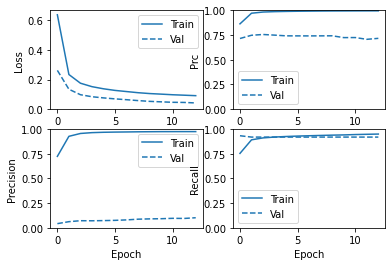

In [50]:
plot_metrics(resampled_history)

### Re-train


Because training is easier on the balanced data, the above training procedure may overfit quickly. 

So break up the epochs to give the `tf.keras.callbacks.EarlyStopping` finer control over when to stop training.

In [51]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_ds))

Epoch 1/1000


 1/20 [>.............................] - ETA: 30s - loss: 2.5988 - tp: 289.0000 - fp: 1016.0000 - tn: 45475.0000 - fn: 837.0000 - accuracy: 0.9611 - precision: 0.2215 - recall: 0.2567 - auc: 0.7556 - prc: 0.1985

 4/20 [=====>........................] - ETA: 0s - loss: 2.4544 - tp: 1038.0000 - fp: 2486.0000 - tn: 47044.0000 - fn: 3193.0000 - accuracy: 0.8944 - precision: 0.2946 - recall: 0.2453 - auc: 0.7291 - prc: 0.2547

 7/20 [=========>....................] - ETA: 0s - loss: 2.3294 - tp: 1886.0000 - fp: 3983.0000 - tn: 48638.0000 - fn: 5398.0000 - accuracy: 0.8434 - precision: 0.3213 - recall: 0.2589 - auc: 0.7111 - prc: 0.3038

10/20 [==============>...............] - ETA: 0s - loss: 2.2434 - tp: 2745.0000 - fp: 5474.0000 - tn: 50252.0000 - fn: 7578.0000 - accuracy: 0.8024 - precision: 0.3340 - recall: 0.2659 - auc: 0.6949 - prc: 0.3336

13/20 [==================>...........] - ETA: 0s - loss: 2.1662 - tp: 3710.0000 - fp: 6987.0000 - tn: 51827.0000 - fn: 9669.0000 - accuracy: 0.7693 - precision: 0.3468 - recall: 0.2773 - auc: 0.6830 - prc: 0.3623

16/20 [=======================>......] - ETA: 0s - loss: 2.0961 - tp: 4778.0000 - fp: 8430.0000 - tn: 53378.0000 - fn: 11751.0000 - accuracy: 0.7424 - precision: 0.3618 - recall: 0.2891 - auc: 0.6736 - prc: 0.3887

19/20 [===========================>..] - ETA: 0s - loss: 2.0245 - tp: 5892.0000 - fp: 9989.0000 - tn: 54926.0000 - fn: 13674.0000 - accuracy: 0.7199 - precision: 0.3710 - recall: 0.3011 - auc: 0.6652 - prc: 0.4086

20/20 [==============================] - 3s 76ms/step - loss: 2.0054 - tp: 6299.0000 - fp: 10480.0000 - tn: 55419.0000 - fn: 14331.0000 - accuracy: 0.7133 - precision: 0.3754 - recall: 0.3053 - auc: 0.6631 - prc: 0.4161 - val_loss: 0.7601 - val_tp: 21.0000 - val_fp: 21680.0000 - val_tn: 23816.0000 - val_fn: 52.0000 - val_accuracy: 0.5231 - val_precision: 9.6770e-04 - val_recall: 0.2877 - val_auc: 0.3172 - val_prc: 0.0014


Epoch 2/1000


 1/20 [>.............................] - ETA: 0s - loss: 1.4751 - tp: 420.0000 - fp: 533.0000 - tn: 488.0000 - fn: 607.0000 - accuracy: 0.4434 - precision: 0.4407 - recall: 0.4090 - auc: 0.4090 - prc: 0.5627

 5/20 [======>.......................] - ETA: 0s - loss: 1.4513 - tp: 2178.0000 - fp: 2604.0000 - tn: 2537.0000 - fn: 2921.0000 - accuracy: 0.4604 - precision: 0.4555 - recall: 0.4271 - auc: 0.4244 - prc: 0.5747

 8/20 [===========>..................] - ETA: 0s - loss: 1.4102 - tp: 3602.0000 - fp: 4118.0000 - tn: 4106.0000 - fn: 4558.0000 - accuracy: 0.4705 - precision: 0.4666 - recall: 0.4414 - auc: 0.4383 - prc: 0.5877

11/20 [===============>..............] - ETA: 0s - loss: 1.3571 - tp: 5164.0000 - fp: 5566.0000 - tn: 5684.0000 - fn: 6114.0000 - accuracy: 0.4815 - precision: 0.4813 - recall: 0.4579 - auc: 0.4562 - prc: 0.6060

14/20 [====================>.........] - ETA: 0s - loss: 1.3188 - tp: 6792.0000 - fp: 7084.0000 - tn: 7226.0000 - fn: 7570.0000 - accuracy: 0.4889 - precision: 0.4895 - recall: 0.4729 - auc: 0.4702 - prc: 0.6181

17/20 [========================>.....] - ETA: 0s - loss: 1.2775 - tp: 8469.0000 - fp: 8596.0000 - tn: 8789.0000 - fn: 8962.0000 - accuracy: 0.4957 - precision: 0.4963 - recall: 0.4859 - auc: 0.4841 - prc: 0.6301

20/20 [==============================] - ETA: 0s - loss: 1.2359 - tp: 10247.0000 - fp: 10132.0000 - tn: 10397.0000 - fn: 10184.0000 - accuracy: 0.5040 - precision: 0.5028 - recall: 0.5015 - auc: 0.4999 - prc: 0.6413

20/20 [==============================] - 0s 24ms/step - loss: 1.2359 - tp: 10247.0000 - fp: 10132.0000 - tn: 10397.0000 - fn: 10184.0000 - accuracy: 0.5040 - precision: 0.5028 - recall: 0.5015 - auc: 0.4999 - prc: 0.6413 - val_loss: 0.7564 - val_tp: 48.0000 - val_fp: 21320.0000 - val_tn: 24176.0000 - val_fn: 25.0000 - val_accuracy: 0.5316 - val_precision: 0.0022 - val_recall: 0.6575 - val_auc: 0.6533 - val_prc: 0.0485


Epoch 3/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.9941 - tp: 578.0000 - fp: 527.0000 - tn: 555.0000 - fn: 388.0000 - accuracy: 0.5532 - precision: 0.5231 - recall: 0.5983 - auc: 0.5991 - prc: 0.6971

 5/20 [======>.......................] - ETA: 0s - loss: 0.9677 - tp: 3065.0000 - fp: 2530.0000 - tn: 2651.0000 - fn: 1994.0000 - accuracy: 0.5582 - precision: 0.5478 - recall: 0.6059 - auc: 0.6059 - prc: 0.7175

 8/20 [===========>..................] - ETA: 0s - loss: 0.9410 - tp: 5076.0000 - fp: 4017.0000 - tn: 4198.0000 - fn: 3093.0000 - accuracy: 0.5660 - precision: 0.5582 - recall: 0.6214 - auc: 0.6201 - prc: 0.7314

11/20 [===============>..............] - ETA: 0s - loss: 0.9206 - tp: 7122.0000 - fp: 5493.0000 - tn: 5737.0000 - fn: 4176.0000 - accuracy: 0.5708 - precision: 0.5646 - recall: 0.6304 - auc: 0.6288 - prc: 0.7386

14/20 [====================>.........] - ETA: 0s - loss: 0.8985 - tp: 9261.0000 - fp: 6904.0000 - tn: 7353.0000 - fn: 5154.0000 - accuracy: 0.5795 - precision: 0.5729 - recall: 0.6425 - auc: 0.6402 - prc: 0.7476

17/20 [========================>.....] - ETA: 0s - loss: 0.8767 - tp: 11414.0000 - fp: 8310.0000 - tn: 9024.0000 - fn: 6068.0000 - accuracy: 0.5870 - precision: 0.5787 - recall: 0.6529 - auc: 0.6511 - prc: 0.7558

20/20 [==============================] - ETA: 0s - loss: 0.8576 - tp: 13612.0000 - fp: 9694.0000 - tn: 10667.0000 - fn: 6987.0000 - accuracy: 0.5927 - precision: 0.5841 - recall: 0.6608 - auc: 0.6607 - prc: 0.7634

20/20 [==============================] - 0s 24ms/step - loss: 0.8576 - tp: 13612.0000 - fp: 9694.0000 - tn: 10667.0000 - fn: 6987.0000 - accuracy: 0.5927 - precision: 0.5841 - recall: 0.6608 - auc: 0.6607 - prc: 0.7634 - val_loss: 0.7143 - val_tp: 63.0000 - val_fp: 19194.0000 - val_tn: 26302.0000 - val_fn: 10.0000 - val_accuracy: 0.5786 - val_precision: 0.0033 - val_recall: 0.8630 - val_auc: 0.8577 - val_prc: 0.1507


Epoch 4/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.7222 - tp: 751.0000 - fp: 462.0000 - tn: 575.0000 - fn: 260.0000 - accuracy: 0.6475 - precision: 0.6191 - recall: 0.7428 - auc: 0.7371 - prc: 0.8123

 5/20 [======>.......................] - ETA: 0s - loss: 0.7277 - tp: 3744.0000 - fp: 2296.0000 - tn: 2829.0000 - fn: 1371.0000 - accuracy: 0.6419 - precision: 0.6199 - recall: 0.7320 - auc: 0.7328 - prc: 0.8126

 8/20 [===========>..................] - ETA: 0s - loss: 0.7150 - tp: 6043.0000 - fp: 3590.0000 - tn: 4575.0000 - fn: 2176.0000 - accuracy: 0.6481 - precision: 0.6273 - recall: 0.7352 - auc: 0.7387 - prc: 0.8176

11/20 [===============>..............] - ETA: 0s - loss: 0.7102 - tp: 8312.0000 - fp: 4956.0000 - tn: 6320.0000 - fn: 2940.0000 - accuracy: 0.6495 - precision: 0.6265 - recall: 0.7387 - auc: 0.7425 - prc: 0.8191

14/20 [====================>.........] - ETA: 0s - loss: 0.7002 - tp: 10626.0000 - fp: 6251.0000 - tn: 8116.0000 - fn: 3679.0000 - accuracy: 0.6537 - precision: 0.6296 - recall: 0.7428 - auc: 0.7481 - prc: 0.8233

17/20 [========================>.....] - ETA: 0s - loss: 0.6895 - tp: 12892.0000 - fp: 7468.0000 - tn: 10007.0000 - fn: 4449.0000 - accuracy: 0.6577 - precision: 0.6332 - recall: 0.7434 - auc: 0.7525 - prc: 0.8267

20/20 [==============================] - ETA: 0s - loss: 0.6847 - tp: 15195.0000 - fp: 8650.0000 - tn: 11869.0000 - fn: 5246.0000 - accuracy: 0.6607 - precision: 0.6372 - recall: 0.7434 - auc: 0.7550 - prc: 0.8294

20/20 [==============================] - 0s 24ms/step - loss: 0.6847 - tp: 15195.0000 - fp: 8650.0000 - tn: 11869.0000 - fn: 5246.0000 - accuracy: 0.6607 - precision: 0.6372 - recall: 0.7434 - auc: 0.7550 - prc: 0.8294 - val_loss: 0.6522 - val_tp: 65.0000 - val_fp: 16012.0000 - val_tn: 29484.0000 - val_fn: 8.0000 - val_accuracy: 0.6484 - val_precision: 0.0040 - val_recall: 0.8904 - val_auc: 0.9065 - val_prc: 0.2609


Epoch 5/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.6154 - tp: 813.0000 - fp: 366.0000 - tn: 610.0000 - fn: 259.0000 - accuracy: 0.6948 - precision: 0.6896 - recall: 0.7584 - auc: 0.7848 - prc: 0.8594

 5/20 [======>.......................] - ETA: 0s - loss: 0.6142 - tp: 3973.0000 - fp: 1956.0000 - tn: 3111.0000 - fn: 1200.0000 - accuracy: 0.6918 - precision: 0.6701 - recall: 0.7680 - auc: 0.7907 - prc: 0.8581

 8/20 [===========>..................] - ETA: 0s - loss: 0.6041 - tp: 6406.0000 - fp: 3118.0000 - tn: 4983.0000 - fn: 1877.0000 - accuracy: 0.6951 - precision: 0.6726 - recall: 0.7734 - auc: 0.7963 - prc: 0.8623

11/20 [===============>..............] - ETA: 0s - loss: 0.6010 - tp: 8763.0000 - fp: 4277.0000 - tn: 6932.0000 - fn: 2556.0000 - accuracy: 0.6967 - precision: 0.6720 - recall: 0.7742 - auc: 0.7979 - prc: 0.8623

14/20 [====================>.........] - ETA: 0s - loss: 0.5978 - tp: 11202.0000 - fp: 5417.0000 - tn: 8811.0000 - fn: 3242.0000 - accuracy: 0.6980 - precision: 0.6740 - recall: 0.7755 - auc: 0.7997 - prc: 0.8640

17/20 [========================>.....] - ETA: 0s - loss: 0.5898 - tp: 13651.0000 - fp: 6500.0000 - tn: 10799.0000 - fn: 3866.0000 - accuracy: 0.7023 - precision: 0.6774 - recall: 0.7793 - auc: 0.8038 - prc: 0.8665

20/20 [==============================] - ETA: 0s - loss: 0.5836 - tp: 16133.0000 - fp: 7573.0000 - tn: 12751.0000 - fn: 4503.0000 - accuracy: 0.7052 - precision: 0.6805 - recall: 0.7818 - auc: 0.8069 - prc: 0.8688

20/20 [==============================] - 0s 24ms/step - loss: 0.5836 - tp: 16133.0000 - fp: 7573.0000 - tn: 12751.0000 - fn: 4503.0000 - accuracy: 0.7052 - precision: 0.6805 - recall: 0.7818 - auc: 0.8069 - prc: 0.8688 - val_loss: 0.5896 - val_tp: 66.0000 - val_fp: 12822.0000 - val_tn: 32674.0000 - val_fn: 7.0000 - val_accuracy: 0.7185 - val_precision: 0.0051 - val_recall: 0.9041 - val_auc: 0.9259 - val_prc: 0.3880


Epoch 6/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.5560 - tp: 816.0000 - fp: 344.0000 - tn: 681.0000 - fn: 207.0000 - accuracy: 0.7310 - precision: 0.7034 - recall: 0.7977 - auc: 0.8240 - prc: 0.8784

 5/20 [======>.......................] - ETA: 0s - loss: 0.5465 - tp: 4026.0000 - fp: 1785.0000 - tn: 3360.0000 - fn: 1069.0000 - accuracy: 0.7213 - precision: 0.6928 - recall: 0.7902 - auc: 0.8236 - prc: 0.8789

 8/20 [===========>..................] - ETA: 0s - loss: 0.5346 - tp: 6521.0000 - fp: 2738.0000 - tn: 5468.0000 - fn: 1657.0000 - accuracy: 0.7318 - precision: 0.7043 - recall: 0.7974 - auc: 0.8316 - prc: 0.8850

11/20 [===============>..............] - ETA: 0s - loss: 0.5315 - tp: 9000.0000 - fp: 3738.0000 - tn: 7553.0000 - fn: 2237.0000 - accuracy: 0.7348 - precision: 0.7065 - recall: 0.8009 - auc: 0.8349 - prc: 0.8864

14/20 [====================>.........] - ETA: 0s - loss: 0.5281 - tp: 11481.0000 - fp: 4724.0000 - tn: 9633.0000 - fn: 2834.0000 - accuracy: 0.7364 - precision: 0.7085 - recall: 0.8020 - auc: 0.8369 - prc: 0.8874

17/20 [========================>.....] - ETA: 0s - loss: 0.5225 - tp: 13996.0000 - fp: 5613.0000 - tn: 11781.0000 - fn: 3426.0000 - accuracy: 0.7404 - precision: 0.7138 - recall: 0.8034 - auc: 0.8395 - prc: 0.8897

20/20 [==============================] - ETA: 0s - loss: 0.5186 - tp: 16451.0000 - fp: 6555.0000 - tn: 13918.0000 - fn: 4036.0000 - accuracy: 0.7414 - precision: 0.7151 - recall: 0.8030 - auc: 0.8409 - prc: 0.8907

20/20 [==============================] - 0s 24ms/step - loss: 0.5186 - tp: 16451.0000 - fp: 6555.0000 - tn: 13918.0000 - fn: 4036.0000 - accuracy: 0.7414 - precision: 0.7151 - recall: 0.8030 - auc: 0.8409 - prc: 0.8907 - val_loss: 0.5300 - val_tp: 67.0000 - val_fp: 9680.0000 - val_tn: 35816.0000 - val_fn: 6.0000 - val_accuracy: 0.7874 - val_precision: 0.0069 - val_recall: 0.9178 - val_auc: 0.9434 - val_prc: 0.5008


Epoch 7/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.5057 - tp: 823.0000 - fp: 300.0000 - tn: 732.0000 - fn: 193.0000 - accuracy: 0.7593 - precision: 0.7329 - recall: 0.8100 - auc: 0.8511 - prc: 0.8961

 5/20 [======>.......................] - ETA: 0s - loss: 0.4951 - tp: 4165.0000 - fp: 1462.0000 - tn: 3636.0000 - fn: 977.0000 - accuracy: 0.7618 - precision: 0.7402 - recall: 0.8100 - auc: 0.8526 - prc: 0.8980

 8/20 [===========>..................] - ETA: 0s - loss: 0.4923 - tp: 6610.0000 - fp: 2378.0000 - tn: 5835.0000 - fn: 1561.0000 - accuracy: 0.7596 - precision: 0.7354 - recall: 0.8090 - auc: 0.8536 - prc: 0.8981

11/20 [===============>..............] - ETA: 0s - loss: 0.4893 - tp: 9131.0000 - fp: 3254.0000 - tn: 8015.0000 - fn: 2128.0000 - accuracy: 0.7611 - precision: 0.7373 - recall: 0.8110 - auc: 0.8557 - prc: 0.9000

14/20 [====================>.........] - ETA: 0s - loss: 0.4872 - tp: 11633.0000 - fp: 4105.0000 - tn: 10247.0000 - fn: 2687.0000 - accuracy: 0.7631 - precision: 0.7392 - recall: 0.8124 - auc: 0.8564 - prc: 0.9005

17/20 [========================>.....] - ETA: 0s - loss: 0.4833 - tp: 14215.0000 - fp: 4911.0000 - tn: 12428.0000 - fn: 3262.0000 - accuracy: 0.7653 - precision: 0.7432 - recall: 0.8134 - auc: 0.8576 - prc: 0.9018

20/20 [==============================] - ETA: 0s - loss: 0.4782 - tp: 16712.0000 - fp: 5743.0000 - tn: 14709.0000 - fn: 3796.0000 - accuracy: 0.7671 - precision: 0.7442 - recall: 0.8149 - auc: 0.8600 - prc: 0.9032

20/20 [==============================] - 0s 24ms/step - loss: 0.4782 - tp: 16712.0000 - fp: 5743.0000 - tn: 14709.0000 - fn: 3796.0000 - accuracy: 0.7671 - precision: 0.7442 - recall: 0.8149 - auc: 0.8600 - prc: 0.9032 - val_loss: 0.4763 - val_tp: 68.0000 - val_fp: 7080.0000 - val_tn: 38416.0000 - val_fn: 5.0000 - val_accuracy: 0.8445 - val_precision: 0.0095 - val_recall: 0.9315 - val_auc: 0.9555 - val_prc: 0.5643


Epoch 8/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.4521 - tp: 866.0000 - fp: 274.0000 - tn: 718.0000 - fn: 190.0000 - accuracy: 0.7734 - precision: 0.7596 - recall: 0.8201 - auc: 0.8676 - prc: 0.9130

 5/20 [======>.......................] - ETA: 0s - loss: 0.4488 - tp: 4191.0000 - fp: 1354.0000 - tn: 3818.0000 - fn: 877.0000 - accuracy: 0.7821 - precision: 0.7558 - recall: 0.8270 - auc: 0.8744 - prc: 0.9117

 8/20 [===========>..................] - ETA: 0s - loss: 0.4488 - tp: 6715.0000 - fp: 2130.0000 - tn: 6115.0000 - fn: 1424.0000 - accuracy: 0.7831 - precision: 0.7592 - recall: 0.8250 - auc: 0.8739 - prc: 0.9120

11/20 [===============>..............] - ETA: 0s - loss: 0.4454 - tp: 9259.0000 - fp: 2856.0000 - tn: 8453.0000 - fn: 1960.0000 - accuracy: 0.7862 - precision: 0.7643 - recall: 0.8253 - auc: 0.8749 - prc: 0.9131

14/20 [====================>.........] - ETA: 0s - loss: 0.4428 - tp: 11738.0000 - fp: 3626.0000 - tn: 10836.0000 - fn: 2472.0000 - accuracy: 0.7873 - precision: 0.7640 - recall: 0.8260 - auc: 0.8765 - prc: 0.9134

17/20 [========================>.....] - ETA: 0s - loss: 0.4388 - tp: 14279.0000 - fp: 4330.0000 - tn: 13244.0000 - fn: 2963.0000 - accuracy: 0.7905 - precision: 0.7673 - recall: 0.8282 - auc: 0.8788 - prc: 0.9148

20/20 [==============================] - ETA: 0s - loss: 0.4357 - tp: 16815.0000 - fp: 4970.0000 - tn: 15687.0000 - fn: 3488.0000 - accuracy: 0.7935 - precision: 0.7719 - recall: 0.8282 - auc: 0.8799 - prc: 0.9157

20/20 [==============================] - 0s 24ms/step - loss: 0.4357 - tp: 16815.0000 - fp: 4970.0000 - tn: 15687.0000 - fn: 3488.0000 - accuracy: 0.7935 - precision: 0.7719 - recall: 0.8282 - auc: 0.8799 - prc: 0.9157 - val_loss: 0.4287 - val_tp: 68.0000 - val_fp: 4974.0000 - val_tn: 40522.0000 - val_fn: 5.0000 - val_accuracy: 0.8907 - val_precision: 0.0135 - val_recall: 0.9315 - val_auc: 0.9642 - val_prc: 0.6281


Epoch 9/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.4117 - tp: 835.0000 - fp: 208.0000 - tn: 828.0000 - fn: 177.0000 - accuracy: 0.8120 - precision: 0.8006 - recall: 0.8251 - auc: 0.8860 - prc: 0.9168

 5/20 [======>.......................] - ETA: 0s - loss: 0.4206 - tp: 4256.0000 - fp: 1103.0000 - tn: 3973.0000 - fn: 908.0000 - accuracy: 0.8036 - precision: 0.7942 - recall: 0.8242 - auc: 0.8826 - prc: 0.9190

 8/20 [===========>..................] - ETA: 0s - loss: 0.4163 - tp: 6791.0000 - fp: 1739.0000 - tn: 6446.0000 - fn: 1408.0000 - accuracy: 0.8079 - precision: 0.7961 - recall: 0.8283 - auc: 0.8867 - prc: 0.9208

11/20 [===============>..............] - ETA: 0s - loss: 0.4123 - tp: 9337.0000 - fp: 2334.0000 - tn: 8956.0000 - fn: 1901.0000 - accuracy: 0.8120 - precision: 0.8000 - recall: 0.8308 - auc: 0.8890 - prc: 0.9223

14/20 [====================>.........] - ETA: 0s - loss: 0.4093 - tp: 11874.0000 - fp: 2947.0000 - tn: 11409.0000 - fn: 2442.0000 - accuracy: 0.8120 - precision: 0.8012 - recall: 0.8294 - auc: 0.8898 - prc: 0.9226

17/20 [========================>.....] - ETA: 0s - loss: 0.4069 - tp: 14397.0000 - fp: 3529.0000 - tn: 13950.0000 - fn: 2940.0000 - accuracy: 0.8142 - precision: 0.8031 - recall: 0.8304 - auc: 0.8913 - prc: 0.9233

20/20 [==============================] - ETA: 0s - loss: 0.4052 - tp: 16931.0000 - fp: 4132.0000 - tn: 16459.0000 - fn: 3438.0000 - accuracy: 0.8152 - precision: 0.8038 - recall: 0.8312 - auc: 0.8922 - prc: 0.9238

20/20 [==============================] - 0s 23ms/step - loss: 0.4052 - tp: 16931.0000 - fp: 4132.0000 - tn: 16459.0000 - fn: 3438.0000 - accuracy: 0.8152 - precision: 0.8038 - recall: 0.8312 - auc: 0.8922 - prc: 0.9238 - val_loss: 0.3893 - val_tp: 68.0000 - val_fp: 3646.0000 - val_tn: 41850.0000 - val_fn: 5.0000 - val_accuracy: 0.9199 - val_precision: 0.0183 - val_recall: 0.9315 - val_auc: 0.9709 - val_prc: 0.6681


Epoch 10/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.3619 - tp: 895.0000 - fp: 165.0000 - tn: 833.0000 - fn: 155.0000 - accuracy: 0.8438 - precision: 0.8443 - recall: 0.8524 - auc: 0.9125 - prc: 0.9416

 5/20 [======>.......................] - ETA: 0s - loss: 0.3814 - tp: 4305.0000 - fp: 927.0000 - tn: 4192.0000 - fn: 816.0000 - accuracy: 0.8298 - precision: 0.8228 - recall: 0.8407 - auc: 0.9041 - prc: 0.9327

 8/20 [===========>..................] - ETA: 0s - loss: 0.3798 - tp: 6927.0000 - fp: 1484.0000 - tn: 6675.0000 - fn: 1298.0000 - accuracy: 0.8302 - precision: 0.8236 - recall: 0.8422 - auc: 0.9045 - prc: 0.9335

11/20 [===============>..............] - ETA: 0s - loss: 0.3778 - tp: 9517.0000 - fp: 2045.0000 - tn: 9179.0000 - fn: 1787.0000 - accuracy: 0.8299 - precision: 0.8231 - recall: 0.8419 - auc: 0.9056 - prc: 0.9339

14/20 [====================>.........] - ETA: 0s - loss: 0.3747 - tp: 12145.0000 - fp: 2582.0000 - tn: 11703.0000 - fn: 2242.0000 - accuracy: 0.8318 - precision: 0.8247 - recall: 0.8442 - auc: 0.9071 - prc: 0.9351

17/20 [========================>.....] - ETA: 0s - loss: 0.3719 - tp: 14725.0000 - fp: 3090.0000 - tn: 14293.0000 - fn: 2708.0000 - accuracy: 0.8335 - precision: 0.8266 - recall: 0.8447 - auc: 0.9083 - prc: 0.9357

20/20 [==============================] - ETA: 0s - loss: 0.3701 - tp: 17362.0000 - fp: 3603.0000 - tn: 16820.0000 - fn: 3175.0000 - accuracy: 0.8345 - precision: 0.8281 - recall: 0.8454 - auc: 0.9093 - prc: 0.9364

20/20 [==============================] - 0s 25ms/step - loss: 0.3701 - tp: 17362.0000 - fp: 3603.0000 - tn: 16820.0000 - fn: 3175.0000 - accuracy: 0.8345 - precision: 0.8281 - recall: 0.8454 - auc: 0.9093 - prc: 0.9364 - val_loss: 0.3556 - val_tp: 69.0000 - val_fp: 2818.0000 - val_tn: 42678.0000 - val_fn: 4.0000 - val_accuracy: 0.9381 - val_precision: 0.0239 - val_recall: 0.9452 - val_auc: 0.9771 - val_prc: 0.6858


Epoch 11/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.3614 - tp: 884.0000 - fp: 156.0000 - tn: 850.0000 - fn: 158.0000 - accuracy: 0.8467 - precision: 0.8500 - recall: 0.8484 - auc: 0.9159 - prc: 0.9379

 5/20 [======>.......................] - ETA: 0s - loss: 0.3571 - tp: 4441.0000 - fp: 818.0000 - tn: 4204.0000 - fn: 777.0000 - accuracy: 0.8442 - precision: 0.8445 - recall: 0.8511 - auc: 0.9148 - prc: 0.9410

 8/20 [===========>..................] - ETA: 0s - loss: 0.3570 - tp: 7079.0000 - fp: 1321.0000 - tn: 6748.0000 - fn: 1236.0000 - accuracy: 0.8439 - precision: 0.8427 - recall: 0.8514 - auc: 0.9151 - prc: 0.9406

11/20 [===============>..............] - ETA: 0s - loss: 0.3535 - tp: 9706.0000 - fp: 1789.0000 - tn: 9364.0000 - fn: 1669.0000 - accuracy: 0.8465 - precision: 0.8444 - recall: 0.8533 - auc: 0.9170 - prc: 0.9412

14/20 [====================>.........] - ETA: 0s - loss: 0.3515 - tp: 12378.0000 - fp: 2250.0000 - tn: 11913.0000 - fn: 2131.0000 - accuracy: 0.8472 - precision: 0.8462 - recall: 0.8531 - auc: 0.9176 - prc: 0.9418

17/20 [========================>.....] - ETA: 0s - loss: 0.3521 - tp: 14967.0000 - fp: 2747.0000 - tn: 14526.0000 - fn: 2576.0000 - accuracy: 0.8471 - precision: 0.8449 - recall: 0.8532 - auc: 0.9174 - prc: 0.9414

20/20 [==============================] - ETA: 0s - loss: 0.3507 - tp: 17566.0000 - fp: 3172.0000 - tn: 17183.0000 - fn: 3039.0000 - accuracy: 0.8484 - precision: 0.8470 - recall: 0.8525 - auc: 0.9176 - prc: 0.9416

20/20 [==============================] - 0s 25ms/step - loss: 0.3507 - tp: 17566.0000 - fp: 3172.0000 - tn: 17183.0000 - fn: 3039.0000 - accuracy: 0.8484 - precision: 0.8470 - recall: 0.8525 - auc: 0.9176 - prc: 0.9416 - val_loss: 0.3269 - val_tp: 69.0000 - val_fp: 2256.0000 - val_tn: 43240.0000 - val_fn: 4.0000 - val_accuracy: 0.9504 - val_precision: 0.0297 - val_recall: 0.9452 - val_auc: 0.9811 - val_prc: 0.6952


Epoch 12/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.3320 - tp: 853.0000 - fp: 153.0000 - tn: 894.0000 - fn: 148.0000 - accuracy: 0.8530 - precision: 0.8479 - recall: 0.8521 - auc: 0.9249 - prc: 0.9436

 5/20 [======>.......................] - ETA: 0s - loss: 0.3410 - tp: 4244.0000 - fp: 788.0000 - tn: 4502.0000 - fn: 706.0000 - accuracy: 0.8541 - precision: 0.8434 - recall: 0.8574 - auc: 0.9242 - prc: 0.9419

 8/20 [===========>..................] - ETA: 0s - loss: 0.3403 - tp: 6895.0000 - fp: 1219.0000 - tn: 7122.0000 - fn: 1148.0000 - accuracy: 0.8555 - precision: 0.8498 - recall: 0.8573 - auc: 0.9238 - prc: 0.9432

11/20 [===============>..............] - ETA: 0s - loss: 0.3389 - tp: 9494.0000 - fp: 1663.0000 - tn: 9799.0000 - fn: 1572.0000 - accuracy: 0.8564 - precision: 0.8509 - recall: 0.8579 - auc: 0.9247 - prc: 0.9440

14/20 [====================>.........] - ETA: 0s - loss: 0.3364 - tp: 12108.0000 - fp: 2070.0000 - tn: 12522.0000 - fn: 1972.0000 - accuracy: 0.8590 - precision: 0.8540 - recall: 0.8599 - auc: 0.9258 - prc: 0.9448

17/20 [========================>.....] - ETA: 0s - loss: 0.3336 - tp: 14741.0000 - fp: 2455.0000 - tn: 15233.0000 - fn: 2387.0000 - accuracy: 0.8609 - precision: 0.8572 - recall: 0.8606 - auc: 0.9267 - prc: 0.9457

20/20 [==============================] - ETA: 0s - loss: 0.3325 - tp: 17372.0000 - fp: 2859.0000 - tn: 17890.0000 - fn: 2839.0000 - accuracy: 0.8609 - precision: 0.8587 - recall: 0.8595 - auc: 0.9268 - prc: 0.9460

20/20 [==============================] - 0s 25ms/step - loss: 0.3325 - tp: 17372.0000 - fp: 2859.0000 - tn: 17890.0000 - fn: 2839.0000 - accuracy: 0.8609 - precision: 0.8587 - recall: 0.8595 - auc: 0.9268 - prc: 0.9460 - val_loss: 0.2991 - val_tp: 68.0000 - val_fp: 1867.0000 - val_tn: 43629.0000 - val_fn: 5.0000 - val_accuracy: 0.9589 - val_precision: 0.0351 - val_recall: 0.9315 - val_auc: 0.9837 - val_prc: 0.7017


Epoch 13/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.3256 - tp: 882.0000 - fp: 154.0000 - tn: 877.0000 - fn: 135.0000 - accuracy: 0.8589 - precision: 0.8514 - recall: 0.8673 - auc: 0.9315 - prc: 0.9498

 5/20 [======>.......................] - ETA: 0s - loss: 0.3205 - tp: 4406.0000 - fp: 672.0000 - tn: 4446.0000 - fn: 716.0000 - accuracy: 0.8645 - precision: 0.8677 - recall: 0.8602 - auc: 0.9305 - prc: 0.9497

 8/20 [===========>..................] - ETA: 0s - loss: 0.3201 - tp: 7035.0000 - fp: 1034.0000 - tn: 7166.0000 - fn: 1149.0000 - accuracy: 0.8668 - precision: 0.8719 - recall: 0.8596 - auc: 0.9297 - prc: 0.9496

11/20 [===============>..............] - ETA: 0s - loss: 0.3214 - tp: 9659.0000 - fp: 1419.0000 - tn: 9863.0000 - fn: 1587.0000 - accuracy: 0.8666 - precision: 0.8719 - recall: 0.8589 - auc: 0.9287 - prc: 0.9488

14/20 [====================>.........] - ETA: 0s - loss: 0.3217 - tp: 12300.0000 - fp: 1809.0000 - tn: 12542.0000 - fn: 2021.0000 - accuracy: 0.8664 - precision: 0.8718 - recall: 0.8589 - auc: 0.9286 - prc: 0.9486

17/20 [========================>.....] - ETA: 0s - loss: 0.3183 - tp: 15026.0000 - fp: 2147.0000 - tn: 15209.0000 - fn: 2434.0000 - accuracy: 0.8684 - precision: 0.8750 - recall: 0.8606 - auc: 0.9302 - prc: 0.9499

20/20 [==============================] - ETA: 0s - loss: 0.3169 - tp: 17690.0000 - fp: 2524.0000 - tn: 17896.0000 - fn: 2850.0000 - accuracy: 0.8688 - precision: 0.8751 - recall: 0.8612 - auc: 0.9308 - prc: 0.9503

20/20 [==============================] - 0s 24ms/step - loss: 0.3169 - tp: 17690.0000 - fp: 2524.0000 - tn: 17896.0000 - fn: 2850.0000 - accuracy: 0.8688 - precision: 0.8751 - recall: 0.8612 - auc: 0.9308 - prc: 0.9503 - val_loss: 0.2772 - val_tp: 68.0000 - val_fp: 1629.0000 - val_tn: 43867.0000 - val_fn: 5.0000 - val_accuracy: 0.9641 - val_precision: 0.0401 - val_recall: 0.9315 - val_auc: 0.9858 - val_prc: 0.7106


Epoch 14/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.3018 - tp: 887.0000 - fp: 98.0000 - tn: 933.0000 - fn: 130.0000 - accuracy: 0.8887 - precision: 0.9005 - recall: 0.8722 - auc: 0.9388 - prc: 0.9541

 5/20 [======>.......................] - ETA: 0s - loss: 0.3027 - tp: 4350.0000 - fp: 582.0000 - tn: 4643.0000 - fn: 665.0000 - accuracy: 0.8782 - precision: 0.8820 - recall: 0.8674 - auc: 0.9379 - prc: 0.9531

 8/20 [===========>..................] - ETA: 0s - loss: 0.3016 - tp: 7015.0000 - fp: 920.0000 - tn: 7367.0000 - fn: 1082.0000 - accuracy: 0.8778 - precision: 0.8841 - recall: 0.8664 - auc: 0.9378 - prc: 0.9539

11/20 [===============>..............] - ETA: 0s - loss: 0.3001 - tp: 9670.0000 - fp: 1251.0000 - tn: 10105.0000 - fn: 1502.0000 - accuracy: 0.8778 - precision: 0.8855 - recall: 0.8656 - auc: 0.9380 - prc: 0.9542

14/20 [====================>.........] - ETA: 0s - loss: 0.2987 - tp: 12329.0000 - fp: 1566.0000 - tn: 12881.0000 - fn: 1896.0000 - accuracy: 0.8793 - precision: 0.8873 - recall: 0.8667 - auc: 0.9390 - prc: 0.9549

17/20 [========================>.....] - ETA: 0s - loss: 0.2998 - tp: 14981.0000 - fp: 1909.0000 - tn: 15619.0000 - fn: 2307.0000 - accuracy: 0.8789 - precision: 0.8870 - recall: 0.8666 - auc: 0.9387 - prc: 0.9546

20/20 [==============================] - ETA: 0s - loss: 0.2969 - tp: 17677.0000 - fp: 2190.0000 - tn: 18385.0000 - fn: 2708.0000 - accuracy: 0.8804 - precision: 0.8898 - recall: 0.8672 - auc: 0.9400 - prc: 0.9555

20/20 [==============================] - 0s 24ms/step - loss: 0.2969 - tp: 17677.0000 - fp: 2190.0000 - tn: 18385.0000 - fn: 2708.0000 - accuracy: 0.8804 - precision: 0.8898 - recall: 0.8672 - auc: 0.9400 - prc: 0.9555 - val_loss: 0.2586 - val_tp: 68.0000 - val_fp: 1477.0000 - val_tn: 44019.0000 - val_fn: 5.0000 - val_accuracy: 0.9675 - val_precision: 0.0440 - val_recall: 0.9315 - val_auc: 0.9874 - val_prc: 0.7132


Epoch 15/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2944 - tp: 904.0000 - fp: 116.0000 - tn: 892.0000 - fn: 136.0000 - accuracy: 0.8770 - precision: 0.8863 - recall: 0.8692 - auc: 0.9396 - prc: 0.9570

 5/20 [======>.......................] - ETA: 0s - loss: 0.2965 - tp: 4422.0000 - fp: 536.0000 - tn: 4600.0000 - fn: 682.0000 - accuracy: 0.8811 - precision: 0.8919 - recall: 0.8664 - auc: 0.9389 - prc: 0.9553

 8/20 [===========>..................] - ETA: 0s - loss: 0.2934 - tp: 7070.0000 - fp: 858.0000 - tn: 7363.0000 - fn: 1093.0000 - accuracy: 0.8809 - precision: 0.8918 - recall: 0.8661 - auc: 0.9405 - prc: 0.9562

11/20 [===============>..............] - ETA: 0s - loss: 0.2906 - tp: 9707.0000 - fp: 1162.0000 - tn: 10183.0000 - fn: 1476.0000 - accuracy: 0.8829 - precision: 0.8931 - recall: 0.8680 - auc: 0.9420 - prc: 0.9570

14/20 [====================>.........] - ETA: 0s - loss: 0.2891 - tp: 12353.0000 - fp: 1453.0000 - tn: 12988.0000 - fn: 1878.0000 - accuracy: 0.8838 - precision: 0.8948 - recall: 0.8680 - auc: 0.9425 - prc: 0.9573

17/20 [========================>.....] - ETA: 0s - loss: 0.2894 - tp: 14994.0000 - fp: 1754.0000 - tn: 15773.0000 - fn: 2295.0000 - accuracy: 0.8837 - precision: 0.8953 - recall: 0.8673 - auc: 0.9422 - prc: 0.9572

20/20 [==============================] - ETA: 0s - loss: 0.2867 - tp: 17761.0000 - fp: 2037.0000 - tn: 18478.0000 - fn: 2684.0000 - accuracy: 0.8847 - precision: 0.8971 - recall: 0.8687 - auc: 0.9435 - prc: 0.9583

20/20 [==============================] - 0s 24ms/step - loss: 0.2867 - tp: 17761.0000 - fp: 2037.0000 - tn: 18478.0000 - fn: 2684.0000 - accuracy: 0.8847 - precision: 0.8971 - recall: 0.8687 - auc: 0.9435 - prc: 0.9583 - val_loss: 0.2422 - val_tp: 68.0000 - val_fp: 1392.0000 - val_tn: 44104.0000 - val_fn: 5.0000 - val_accuracy: 0.9693 - val_precision: 0.0466 - val_recall: 0.9315 - val_auc: 0.9886 - val_prc: 0.7195


Epoch 16/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2688 - tp: 901.0000 - fp: 93.0000 - tn: 925.0000 - fn: 129.0000 - accuracy: 0.8916 - precision: 0.9064 - recall: 0.8748 - auc: 0.9489 - prc: 0.9623

 5/20 [======>.......................] - ETA: 0s - loss: 0.2704 - tp: 4468.0000 - fp: 461.0000 - tn: 4682.0000 - fn: 629.0000 - accuracy: 0.8936 - precision: 0.9065 - recall: 0.8766 - auc: 0.9492 - prc: 0.9625

 8/20 [===========>..................] - ETA: 0s - loss: 0.2732 - tp: 7162.0000 - fp: 740.0000 - tn: 7472.0000 - fn: 1010.0000 - accuracy: 0.8932 - precision: 0.9064 - recall: 0.8764 - auc: 0.9483 - prc: 0.9615

11/20 [===============>..............] - ETA: 0s - loss: 0.2740 - tp: 9871.0000 - fp: 1009.0000 - tn: 10255.0000 - fn: 1393.0000 - accuracy: 0.8934 - precision: 0.9073 - recall: 0.8763 - auc: 0.9483 - prc: 0.9613

14/20 [====================>.........] - ETA: 0s - loss: 0.2736 - tp: 12572.0000 - fp: 1300.0000 - tn: 13033.0000 - fn: 1767.0000 - accuracy: 0.8930 - precision: 0.9063 - recall: 0.8768 - auc: 0.9486 - prc: 0.9615

17/20 [========================>.....] - ETA: 0s - loss: 0.2748 - tp: 15252.0000 - fp: 1577.0000 - tn: 15837.0000 - fn: 2150.0000 - accuracy: 0.8930 - precision: 0.9063 - recall: 0.8765 - auc: 0.9483 - prc: 0.9611

20/20 [==============================] - ETA: 0s - loss: 0.2744 - tp: 18001.0000 - fp: 1857.0000 - tn: 18569.0000 - fn: 2533.0000 - accuracy: 0.8928 - precision: 0.9065 - recall: 0.8766 - auc: 0.9482 - prc: 0.9613

20/20 [==============================] - 0s 25ms/step - loss: 0.2744 - tp: 18001.0000 - fp: 1857.0000 - tn: 18569.0000 - fn: 2533.0000 - accuracy: 0.8928 - precision: 0.9065 - recall: 0.8766 - auc: 0.9482 - prc: 0.9613 - val_loss: 0.2278 - val_tp: 67.0000 - val_fp: 1315.0000 - val_tn: 44181.0000 - val_fn: 6.0000 - val_accuracy: 0.9710 - val_precision: 0.0485 - val_recall: 0.9178 - val_auc: 0.9898 - val_prc: 0.7274


Epoch 17/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2480 - tp: 912.0000 - fp: 90.0000 - tn: 939.0000 - fn: 107.0000 - accuracy: 0.9038 - precision: 0.9102 - recall: 0.8950 - auc: 0.9590 - prc: 0.9689

 5/20 [======>.......................] - ETA: 0s - loss: 0.2642 - tp: 4429.0000 - fp: 477.0000 - tn: 4747.0000 - fn: 587.0000 - accuracy: 0.8961 - precision: 0.9028 - recall: 0.8830 - auc: 0.9527 - prc: 0.9633

 8/20 [===========>..................] - ETA: 0s - loss: 0.2645 - tp: 7150.0000 - fp: 717.0000 - tn: 7551.0000 - fn: 966.0000 - accuracy: 0.8973 - precision: 0.9089 - recall: 0.8810 - auc: 0.9522 - prc: 0.9637

11/20 [===============>..............] - ETA: 0s - loss: 0.2624 - tp: 9849.0000 - fp: 968.0000 - tn: 10392.0000 - fn: 1319.0000 - accuracy: 0.8985 - precision: 0.9105 - recall: 0.8819 - auc: 0.9529 - prc: 0.9642

14/20 [====================>.........] - ETA: 0s - loss: 0.2631 - tp: 12599.0000 - fp: 1228.0000 - tn: 13132.0000 - fn: 1713.0000 - accuracy: 0.8974 - precision: 0.9112 - recall: 0.8803 - auc: 0.9526 - prc: 0.9643

17/20 [========================>.....] - ETA: 0s - loss: 0.2644 - tp: 15255.0000 - fp: 1504.0000 - tn: 15969.0000 - fn: 2088.0000 - accuracy: 0.8968 - precision: 0.9103 - recall: 0.8796 - auc: 0.9521 - prc: 0.9638

20/20 [==============================] - ETA: 0s - loss: 0.2630 - tp: 17977.0000 - fp: 1754.0000 - tn: 18791.0000 - fn: 2438.0000 - accuracy: 0.8977 - precision: 0.9111 - recall: 0.8806 - auc: 0.9528 - prc: 0.9643

20/20 [==============================] - 0s 24ms/step - loss: 0.2630 - tp: 17977.0000 - fp: 1754.0000 - tn: 18791.0000 - fn: 2438.0000 - accuracy: 0.8977 - precision: 0.9111 - recall: 0.8806 - auc: 0.9528 - prc: 0.9643 - val_loss: 0.2148 - val_tp: 67.0000 - val_fp: 1254.0000 - val_tn: 44242.0000 - val_fn: 6.0000 - val_accuracy: 0.9723 - val_precision: 0.0507 - val_recall: 0.9178 - val_auc: 0.9909 - val_prc: 0.7300


Epoch 18/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2689 - tp: 883.0000 - fp: 78.0000 - tn: 961.0000 - fn: 126.0000 - accuracy: 0.9004 - precision: 0.9188 - recall: 0.8751 - auc: 0.9464 - prc: 0.9594

 5/20 [======>.......................] - ETA: 0s - loss: 0.2568 - tp: 4556.0000 - fp: 426.0000 - tn: 4653.0000 - fn: 605.0000 - accuracy: 0.8993 - precision: 0.9145 - recall: 0.8828 - auc: 0.9549 - prc: 0.9659

 8/20 [===========>..................] - ETA: 0s - loss: 0.2558 - tp: 7325.0000 - fp: 685.0000 - tn: 7440.0000 - fn: 934.0000 - accuracy: 0.9012 - precision: 0.9145 - recall: 0.8869 - auc: 0.9562 - prc: 0.9668

11/20 [===============>..............] - ETA: 0s - loss: 0.2559 - tp: 10029.0000 - fp: 923.0000 - tn: 10283.0000 - fn: 1293.0000 - accuracy: 0.9016 - precision: 0.9157 - recall: 0.8858 - auc: 0.9557 - prc: 0.9664

14/20 [====================>.........] - ETA: 0s - loss: 0.2535 - tp: 12753.0000 - fp: 1187.0000 - tn: 13105.0000 - fn: 1627.0000 - accuracy: 0.9019 - precision: 0.9148 - recall: 0.8869 - auc: 0.9567 - prc: 0.9670

17/20 [========================>.....] - ETA: 0s - loss: 0.2540 - tp: 15501.0000 - fp: 1415.0000 - tn: 15908.0000 - fn: 1992.0000 - accuracy: 0.9021 - precision: 0.9164 - recall: 0.8861 - auc: 0.9562 - prc: 0.9670

20/20 [==============================] - ETA: 0s - loss: 0.2541 - tp: 18176.0000 - fp: 1670.0000 - tn: 18783.0000 - fn: 2331.0000 - accuracy: 0.9023 - precision: 0.9159 - recall: 0.8863 - auc: 0.9562 - prc: 0.9667

20/20 [==============================] - 1s 26ms/step - loss: 0.2541 - tp: 18176.0000 - fp: 1670.0000 - tn: 18783.0000 - fn: 2331.0000 - accuracy: 0.9023 - precision: 0.9159 - recall: 0.8863 - auc: 0.9562 - prc: 0.9667 - val_loss: 0.2034 - val_tp: 66.0000 - val_fp: 1235.0000 - val_tn: 44261.0000 - val_fn: 7.0000 - val_accuracy: 0.9727 - val_precision: 0.0507 - val_recall: 0.9041 - val_auc: 0.9915 - val_prc: 0.7287


Epoch 19/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2552 - tp: 926.0000 - fp: 86.0000 - tn: 913.0000 - fn: 123.0000 - accuracy: 0.8979 - precision: 0.9150 - recall: 0.8827 - auc: 0.9558 - prc: 0.9671

 5/20 [======>.......................] - ETA: 0s - loss: 0.2487 - tp: 4517.0000 - fp: 421.0000 - tn: 4721.0000 - fn: 581.0000 - accuracy: 0.9021 - precision: 0.9147 - recall: 0.8860 - auc: 0.9580 - prc: 0.9678

 8/20 [===========>..................] - ETA: 0s - loss: 0.2474 - tp: 7200.0000 - fp: 673.0000 - tn: 7575.0000 - fn: 936.0000 - accuracy: 0.9018 - precision: 0.9145 - recall: 0.8850 - auc: 0.9583 - prc: 0.9678

11/20 [===============>..............] - ETA: 0s - loss: 0.2470 - tp: 9909.0000 - fp: 902.0000 - tn: 10437.0000 - fn: 1280.0000 - accuracy: 0.9031 - precision: 0.9166 - recall: 0.8856 - auc: 0.9581 - prc: 0.9680

14/20 [====================>.........] - ETA: 0s - loss: 0.2480 - tp: 12604.0000 - fp: 1168.0000 - tn: 13299.0000 - fn: 1601.0000 - accuracy: 0.9034 - precision: 0.9152 - recall: 0.8873 - auc: 0.9582 - prc: 0.9678

17/20 [========================>.....] - ETA: 0s - loss: 0.2472 - tp: 15316.0000 - fp: 1406.0000 - tn: 16150.0000 - fn: 1944.0000 - accuracy: 0.9038 - precision: 0.9159 - recall: 0.8874 - auc: 0.9587 - prc: 0.9680

20/20 [==============================] - ETA: 0s - loss: 0.2463 - tp: 18088.0000 - fp: 1630.0000 - tn: 18963.0000 - fn: 2279.0000 - accuracy: 0.9046 - precision: 0.9173 - recall: 0.8881 - auc: 0.9588 - prc: 0.9683

20/20 [==============================] - 0s 24ms/step - loss: 0.2463 - tp: 18088.0000 - fp: 1630.0000 - tn: 18963.0000 - fn: 2279.0000 - accuracy: 0.9046 - precision: 0.9173 - recall: 0.8881 - auc: 0.9588 - prc: 0.9683 - val_loss: 0.1922 - val_tp: 66.0000 - val_fp: 1178.0000 - val_tn: 44318.0000 - val_fn: 7.0000 - val_accuracy: 0.9740 - val_precision: 0.0531 - val_recall: 0.9041 - val_auc: 0.9921 - val_prc: 0.7335


Epoch 20/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2509 - tp: 894.0000 - fp: 81.0000 - tn: 948.0000 - fn: 125.0000 - accuracy: 0.8994 - precision: 0.9169 - recall: 0.8773 - auc: 0.9577 - prc: 0.9672

 5/20 [======>.......................] - ETA: 0s - loss: 0.2402 - tp: 4488.0000 - fp: 383.0000 - tn: 4819.0000 - fn: 550.0000 - accuracy: 0.9089 - precision: 0.9214 - recall: 0.8908 - auc: 0.9605 - prc: 0.9695

 8/20 [===========>..................] - ETA: 0s - loss: 0.2370 - tp: 7202.0000 - fp: 607.0000 - tn: 7695.0000 - fn: 880.0000 - accuracy: 0.9092 - precision: 0.9223 - recall: 0.8911 - auc: 0.9620 - prc: 0.9702

11/20 [===============>..............] - ETA: 0s - loss: 0.2370 - tp: 9952.0000 - fp: 847.0000 - tn: 10522.0000 - fn: 1207.0000 - accuracy: 0.9088 - precision: 0.9216 - recall: 0.8918 - auc: 0.9620 - prc: 0.9705

14/20 [====================>.........] - ETA: 0s - loss: 0.2365 - tp: 12605.0000 - fp: 1084.0000 - tn: 13465.0000 - fn: 1518.0000 - accuracy: 0.9092 - precision: 0.9208 - recall: 0.8925 - auc: 0.9622 - prc: 0.9704

17/20 [========================>.....] - ETA: 0s - loss: 0.2347 - tp: 15363.0000 - fp: 1273.0000 - tn: 16314.0000 - fn: 1866.0000 - accuracy: 0.9098 - precision: 0.9235 - recall: 0.8917 - auc: 0.9624 - prc: 0.9708

20/20 [==============================] - ETA: 0s - loss: 0.2341 - tp: 18073.0000 - fp: 1470.0000 - tn: 19196.0000 - fn: 2221.0000 - accuracy: 0.9099 - precision: 0.9248 - recall: 0.8906 - auc: 0.9623 - prc: 0.9709

20/20 [==============================] - 0s 25ms/step - loss: 0.2341 - tp: 18073.0000 - fp: 1470.0000 - tn: 19196.0000 - fn: 2221.0000 - accuracy: 0.9099 - precision: 0.9248 - recall: 0.8906 - auc: 0.9623 - prc: 0.9709 - val_loss: 0.1821 - val_tp: 66.0000 - val_fp: 1144.0000 - val_tn: 44352.0000 - val_fn: 7.0000 - val_accuracy: 0.9747 - val_precision: 0.0545 - val_recall: 0.9041 - val_auc: 0.9927 - val_prc: 0.7345


Epoch 21/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2342 - tp: 905.0000 - fp: 77.0000 - tn: 960.0000 - fn: 106.0000 - accuracy: 0.9106 - precision: 0.9216 - recall: 0.8952 - auc: 0.9642 - prc: 0.9703

 5/20 [======>.......................] - ETA: 0s - loss: 0.2306 - tp: 4561.0000 - fp: 354.0000 - tn: 4768.0000 - fn: 557.0000 - accuracy: 0.9110 - precision: 0.9280 - recall: 0.8912 - auc: 0.9644 - prc: 0.9721

 8/20 [===========>..................] - ETA: 0s - loss: 0.2294 - tp: 7299.0000 - fp: 566.0000 - tn: 7629.0000 - fn: 890.0000 - accuracy: 0.9111 - precision: 0.9280 - recall: 0.8913 - auc: 0.9643 - prc: 0.9724

11/20 [===============>..............] - ETA: 0s - loss: 0.2289 - tp: 10100.0000 - fp: 766.0000 - tn: 10441.0000 - fn: 1221.0000 - accuracy: 0.9118 - precision: 0.9295 - recall: 0.8921 - auc: 0.9641 - prc: 0.9725

14/20 [====================>.........] - ETA: 0s - loss: 0.2314 - tp: 12742.0000 - fp: 994.0000 - tn: 13399.0000 - fn: 1537.0000 - accuracy: 0.9117 - precision: 0.9276 - recall: 0.8924 - auc: 0.9637 - prc: 0.9718

17/20 [========================>.....] - ETA: 0s - loss: 0.2328 - tp: 15437.0000 - fp: 1219.0000 - tn: 16287.0000 - fn: 1873.0000 - accuracy: 0.9112 - precision: 0.9268 - recall: 0.8918 - auc: 0.9635 - prc: 0.9713

20/20 [==============================] - ETA: 0s - loss: 0.2331 - tp: 18126.0000 - fp: 1436.0000 - tn: 19189.0000 - fn: 2209.0000 - accuracy: 0.9110 - precision: 0.9266 - recall: 0.8914 - auc: 0.9632 - prc: 0.9712

20/20 [==============================] - 0s 24ms/step - loss: 0.2331 - tp: 18126.0000 - fp: 1436.0000 - tn: 19189.0000 - fn: 2209.0000 - accuracy: 0.9110 - precision: 0.9266 - recall: 0.8914 - auc: 0.9632 - prc: 0.9712 - val_loss: 0.1746 - val_tp: 66.0000 - val_fp: 1125.0000 - val_tn: 44371.0000 - val_fn: 7.0000 - val_accuracy: 0.9752 - val_precision: 0.0554 - val_recall: 0.9041 - val_auc: 0.9930 - val_prc: 0.7352


Epoch 22/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2205 - tp: 914.0000 - fp: 68.0000 - tn: 952.0000 - fn: 114.0000 - accuracy: 0.9111 - precision: 0.9308 - recall: 0.8891 - auc: 0.9670 - prc: 0.9745

 5/20 [======>.......................] - ETA: 0s - loss: 0.2246 - tp: 4584.0000 - fp: 336.0000 - tn: 4750.0000 - fn: 570.0000 - accuracy: 0.9115 - precision: 0.9317 - recall: 0.8894 - auc: 0.9651 - prc: 0.9735

 8/20 [===========>..................] - ETA: 0s - loss: 0.2249 - tp: 7408.0000 - fp: 562.0000 - tn: 7518.0000 - fn: 896.0000 - accuracy: 0.9110 - precision: 0.9295 - recall: 0.8921 - auc: 0.9651 - prc: 0.9736

11/20 [===============>..............] - ETA: 0s - loss: 0.2266 - tp: 10122.0000 - fp: 764.0000 - tn: 10402.0000 - fn: 1240.0000 - accuracy: 0.9110 - precision: 0.9298 - recall: 0.8909 - auc: 0.9646 - prc: 0.9729

14/20 [====================>.........] - ETA: 0s - loss: 0.2252 - tp: 12948.0000 - fp: 974.0000 - tn: 13186.0000 - fn: 1564.0000 - accuracy: 0.9115 - precision: 0.9300 - recall: 0.8922 - auc: 0.9650 - prc: 0.9734

17/20 [========================>.....] - ETA: 0s - loss: 0.2245 - tp: 15746.0000 - fp: 1172.0000 - tn: 16009.0000 - fn: 1889.0000 - accuracy: 0.9121 - precision: 0.9307 - recall: 0.8929 - auc: 0.9652 - prc: 0.9736

20/20 [==============================] - ETA: 0s - loss: 0.2236 - tp: 18526.0000 - fp: 1343.0000 - tn: 18861.0000 - fn: 2230.0000 - accuracy: 0.9128 - precision: 0.9324 - recall: 0.8926 - auc: 0.9655 - prc: 0.9737

20/20 [==============================] - 0s 24ms/step - loss: 0.2236 - tp: 18526.0000 - fp: 1343.0000 - tn: 18861.0000 - fn: 2230.0000 - accuracy: 0.9128 - precision: 0.9324 - recall: 0.8926 - auc: 0.9655 - prc: 0.9737 - val_loss: 0.1672 - val_tp: 66.0000 - val_fp: 1097.0000 - val_tn: 44399.0000 - val_fn: 7.0000 - val_accuracy: 0.9758 - val_precision: 0.0567 - val_recall: 0.9041 - val_auc: 0.9935 - val_prc: 0.7383


Epoch 23/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2273 - tp: 889.0000 - fp: 56.0000 - tn: 989.0000 - fn: 114.0000 - accuracy: 0.9170 - precision: 0.9407 - recall: 0.8863 - auc: 0.9657 - prc: 0.9723

 5/20 [======>.......................] - ETA: 0s - loss: 0.2219 - tp: 4596.0000 - fp: 311.0000 - tn: 4754.0000 - fn: 579.0000 - accuracy: 0.9131 - precision: 0.9366 - recall: 0.8881 - auc: 0.9659 - prc: 0.9739

 8/20 [===========>..................] - ETA: 0s - loss: 0.2249 - tp: 7315.0000 - fp: 507.0000 - tn: 7632.0000 - fn: 930.0000 - accuracy: 0.9123 - precision: 0.9352 - recall: 0.8872 - auc: 0.9655 - prc: 0.9730

11/20 [===============>..............] - ETA: 0s - loss: 0.2224 - tp: 10127.0000 - fp: 715.0000 - tn: 10430.0000 - fn: 1256.0000 - accuracy: 0.9125 - precision: 0.9341 - recall: 0.8897 - auc: 0.9667 - prc: 0.9740

14/20 [====================>.........] - ETA: 0s - loss: 0.2213 - tp: 12872.0000 - fp: 912.0000 - tn: 13327.0000 - fn: 1561.0000 - accuracy: 0.9137 - precision: 0.9338 - recall: 0.8918 - auc: 0.9670 - prc: 0.9740

17/20 [========================>.....] - ETA: 0s - loss: 0.2197 - tp: 15617.0000 - fp: 1095.0000 - tn: 16205.0000 - fn: 1899.0000 - accuracy: 0.9140 - precision: 0.9345 - recall: 0.8916 - auc: 0.9673 - prc: 0.9743

20/20 [==============================] - ETA: 0s - loss: 0.2197 - tp: 18364.0000 - fp: 1309.0000 - tn: 19065.0000 - fn: 2222.0000 - accuracy: 0.9138 - precision: 0.9335 - recall: 0.8921 - auc: 0.9673 - prc: 0.9744

20/20 [==============================] - 0s 24ms/step - loss: 0.2197 - tp: 18364.0000 - fp: 1309.0000 - tn: 19065.0000 - fn: 2222.0000 - accuracy: 0.9138 - precision: 0.9335 - recall: 0.8921 - auc: 0.9673 - prc: 0.9744 - val_loss: 0.1606 - val_tp: 66.0000 - val_fp: 1095.0000 - val_tn: 44401.0000 - val_fn: 7.0000 - val_accuracy: 0.9758 - val_precision: 0.0568 - val_recall: 0.9041 - val_auc: 0.9938 - val_prc: 0.7416


Epoch 24/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2190 - tp: 912.0000 - fp: 69.0000 - tn: 958.0000 - fn: 109.0000 - accuracy: 0.9131 - precision: 0.9297 - recall: 0.8932 - auc: 0.9676 - prc: 0.9735

 5/20 [======>.......................] - ETA: 0s - loss: 0.2113 - tp: 4589.0000 - fp: 295.0000 - tn: 4814.0000 - fn: 542.0000 - accuracy: 0.9183 - precision: 0.9396 - recall: 0.8944 - auc: 0.9697 - prc: 0.9757

 8/20 [===========>..................] - ETA: 0s - loss: 0.2142 - tp: 7254.0000 - fp: 473.0000 - tn: 7800.0000 - fn: 857.0000 - accuracy: 0.9188 - precision: 0.9388 - recall: 0.8943 - auc: 0.9689 - prc: 0.9748

11/20 [===============>..............] - ETA: 0s - loss: 0.2140 - tp: 10000.0000 - fp: 661.0000 - tn: 10697.0000 - fn: 1170.0000 - accuracy: 0.9187 - precision: 0.9380 - recall: 0.8953 - auc: 0.9688 - prc: 0.9749

14/20 [====================>.........] - ETA: 0s - loss: 0.2139 - tp: 12812.0000 - fp: 850.0000 - tn: 13508.0000 - fn: 1502.0000 - accuracy: 0.9180 - precision: 0.9378 - recall: 0.8951 - auc: 0.9687 - prc: 0.9753

17/20 [========================>.....] - ETA: 0s - loss: 0.2135 - tp: 15625.0000 - fp: 1033.0000 - tn: 16333.0000 - fn: 1825.0000 - accuracy: 0.9179 - precision: 0.9380 - recall: 0.8954 - auc: 0.9688 - prc: 0.9755

20/20 [==============================] - ETA: 0s - loss: 0.2136 - tp: 18337.0000 - fp: 1215.0000 - tn: 19260.0000 - fn: 2148.0000 - accuracy: 0.9179 - precision: 0.9379 - recall: 0.8951 - auc: 0.9689 - prc: 0.9754

20/20 [==============================] - 0s 24ms/step - loss: 0.2136 - tp: 18337.0000 - fp: 1215.0000 - tn: 19260.0000 - fn: 2148.0000 - accuracy: 0.9179 - precision: 0.9379 - recall: 0.8951 - auc: 0.9689 - prc: 0.9754 - val_loss: 0.1540 - val_tp: 66.0000 - val_fp: 1069.0000 - val_tn: 44427.0000 - val_fn: 7.0000 - val_accuracy: 0.9764 - val_precision: 0.0581 - val_recall: 0.9041 - val_auc: 0.9941 - val_prc: 0.7417


Epoch 25/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2283 - tp: 930.0000 - fp: 76.0000 - tn: 933.0000 - fn: 109.0000 - accuracy: 0.9097 - precision: 0.9245 - recall: 0.8951 - auc: 0.9650 - prc: 0.9727

 5/20 [======>.......................] - ETA: 0s - loss: 0.2208 - tp: 4632.0000 - fp: 320.0000 - tn: 4743.0000 - fn: 545.0000 - accuracy: 0.9155 - precision: 0.9354 - recall: 0.8947 - auc: 0.9673 - prc: 0.9748

 8/20 [===========>..................] - ETA: 0s - loss: 0.2167 - tp: 7397.0000 - fp: 481.0000 - tn: 7622.0000 - fn: 884.0000 - accuracy: 0.9167 - precision: 0.9389 - recall: 0.8932 - auc: 0.9680 - prc: 0.9753

11/20 [===============>..............] - ETA: 0s - loss: 0.2156 - tp: 10180.0000 - fp: 664.0000 - tn: 10477.0000 - fn: 1207.0000 - accuracy: 0.9169 - precision: 0.9388 - recall: 0.8940 - auc: 0.9685 - prc: 0.9756

14/20 [====================>.........] - ETA: 0s - loss: 0.2154 - tp: 12960.0000 - fp: 874.0000 - tn: 13325.0000 - fn: 1513.0000 - accuracy: 0.9167 - precision: 0.9368 - recall: 0.8955 - auc: 0.9686 - prc: 0.9756

17/20 [========================>.....] - ETA: 0s - loss: 0.2138 - tp: 15712.0000 - fp: 1032.0000 - tn: 16262.0000 - fn: 1810.0000 - accuracy: 0.9184 - precision: 0.9384 - recall: 0.8967 - auc: 0.9691 - prc: 0.9759

20/20 [==============================] - ETA: 0s - loss: 0.2137 - tp: 18513.0000 - fp: 1200.0000 - tn: 19114.0000 - fn: 2133.0000 - accuracy: 0.9186 - precision: 0.9391 - recall: 0.8967 - auc: 0.9692 - prc: 0.9759

20/20 [==============================] - 0s 24ms/step - loss: 0.2137 - tp: 18513.0000 - fp: 1200.0000 - tn: 19114.0000 - fn: 2133.0000 - accuracy: 0.9186 - precision: 0.9391 - recall: 0.8967 - auc: 0.9692 - prc: 0.9759 - val_loss: 0.1487 - val_tp: 66.0000 - val_fp: 1055.0000 - val_tn: 44441.0000 - val_fn: 7.0000 - val_accuracy: 0.9767 - val_precision: 0.0589 - val_recall: 0.9041 - val_auc: 0.9941 - val_prc: 0.7407


Epoch 26/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2002 - tp: 868.0000 - fp: 58.0000 - tn: 1029.0000 - fn: 93.0000 - accuracy: 0.9263 - precision: 0.9374 - recall: 0.9032 - auc: 0.9727 - prc: 0.9751

 5/20 [======>.......................] - ETA: 0s - loss: 0.2042 - tp: 4503.0000 - fp: 272.0000 - tn: 4951.0000 - fn: 514.0000 - accuracy: 0.9232 - precision: 0.9430 - recall: 0.8975 - auc: 0.9713 - prc: 0.9767

 8/20 [===========>..................] - ETA: 0s - loss: 0.2055 - tp: 7220.0000 - fp: 480.0000 - tn: 7872.0000 - fn: 812.0000 - accuracy: 0.9211 - precision: 0.9377 - recall: 0.8989 - auc: 0.9713 - prc: 0.9767

11/20 [===============>..............] - ETA: 0s - loss: 0.2042 - tp: 9946.0000 - fp: 634.0000 - tn: 10830.0000 - fn: 1118.0000 - accuracy: 0.9222 - precision: 0.9401 - recall: 0.8990 - auc: 0.9715 - prc: 0.9768

14/20 [====================>.........] - ETA: 0s - loss: 0.2044 - tp: 12666.0000 - fp: 816.0000 - tn: 13755.0000 - fn: 1435.0000 - accuracy: 0.9215 - precision: 0.9395 - recall: 0.8982 - auc: 0.9716 - prc: 0.9767

17/20 [========================>.....] - ETA: 0s - loss: 0.2048 - tp: 15417.0000 - fp: 980.0000 - tn: 16663.0000 - fn: 1756.0000 - accuracy: 0.9214 - precision: 0.9402 - recall: 0.8977 - auc: 0.9715 - prc: 0.9766

20/20 [==============================] - ETA: 0s - loss: 0.2051 - tp: 18203.0000 - fp: 1144.0000 - tn: 19546.0000 - fn: 2067.0000 - accuracy: 0.9216 - precision: 0.9409 - recall: 0.8980 - auc: 0.9716 - prc: 0.9767

20/20 [==============================] - 0s 24ms/step - loss: 0.2051 - tp: 18203.0000 - fp: 1144.0000 - tn: 19546.0000 - fn: 2067.0000 - accuracy: 0.9216 - precision: 0.9409 - recall: 0.8980 - auc: 0.9716 - prc: 0.9767 - val_loss: 0.1432 - val_tp: 67.0000 - val_fp: 1023.0000 - val_tn: 44473.0000 - val_fn: 6.0000 - val_accuracy: 0.9774 - val_precision: 0.0615 - val_recall: 0.9178 - val_auc: 0.9942 - val_prc: 0.7437


Epoch 27/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2058 - tp: 851.0000 - fp: 57.0000 - tn: 1032.0000 - fn: 108.0000 - accuracy: 0.9194 - precision: 0.9372 - recall: 0.8874 - auc: 0.9730 - prc: 0.9760

 5/20 [======>.......................] - ETA: 0s - loss: 0.2057 - tp: 4542.0000 - fp: 295.0000 - tn: 4878.0000 - fn: 525.0000 - accuracy: 0.9199 - precision: 0.9390 - recall: 0.8964 - auc: 0.9719 - prc: 0.9763

 8/20 [===========>..................] - ETA: 0s - loss: 0.2049 - tp: 7279.0000 - fp: 464.0000 - tn: 7805.0000 - fn: 836.0000 - accuracy: 0.9207 - precision: 0.9401 - recall: 0.8970 - auc: 0.9718 - prc: 0.9768

11/20 [===============>..............] - ETA: 0s - loss: 0.2021 - tp: 10081.0000 - fp: 624.0000 - tn: 10674.0000 - fn: 1149.0000 - accuracy: 0.9213 - precision: 0.9417 - recall: 0.8977 - auc: 0.9725 - prc: 0.9776

14/20 [====================>.........] - ETA: 0s - loss: 0.2013 - tp: 12853.0000 - fp: 789.0000 - tn: 13581.0000 - fn: 1449.0000 - accuracy: 0.9219 - precision: 0.9422 - recall: 0.8987 - auc: 0.9729 - prc: 0.9778

17/20 [========================>.....] - ETA: 0s - loss: 0.2022 - tp: 15616.0000 - fp: 950.0000 - tn: 16480.0000 - fn: 1770.0000 - accuracy: 0.9219 - precision: 0.9427 - recall: 0.8982 - auc: 0.9726 - prc: 0.9777

20/20 [==============================] - ETA: 0s - loss: 0.2017 - tp: 18422.0000 - fp: 1109.0000 - tn: 19356.0000 - fn: 2073.0000 - accuracy: 0.9223 - precision: 0.9432 - recall: 0.8989 - auc: 0.9727 - prc: 0.9778

20/20 [==============================] - 0s 23ms/step - loss: 0.2017 - tp: 18422.0000 - fp: 1109.0000 - tn: 19356.0000 - fn: 2073.0000 - accuracy: 0.9223 - precision: 0.9432 - recall: 0.8989 - auc: 0.9727 - prc: 0.9778 - val_loss: 0.1376 - val_tp: 67.0000 - val_fp: 995.0000 - val_tn: 44501.0000 - val_fn: 6.0000 - val_accuracy: 0.9780 - val_precision: 0.0631 - val_recall: 0.9178 - val_auc: 0.9944 - val_prc: 0.7452


Epoch 28/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2001 - tp: 927.0000 - fp: 67.0000 - tn: 956.0000 - fn: 98.0000 - accuracy: 0.9194 - precision: 0.9326 - recall: 0.9044 - auc: 0.9724 - prc: 0.9775

 5/20 [======>.......................] - ETA: 0s - loss: 0.2037 - tp: 4582.0000 - fp: 302.0000 - tn: 4832.0000 - fn: 524.0000 - accuracy: 0.9193 - precision: 0.9382 - recall: 0.8974 - auc: 0.9724 - prc: 0.9772

 8/20 [===========>..................] - ETA: 0s - loss: 0.2000 - tp: 7336.0000 - fp: 457.0000 - tn: 7761.0000 - fn: 830.0000 - accuracy: 0.9214 - precision: 0.9414 - recall: 0.8984 - auc: 0.9731 - prc: 0.9779

11/20 [===============>..............] - ETA: 0s - loss: 0.2020 - tp: 10118.0000 - fp: 661.0000 - tn: 10615.0000 - fn: 1134.0000 - accuracy: 0.9203 - precision: 0.9387 - recall: 0.8992 - auc: 0.9729 - prc: 0.9778

14/20 [====================>.........] - ETA: 0s - loss: 0.2020 - tp: 12921.0000 - fp: 833.0000 - tn: 13465.0000 - fn: 1453.0000 - accuracy: 0.9203 - precision: 0.9394 - recall: 0.8989 - auc: 0.9728 - prc: 0.9780

17/20 [========================>.....] - ETA: 0s - loss: 0.2000 - tp: 15766.0000 - fp: 973.0000 - tn: 16320.0000 - fn: 1757.0000 - accuracy: 0.9216 - precision: 0.9419 - recall: 0.8997 - auc: 0.9733 - prc: 0.9786

20/20 [==============================] - ETA: 0s - loss: 0.1993 - tp: 18544.0000 - fp: 1137.0000 - tn: 19232.0000 - fn: 2047.0000 - accuracy: 0.9223 - precision: 0.9422 - recall: 0.9006 - auc: 0.9736 - prc: 0.9787

20/20 [==============================] - 0s 23ms/step - loss: 0.1993 - tp: 18544.0000 - fp: 1137.0000 - tn: 19232.0000 - fn: 2047.0000 - accuracy: 0.9223 - precision: 0.9422 - recall: 0.9006 - auc: 0.9736 - prc: 0.9787 - val_loss: 0.1327 - val_tp: 67.0000 - val_fp: 985.0000 - val_tn: 44511.0000 - val_fn: 6.0000 - val_accuracy: 0.9783 - val_precision: 0.0637 - val_recall: 0.9178 - val_auc: 0.9946 - val_prc: 0.7468


Epoch 29/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1916 - tp: 948.0000 - fp: 60.0000 - tn: 938.0000 - fn: 102.0000 - accuracy: 0.9209 - precision: 0.9405 - recall: 0.9029 - auc: 0.9763 - prc: 0.9813

 5/20 [======>.......................] - ETA: 0s - loss: 0.1988 - tp: 4651.0000 - fp: 274.0000 - tn: 4801.0000 - fn: 514.0000 - accuracy: 0.9230 - precision: 0.9444 - recall: 0.9005 - auc: 0.9740 - prc: 0.9785

 8/20 [===========>..................] - ETA: 0s - loss: 0.1978 - tp: 7376.0000 - fp: 436.0000 - tn: 7757.0000 - fn: 815.0000 - accuracy: 0.9236 - precision: 0.9442 - recall: 0.9005 - auc: 0.9738 - prc: 0.9786

11/20 [===============>..............] - ETA: 0s - loss: 0.1979 - tp: 10163.0000 - fp: 612.0000 - tn: 10646.0000 - fn: 1107.0000 - accuracy: 0.9237 - precision: 0.9432 - recall: 0.9018 - auc: 0.9740 - prc: 0.9788

14/20 [====================>.........] - ETA: 0s - loss: 0.1965 - tp: 12920.0000 - fp: 764.0000 - tn: 13585.0000 - fn: 1403.0000 - accuracy: 0.9244 - precision: 0.9442 - recall: 0.9020 - auc: 0.9743 - prc: 0.9790

17/20 [========================>.....] - ETA: 0s - loss: 0.1969 - tp: 15655.0000 - fp: 940.0000 - tn: 16509.0000 - fn: 1712.0000 - accuracy: 0.9238 - precision: 0.9434 - recall: 0.9014 - auc: 0.9740 - prc: 0.9789

20/20 [==============================] - ETA: 0s - loss: 0.1967 - tp: 18420.0000 - fp: 1099.0000 - tn: 19427.0000 - fn: 2014.0000 - accuracy: 0.9240 - precision: 0.9437 - recall: 0.9014 - auc: 0.9741 - prc: 0.9790

20/20 [==============================] - 0s 24ms/step - loss: 0.1967 - tp: 18420.0000 - fp: 1099.0000 - tn: 19427.0000 - fn: 2014.0000 - accuracy: 0.9240 - precision: 0.9437 - recall: 0.9014 - auc: 0.9741 - prc: 0.9790 - val_loss: 0.1287 - val_tp: 67.0000 - val_fp: 971.0000 - val_tn: 44525.0000 - val_fn: 6.0000 - val_accuracy: 0.9786 - val_precision: 0.0645 - val_recall: 0.9178 - val_auc: 0.9947 - val_prc: 0.7482


Epoch 30/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1945 - tp: 897.0000 - fp: 45.0000 - tn: 994.0000 - fn: 112.0000 - accuracy: 0.9233 - precision: 0.9522 - recall: 0.8890 - auc: 0.9718 - prc: 0.9777

 5/20 [======>.......................] - ETA: 0s - loss: 0.1917 - tp: 4596.0000 - fp: 250.0000 - tn: 4889.0000 - fn: 505.0000 - accuracy: 0.9263 - precision: 0.9484 - recall: 0.9010 - auc: 0.9751 - prc: 0.9797

 8/20 [===========>..................] - ETA: 0s - loss: 0.1915 - tp: 7397.0000 - fp: 402.0000 - tn: 7766.0000 - fn: 819.0000 - accuracy: 0.9255 - precision: 0.9485 - recall: 0.9003 - auc: 0.9751 - prc: 0.9800

11/20 [===============>..............] - ETA: 0s - loss: 0.1900 - tp: 10228.0000 - fp: 533.0000 - tn: 10658.0000 - fn: 1109.0000 - accuracy: 0.9271 - precision: 0.9505 - recall: 0.9022 - auc: 0.9755 - prc: 0.9804

14/20 [====================>.........] - ETA: 0s - loss: 0.1899 - tp: 13047.0000 - fp: 691.0000 - tn: 13528.0000 - fn: 1406.0000 - accuracy: 0.9269 - precision: 0.9497 - recall: 0.9027 - auc: 0.9757 - prc: 0.9806

17/20 [========================>.....] - ETA: 0s - loss: 0.1907 - tp: 15849.0000 - fp: 843.0000 - tn: 16423.0000 - fn: 1701.0000 - accuracy: 0.9269 - precision: 0.9495 - recall: 0.9031 - auc: 0.9754 - prc: 0.9805

20/20 [==============================] - ETA: 0s - loss: 0.1900 - tp: 18615.0000 - fp: 974.0000 - tn: 19378.0000 - fn: 1993.0000 - accuracy: 0.9276 - precision: 0.9503 - recall: 0.9033 - auc: 0.9756 - prc: 0.9805

20/20 [==============================] - 0s 23ms/step - loss: 0.1900 - tp: 18615.0000 - fp: 974.0000 - tn: 19378.0000 - fn: 1993.0000 - accuracy: 0.9276 - precision: 0.9503 - recall: 0.9033 - auc: 0.9756 - prc: 0.9805 - val_loss: 0.1254 - val_tp: 67.0000 - val_fp: 975.0000 - val_tn: 44521.0000 - val_fn: 6.0000 - val_accuracy: 0.9785 - val_precision: 0.0643 - val_recall: 0.9178 - val_auc: 0.9948 - val_prc: 0.7485


Epoch 31/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1926 - tp: 898.0000 - fp: 55.0000 - tn: 995.0000 - fn: 100.0000 - accuracy: 0.9243 - precision: 0.9423 - recall: 0.8998 - auc: 0.9753 - prc: 0.9782

 5/20 [======>.......................] - ETA: 0s - loss: 0.1874 - tp: 4649.0000 - fp: 245.0000 - tn: 4843.0000 - fn: 503.0000 - accuracy: 0.9270 - precision: 0.9499 - recall: 0.9024 - auc: 0.9762 - prc: 0.9810

 8/20 [===========>..................] - ETA: 0s - loss: 0.1877 - tp: 7427.0000 - fp: 387.0000 - tn: 7777.0000 - fn: 793.0000 - accuracy: 0.9280 - precision: 0.9505 - recall: 0.9035 - auc: 0.9763 - prc: 0.9807

11/20 [===============>..............] - ETA: 0s - loss: 0.1865 - tp: 10196.0000 - fp: 521.0000 - tn: 10724.0000 - fn: 1087.0000 - accuracy: 0.9286 - precision: 0.9514 - recall: 0.9037 - auc: 0.9766 - prc: 0.9808

14/20 [====================>.........] - ETA: 0s - loss: 0.1867 - tp: 12924.0000 - fp: 681.0000 - tn: 13689.0000 - fn: 1378.0000 - accuracy: 0.9282 - precision: 0.9499 - recall: 0.9036 - auc: 0.9765 - prc: 0.9806

17/20 [========================>.....] - ETA: 0s - loss: 0.1861 - tp: 15690.0000 - fp: 837.0000 - tn: 16640.0000 - fn: 1649.0000 - accuracy: 0.9286 - precision: 0.9494 - recall: 0.9049 - auc: 0.9765 - prc: 0.9807

20/20 [==============================] - ETA: 0s - loss: 0.1842 - tp: 18482.0000 - fp: 958.0000 - tn: 19592.0000 - fn: 1928.0000 - accuracy: 0.9295 - precision: 0.9507 - recall: 0.9055 - auc: 0.9770 - prc: 0.9811

20/20 [==============================] - 0s 24ms/step - loss: 0.1842 - tp: 18482.0000 - fp: 958.0000 - tn: 19592.0000 - fn: 1928.0000 - accuracy: 0.9295 - precision: 0.9507 - recall: 0.9055 - auc: 0.9770 - prc: 0.9811 - val_loss: 0.1222 - val_tp: 67.0000 - val_fp: 967.0000 - val_tn: 44529.0000 - val_fn: 6.0000 - val_accuracy: 0.9786 - val_precision: 0.0648 - val_recall: 0.9178 - val_auc: 0.9949 - val_prc: 0.7494


Epoch 32/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1796 - tp: 967.0000 - fp: 33.0000 - tn: 946.0000 - fn: 102.0000 - accuracy: 0.9341 - precision: 0.9670 - recall: 0.9046 - auc: 0.9763 - prc: 0.9829

 5/20 [======>.......................] - ETA: 0s - loss: 0.1809 - tp: 4718.0000 - fp: 205.0000 - tn: 4818.0000 - fn: 499.0000 - accuracy: 0.9312 - precision: 0.9584 - recall: 0.9044 - auc: 0.9776 - prc: 0.9825

 8/20 [===========>..................] - ETA: 0s - loss: 0.1815 - tp: 7510.0000 - fp: 358.0000 - tn: 7721.0000 - fn: 795.0000 - accuracy: 0.9296 - precision: 0.9545 - recall: 0.9043 - auc: 0.9777 - prc: 0.9819

11/20 [===============>..............] - ETA: 0s - loss: 0.1818 - tp: 10345.0000 - fp: 494.0000 - tn: 10604.0000 - fn: 1085.0000 - accuracy: 0.9299 - precision: 0.9544 - recall: 0.9051 - auc: 0.9775 - prc: 0.9819

14/20 [====================>.........] - ETA: 0s - loss: 0.1819 - tp: 13106.0000 - fp: 628.0000 - tn: 13578.0000 - fn: 1360.0000 - accuracy: 0.9307 - precision: 0.9543 - recall: 0.9060 - auc: 0.9774 - prc: 0.9818

17/20 [========================>.....] - ETA: 0s - loss: 0.1826 - tp: 15905.0000 - fp: 783.0000 - tn: 16480.0000 - fn: 1648.0000 - accuracy: 0.9302 - precision: 0.9531 - recall: 0.9061 - auc: 0.9774 - prc: 0.9816

20/20 [==============================] - ETA: 0s - loss: 0.1817 - tp: 18693.0000 - fp: 926.0000 - tn: 19423.0000 - fn: 1918.0000 - accuracy: 0.9306 - precision: 0.9528 - recall: 0.9069 - auc: 0.9776 - prc: 0.9817

20/20 [==============================] - 0s 25ms/step - loss: 0.1817 - tp: 18693.0000 - fp: 926.0000 - tn: 19423.0000 - fn: 1918.0000 - accuracy: 0.9306 - precision: 0.9528 - recall: 0.9069 - auc: 0.9776 - prc: 0.9817 - val_loss: 0.1195 - val_tp: 67.0000 - val_fp: 963.0000 - val_tn: 44533.0000 - val_fn: 6.0000 - val_accuracy: 0.9787 - val_precision: 0.0650 - val_recall: 0.9178 - val_auc: 0.9949 - val_prc: 0.7502


Epoch 33/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1827 - tp: 950.0000 - fp: 53.0000 - tn: 954.0000 - fn: 91.0000 - accuracy: 0.9297 - precision: 0.9472 - recall: 0.9126 - auc: 0.9782 - prc: 0.9828

 5/20 [======>.......................] - ETA: 0s - loss: 0.1825 - tp: 4678.0000 - fp: 259.0000 - tn: 4826.0000 - fn: 477.0000 - accuracy: 0.9281 - precision: 0.9475 - recall: 0.9075 - auc: 0.9779 - prc: 0.9823

 8/20 [===========>..................] - ETA: 0s - loss: 0.1853 - tp: 7446.0000 - fp: 419.0000 - tn: 7749.0000 - fn: 770.0000 - accuracy: 0.9274 - precision: 0.9467 - recall: 0.9063 - auc: 0.9770 - prc: 0.9815

11/20 [===============>..............] - ETA: 0s - loss: 0.1831 - tp: 10231.0000 - fp: 559.0000 - tn: 10688.0000 - fn: 1050.0000 - accuracy: 0.9286 - precision: 0.9482 - recall: 0.9069 - auc: 0.9775 - prc: 0.9817

14/20 [====================>.........] - ETA: 0s - loss: 0.1824 - tp: 13069.0000 - fp: 702.0000 - tn: 13551.0000 - fn: 1350.0000 - accuracy: 0.9284 - precision: 0.9490 - recall: 0.9064 - auc: 0.9776 - prc: 0.9819

17/20 [========================>.....] - ETA: 0s - loss: 0.1813 - tp: 15862.0000 - fp: 824.0000 - tn: 16498.0000 - fn: 1632.0000 - accuracy: 0.9295 - precision: 0.9506 - recall: 0.9067 - auc: 0.9777 - prc: 0.9819

20/20 [==============================] - ETA: 0s - loss: 0.1804 - tp: 18668.0000 - fp: 971.0000 - tn: 19405.0000 - fn: 1916.0000 - accuracy: 0.9295 - precision: 0.9506 - recall: 0.9069 - auc: 0.9780 - prc: 0.9821

20/20 [==============================] - 0s 24ms/step - loss: 0.1804 - tp: 18668.0000 - fp: 971.0000 - tn: 19405.0000 - fn: 1916.0000 - accuracy: 0.9295 - precision: 0.9506 - recall: 0.9069 - auc: 0.9780 - prc: 0.9821 - val_loss: 0.1164 - val_tp: 67.0000 - val_fp: 957.0000 - val_tn: 44539.0000 - val_fn: 6.0000 - val_accuracy: 0.9789 - val_precision: 0.0654 - val_recall: 0.9178 - val_auc: 0.9951 - val_prc: 0.7516


Epoch 34/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1907 - tp: 931.0000 - fp: 45.0000 - tn: 962.0000 - fn: 110.0000 - accuracy: 0.9243 - precision: 0.9539 - recall: 0.8943 - auc: 0.9742 - prc: 0.9794

 5/20 [======>.......................] - ETA: 0s - loss: 0.1831 - tp: 4677.0000 - fp: 242.0000 - tn: 4841.0000 - fn: 480.0000 - accuracy: 0.9295 - precision: 0.9508 - recall: 0.9069 - auc: 0.9774 - prc: 0.9816

 8/20 [===========>..................] - ETA: 0s - loss: 0.1808 - tp: 7522.0000 - fp: 370.0000 - tn: 7722.0000 - fn: 770.0000 - accuracy: 0.9304 - precision: 0.9531 - recall: 0.9071 - auc: 0.9777 - prc: 0.9821

11/20 [===============>..............] - ETA: 0s - loss: 0.1805 - tp: 10223.0000 - fp: 504.0000 - tn: 10762.0000 - fn: 1039.0000 - accuracy: 0.9315 - precision: 0.9530 - recall: 0.9077 - auc: 0.9780 - prc: 0.9818

14/20 [====================>.........] - ETA: 0s - loss: 0.1800 - tp: 12937.0000 - fp: 642.0000 - tn: 13779.0000 - fn: 1314.0000 - accuracy: 0.9318 - precision: 0.9527 - recall: 0.9078 - auc: 0.9781 - prc: 0.9818

17/20 [========================>.....] - ETA: 0s - loss: 0.1778 - tp: 15771.0000 - fp: 762.0000 - tn: 16713.0000 - fn: 1570.0000 - accuracy: 0.9330 - precision: 0.9539 - recall: 0.9095 - auc: 0.9787 - prc: 0.9822

20/20 [==============================] - ETA: 0s - loss: 0.1772 - tp: 18630.0000 - fp: 878.0000 - tn: 19607.0000 - fn: 1845.0000 - accuracy: 0.9335 - precision: 0.9550 - recall: 0.9099 - auc: 0.9789 - prc: 0.9825

20/20 [==============================] - 0s 24ms/step - loss: 0.1772 - tp: 18630.0000 - fp: 878.0000 - tn: 19607.0000 - fn: 1845.0000 - accuracy: 0.9335 - precision: 0.9550 - recall: 0.9099 - auc: 0.9789 - prc: 0.9825 - val_loss: 0.1132 - val_tp: 67.0000 - val_fp: 938.0000 - val_tn: 44558.0000 - val_fn: 6.0000 - val_accuracy: 0.9793 - val_precision: 0.0667 - val_recall: 0.9178 - val_auc: 0.9951 - val_prc: 0.7518


Epoch 35/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1676 - tp: 951.0000 - fp: 39.0000 - tn: 956.0000 - fn: 102.0000 - accuracy: 0.9312 - precision: 0.9606 - recall: 0.9031 - auc: 0.9817 - prc: 0.9856

 5/20 [======>.......................] - ETA: 0s - loss: 0.1735 - tp: 4691.0000 - fp: 214.0000 - tn: 4857.0000 - fn: 478.0000 - accuracy: 0.9324 - precision: 0.9564 - recall: 0.9075 - auc: 0.9794 - prc: 0.9836

 8/20 [===========>..................] - ETA: 0s - loss: 0.1728 - tp: 7538.0000 - fp: 347.0000 - tn: 7733.0000 - fn: 766.0000 - accuracy: 0.9321 - precision: 0.9560 - recall: 0.9078 - auc: 0.9798 - prc: 0.9838

11/20 [===============>..............] - ETA: 0s - loss: 0.1754 - tp: 10238.0000 - fp: 503.0000 - tn: 10748.0000 - fn: 1039.0000 - accuracy: 0.9316 - precision: 0.9532 - recall: 0.9079 - auc: 0.9791 - prc: 0.9829

14/20 [====================>.........] - ETA: 0s - loss: 0.1764 - tp: 13073.0000 - fp: 629.0000 - tn: 13644.0000 - fn: 1326.0000 - accuracy: 0.9318 - precision: 0.9541 - recall: 0.9079 - auc: 0.9788 - prc: 0.9827

17/20 [========================>.....] - ETA: 0s - loss: 0.1749 - tp: 15851.0000 - fp: 749.0000 - tn: 16621.0000 - fn: 1595.0000 - accuracy: 0.9327 - precision: 0.9549 - recall: 0.9086 - auc: 0.9791 - prc: 0.9829

20/20 [==============================] - ETA: 0s - loss: 0.1747 - tp: 18664.0000 - fp: 893.0000 - tn: 19523.0000 - fn: 1880.0000 - accuracy: 0.9323 - precision: 0.9543 - recall: 0.9085 - auc: 0.9793 - prc: 0.9829

20/20 [==============================] - 0s 24ms/step - loss: 0.1747 - tp: 18664.0000 - fp: 893.0000 - tn: 19523.0000 - fn: 1880.0000 - accuracy: 0.9323 - precision: 0.9543 - recall: 0.9085 - auc: 0.9793 - prc: 0.9829 - val_loss: 0.1110 - val_tp: 67.0000 - val_fp: 936.0000 - val_tn: 44560.0000 - val_fn: 6.0000 - val_accuracy: 0.9793 - val_precision: 0.0668 - val_recall: 0.9178 - val_auc: 0.9950 - val_prc: 0.7523


Epoch 36/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1842 - tp: 912.0000 - fp: 53.0000 - tn: 988.0000 - fn: 95.0000 - accuracy: 0.9277 - precision: 0.9451 - recall: 0.9057 - auc: 0.9776 - prc: 0.9815

 5/20 [======>.......................] - ETA: 0s - loss: 0.1759 - tp: 4684.0000 - fp: 223.0000 - tn: 4854.0000 - fn: 479.0000 - accuracy: 0.9314 - precision: 0.9546 - recall: 0.9072 - auc: 0.9788 - prc: 0.9832

 7/20 [=========>....................] - ETA: 0s - loss: 0.1765 - tp: 6534.0000 - fp: 313.0000 - tn: 6815.0000 - fn: 674.0000 - accuracy: 0.9312 - precision: 0.9543 - recall: 0.9065 - auc: 0.9786 - prc: 0.9830

10/20 [==============>...............] - ETA: 0s - loss: 0.1758 - tp: 9344.0000 - fp: 451.0000 - tn: 9742.0000 - fn: 943.0000 - accuracy: 0.9319 - precision: 0.9540 - recall: 0.9083 - auc: 0.9790 - prc: 0.9829

13/20 [==================>...........] - ETA: 0s - loss: 0.1752 - tp: 12170.0000 - fp: 578.0000 - tn: 12645.0000 - fn: 1231.0000 - accuracy: 0.9321 - precision: 0.9547 - recall: 0.9081 - auc: 0.9791 - prc: 0.9831

16/20 [=======================>......] - ETA: 0s - loss: 0.1753 - tp: 14930.0000 - fp: 717.0000 - tn: 15613.0000 - fn: 1508.0000 - accuracy: 0.9321 - precision: 0.9542 - recall: 0.9083 - auc: 0.9792 - prc: 0.9830

19/20 [===========================>..] - ETA: 0s - loss: 0.1756 - tp: 17743.0000 - fp: 833.0000 - tn: 18536.0000 - fn: 1800.0000 - accuracy: 0.9323 - precision: 0.9552 - recall: 0.9079 - auc: 0.9790 - prc: 0.9829

20/20 [==============================] - 0s 25ms/step - loss: 0.1753 - tp: 18668.0000 - fp: 877.0000 - tn: 19531.0000 - fn: 1884.0000 - accuracy: 0.9326 - precision: 0.9551 - recall: 0.9083 - auc: 0.9790 - prc: 0.9830 - val_loss: 0.1089 - val_tp: 67.0000 - val_fp: 936.0000 - val_tn: 44560.0000 - val_fn: 6.0000 - val_accuracy: 0.9793 - val_precision: 0.0668 - val_recall: 0.9178 - val_auc: 0.9951 - val_prc: 0.7560


Epoch 37/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1743 - tp: 921.0000 - fp: 53.0000 - tn: 973.0000 - fn: 101.0000 - accuracy: 0.9248 - precision: 0.9456 - recall: 0.9012 - auc: 0.9795 - prc: 0.9829

 5/20 [======>.......................] - ETA: 0s - loss: 0.1684 - tp: 4631.0000 - fp: 232.0000 - tn: 4923.0000 - fn: 454.0000 - accuracy: 0.9330 - precision: 0.9523 - recall: 0.9107 - auc: 0.9812 - prc: 0.9842

 8/20 [===========>..................] - ETA: 0s - loss: 0.1683 - tp: 7465.0000 - fp: 361.0000 - tn: 7836.0000 - fn: 722.0000 - accuracy: 0.9339 - precision: 0.9539 - recall: 0.9118 - auc: 0.9811 - prc: 0.9843

11/20 [===============>..............] - ETA: 0s - loss: 0.1688 - tp: 10278.0000 - fp: 495.0000 - tn: 10754.0000 - fn: 1001.0000 - accuracy: 0.9336 - precision: 0.9541 - recall: 0.9113 - auc: 0.9811 - prc: 0.9843

14/20 [====================>.........] - ETA: 0s - loss: 0.1696 - tp: 13079.0000 - fp: 622.0000 - tn: 13690.0000 - fn: 1281.0000 - accuracy: 0.9336 - precision: 0.9546 - recall: 0.9108 - auc: 0.9809 - prc: 0.9842

17/20 [========================>.....] - ETA: 0s - loss: 0.1692 - tp: 15868.0000 - fp: 744.0000 - tn: 16662.0000 - fn: 1542.0000 - accuracy: 0.9343 - precision: 0.9552 - recall: 0.9114 - auc: 0.9810 - prc: 0.9842

20/20 [==============================] - ETA: 0s - loss: 0.1691 - tp: 18684.0000 - fp: 866.0000 - tn: 19598.0000 - fn: 1812.0000 - accuracy: 0.9346 - precision: 0.9557 - recall: 0.9116 - auc: 0.9810 - prc: 0.9842

20/20 [==============================] - 0s 24ms/step - loss: 0.1691 - tp: 18684.0000 - fp: 866.0000 - tn: 19598.0000 - fn: 1812.0000 - accuracy: 0.9346 - precision: 0.9557 - recall: 0.9116 - auc: 0.9810 - prc: 0.9842 - val_loss: 0.1062 - val_tp: 67.0000 - val_fp: 909.0000 - val_tn: 44587.0000 - val_fn: 6.0000 - val_accuracy: 0.9799 - val_precision: 0.0686 - val_recall: 0.9178 - val_auc: 0.9950 - val_prc: 0.7560


Epoch 38/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1730 - tp: 944.0000 - fp: 41.0000 - tn: 973.0000 - fn: 90.0000 - accuracy: 0.9360 - precision: 0.9584 - recall: 0.9130 - auc: 0.9810 - prc: 0.9840

 5/20 [======>.......................] - ETA: 0s - loss: 0.1746 - tp: 4692.0000 - fp: 212.0000 - tn: 4876.0000 - fn: 460.0000 - accuracy: 0.9344 - precision: 0.9568 - recall: 0.9107 - auc: 0.9793 - prc: 0.9828

 8/20 [===========>..................] - ETA: 0s - loss: 0.1700 - tp: 7470.0000 - fp: 330.0000 - tn: 7844.0000 - fn: 740.0000 - accuracy: 0.9347 - precision: 0.9577 - recall: 0.9099 - auc: 0.9807 - prc: 0.9838

11/20 [===============>..............] - ETA: 0s - loss: 0.1687 - tp: 10319.0000 - fp: 439.0000 - tn: 10758.0000 - fn: 1012.0000 - accuracy: 0.9356 - precision: 0.9592 - recall: 0.9107 - auc: 0.9809 - prc: 0.9842

14/20 [====================>.........] - ETA: 0s - loss: 0.1677 - tp: 13166.0000 - fp: 555.0000 - tn: 13654.0000 - fn: 1297.0000 - accuracy: 0.9354 - precision: 0.9596 - recall: 0.9103 - auc: 0.9811 - prc: 0.9845

17/20 [========================>.....] - ETA: 0s - loss: 0.1687 - tp: 15897.0000 - fp: 719.0000 - tn: 16640.0000 - fn: 1560.0000 - accuracy: 0.9345 - precision: 0.9567 - recall: 0.9106 - auc: 0.9809 - prc: 0.9842

20/20 [==============================] - ETA: 0s - loss: 0.1691 - tp: 18741.0000 - fp: 830.0000 - tn: 19553.0000 - fn: 1836.0000 - accuracy: 0.9349 - precision: 0.9576 - recall: 0.9108 - auc: 0.9810 - prc: 0.9842

20/20 [==============================] - 0s 24ms/step - loss: 0.1691 - tp: 18741.0000 - fp: 830.0000 - tn: 19553.0000 - fn: 1836.0000 - accuracy: 0.9349 - precision: 0.9576 - recall: 0.9108 - auc: 0.9810 - prc: 0.9842 - val_loss: 0.1041 - val_tp: 67.0000 - val_fp: 903.0000 - val_tn: 44593.0000 - val_fn: 6.0000 - val_accuracy: 0.9801 - val_precision: 0.0691 - val_recall: 0.9178 - val_auc: 0.9951 - val_prc: 0.7564


Epoch 39/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1784 - tp: 934.0000 - fp: 47.0000 - tn: 973.0000 - fn: 94.0000 - accuracy: 0.9312 - precision: 0.9521 - recall: 0.9086 - auc: 0.9790 - prc: 0.9823

 5/20 [======>.......................] - ETA: 0s - loss: 0.1726 - tp: 4637.0000 - fp: 231.0000 - tn: 4917.0000 - fn: 455.0000 - accuracy: 0.9330 - precision: 0.9525 - recall: 0.9106 - auc: 0.9809 - prc: 0.9839

 8/20 [===========>..................] - ETA: 0s - loss: 0.1680 - tp: 7441.0000 - fp: 340.0000 - tn: 7877.0000 - fn: 726.0000 - accuracy: 0.9349 - precision: 0.9563 - recall: 0.9111 - auc: 0.9816 - prc: 0.9846

11/20 [===============>..............] - ETA: 0s - loss: 0.1692 - tp: 10290.0000 - fp: 462.0000 - tn: 10761.0000 - fn: 1015.0000 - accuracy: 0.9344 - precision: 0.9570 - recall: 0.9102 - auc: 0.9811 - prc: 0.9845

14/20 [====================>.........] - ETA: 0s - loss: 0.1700 - tp: 13101.0000 - fp: 604.0000 - tn: 13680.0000 - fn: 1287.0000 - accuracy: 0.9340 - precision: 0.9559 - recall: 0.9106 - auc: 0.9810 - prc: 0.9844

17/20 [========================>.....] - ETA: 0s - loss: 0.1703 - tp: 15931.0000 - fp: 726.0000 - tn: 16597.0000 - fn: 1562.0000 - accuracy: 0.9343 - precision: 0.9564 - recall: 0.9107 - auc: 0.9809 - prc: 0.9844

20/20 [==============================] - ETA: 0s - loss: 0.1697 - tp: 18739.0000 - fp: 841.0000 - tn: 19556.0000 - fn: 1824.0000 - accuracy: 0.9349 - precision: 0.9570 - recall: 0.9113 - auc: 0.9811 - prc: 0.9845

20/20 [==============================] - 0s 23ms/step - loss: 0.1697 - tp: 18739.0000 - fp: 841.0000 - tn: 19556.0000 - fn: 1824.0000 - accuracy: 0.9349 - precision: 0.9570 - recall: 0.9113 - auc: 0.9811 - prc: 0.9845 - val_loss: 0.1018 - val_tp: 67.0000 - val_fp: 888.0000 - val_tn: 44608.0000 - val_fn: 6.0000 - val_accuracy: 0.9804 - val_precision: 0.0702 - val_recall: 0.9178 - val_auc: 0.9950 - val_prc: 0.7563


Epoch 40/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1597 - tp: 949.0000 - fp: 40.0000 - tn: 975.0000 - fn: 84.0000 - accuracy: 0.9395 - precision: 0.9596 - recall: 0.9187 - auc: 0.9823 - prc: 0.9861

 5/20 [======>.......................] - ETA: 0s - loss: 0.1638 - tp: 4631.0000 - fp: 200.0000 - tn: 4978.0000 - fn: 431.0000 - accuracy: 0.9384 - precision: 0.9586 - recall: 0.9149 - auc: 0.9819 - prc: 0.9845

 8/20 [===========>..................] - ETA: 0s - loss: 0.1608 - tp: 7403.0000 - fp: 304.0000 - tn: 7967.0000 - fn: 710.0000 - accuracy: 0.9381 - precision: 0.9606 - recall: 0.9125 - auc: 0.9825 - prc: 0.9851

11/20 [===============>..............] - ETA: 0s - loss: 0.1615 - tp: 10166.0000 - fp: 416.0000 - tn: 10960.0000 - fn: 986.0000 - accuracy: 0.9378 - precision: 0.9607 - recall: 0.9116 - auc: 0.9827 - prc: 0.9852

14/20 [====================>.........] - ETA: 0s - loss: 0.1613 - tp: 13003.0000 - fp: 543.0000 - tn: 13866.0000 - fn: 1260.0000 - accuracy: 0.9371 - precision: 0.9599 - recall: 0.9117 - auc: 0.9826 - prc: 0.9854

17/20 [========================>.....] - ETA: 0s - loss: 0.1627 - tp: 15825.0000 - fp: 680.0000 - tn: 16757.0000 - fn: 1554.0000 - accuracy: 0.9358 - precision: 0.9588 - recall: 0.9106 - auc: 0.9822 - prc: 0.9851

20/20 [==============================] - ETA: 0s - loss: 0.1637 - tp: 18653.0000 - fp: 808.0000 - tn: 19662.0000 - fn: 1837.0000 - accuracy: 0.9354 - precision: 0.9585 - recall: 0.9103 - auc: 0.9820 - prc: 0.9850

20/20 [==============================] - 0s 24ms/step - loss: 0.1637 - tp: 18653.0000 - fp: 808.0000 - tn: 19662.0000 - fn: 1837.0000 - accuracy: 0.9354 - precision: 0.9585 - recall: 0.9103 - auc: 0.9820 - prc: 0.9850 - val_loss: 0.1005 - val_tp: 67.0000 - val_fp: 893.0000 - val_tn: 44603.0000 - val_fn: 6.0000 - val_accuracy: 0.9803 - val_precision: 0.0698 - val_recall: 0.9178 - val_auc: 0.9950 - val_prc: 0.7564


Epoch 41/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1495 - tp: 891.0000 - fp: 38.0000 - tn: 1040.0000 - fn: 79.0000 - accuracy: 0.9429 - precision: 0.9591 - recall: 0.9186 - auc: 0.9848 - prc: 0.9868

 5/20 [======>.......................] - ETA: 0s - loss: 0.1645 - tp: 4641.0000 - fp: 210.0000 - tn: 4961.0000 - fn: 428.0000 - accuracy: 0.9377 - precision: 0.9567 - recall: 0.9156 - auc: 0.9822 - prc: 0.9847

 8/20 [===========>..................] - ETA: 0s - loss: 0.1615 - tp: 7467.0000 - fp: 324.0000 - tn: 7915.0000 - fn: 678.0000 - accuracy: 0.9388 - precision: 0.9584 - recall: 0.9168 - auc: 0.9829 - prc: 0.9856

11/20 [===============>..............] - ETA: 0s - loss: 0.1613 - tp: 10272.0000 - fp: 434.0000 - tn: 10893.0000 - fn: 929.0000 - accuracy: 0.9395 - precision: 0.9595 - recall: 0.9171 - auc: 0.9831 - prc: 0.9856

14/20 [====================>.........] - ETA: 0s - loss: 0.1630 - tp: 13116.0000 - fp: 565.0000 - tn: 13800.0000 - fn: 1191.0000 - accuracy: 0.9388 - precision: 0.9587 - recall: 0.9168 - auc: 0.9827 - prc: 0.9852

17/20 [========================>.....] - ETA: 0s - loss: 0.1624 - tp: 15976.0000 - fp: 666.0000 - tn: 16734.0000 - fn: 1440.0000 - accuracy: 0.9395 - precision: 0.9600 - recall: 0.9173 - auc: 0.9828 - prc: 0.9855

20/20 [==============================] - ETA: 0s - loss: 0.1624 - tp: 18820.0000 - fp: 790.0000 - tn: 19638.0000 - fn: 1712.0000 - accuracy: 0.9389 - precision: 0.9597 - recall: 0.9166 - auc: 0.9827 - prc: 0.9855

20/20 [==============================] - 0s 24ms/step - loss: 0.1624 - tp: 18820.0000 - fp: 790.0000 - tn: 19638.0000 - fn: 1712.0000 - accuracy: 0.9389 - precision: 0.9597 - recall: 0.9166 - auc: 0.9827 - prc: 0.9855 - val_loss: 0.0986 - val_tp: 67.0000 - val_fp: 888.0000 - val_tn: 44608.0000 - val_fn: 6.0000 - val_accuracy: 0.9804 - val_precision: 0.0702 - val_recall: 0.9178 - val_auc: 0.9950 - val_prc: 0.7568


Epoch 42/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1630 - tp: 920.0000 - fp: 38.0000 - tn: 998.0000 - fn: 92.0000 - accuracy: 0.9365 - precision: 0.9603 - recall: 0.9091 - auc: 0.9808 - prc: 0.9844

 5/20 [======>.......................] - ETA: 0s - loss: 0.1630 - tp: 4710.0000 - fp: 186.0000 - tn: 4909.0000 - fn: 435.0000 - accuracy: 0.9394 - precision: 0.9620 - recall: 0.9155 - auc: 0.9819 - prc: 0.9852

 8/20 [===========>..................] - ETA: 0s - loss: 0.1632 - tp: 7592.0000 - fp: 307.0000 - tn: 7774.0000 - fn: 711.0000 - accuracy: 0.9379 - precision: 0.9611 - recall: 0.9144 - auc: 0.9820 - prc: 0.9855

11/20 [===============>..............] - ETA: 0s - loss: 0.1601 - tp: 10355.0000 - fp: 414.0000 - tn: 10793.0000 - fn: 966.0000 - accuracy: 0.9387 - precision: 0.9616 - recall: 0.9147 - auc: 0.9828 - prc: 0.9858

14/20 [====================>.........] - ETA: 0s - loss: 0.1609 - tp: 13125.0000 - fp: 536.0000 - tn: 13783.0000 - fn: 1228.0000 - accuracy: 0.9385 - precision: 0.9608 - recall: 0.9144 - auc: 0.9826 - prc: 0.9857

17/20 [========================>.....] - ETA: 0s - loss: 0.1604 - tp: 15948.0000 - fp: 656.0000 - tn: 16734.0000 - fn: 1478.0000 - accuracy: 0.9387 - precision: 0.9605 - recall: 0.9152 - auc: 0.9828 - prc: 0.9857

20/20 [==============================] - ETA: 0s - loss: 0.1605 - tp: 18760.0000 - fp: 761.0000 - tn: 19682.0000 - fn: 1757.0000 - accuracy: 0.9385 - precision: 0.9610 - recall: 0.9144 - auc: 0.9828 - prc: 0.9857

20/20 [==============================] - 0s 24ms/step - loss: 0.1605 - tp: 18760.0000 - fp: 761.0000 - tn: 19682.0000 - fn: 1757.0000 - accuracy: 0.9385 - precision: 0.9610 - recall: 0.9144 - auc: 0.9828 - prc: 0.9857 - val_loss: 0.0976 - val_tp: 67.0000 - val_fp: 899.0000 - val_tn: 44597.0000 - val_fn: 6.0000 - val_accuracy: 0.9801 - val_precision: 0.0694 - val_recall: 0.9178 - val_auc: 0.9951 - val_prc: 0.7566


Epoch 43/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1611 - tp: 927.0000 - fp: 39.0000 - tn: 992.0000 - fn: 90.0000 - accuracy: 0.9370 - precision: 0.9596 - recall: 0.9115 - auc: 0.9830 - prc: 0.9858

 5/20 [======>.......................] - ETA: 0s - loss: 0.1581 - tp: 4719.0000 - fp: 186.0000 - tn: 4898.0000 - fn: 437.0000 - accuracy: 0.9392 - precision: 0.9621 - recall: 0.9152 - auc: 0.9837 - prc: 0.9867

 8/20 [===========>..................] - ETA: 0s - loss: 0.1607 - tp: 7547.0000 - fp: 297.0000 - tn: 7835.0000 - fn: 705.0000 - accuracy: 0.9388 - precision: 0.9621 - recall: 0.9146 - auc: 0.9835 - prc: 0.9861

11/20 [===============>..............] - ETA: 0s - loss: 0.1608 - tp: 10366.0000 - fp: 426.0000 - tn: 10777.0000 - fn: 959.0000 - accuracy: 0.9385 - precision: 0.9605 - recall: 0.9153 - auc: 0.9832 - prc: 0.9859

14/20 [====================>.........] - ETA: 0s - loss: 0.1601 - tp: 13162.0000 - fp: 526.0000 - tn: 13765.0000 - fn: 1219.0000 - accuracy: 0.9391 - precision: 0.9616 - recall: 0.9152 - auc: 0.9832 - prc: 0.9860

17/20 [========================>.....] - ETA: 0s - loss: 0.1602 - tp: 15963.0000 - fp: 649.0000 - tn: 16728.0000 - fn: 1476.0000 - accuracy: 0.9390 - precision: 0.9609 - recall: 0.9154 - auc: 0.9832 - prc: 0.9860

20/20 [==============================] - ETA: 0s - loss: 0.1600 - tp: 18767.0000 - fp: 766.0000 - tn: 19694.0000 - fn: 1733.0000 - accuracy: 0.9390 - precision: 0.9608 - recall: 0.9155 - auc: 0.9832 - prc: 0.9859

20/20 [==============================] - 0s 25ms/step - loss: 0.1600 - tp: 18767.0000 - fp: 766.0000 - tn: 19694.0000 - fn: 1733.0000 - accuracy: 0.9390 - precision: 0.9608 - recall: 0.9155 - auc: 0.9832 - prc: 0.9859 - val_loss: 0.0958 - val_tp: 67.0000 - val_fp: 881.0000 - val_tn: 44615.0000 - val_fn: 6.0000 - val_accuracy: 0.9805 - val_precision: 0.0707 - val_recall: 0.9178 - val_auc: 0.9951 - val_prc: 0.7568


Epoch 44/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1600 - tp: 921.0000 - fp: 27.0000 - tn: 1003.0000 - fn: 97.0000 - accuracy: 0.9395 - precision: 0.9715 - recall: 0.9047 - auc: 0.9825 - prc: 0.9845

 5/20 [======>.......................] - ETA: 0s - loss: 0.1617 - tp: 4650.0000 - fp: 190.0000 - tn: 4949.0000 - fn: 451.0000 - accuracy: 0.9374 - precision: 0.9607 - recall: 0.9116 - auc: 0.9829 - prc: 0.9849

 8/20 [===========>..................] - ETA: 0s - loss: 0.1612 - tp: 7446.0000 - fp: 316.0000 - tn: 7905.0000 - fn: 717.0000 - accuracy: 0.9370 - precision: 0.9593 - recall: 0.9122 - auc: 0.9829 - prc: 0.9851

11/20 [===============>..............] - ETA: 0s - loss: 0.1608 - tp: 10232.0000 - fp: 436.0000 - tn: 10890.0000 - fn: 970.0000 - accuracy: 0.9376 - precision: 0.9591 - recall: 0.9134 - auc: 0.9828 - prc: 0.9851

14/20 [====================>.........] - ETA: 0s - loss: 0.1603 - tp: 13052.0000 - fp: 551.0000 - tn: 13845.0000 - fn: 1224.0000 - accuracy: 0.9381 - precision: 0.9595 - recall: 0.9143 - auc: 0.9829 - prc: 0.9853

17/20 [========================>.....] - ETA: 0s - loss: 0.1590 - tp: 15927.0000 - fp: 652.0000 - tn: 16747.0000 - fn: 1490.0000 - accuracy: 0.9385 - precision: 0.9607 - recall: 0.9145 - auc: 0.9831 - prc: 0.9857

20/20 [==============================] - ETA: 0s - loss: 0.1598 - tp: 18753.0000 - fp: 778.0000 - tn: 19681.0000 - fn: 1748.0000 - accuracy: 0.9383 - precision: 0.9602 - recall: 0.9147 - auc: 0.9831 - prc: 0.9856

20/20 [==============================] - 0s 25ms/step - loss: 0.1598 - tp: 18753.0000 - fp: 778.0000 - tn: 19681.0000 - fn: 1748.0000 - accuracy: 0.9383 - precision: 0.9602 - recall: 0.9147 - auc: 0.9831 - prc: 0.9856 - val_loss: 0.0945 - val_tp: 67.0000 - val_fp: 876.0000 - val_tn: 44620.0000 - val_fn: 6.0000 - val_accuracy: 0.9806 - val_precision: 0.0710 - val_recall: 0.9178 - val_auc: 0.9952 - val_prc: 0.7568


Epoch 45/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1628 - tp: 900.0000 - fp: 45.0000 - tn: 1009.0000 - fn: 94.0000 - accuracy: 0.9321 - precision: 0.9524 - recall: 0.9054 - auc: 0.9837 - prc: 0.9852

 5/20 [======>.......................] - ETA: 0s - loss: 0.1601 - tp: 4553.0000 - fp: 193.0000 - tn: 5058.0000 - fn: 436.0000 - accuracy: 0.9386 - precision: 0.9593 - recall: 0.9126 - auc: 0.9833 - prc: 0.9854

 8/20 [===========>..................] - ETA: 0s - loss: 0.1583 - tp: 7362.0000 - fp: 290.0000 - tn: 8028.0000 - fn: 704.0000 - accuracy: 0.9393 - precision: 0.9621 - recall: 0.9127 - auc: 0.9836 - prc: 0.9858

11/20 [===============>..............] - ETA: 0s - loss: 0.1576 - tp: 10177.0000 - fp: 407.0000 - tn: 10989.0000 - fn: 955.0000 - accuracy: 0.9395 - precision: 0.9615 - recall: 0.9142 - auc: 0.9837 - prc: 0.9860

14/20 [====================>.........] - ETA: 0s - loss: 0.1583 - tp: 12988.0000 - fp: 537.0000 - tn: 13937.0000 - fn: 1210.0000 - accuracy: 0.9391 - precision: 0.9603 - recall: 0.9148 - auc: 0.9835 - prc: 0.9859

17/20 [========================>.....] - ETA: 0s - loss: 0.1580 - tp: 15849.0000 - fp: 650.0000 - tn: 16854.0000 - fn: 1463.0000 - accuracy: 0.9393 - precision: 0.9606 - recall: 0.9155 - auc: 0.9835 - prc: 0.9860

20/20 [==============================] - ETA: 0s - loss: 0.1579 - tp: 18598.0000 - fp: 790.0000 - tn: 19840.0000 - fn: 1732.0000 - accuracy: 0.9384 - precision: 0.9593 - recall: 0.9148 - auc: 0.9834 - prc: 0.9859

20/20 [==============================] - 0s 24ms/step - loss: 0.1579 - tp: 18598.0000 - fp: 790.0000 - tn: 19840.0000 - fn: 1732.0000 - accuracy: 0.9384 - precision: 0.9593 - recall: 0.9148 - auc: 0.9834 - prc: 0.9859 - val_loss: 0.0932 - val_tp: 67.0000 - val_fp: 869.0000 - val_tn: 44627.0000 - val_fn: 6.0000 - val_accuracy: 0.9808 - val_precision: 0.0716 - val_recall: 0.9178 - val_auc: 0.9953 - val_prc: 0.7566


Epoch 46/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1530 - tp: 939.0000 - fp: 40.0000 - tn: 986.0000 - fn: 83.0000 - accuracy: 0.9399 - precision: 0.9591 - recall: 0.9188 - auc: 0.9862 - prc: 0.9879

 5/20 [======>.......................] - ETA: 0s - loss: 0.1532 - tp: 4671.0000 - fp: 183.0000 - tn: 4962.0000 - fn: 424.0000 - accuracy: 0.9407 - precision: 0.9623 - recall: 0.9168 - auc: 0.9845 - prc: 0.9865

 8/20 [===========>..................] - ETA: 0s - loss: 0.1553 - tp: 7456.0000 - fp: 294.0000 - tn: 7946.0000 - fn: 688.0000 - accuracy: 0.9401 - precision: 0.9621 - recall: 0.9155 - auc: 0.9843 - prc: 0.9864

11/20 [===============>..............] - ETA: 0s - loss: 0.1563 - tp: 10302.0000 - fp: 413.0000 - tn: 10873.0000 - fn: 940.0000 - accuracy: 0.9399 - precision: 0.9615 - recall: 0.9164 - auc: 0.9842 - prc: 0.9864

14/20 [====================>.........] - ETA: 0s - loss: 0.1563 - tp: 13092.0000 - fp: 526.0000 - tn: 13860.0000 - fn: 1194.0000 - accuracy: 0.9400 - precision: 0.9614 - recall: 0.9164 - auc: 0.9841 - prc: 0.9863

17/20 [========================>.....] - ETA: 0s - loss: 0.1552 - tp: 15944.0000 - fp: 637.0000 - tn: 16788.0000 - fn: 1447.0000 - accuracy: 0.9401 - precision: 0.9616 - recall: 0.9168 - auc: 0.9844 - prc: 0.9866

20/20 [==============================] - ETA: 0s - loss: 0.1561 - tp: 18780.0000 - fp: 760.0000 - tn: 19692.0000 - fn: 1728.0000 - accuracy: 0.9393 - precision: 0.9611 - recall: 0.9157 - auc: 0.9843 - prc: 0.9864

20/20 [==============================] - 0s 24ms/step - loss: 0.1561 - tp: 18780.0000 - fp: 760.0000 - tn: 19692.0000 - fn: 1728.0000 - accuracy: 0.9393 - precision: 0.9611 - recall: 0.9157 - auc: 0.9843 - prc: 0.9864 - val_loss: 0.0917 - val_tp: 67.0000 - val_fp: 858.0000 - val_tn: 44638.0000 - val_fn: 6.0000 - val_accuracy: 0.9810 - val_precision: 0.0724 - val_recall: 0.9178 - val_auc: 0.9952 - val_prc: 0.7566


Epoch 47/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1701 - tp: 959.0000 - fp: 52.0000 - tn: 952.0000 - fn: 85.0000 - accuracy: 0.9331 - precision: 0.9486 - recall: 0.9186 - auc: 0.9807 - prc: 0.9845

 5/20 [======>.......................] - ETA: 0s - loss: 0.1625 - tp: 4776.0000 - fp: 194.0000 - tn: 4821.0000 - fn: 449.0000 - accuracy: 0.9372 - precision: 0.9610 - recall: 0.9141 - auc: 0.9821 - prc: 0.9858

 8/20 [===========>..................] - ETA: 0s - loss: 0.1579 - tp: 7612.0000 - fp: 301.0000 - tn: 7785.0000 - fn: 686.0000 - accuracy: 0.9398 - precision: 0.9620 - recall: 0.9173 - auc: 0.9832 - prc: 0.9864

11/20 [===============>..............] - ETA: 0s - loss: 0.1564 - tp: 10427.0000 - fp: 403.0000 - tn: 10753.0000 - fn: 945.0000 - accuracy: 0.9402 - precision: 0.9628 - recall: 0.9169 - auc: 0.9836 - prc: 0.9866

14/20 [====================>.........] - ETA: 0s - loss: 0.1577 - tp: 13228.0000 - fp: 518.0000 - tn: 13698.0000 - fn: 1228.0000 - accuracy: 0.9391 - precision: 0.9623 - recall: 0.9151 - auc: 0.9836 - prc: 0.9864

17/20 [========================>.....] - ETA: 0s - loss: 0.1591 - tp: 16017.0000 - fp: 651.0000 - tn: 16650.0000 - fn: 1498.0000 - accuracy: 0.9383 - precision: 0.9609 - recall: 0.9145 - auc: 0.9832 - prc: 0.9860

20/20 [==============================] - ETA: 0s - loss: 0.1583 - tp: 18786.0000 - fp: 769.0000 - tn: 19661.0000 - fn: 1744.0000 - accuracy: 0.9386 - precision: 0.9607 - recall: 0.9151 - auc: 0.9835 - prc: 0.9861

20/20 [==============================] - 0s 24ms/step - loss: 0.1583 - tp: 18786.0000 - fp: 769.0000 - tn: 19661.0000 - fn: 1744.0000 - accuracy: 0.9386 - precision: 0.9607 - recall: 0.9151 - auc: 0.9835 - prc: 0.9861 - val_loss: 0.0905 - val_tp: 67.0000 - val_fp: 851.0000 - val_tn: 44645.0000 - val_fn: 6.0000 - val_accuracy: 0.9812 - val_precision: 0.0730 - val_recall: 0.9178 - val_auc: 0.9953 - val_prc: 0.7568


Epoch 48/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1483 - tp: 924.0000 - fp: 39.0000 - tn: 1010.0000 - fn: 75.0000 - accuracy: 0.9443 - precision: 0.9595 - recall: 0.9249 - auc: 0.9857 - prc: 0.9875

 5/20 [======>.......................] - ETA: 0s - loss: 0.1538 - tp: 4565.0000 - fp: 178.0000 - tn: 5083.0000 - fn: 414.0000 - accuracy: 0.9422 - precision: 0.9625 - recall: 0.9169 - auc: 0.9843 - prc: 0.9859

 8/20 [===========>..................] - ETA: 0s - loss: 0.1540 - tp: 7383.0000 - fp: 286.0000 - tn: 8046.0000 - fn: 669.0000 - accuracy: 0.9417 - precision: 0.9627 - recall: 0.9169 - auc: 0.9842 - prc: 0.9862

11/20 [===============>..............] - ETA: 0s - loss: 0.1546 - tp: 10202.0000 - fp: 382.0000 - tn: 11003.0000 - fn: 941.0000 - accuracy: 0.9413 - precision: 0.9639 - recall: 0.9156 - auc: 0.9843 - prc: 0.9861

14/20 [====================>.........] - ETA: 0s - loss: 0.1530 - tp: 12967.0000 - fp: 478.0000 - tn: 14036.0000 - fn: 1191.0000 - accuracy: 0.9418 - precision: 0.9644 - recall: 0.9159 - auc: 0.9847 - prc: 0.9865

17/20 [========================>.....] - ETA: 0s - loss: 0.1527 - tp: 15770.0000 - fp: 572.0000 - tn: 17024.0000 - fn: 1450.0000 - accuracy: 0.9419 - precision: 0.9650 - recall: 0.9158 - auc: 0.9848 - prc: 0.9867

20/20 [==============================] - ETA: 0s - loss: 0.1526 - tp: 18597.0000 - fp: 679.0000 - tn: 19964.0000 - fn: 1720.0000 - accuracy: 0.9414 - precision: 0.9648 - recall: 0.9153 - auc: 0.9848 - prc: 0.9868

20/20 [==============================] - 0s 24ms/step - loss: 0.1526 - tp: 18597.0000 - fp: 679.0000 - tn: 19964.0000 - fn: 1720.0000 - accuracy: 0.9414 - precision: 0.9648 - recall: 0.9153 - auc: 0.9848 - prc: 0.9868 - val_loss: 0.0891 - val_tp: 67.0000 - val_fp: 842.0000 - val_tn: 44654.0000 - val_fn: 6.0000 - val_accuracy: 0.9814 - val_precision: 0.0737 - val_recall: 0.9178 - val_auc: 0.9953 - val_prc: 0.7489


Epoch 49/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1624 - tp: 967.0000 - fp: 30.0000 - tn: 968.0000 - fn: 83.0000 - accuracy: 0.9448 - precision: 0.9699 - recall: 0.9210 - auc: 0.9811 - prc: 0.9857

 5/20 [======>.......................] - ETA: 0s - loss: 0.1556 - tp: 4742.0000 - fp: 174.0000 - tn: 4885.0000 - fn: 439.0000 - accuracy: 0.9401 - precision: 0.9646 - recall: 0.9153 - auc: 0.9837 - prc: 0.9865

 8/20 [===========>..................] - ETA: 0s - loss: 0.1543 - tp: 7560.0000 - fp: 285.0000 - tn: 7841.0000 - fn: 698.0000 - accuracy: 0.9400 - precision: 0.9637 - recall: 0.9155 - auc: 0.9840 - prc: 0.9867

11/20 [===============>..............] - ETA: 0s - loss: 0.1526 - tp: 10394.0000 - fp: 376.0000 - tn: 10801.0000 - fn: 957.0000 - accuracy: 0.9408 - precision: 0.9651 - recall: 0.9157 - auc: 0.9845 - prc: 0.9870

14/20 [====================>.........] - ETA: 0s - loss: 0.1514 - tp: 13237.0000 - fp: 468.0000 - tn: 13753.0000 - fn: 1214.0000 - accuracy: 0.9413 - precision: 0.9659 - recall: 0.9160 - auc: 0.9847 - prc: 0.9873

17/20 [========================>.....] - ETA: 0s - loss: 0.1519 - tp: 15989.0000 - fp: 583.0000 - tn: 16765.0000 - fn: 1479.0000 - accuracy: 0.9408 - precision: 0.9648 - recall: 0.9153 - auc: 0.9846 - prc: 0.9871

20/20 [==============================] - ETA: 0s - loss: 0.1523 - tp: 18795.0000 - fp: 701.0000 - tn: 19731.0000 - fn: 1733.0000 - accuracy: 0.9406 - precision: 0.9640 - recall: 0.9156 - auc: 0.9845 - prc: 0.9870

20/20 [==============================] - 0s 25ms/step - loss: 0.1523 - tp: 18795.0000 - fp: 701.0000 - tn: 19731.0000 - fn: 1733.0000 - accuracy: 0.9406 - precision: 0.9640 - recall: 0.9156 - auc: 0.9845 - prc: 0.9870 - val_loss: 0.0886 - val_tp: 67.0000 - val_fp: 851.0000 - val_tn: 44645.0000 - val_fn: 6.0000 - val_accuracy: 0.9812 - val_precision: 0.0730 - val_recall: 0.9178 - val_auc: 0.9954 - val_prc: 0.7494


Epoch 50/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1452 - tp: 946.0000 - fp: 31.0000 - tn: 986.0000 - fn: 85.0000 - accuracy: 0.9434 - precision: 0.9683 - recall: 0.9176 - auc: 0.9863 - prc: 0.9880

 5/20 [======>.......................] - ETA: 0s - loss: 0.1505 - tp: 4731.0000 - fp: 166.0000 - tn: 4918.0000 - fn: 425.0000 - accuracy: 0.9423 - precision: 0.9661 - recall: 0.9176 - auc: 0.9851 - prc: 0.9874

 8/20 [===========>..................] - ETA: 0s - loss: 0.1513 - tp: 7510.0000 - fp: 282.0000 - tn: 7921.0000 - fn: 671.0000 - accuracy: 0.9418 - precision: 0.9638 - recall: 0.9180 - auc: 0.9851 - prc: 0.9871

11/20 [===============>..............] - ETA: 0s - loss: 0.1497 - tp: 10290.0000 - fp: 378.0000 - tn: 10930.0000 - fn: 930.0000 - accuracy: 0.9419 - precision: 0.9646 - recall: 0.9171 - auc: 0.9854 - prc: 0.9873

14/20 [====================>.........] - ETA: 0s - loss: 0.1497 - tp: 13147.0000 - fp: 491.0000 - tn: 13846.0000 - fn: 1188.0000 - accuracy: 0.9414 - precision: 0.9640 - recall: 0.9171 - auc: 0.9854 - prc: 0.9875

16/20 [=======================>......] - ETA: 0s - loss: 0.1490 - tp: 15004.0000 - fp: 555.0000 - tn: 15871.0000 - fn: 1338.0000 - accuracy: 0.9422 - precision: 0.9643 - recall: 0.9181 - auc: 0.9855 - prc: 0.9875

19/20 [===========================>..] - ETA: 0s - loss: 0.1481 - tp: 17819.0000 - fp: 651.0000 - tn: 18842.0000 - fn: 1600.0000 - accuracy: 0.9422 - precision: 0.9648 - recall: 0.9176 - auc: 0.9858 - prc: 0.9877

20/20 [==============================] - 0s 25ms/step - loss: 0.1479 - tp: 18782.0000 - fp: 682.0000 - tn: 19808.0000 - fn: 1688.0000 - accuracy: 0.9421 - precision: 0.9650 - recall: 0.9175 - auc: 0.9858 - prc: 0.9877 - val_loss: 0.0883 - val_tp: 67.0000 - val_fp: 867.0000 - val_tn: 44629.0000 - val_fn: 6.0000 - val_accuracy: 0.9808 - val_precision: 0.0717 - val_recall: 0.9178 - val_auc: 0.9953 - val_prc: 0.7491


Epoch 51/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1370 - tp: 930.0000 - fp: 28.0000 - tn: 1006.0000 - fn: 84.0000 - accuracy: 0.9453 - precision: 0.9708 - recall: 0.9172 - auc: 0.9876 - prc: 0.9892

 5/20 [======>.......................] - ETA: 0s - loss: 0.1462 - tp: 4709.0000 - fp: 167.0000 - tn: 4928.0000 - fn: 436.0000 - accuracy: 0.9411 - precision: 0.9658 - recall: 0.9153 - auc: 0.9862 - prc: 0.9884

 8/20 [===========>..................] - ETA: 0s - loss: 0.1475 - tp: 7496.0000 - fp: 280.0000 - tn: 7921.0000 - fn: 687.0000 - accuracy: 0.9410 - precision: 0.9640 - recall: 0.9160 - auc: 0.9860 - prc: 0.9881

11/20 [===============>..............] - ETA: 0s - loss: 0.1483 - tp: 10334.0000 - fp: 378.0000 - tn: 10881.0000 - fn: 935.0000 - accuracy: 0.9417 - precision: 0.9647 - recall: 0.9170 - auc: 0.9857 - prc: 0.9879

14/20 [====================>.........] - ETA: 0s - loss: 0.1485 - tp: 13171.0000 - fp: 480.0000 - tn: 13831.0000 - fn: 1190.0000 - accuracy: 0.9418 - precision: 0.9648 - recall: 0.9171 - auc: 0.9856 - prc: 0.9878

17/20 [========================>.....] - ETA: 0s - loss: 0.1483 - tp: 15998.0000 - fp: 591.0000 - tn: 16784.0000 - fn: 1443.0000 - accuracy: 0.9416 - precision: 0.9644 - recall: 0.9173 - auc: 0.9856 - prc: 0.9878

20/20 [==============================] - ETA: 0s - loss: 0.1490 - tp: 18867.0000 - fp: 712.0000 - tn: 19683.0000 - fn: 1698.0000 - accuracy: 0.9412 - precision: 0.9636 - recall: 0.9174 - auc: 0.9856 - prc: 0.9877

20/20 [==============================] - 0s 25ms/step - loss: 0.1490 - tp: 18867.0000 - fp: 712.0000 - tn: 19683.0000 - fn: 1698.0000 - accuracy: 0.9412 - precision: 0.9636 - recall: 0.9174 - auc: 0.9856 - prc: 0.9877 - val_loss: 0.0883 - val_tp: 67.0000 - val_fp: 884.0000 - val_tn: 44612.0000 - val_fn: 6.0000 - val_accuracy: 0.9805 - val_precision: 0.0705 - val_recall: 0.9178 - val_auc: 0.9953 - val_prc: 0.7487


Epoch 52/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1457 - tp: 968.0000 - fp: 31.0000 - tn: 960.0000 - fn: 89.0000 - accuracy: 0.9414 - precision: 0.9690 - recall: 0.9158 - auc: 0.9863 - prc: 0.9882

 5/20 [======>.......................] - ETA: 0s - loss: 0.1407 - tp: 4763.0000 - fp: 165.0000 - tn: 4924.0000 - fn: 388.0000 - accuracy: 0.9460 - precision: 0.9665 - recall: 0.9247 - auc: 0.9874 - prc: 0.9891

 8/20 [===========>..................] - ETA: 0s - loss: 0.1445 - tp: 7597.0000 - fp: 268.0000 - tn: 7880.0000 - fn: 639.0000 - accuracy: 0.9446 - precision: 0.9659 - recall: 0.9224 - auc: 0.9866 - prc: 0.9885

11/20 [===============>..............] - ETA: 0s - loss: 0.1453 - tp: 10467.0000 - fp: 387.0000 - tn: 10796.0000 - fn: 878.0000 - accuracy: 0.9438 - precision: 0.9643 - recall: 0.9226 - auc: 0.9864 - prc: 0.9885

14/20 [====================>.........] - ETA: 0s - loss: 0.1457 - tp: 13324.0000 - fp: 493.0000 - tn: 13726.0000 - fn: 1129.0000 - accuracy: 0.9434 - precision: 0.9643 - recall: 0.9219 - auc: 0.9863 - prc: 0.9884

17/20 [========================>.....] - ETA: 0s - loss: 0.1479 - tp: 16125.0000 - fp: 610.0000 - tn: 16707.0000 - fn: 1374.0000 - accuracy: 0.9430 - precision: 0.9635 - recall: 0.9215 - auc: 0.9860 - prc: 0.9880

20/20 [==============================] - ETA: 0s - loss: 0.1485 - tp: 18946.0000 - fp: 716.0000 - tn: 19653.0000 - fn: 1645.0000 - accuracy: 0.9424 - precision: 0.9636 - recall: 0.9201 - auc: 0.9858 - prc: 0.9878

20/20 [==============================] - 0s 24ms/step - loss: 0.1485 - tp: 18946.0000 - fp: 716.0000 - tn: 19653.0000 - fn: 1645.0000 - accuracy: 0.9424 - precision: 0.9636 - recall: 0.9201 - auc: 0.9858 - prc: 0.9878 - val_loss: 0.0876 - val_tp: 67.0000 - val_fp: 891.0000 - val_tn: 44605.0000 - val_fn: 6.0000 - val_accuracy: 0.9803 - val_precision: 0.0699 - val_recall: 0.9178 - val_auc: 0.9953 - val_prc: 0.7488


Epoch 53/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1468 - tp: 973.0000 - fp: 24.0000 - tn: 967.0000 - fn: 84.0000 - accuracy: 0.9473 - precision: 0.9759 - recall: 0.9205 - auc: 0.9861 - prc: 0.9883

 5/20 [======>.......................] - ETA: 0s - loss: 0.1474 - tp: 4732.0000 - fp: 162.0000 - tn: 4946.0000 - fn: 400.0000 - accuracy: 0.9451 - precision: 0.9669 - recall: 0.9221 - auc: 0.9857 - prc: 0.9875

 8/20 [===========>..................] - ETA: 0s - loss: 0.1475 - tp: 7515.0000 - fp: 272.0000 - tn: 7949.0000 - fn: 648.0000 - accuracy: 0.9438 - precision: 0.9651 - recall: 0.9206 - auc: 0.9858 - prc: 0.9875

11/20 [===============>..............] - ETA: 0s - loss: 0.1471 - tp: 10367.0000 - fp: 366.0000 - tn: 10925.0000 - fn: 870.0000 - accuracy: 0.9451 - precision: 0.9659 - recall: 0.9226 - auc: 0.9859 - prc: 0.9877

14/20 [====================>.........] - ETA: 0s - loss: 0.1475 - tp: 13163.0000 - fp: 478.0000 - tn: 13913.0000 - fn: 1118.0000 - accuracy: 0.9443 - precision: 0.9650 - recall: 0.9217 - auc: 0.9858 - prc: 0.9875

17/20 [========================>.....] - ETA: 0s - loss: 0.1473 - tp: 15979.0000 - fp: 580.0000 - tn: 16898.0000 - fn: 1359.0000 - accuracy: 0.9443 - precision: 0.9650 - recall: 0.9216 - auc: 0.9858 - prc: 0.9875

20/20 [==============================] - ETA: 0s - loss: 0.1466 - tp: 18795.0000 - fp: 684.0000 - tn: 19882.0000 - fn: 1599.0000 - accuracy: 0.9443 - precision: 0.9649 - recall: 0.9216 - auc: 0.9860 - prc: 0.9877

20/20 [==============================] - 0s 24ms/step - loss: 0.1466 - tp: 18795.0000 - fp: 684.0000 - tn: 19882.0000 - fn: 1599.0000 - accuracy: 0.9443 - precision: 0.9649 - recall: 0.9216 - auc: 0.9860 - prc: 0.9877 - val_loss: 0.0870 - val_tp: 67.0000 - val_fp: 897.0000 - val_tn: 44599.0000 - val_fn: 6.0000 - val_accuracy: 0.9802 - val_precision: 0.0695 - val_recall: 0.9178 - val_auc: 0.9952 - val_prc: 0.7488


Epoch 54/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1494 - tp: 946.0000 - fp: 38.0000 - tn: 979.0000 - fn: 85.0000 - accuracy: 0.9399 - precision: 0.9614 - recall: 0.9176 - auc: 0.9853 - prc: 0.9877

 5/20 [======>.......................] - ETA: 0s - loss: 0.1523 - tp: 4742.0000 - fp: 184.0000 - tn: 4884.0000 - fn: 430.0000 - accuracy: 0.9400 - precision: 0.9626 - recall: 0.9169 - auc: 0.9851 - prc: 0.9871

 8/20 [===========>..................] - ETA: 0s - loss: 0.1525 - tp: 7588.0000 - fp: 306.0000 - tn: 7801.0000 - fn: 689.0000 - accuracy: 0.9393 - precision: 0.9612 - recall: 0.9168 - auc: 0.9852 - prc: 0.9872

11/20 [===============>..............] - ETA: 0s - loss: 0.1518 - tp: 10465.0000 - fp: 424.0000 - tn: 10705.0000 - fn: 934.0000 - accuracy: 0.9397 - precision: 0.9611 - recall: 0.9181 - auc: 0.9852 - prc: 0.9873

14/20 [====================>.........] - ETA: 0s - loss: 0.1509 - tp: 13364.0000 - fp: 523.0000 - tn: 13580.0000 - fn: 1205.0000 - accuracy: 0.9397 - precision: 0.9623 - recall: 0.9173 - auc: 0.9854 - prc: 0.9876

17/20 [========================>.....] - ETA: 0s - loss: 0.1489 - tp: 16274.0000 - fp: 615.0000 - tn: 16489.0000 - fn: 1438.0000 - accuracy: 0.9410 - precision: 0.9636 - recall: 0.9188 - auc: 0.9859 - prc: 0.9880

20/20 [==============================] - ETA: 0s - loss: 0.1482 - tp: 19074.0000 - fp: 738.0000 - tn: 19480.0000 - fn: 1668.0000 - accuracy: 0.9413 - precision: 0.9627 - recall: 0.9196 - auc: 0.9860 - prc: 0.9880

20/20 [==============================] - 0s 24ms/step - loss: 0.1482 - tp: 19074.0000 - fp: 738.0000 - tn: 19480.0000 - fn: 1668.0000 - accuracy: 0.9413 - precision: 0.9627 - recall: 0.9196 - auc: 0.9860 - prc: 0.9880 - val_loss: 0.0856 - val_tp: 67.0000 - val_fp: 885.0000 - val_tn: 44611.0000 - val_fn: 6.0000 - val_accuracy: 0.9804 - val_precision: 0.0704 - val_recall: 0.9178 - val_auc: 0.9953 - val_prc: 0.7490


Epoch 55/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1354 - tp: 933.0000 - fp: 32.0000 - tn: 1004.0000 - fn: 79.0000 - accuracy: 0.9458 - precision: 0.9668 - recall: 0.9219 - auc: 0.9877 - prc: 0.9894

 5/20 [======>.......................] - ETA: 0s - loss: 0.1421 - tp: 4769.0000 - fp: 165.0000 - tn: 4890.0000 - fn: 416.0000 - accuracy: 0.9433 - precision: 0.9666 - recall: 0.9198 - auc: 0.9871 - prc: 0.9890

 8/20 [===========>..................] - ETA: 0s - loss: 0.1435 - tp: 7609.0000 - fp: 274.0000 - tn: 7836.0000 - fn: 665.0000 - accuracy: 0.9427 - precision: 0.9652 - recall: 0.9196 - auc: 0.9867 - prc: 0.9888

11/20 [===============>..............] - ETA: 0s - loss: 0.1442 - tp: 10427.0000 - fp: 379.0000 - tn: 10804.0000 - fn: 918.0000 - accuracy: 0.9424 - precision: 0.9649 - recall: 0.9191 - auc: 0.9866 - prc: 0.9885

14/20 [====================>.........] - ETA: 0s - loss: 0.1457 - tp: 13232.0000 - fp: 498.0000 - tn: 13781.0000 - fn: 1161.0000 - accuracy: 0.9421 - precision: 0.9637 - recall: 0.9193 - auc: 0.9863 - prc: 0.9883

17/20 [========================>.....] - ETA: 0s - loss: 0.1454 - tp: 16062.0000 - fp: 605.0000 - tn: 16743.0000 - fn: 1406.0000 - accuracy: 0.9422 - precision: 0.9637 - recall: 0.9195 - auc: 0.9864 - prc: 0.9883

20/20 [==============================] - ETA: 0s - loss: 0.1456 - tp: 18935.0000 - fp: 713.0000 - tn: 19657.0000 - fn: 1655.0000 - accuracy: 0.9422 - precision: 0.9637 - recall: 0.9196 - auc: 0.9864 - prc: 0.9883

20/20 [==============================] - 0s 23ms/step - loss: 0.1456 - tp: 18935.0000 - fp: 713.0000 - tn: 19657.0000 - fn: 1655.0000 - accuracy: 0.9422 - precision: 0.9637 - recall: 0.9196 - auc: 0.9864 - prc: 0.9883 - val_loss: 0.0850 - val_tp: 67.0000 - val_fp: 894.0000 - val_tn: 44602.0000 - val_fn: 6.0000 - val_accuracy: 0.9802 - val_precision: 0.0697 - val_recall: 0.9178 - val_auc: 0.9952 - val_prc: 0.7491


Epoch 56/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1637 - tp: 938.0000 - fp: 42.0000 - tn: 984.0000 - fn: 84.0000 - accuracy: 0.9385 - precision: 0.9571 - recall: 0.9178 - auc: 0.9838 - prc: 0.9844

 5/20 [======>.......................] - ETA: 0s - loss: 0.1498 - tp: 4771.0000 - fp: 191.0000 - tn: 4870.0000 - fn: 408.0000 - accuracy: 0.9415 - precision: 0.9615 - recall: 0.9212 - auc: 0.9860 - prc: 0.9873

 8/20 [===========>..................] - ETA: 0s - loss: 0.1483 - tp: 7525.0000 - fp: 302.0000 - tn: 7916.0000 - fn: 641.0000 - accuracy: 0.9424 - precision: 0.9614 - recall: 0.9215 - auc: 0.9863 - prc: 0.9875

11/20 [===============>..............] - ETA: 0s - loss: 0.1456 - tp: 10341.0000 - fp: 398.0000 - tn: 10904.0000 - fn: 885.0000 - accuracy: 0.9430 - precision: 0.9629 - recall: 0.9212 - auc: 0.9866 - prc: 0.9880

14/20 [====================>.........] - ETA: 0s - loss: 0.1464 - tp: 13165.0000 - fp: 517.0000 - tn: 13866.0000 - fn: 1124.0000 - accuracy: 0.9428 - precision: 0.9622 - recall: 0.9213 - auc: 0.9865 - prc: 0.9879

17/20 [========================>.....] - ETA: 0s - loss: 0.1461 - tp: 16008.0000 - fp: 630.0000 - tn: 16811.0000 - fn: 1367.0000 - accuracy: 0.9426 - precision: 0.9621 - recall: 0.9213 - auc: 0.9865 - prc: 0.9879

20/20 [==============================] - ETA: 0s - loss: 0.1457 - tp: 18855.0000 - fp: 730.0000 - tn: 19772.0000 - fn: 1603.0000 - accuracy: 0.9430 - precision: 0.9627 - recall: 0.9216 - auc: 0.9865 - prc: 0.9879

20/20 [==============================] - 0s 24ms/step - loss: 0.1457 - tp: 18855.0000 - fp: 730.0000 - tn: 19772.0000 - fn: 1603.0000 - accuracy: 0.9430 - precision: 0.9627 - recall: 0.9216 - auc: 0.9865 - prc: 0.9879 - val_loss: 0.0834 - val_tp: 67.0000 - val_fp: 881.0000 - val_tn: 44615.0000 - val_fn: 6.0000 - val_accuracy: 0.9805 - val_precision: 0.0707 - val_recall: 0.9178 - val_auc: 0.9952 - val_prc: 0.7494


Epoch 57/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1569 - tp: 938.0000 - fp: 48.0000 - tn: 981.0000 - fn: 81.0000 - accuracy: 0.9370 - precision: 0.9513 - recall: 0.9205 - auc: 0.9841 - prc: 0.9855

 5/20 [======>.......................] - ETA: 0s - loss: 0.1454 - tp: 4719.0000 - fp: 161.0000 - tn: 4942.0000 - fn: 418.0000 - accuracy: 0.9435 - precision: 0.9670 - recall: 0.9186 - auc: 0.9861 - prc: 0.9882

 8/20 [===========>..................] - ETA: 0s - loss: 0.1432 - tp: 7505.0000 - fp: 255.0000 - tn: 7962.0000 - fn: 662.0000 - accuracy: 0.9440 - precision: 0.9671 - recall: 0.9189 - auc: 0.9868 - prc: 0.9885

11/20 [===============>..............] - ETA: 0s - loss: 0.1423 - tp: 10336.0000 - fp: 359.0000 - tn: 10941.0000 - fn: 892.0000 - accuracy: 0.9445 - precision: 0.9664 - recall: 0.9206 - auc: 0.9871 - prc: 0.9887

14/20 [====================>.........] - ETA: 0s - loss: 0.1435 - tp: 13102.0000 - fp: 460.0000 - tn: 13971.0000 - fn: 1139.0000 - accuracy: 0.9442 - precision: 0.9661 - recall: 0.9200 - auc: 0.9869 - prc: 0.9884

17/20 [========================>.....] - ETA: 0s - loss: 0.1431 - tp: 15879.0000 - fp: 551.0000 - tn: 17000.0000 - fn: 1386.0000 - accuracy: 0.9444 - precision: 0.9665 - recall: 0.9197 - auc: 0.9870 - prc: 0.9885

20/20 [==============================] - ETA: 0s - loss: 0.1436 - tp: 18714.0000 - fp: 662.0000 - tn: 19927.0000 - fn: 1657.0000 - accuracy: 0.9434 - precision: 0.9658 - recall: 0.9187 - auc: 0.9868 - prc: 0.9884

Restoring model weights from the end of the best epoch: 47.


20/20 [==============================] - 0s 24ms/step - loss: 0.1436 - tp: 18714.0000 - fp: 662.0000 - tn: 19927.0000 - fn: 1657.0000 - accuracy: 0.9434 - precision: 0.9658 - recall: 0.9187 - auc: 0.9868 - prc: 0.9884 - val_loss: 0.0822 - val_tp: 67.0000 - val_fp: 865.0000 - val_tn: 44631.0000 - val_fn: 6.0000 - val_accuracy: 0.9809 - val_precision: 0.0719 - val_recall: 0.9178 - val_auc: 0.9952 - val_prc: 0.7494


Epoch 57: early stopping


### Re-check training history

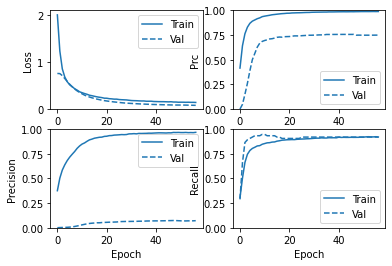

In [52]:
plot_metrics(resampled_history)

### Evaluate metrics

In [53]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

 1/90 [..............................] - ETA: 4s

48/90 [===============>..............] - ETA: 0s

90/90 [==============================] - 0s 1ms/step


 1/28 [>.............................] - ETA: 0s

28/28 [==============================] - 0s 1ms/step


loss :  0.0926642045378685
tp :  87.0
fp :  1080.0
tn :  55786.0
fn :  9.0
accuracy :  0.9808819890022278
precision :  0.07455012947320938
recall :  0.90625
auc :  0.9739617109298706
prc :  0.6837594509124756

Legitimate Transactions Detected (True Negatives):  55786
Legitimate Transactions Incorrectly Detected (False Positives):  1080
Fraudulent Transactions Missed (False Negatives):  9
Fraudulent Transactions Detected (True Positives):  87
Total Fraudulent Transactions:  96


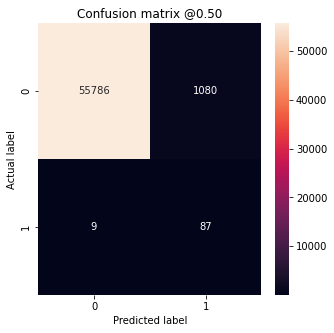

In [54]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

### Plot the ROC

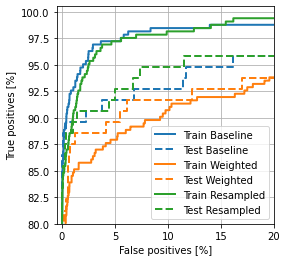

In [55]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

### Plot the AUPRC


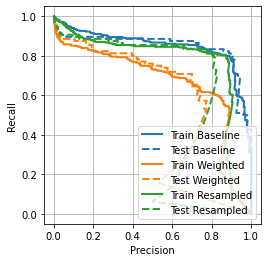

In [56]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_prc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

## Applying this tutorial to your problem

Imbalanced data classification is an inherently difficult task since there are so few samples to learn from. You should always start with the data first and do your best to collect as many samples as possible and give substantial thought to what features may be relevant so the model can get the most out of your minority class. At some point your model may struggle to improve and yield the results you want, so it is important to keep in mind the context of your problem and the trade offs between different types of errors.